In [90]:
from valurap import path_planning
from valurap import gcode
import logging
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import time
from IPython.display import display
import IPython


import imp
imp.reload(path_planning)
imp.reload(gcode)

logging.basicConfig(level=logging.DEBUG)
logging.getLogger('valurp.path_planning').setLevel(logging.DEBUG)

lines = gcode.reader("test.gcode")
pg = gcode.path_gen(lines)
sg = gcode.gen_segments(pg)
todo = []

for i, s in enumerate(sg):
    #print(str(s)[:100])
    if isinstance(s, gcode.do_move):
        print(i, s)
        if i != 4:
            assert s.deltas.get("X", 0) == 0
            assert s.deltas.get("Y", 0) == 0
    if isinstance(s, gcode.do_segment):
        print("segment", i, len(s.path))
        if i > 135:
            break
        elif i >= 10 and i <= 225:
            todo.append(s)

seg = np.array(todo[0].path)

Exception ignored in: <_io.FileIO name='test.gcode' mode='rb' closefd=True>


Do Home
do_home
Set current ['E0']
Set current ['E0']
Set current ['E0']
Set current ['E0']
1 do_move(deltas={'Z': 2.5, 'F': 6000.0, 'line': 20})
2 do_move(deltas={'E': 3.0, 'F': 200.0, 'line': 23})
3 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 27})
4 do_move(deltas={'X': -156.977, 'Y': 203.188, 'Z': -14.7, 'F': 3600.0, 'line': 31})
5 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 33})
segment 6 264
7 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 296})
segment 8 6
9 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 303})
segment 10 917
11 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 1221})
segment 12 11
13 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 1232})
segment 14 942
15 do_move(deltas={'X': 0.0, 'Y': 0.0, 'Z': 0.3, 'F': 600.0, 'line': 2176})
segment 16 986
17 do_move(deltas={'E': -6.5, 'F': 1500.0, 'line': 3169})
segment 18 13
19 do_move(deltas={'E': 6.5, 'F': 1500.0, 'line': 3182})
segment 20 947
21 do_move(deltas={'X': 0.0, 'Y': 0.0, 'Z': 0.30000000000000004, 'F': 600.0,

In [ ]:
a = 2
b = 5
c = 100
seg = [
    [0, 0, 0],
    [b, 0, 100],
    [b, 0.01, 300],
    [b, 0.02, 300],
    [b + 1, a, 300],
    [b + c, a, 200],
    [b + c, a, 0]
]

seg = np.array(seg)

In [ ]:
import numpy as np
import pandas as pd
import IPython

path, slowdowns = path_planning.make_path(seg)
IPython.display.display(path)
IPython.display.display(slowdowns)


In [ ]:
speeds = path_planning.gen_speeds(path, slowdowns)
speeds[0:1]

In [ ]:
# corner calculations

corner_errors_slowdowns, cc = path_planning.process_corner_errors(path, slowdowns)
cc
corner_errors_slowdowns[73:76]

In [ ]:
import IPython
new_slowdowns, cc = path_planning.process_corner_errors(path, corner_errors_slowdowns)
IPython.display.display(cc)
IPython.display.display(new_slowdowns)

In [ ]:
corner_space_slowdowns, cc = path_planning.process_corner_space(path, corner_errors_slowdowns)
speeds = path_planning.gen_speeds(path, corner_space_slowdowns)

IPython.display.display(cc)
IPython.display.display(corner_space_slowdowns)
IPython.display.display(speeds)

In [ ]:
plato_slowdowns = corner_space_slowdowns
for i in range(20):
    new_plato_slowdowns, stage_ok, cc, ac, dc, nc, sc = path_planning.process_plato(path, plato_slowdowns)
    plato_slowdowns = new_plato_slowdowns
    print("Result", i, len(sc[sc["slowdown"] < 0.999]))

    if stage_ok:
        break            

speeds = path_planning.gen_speeds(path, plato_slowdowns)

IPython.display.display(cc)
IPython.display.display(ac)
IPython.display.display(dc)
IPython.display.display(sc)
IPython.display.display(nc)
IPython.display.display(plato_slowdowns)
IPython.display.display(speeds)

plato2_slowdowns, stage_ok, cc1, ac1, dc1, nc1, sc1 = path_planning.process_plato(path, plato_slowdowns)
IPython.display.display(sc1)
IPython.display.display(nc1)
IPython.display.display(plato2_slowdowns)


In [91]:
######## All-in-One

t0 = time.time()
path, slowdowns = path_planning.make_path(seg)
corner_errors_slowdowns, cc = path_planning.process_corner_errors(path, slowdowns)
corner_space_slowdowns, cc = path_planning.process_corner_space(path, corner_errors_slowdowns)
plato_slowdowns = corner_space_slowdowns
for i in range(20):
    new_plato_slowdowns, stage_ok, cc, nc, sc = path_planning.process_plato(path, plato_slowdowns)
    plato_slowdowns = new_plato_slowdowns
    print("Result", i, len(sc[sc["slowdown"] < 0.999]))

    if stage_ok:
        break

final_slowdowns, stage_ok, cc1, nc1, sc1 = path_planning.process_plato(path, plato_slowdowns)
ce_slowdowns, ce1 = path_planning.process_corner_errors(path, plato_slowdowns)
cs_slowdowns, cs1 = path_planning.process_corner_space(path, plato_slowdowns)
speeds = path_planning.gen_speeds(path, plato_slowdowns)

assert stage_ok
t1 = time.time()
print("Planning time:", t1 - t0)


Result 0 807
Result 1 136
Result 2 50
Result 3 35
Result 4 16
Result 5 8
Result 6 8
Result 7 2
Result 8 0
Planning time: 2.029232978820801


In [17]:
print("---- path ----")
display(path.iloc[0])
print("---- ce1 ----")
display(ce1.iloc[0])
print("---- cs1 ----")
display(cs1.iloc[0])
print("---- nc1 ----")
display(nc1.iloc[0])
print("---- speeds ----")
display(speeds.iloc[0])
l = len(cs1)
print("---- cs1 ----")
display(cs1.iloc[l-10:])
print("---- path ----")
display(path.iloc[l-10:])

---- path ----


x           -49.443000
y           -38.129000
v           180.000000
e         -5461.423270
src_idx       1.000000
dx          -40.683000
dy          -40.682000
l            57.533743
de           -2.870370
px           -8.760000
py            2.553000
pe        -5458.552900
pv            0.000000
pdx           0.000000
pdy           0.000000
pl            0.000000
pde           0.000000
nx          -49.513000
ny          -38.199000
ne        -5461.423270
nv          180.000000
ndx          -0.070000
ndy          -0.070000
nde           0.000000
nl            0.098995
dt            0.319632
Name: 0.0, dtype: float64

---- ce1 ----


dvx               -127.280785
dvy               -127.277656
dtx                  0.127281
dty                  0.127278
dt                   0.127281
ax               -1000.000000
ay                -999.975420
mdx                 -2.025050
mdy                 -2.025000
mvx                -63.640392
mvy                -63.638828
md                   0.000000
error_slowdown       1.000000
Name: 0.0, dtype: float64

---- cs1 ----


dvx            -127.280785
dvy            -127.277656
dtx               0.127281
dty               0.127278
dt                0.127281
cdt               0.063640
in_l              0.000000
in_dx            -0.000000
in_dy            -0.000000
pl                0.000000
in_slowdown       1.000000
out_l            11.455271
out_dx           -8.100199
out_dy           -8.100000
l                57.533743
out_slowdown      1.000000
slowdown          1.000000
Name: 0.0, dtype: float64

---- nc1 ----


n_dvx           115.510273
n_dvy           115.507434
n_dtx             0.115510
n_dty             0.115507
n_dt              0.115510
n_ax           1000.000000
n_ay            999.975420
n_dx             -8.030927
n_dy             -8.030729
n_l              11.357306
n_avail_l        46.078471
n_k               4.057166
n_real_dt         0.468644
n_real_ax       246.477486
n_real_ay       246.471427
n_dvx_in          0.000000
n_dvy_in          0.000000
n_dvx_out       115.510273
n_dvy_out       115.507434
n_dtx_in          0.000000
n_dty_in          0.000000
n_dt_in           0.000000
n_ax_in           0.000000
n_ay_in           0.000000
n_dx_in           0.000000
n_dy_in           0.000000
n_l_in            0.000000
n_avail_in       23.039236
n_dtx_out         0.115510
n_dty_out         0.115507
n_dt_out          0.115510
n_ax_out       1000.000000
n_ay_out        999.975420
n_dx_out         -8.030927
n_dy_out         -8.030729
n_l_out          11.357306
n_avail_out      11.681930
N

---- speeds ----


path            180.000000
c_in              0.000000
c_out           180.000000
out              16.645813
plato_base       16.645813
plato_delta     163.354187
plato           180.000000
c_in_x            0.000000
c_in_y            0.000000
c_out_x        -127.280785
c_out_y        -127.277656
plato_x        -127.280785
plato_y        -127.277656
out_x           -11.770512
out_y           -11.770223
max_a          1414.196182
Name: 0.0, dtype: float64

---- cs1 ----


dvx           dvy           dtx           dty  \
t                                                                   
19.339667 -8.881784e-15  7.105427e-15  8.881784e-18  7.105427e-18   
19.340767  1.012883e+00  3.951786e+00  1.012883e-03  3.951786e-03   
19.346191 -7.134501e+00 -2.783800e+01  7.134501e-03  2.783800e-02   
19.408691 -1.470203e-03  1.470018e-03  1.470203e-06  1.470018e-06   
19.409791 -4.342739e-01 -3.235136e+00  4.342739e-04  3.235136e-03   
19.412108  1.099361e+01  2.723691e+01  1.099361e-02  2.723691e-02   
19.494163 -1.776357e-15  1.776357e-15  1.776357e-18  1.776357e-18   
19.495263  3.265840e+00  1.976783e-01  3.265840e-03  1.976783e-04   
19.497362 -2.748280e+01 -9.593586e+00  2.748280e-02  9.593586e-03   
19.596561  4.494183e-13 -4.511946e-13  4.494183e-16  4.511946e-16   

                     dt           cdt          in_l         in_dx  \
t                                                                   
19.339667  8.881784e-18  4.440892e-18  7.340506e-17  5.190521e-17   
19.340767  3.951786e-03  1.975893e-03  1.669589e-03  1.180578e-03   
19.346191  2.783800e-02  1.391900e-02  3.313985e-01 -4.072894e-02   
19.408691  1.470203e-06  7.351015e-07  1.215773e-05  8.595732e-06   
19.409791  3.235136e-03  1.617568e-03  1.671508e-03  1.181934e-03   
19.412108  2.723691e-02  1.361846e-02  3.264499e-01  9.200719e-02   
19.494163  1.776357e-18  8.881784e-19  1.468983e-17 -1.038728e-17   
19.495263  3.265840e-03  1.632920e-03  1.671595e-03 -1.181996e-03   
19.497362  2.748280e-02  1.374140e-02  3.280726e-01 -3.196564e-01   
19.596561  4.511946e-16  2.255973e-16  3.756231e-15  2.656056e-15   

                  in_dy        pl  in_slowdown         out_l        out_dx  \
t                                                                            
19.339667  5.190521e-17  3.667056          1.0  7.340506e-17 -5.190521e-17   
19.340767  1.180578e-03  0.098995          1.0  6.678356e-03  8.207712e-04   
19.346191 -3.288862e-01  1.952804          1.0  8.284963e-02 -5.857617e-02   
19.408691  8.597894e-06  5.625034          1.0  1.215773e-05 -8.596813e-06   
19.409791  1.181934e-03  0.098995          1.0  6.686031e-03 -1.884402e-03   
19.412108  3.132160e-01  0.833802          1.0  8.161249e-02  5.770874e-02   
19.494163 -1.038728e-17  7.385023          1.0  1.468983e-17  1.038728e-17   
19.495263 -1.181996e-03  0.098995          1.0  6.686380e-03  6.514851e-03   
19.497362 -7.383368e-02  0.755378          1.0  8.201815e-02 -5.799559e-02   
19.596561  2.656056e-15  8.927930          1.0  3.756231e-15 -2.656056e-15   

                 out_dy         l  out_slowdown  slowdown  
t                                                          
19.339667 -5.190521e-17  0.098995           1.0       1.0  
19.340767  6.627727e-03  1.952804           1.0       1.0  
19.346191 -5.859090e-02  5.625034           1.0       1.0  
19.408691 -8.596813e-06  0.098995           1.0       1.0  
19.409791 -6.414985e-03  0.833802           1.0       1.0  
19.412108  5.770874e-02  7.385023           1.0       1.0  
19.494163  1.038728e-17  0.098995           1.0       1.0  
19.495263  1.504789e-03  0.755378           1.0       1.0  
19.497362 -5.799559e-02  8.927930           1.0       1.0  
19.596561 -2.656056e-15  0.098995           1.0       1.0

---- path ----


x       y      v           e  src_idx     dx     dy         l  \
t                                                                               
19.339667 -34.385  13.131   90.0 -5591.62291      609 -0.070 -0.070  0.098995   
19.340767 -34.145  15.069  360.0 -5591.62291      610  0.240  1.938  1.952804   
19.346191 -38.122  11.091   90.0 -5591.90355      611 -3.977 -3.978  5.625034   
19.408691 -38.192  11.021   90.0 -5591.90355      612 -0.070 -0.070  0.098995   
19.409791 -38.427  10.221  360.0 -5591.90355      613 -0.235 -0.800  0.833802   
19.412108 -33.205  15.443   90.0 -5592.27199      614  5.222  5.222  7.385023   
19.494163 -33.135  15.513   90.0 -5592.27199      615  0.070  0.070  0.098995   
19.495263 -32.399  15.683  360.0 -5592.27199      616  0.736  0.170  0.755378   
19.497362 -38.712   9.370   90.0 -5592.71740      617 -6.313 -6.313  8.927930   
19.596561 -38.782   9.300   90.0 -5592.71740      618 -0.070 -0.070  0.098995   

                de      px  ...      pde      nx      ny          ne     nv  \
t                           ...                                               
19.339667  0.00000 -34.315  ... -0.18295 -34.145  15.069 -5591.62291  360.0   
19.340767  0.00000 -34.385  ...  0.00000 -38.122  11.091 -5591.90355   90.0   
19.346191 -0.28064 -34.145  ...  0.00000 -38.192  11.021 -5591.90355   90.0   
19.408691  0.00000 -38.122  ... -0.28064 -38.427  10.221 -5591.90355  360.0   
19.409791  0.00000 -38.192  ...  0.00000 -33.205  15.443 -5592.27199   90.0   
19.412108 -0.36844 -38.427  ...  0.00000 -33.135  15.513 -5592.27199   90.0   
19.494163  0.00000 -33.205  ... -0.36844 -32.399  15.683 -5592.27199  360.0   
19.495263  0.00000 -33.135  ...  0.00000 -38.712   9.370 -5592.71740   90.0   
19.497362 -0.44541 -32.399  ...  0.00000 -38.782   9.300 -5592.71740   90.0   
19.596561  0.00000 -38.712  ... -0.44541 -38.782   9.300 -5592.71740    0.0   

             ndx    ndy      nde        nl        dt  
t                                                     
19.339667  0.240  1.938  0.00000  1.952804  0.001100  
19.340767 -3.977 -3.978 -0.28064  5.625034  0.005424  
19.346191 -0.070 -0.070  0.00000  0.098995  0.062500  
19.408691 -0.235 -0.800  0.00000  0.833802  0.001100  
19.409791  5.222  5.222 -0.36844  7.385023  0.002316  
19.412108  0.070  0.070  0.00000  0.098995  0.082056  
19.494163  0.736  0.170  0.00000  0.755378  0.001100  
19.495263 -6.313 -6.313 -0.44541  8.927930  0.002098  
19.497362 -0.070 -0.070  0.00000  0.098995  0.099199  
19.596561  0.000  0.000  0.00000  0.000000  0.001100  

[10 rows x 26 columns]

DEBUG:matplotlib.pyplot:Loaded backend nbAgg version unknown.


<IPython.core.display.Javascript object>


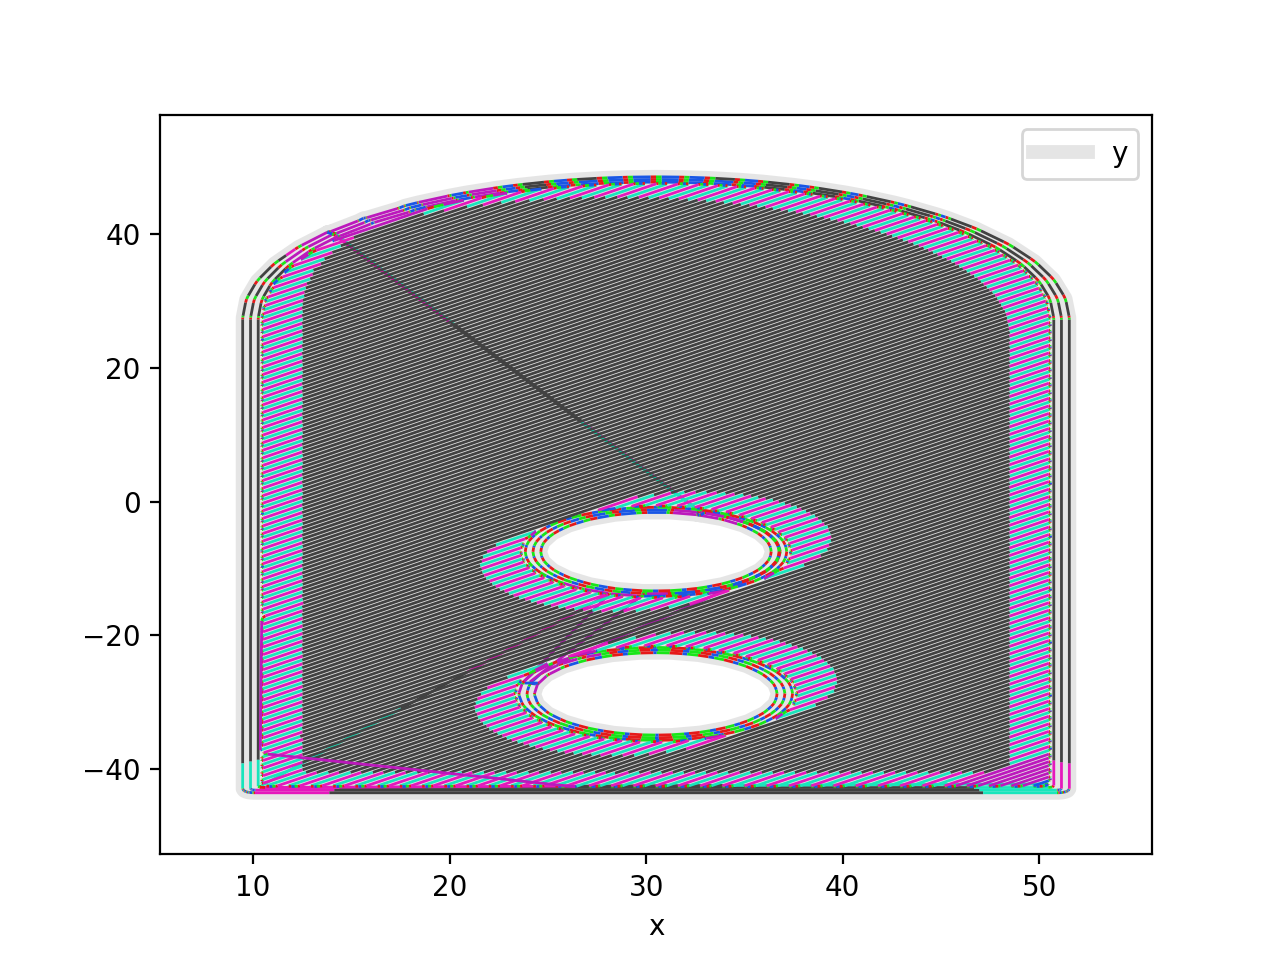

x       y
0  25.527 -24.410
1  26.712 -23.347
2  28.114 -22.597
3  29.657 -22.205
4  31.248 -22.194
5  32.795 -22.562
6  34.208 -23.291
7  35.408 -24.337
8  36.320 -25.640
9  36.896 -27.123

x0         y0        vx0        vy0          ax0          ay0  \
0  25.527000 -24.410000   0.000000   0.000000  1000.000000   897.046414   
1  25.772189 -24.190054  22.144501  19.864646   746.866530   669.973942   
2  26.503560 -23.533981  39.785059  35.689045   700.703621 -1000.000000   
3  26.721617 -23.360724  43.456157  30.449886   700.703621 -1000.000000   
4  26.958907 -23.214917  47.127254  25.210728   571.097289   305.508536   
5  27.719041 -22.808283  55.580561  29.732825   387.864591 -1000.000000   
6  28.123793 -22.622248  58.336752  22.626760   387.864591 -1000.000000   
7  28.548130 -22.486709  61.092943  15.520696   592.981854   150.647367   
8  29.113439 -22.343092  66.353468  16.857135   128.551729 -1000.000000   
9  29.661313 -22.238554  67.406551   8.665229   128.551729 -1000.000000   

          x1         y1        vx1        vy1          ax1          ay1  \
0  25.772189 -24.190054  22.144501  19.864646  1000.000000   897.046414   
1  26.503560 -23.533981  39.785059  35.689045   746.866530   669.973942   
2  26.721617 -23.360724  43.456157  30.449886   700.703621 -1000.000000   
3  26.958907 -23.214917  47.127254  25.210728   700.703621 -1000.000000   
4  27.719041 -22.808283  55.580561  29.732825   571.097289   305.508536   
5  28.123793 -22.622248  58.336752  22.626760   387.864591 -1000.000000   
6  28.548130 -22.486709  61.092943  15.520696   387.864591 -1000.000000   
7  29.113439 -22.343092  66.353468  16.857135   592.981854   150.647367   
8  29.661313 -22.238554  67.406551   8.665229   128.551729 -1000.000000   
9  30.217815 -22.201123  68.459635   0.473322   128.551729 -1000.000000   

         dt  src_idx  src_part      seg_type         t   src_de        de  
0  0.022145        1  0.206911         start  0.022145 -0.07942 -0.016433  
1  0.023619        1  0.617190  middle_plato  0.045764 -0.07942 -0.049017  
2  0.005239        1  0.175899           end  0.051003 -0.07942 -0.013970  
3  0.005239        2  0.176111         start  0.056242 -0.07932 -0.013969  
4  0.014802        2  0.542178  middle_plato  0.071044 -0.07932 -0.043006  
5  0.007106        2  0.281711           end  0.078150 -0.07932 -0.022345  
6  0.007106        3  0.281355         start  0.085256 -0.07943 -0.022348  
7  0.008871        3  0.366370   short_plato  0.094128 -0.07943 -0.029101  
8  0.008192        3  0.352276           end  0.102319 -0.07943 -0.027981  
9  0.008192        4  0.352492         start  0.110511 -0.07938 -0.027981

x       y
906  22.918  46.111
907  21.794  45.553
908  12.499  36.258
909  12.429  36.188
910  13.048  37.372
911  20.641  44.966
912  20.711  45.036
913  19.110  44.001
914  14.111  39.001
915  14.041  38.931

x0         y0        vx0        vy0          ax0          ay0  \
3237  15.131093  39.455367  63.635420  63.643801     0.000000     0.000000   
3238  18.684470  43.009212  63.635420  63.643801  -999.868317 -1000.000000   
3239  20.641000  44.966000  11.701718  11.702488  -989.928085  -989.928085   
3240  20.709817  45.034817   0.837393   0.837393 -1000.000000  -751.211002   
3241  20.710001  45.035250  -0.575833  -0.224238 -1000.000000  -751.211002   
3242  20.708189  45.034183  -1.989059  -1.285869  -963.947531  -623.164081   
3243  19.683239  44.371582 -44.496665 -28.765801  1000.000000   389.313921   
3244  19.192982  44.033306 -31.613933 -23.750374  1000.000000   389.313921   
3245  18.868691  43.759643 -18.731200 -18.734947    22.309762    22.314224   
3246  14.111000  39.001000 -11.772261 -11.773439   990.098029   990.098029   

             x1         y1        vx1        vy1          ax1          ay1  \
3237  18.684470  43.009212  63.635420  63.643801     0.000000     0.000000   
3238  20.641000  44.966000  11.701718  11.702488  -999.868317 -1000.000000   
3239  20.709817  45.034817   0.837393   0.837393  -989.928085  -989.928085   
3240  20.710001  45.035250  -0.575833  -0.224238 -1000.000000  -751.211002   
3241  20.708189  45.034183  -1.989059  -1.285869 -1000.000000  -751.211002   
3242  19.683239  44.371582 -44.496665 -28.765801  -963.947531  -623.164081   
3243  19.192982  44.033306 -31.613933 -23.750374  1000.000000   389.313921   
3244  18.868691  43.759643 -18.731200 -18.734947  1000.000000   389.313921   
3245  14.111000  39.001000 -11.772261 -11.773439    22.309762    22.314224   
3246  14.041000  38.931000   0.000000   0.000000   990.098029   990.098029   

            dt  src_idx  src_part         seg_type           t   src_de  \
3237  0.055840      911  0.467981  long_plato_main  135.629815 -0.53576   
3238  0.051941      911  0.257676   long_plato_out  135.681756 -0.53576   
3239  0.010976      912  0.983094      short_plato  135.692732  0.00000   
3240  0.001413      912  0.016906              end  135.694145  0.00000   
3241  0.001413      913  0.001756            start  135.695558  0.00000   
3242  0.044097      913  0.640194     middle_plato  135.739656  0.00000   
3243  0.012883      913  0.358050              end  135.752539  0.00000   
3244  0.012883      914  0.048271            start  135.765421 -0.35274   
3245  0.311950      914  0.951729     middle_plato  136.077372 -0.35274   
3246  0.011891      915  1.000000      short_plato  136.089263  0.00000   

            de  
3237 -0.250725  
3238 -0.138052  
3239  0.000000  
3240  0.000000  
3241  0.000000  
3242  0.000000  
3243  0.000000  
3244 -0.017027  
3245 -0.335713  
3246  0.000000

In [35]:
%matplotlib notebook

from matplotlib.collections import LineCollection
import warnings

warnings.simplefilter("error")

all_segments = path_planning.build_segments(path, plato_slowdowns)

lines = []
colors = []

i = 0
for index, row in all_segments.iterrows():
    i += 1
    lines.append(((row['x0'], row['y0']), (row['x1'], row['y1'])))
    st = row["seg_type"]
    if st == "start":
        colors.append((1,0,0,1))
    elif st == "end":
        colors.append((0,1,0,1))
    elif st == "short_plato":
        colors.append((0,0.3,1,1))
    elif st == "middle_plato":
        colors.append((0.8,0,0.8,1))
    elif st == "long_plato_main":
        colors.append((0.2,0.2,0.2,1))
    elif st == "long_plato_in":
        colors.append((1,0,0.8,1))
    elif st == "long_plato_out":
        colors.append((0,1,0.8,1))
    else:
        colors.append((1,1,0,1))
    
lc = LineCollection(lines, colors=colors, linewidths=1)
fig, ax = plt.subplots()

ax.add_collection(lc)

#path.iloc[limit:].plot(x="px", y="py", linewidth=3, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
full_path = pd.DataFrame()
full_path["x"] = path["px"]
full_path["y"] = path["py"]
last_x = path["x"].iloc[-1]
last_y = path["y"].iloc[-1]
full_path = full_path.append({"x": last_x, "y": last_y}, ignore_index=True)
full_path.plot(x="x", y="y", linewidth=5, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
    
ax.autoscale()
ax.margins(0.1)
display(full_path.iloc[:10])
display(all_segments.iloc[:10])

display(full_path.iloc[-10:])
display(all_segments.iloc[-10:])


In [36]:
all_segments["test_vx1"] = all_segments["vx0"] + all_segments["dt"] * all_segments["ax0"]
all_segments["test_vy1"] = all_segments["vy0"] + all_segments["dt"] * all_segments["ay0"]
all_segments["test_x1"] = all_segments["x0"] + all_segments["dt"] * all_segments["vx0"] + all_segments["dt"] * all_segments["dt"] * all_segments["ax0"]/2
all_segments["test_y1"] = all_segments["y0"] + all_segments["dt"] * all_segments["vy0"] + all_segments["dt"] * all_segments["dt"] * all_segments["ay0"]/2
print("bad vx1")
display(all_segments[abs(all_segments["test_vx1"] - all_segments["vx1"]) > 0.01])
print("bad vy1")
display(all_segments[abs(all_segments["test_vy1"] - all_segments["vy1"]) > 0.01])
print("bad x1")
display(all_segments[abs(all_segments["test_x1"] - all_segments["x1"]) > 0.0001])
print("bad y1")
display(all_segments[abs(all_segments["test_y1"] - all_segments["y1"]) > 0.0001])
print("ax non continuous")
display(all_segments[abs(all_segments["ax1"] - all_segments["ax0"]) > 0.001])
print("ay non continuous")
display(all_segments[abs(all_segments["ay1"] - all_segments["ay0"]) > 0.001])
print("vx non continuous")
display(all_segments[abs(all_segments["vx1"] - all_segments["vx0"].shift(-1)) > 0.001])
print("vy non continuous")
display(all_segments[abs(all_segments["vy1"] - all_segments["vy0"].shift(-1)) > 0.001])
print("x non continuous")
display(all_segments[abs(all_segments["x1"] - all_segments["x0"].shift(-1)) > 0.001])
print("y non continuous")
display(all_segments[abs(all_segments["y1"] - all_segments["y0"].shift(-1)) > 0.001])
print("src_part groups")
display(np.bincount(all_segments["src_idx"], weights=all_segments["src_part"]))
display(all_segments[np.isnan(all_segments["dt"])][["seg_type", "vx0", "vx1", "vy0", "vy1"]])


bad vx1


x0         y0        vx0        vy0         ax0         ay0  \
221    9.868000 -42.870000  -0.000072 -10.147490    0.000000  990.035530   
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
229    9.959876 -43.101063   7.111078  -1.862425 -204.457186   53.548311   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
221    9.868020 -42.920998   0.199844  -1.597110  ...       74  1.000000   
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
229   10.078003 -43.131979   1.573010  -0.202573  ...       78  0.937492   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
221    short_plato   3.520897 -0.00255 -0.002550  -0.000072  -1.424192   
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
229    short_plato   3.575201 -0.00650 -0.006094   1.505505  -0.394299   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plat

bad vy1


x0         y0        vx0        vy0         ax0         ay0  \
221    9.868000 -42.870000  -0.000072 -10.147490    0.000000  990.035530   
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
229    9.959876 -43.101063   7.111078  -1.862425 -204.457186   53.548311   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
221    9.868020 -42.920998   0.199844  -1.597110  ...       74  1.000000   
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
229   10.078003 -43.131979   1.573010  -0.202573  ...       78  0.937492   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
221    short_plato   3.520897 -0.00255 -0.002550  -0.000072  -1.424192   
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
229    short_plato   3.575201 -0.00650 -0.006094   1.505505  -0.394299   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plat

bad x1


x0         y0        vx0        vy0         ax0         ay0  \
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
225    9.912234 -43.057979   6.950302  -9.267069 -734.267183  979.022911   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
225    9.934462 -43.086512   5.767085  -5.455584  ...       76  0.604599   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
225    short_plato   3.543862 -0.00300 -0.001814   4.107230  -5.476306   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plato  80.291867  0.00000  0.000000  17.848361   9.158879   

        test_x1    test_y1  
222    9.889671 -43.018322  
225    9.933642 -43.086522  
226    9.943117 -43.095031  
230   10.130523 -43.133769  
239   51.087871 -43.065095  
240   51.099596 -43.053931  
241   51.134596 -42.945263  
1625  27.433416 -22.345581  
1626  26.287749 -23.079172  
1921  33.050542 -35.396458  
1922  33.826622 -35.002105  
2202  28.368487  -1.046513  
2203  27.767266  

bad y1


x0         y0        vx0        vy0         ax0         ay0  \
222    9.868020 -42.920998   0.199844  -1.597110  165.879612 -652.459806   
226    9.934462 -43.086512   5.767085  -5.455584 -814.422228  542.948152   
230   10.078003 -43.131979   1.573010  -0.202573  990.035472    0.000000   
239   51.050258 -43.092929   7.500091   5.550067 -391.522979 -289.727005   
240   51.087671 -43.064682   4.683205   4.849001 -674.825316 -981.564096   
241   51.098729 -43.048876   1.912954   4.190394  256.449802  986.943178   
1625  27.503000 -22.276000 -11.743972 -11.743717  989.927288  989.927288   
1626  27.432580 -22.346143  -2.216921  -1.612838 -126.683033  -77.839302   
1921  32.981000 -35.466000  11.737334  11.737334 -989.927700 -989.927700   
1922  33.051463 -35.395936   2.199648   1.371162  204.931172   97.522905   
2202  28.438000  -0.977000 -11.733430 -11.733430  989.927816  989.927816   
2203  28.367508  -1.046994  -2.191408  -1.187119 -282.676657 -104.309892   
2482  33.113000 -13.838000  11.738165  11.738165 -989.927675 -989.927675   
2483  33.183457 -13.767924   2.201606   1.405228  191.949671   95.119445   

             x1         y1        vx1        vy1  ...  src_idx  src_part  \
222    9.892154 -43.016007   2.854243 -11.226690  ...       75  0.805148   
226    9.945226 -43.094484   6.116337  -4.077558  ...       77  0.623653   
230   10.129000 -43.132000  10.143807   0.000124  ...       79  1.000000   
239   51.087671 -43.064682   4.683205   4.849001  ...       82  0.754850   
240   51.098729 -43.048876   1.912954   4.190394  ...       83  1.000000   
241   51.124890 -42.949361   3.770713  14.511531  ...       84  0.784559   
1625  27.432580 -22.346143  -2.216921  -1.612838  ...      496  1.000000   
1626  26.193598 -23.107540 -17.975366 -11.044809  ...      497  0.844279   
1921  33.051463 -35.395936   2.199648   1.371162  ...      572  1.000000   
1922  33.885063 -34.999085  18.724297   8.910542  ...      573  0.773713   
2202  28.367508  -1.046994  -2.191408  -1.187119  ...      645  1.000000   
2203  27.726444  -1.283739 -19.262756  -7.108107  ...      646  0.715224   
2482  33.183457 -13.767924   2.201606   1.405228  ...      717  1.000000   
2483  34.063227 -13.331809  18.620665   9.227353  ...      718  0.784516   

          seg_type          t   src_de        de   test_vx1   test_vy1  \
222    short_plato   3.535894 -0.00607 -0.004887   2.687550 -11.382086   
226    short_plato   3.545569 -0.00107 -0.000667   4.377301  -4.529061   
230    short_plato   3.584034 -0.00255 -0.002550  10.318397  -0.202573   
239    short_plato   4.122280 -0.00310 -0.002340   5.176687   3.830748   
240    short_plato   4.125640 -0.00097 -0.000970   2.416238   1.551594   
241    short_plato   4.136493 -0.00654 -0.005131   4.696366  14.902313   
1625   short_plato  43.954330  0.00000  0.000000  -0.392908  -0.392653   
1626  middle_plato  44.072404  0.00000  0.000000 -17.174863 -10.803618   
1921   short_plato  53.842486  0.00000  0.000000   0.285739   0.285739   
1922  middle_plato  53.919390  0.00000  0.000000  17.959602   8.871028   
2202   short_plato  67.531944  0.00000  0.000000  -0.217804  -0.217804   
2203   short_plato  67.589819  0.00000  0.000000 -18.551318  -7.224054   
2482   short_plato  80.210352  0.00000  0.000000   0.299707   0.299707   
2483  middle_plato  80.291867  0.00000  0.000000  17.848361   9.158879   

        test_x1    test_y1  
222    9.889671 -43.018322  
226    9.943117 -43.095031  
230   10.130523 -43.133769  
239   51.087871 -43.065095  
240   51.099596 -43.053931  
241   51.134596 -42.945263  
1625  27.433416 -22.345581  
1626  26.287749 -23.079172  
1921  33.050542 -35.396458  
1922  33.826622 -35.002105  
2202  28.368487  -1.046513  
2203  27.767266  -1.290392  
2482  33.182548 -13.768452  
2483  34.000642 -13.337358  

[14 rows x 23 columns]

ax non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

ay non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

vx non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

vy non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

x non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

y non continuous


Empty DataFrame
Columns: [x0, y0, vx0, vy0, ax0, ay0, x1, y1, vx1, vy1, ax1, ay1, dt, src_idx, src_part, seg_type, t, src_de, de, test_vx1, test_vy1, test_x1, test_y1]
Index: []

[0 rows x 23 columns]

src_part groups


array([0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

Empty DataFrame
Columns: [seg_type, vx0, vx1, vy0, vy1]
Index: []

In [ ]:
sub_path = pd.DataFrame()
sub_path["src_idx"] = path["src_idx"]
sub_path["src_de"] = path["de"]
all_segments_extras = all_segments.merge(sub_path, on='src_idx')
all_segments_extras["de"] = all_segments_extras["src_de"] * all_segments_extras["src_part"]
all_segments_extras["de_v"] = all_segments_extras["de"] / all_segments_extras["dt"]
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, 'de_v' ] = 0
all_segments_extras["v0"] = np.linalg.norm(all_segments_extras[['vx0', 'vy0']].values, axis=1)
all_segments_extras["v1"] = np.linalg.norm(all_segments_extras[['vx1', 'vy1']].values, axis=1)
all_segments_extras["avg_v"] = (all_segments_extras["v0"] + all_segments_extras["v1"])/2
all_segments_extras["de_v0"] = all_segments_extras["de_v"] / all_segments_extras["avg_v"] * all_segments_extras["v0"]
all_segments_extras["de_v1"] = all_segments_extras["de_v"] / all_segments_extras["avg_v"] * all_segments_extras["v1"]
all_segments_extras["de_a"] = (all_segments_extras["de_v1"] - all_segments_extras["de_v0"])/ all_segments_extras["dt"]
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_v0"] = 0
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_v1"] = 0
all_segments_extras.loc[abs(all_segments_extras["de"]) < 0.001, "de_a"] = 0

acc_step = 10000
v_step = 50000000
v_mult = v_step / acc_step
spm = 80

delta_e = all_segments_extras["de_v1"] - all_segments_extras["de_v0"].shift(-1)
all_segments_extras["delta_ve"] = delta_e
all_segments_extras["int_dt"] = (all_segments_extras["dt"] * acc_step).fillna(0).astype(int)
all_segments_extras["int_vx0"] = (all_segments_extras["vx0"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vy0"] = (all_segments_extras["vy0"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vx1"] = (all_segments_extras["vx1"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_vy1"] = (all_segments_extras["vy1"] * 2 ** 32 * spm / v_step).fillna(0).astype(int)
all_segments_extras["int_ax"] = (np.around((all_segments_extras["int_vx1"] - all_segments_extras["int_vx0"]) / all_segments_extras["int_dt"])).replace([np.inf, -np.inf], np.nan).fillna(0).astype(int) 
all_segments_extras["int_ay"] = (np.around((all_segments_extras["int_vy1"] - all_segments_extras["int_vy0"]) / all_segments_extras["int_dt"])).replace([np.inf, -np.inf], np.nan).fillna(0).astype(int) 
#all_segments_extras["int_vx1_real1"] = (all_segments_extras["int_vx0"] + (all_segments_extras["int_ax"]-1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_vx1_real"] = (
    all_segments_extras["int_vx0"] + all_segments_extras["int_ax"] * all_segments_extras["int_dt"]
).fillna(0).astype(int)
#all_segments_extras["int_vx1_real3"] = (all_segments_extras["int_vx0"] + (all_segments_extras["int_ax"]+1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
#all_segments_extras["int_vy1_real1"] = (all_segments_extras["int_vy0"] + (all_segments_extras["int_ay"]-1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_vy1_real"] = (
    all_segments_extras["int_vy0"] + all_segments_extras["int_ay"] * all_segments_extras["int_dt"]
).fillna(0).astype(int)
#all_segments_extras["int_vy1_real3"] = (all_segments_extras["int_vy0"] + (all_segments_extras["int_ay"]+1) * all_segments_extras["int_dt"]).fillna(0).astype(int)
all_segments_extras["int_dx"] = ((all_segments_extras["int_vx0"] + all_segments_extras["int_vx1_real"]) / 2 * all_segments_extras["int_dt"] * v_mult).fillna(0).astype(int)
all_segments_extras["int_dy"] = ((all_segments_extras["int_vy0"] + all_segments_extras["int_vy1_real"]) / 2 * all_segments_extras["int_dt"] * v_mult).fillna(0).astype(int)
all_segments_extras["real_dx"] = all_segments_extras["int_dx"] / spm / 2.0 ** 32
all_segments_extras["exp_dx"] = all_segments_extras["x1"] - all_segments_extras["x0"]
all_segments_extras["real_dy"] = all_segments_extras["int_dy"] / spm / 2.0 ** 32
all_segments_extras["exp_dy"] = all_segments_extras["y1"] - all_segments_extras["y0"]
all_segments_extras["error"] = np.linalg.norm([
    all_segments_extras["real_dx"] - all_segments_extras["exp_dx"],
    all_segments_extras["real_dy"] - all_segments_extras["exp_dy"],
], axis = 0)

#display(all_segments_extras[all_segments_extras["error"]>0.02])
display(all_segments_extras[np.logical_and(all_segments_extras["dt"] > -1e-27,all_segments_extras["dt"] < 1e-4)][["seg_type","dt", "vx0", "vx1", "vy0", "vy1", "exp_dx", "exp_dy"]])


In [105]:
from valurap.asg import ProfileSegment
from numpy.linalg import norm
imp.reload(path_planning)

acc_step = 10000
pr_opt = path_planning.format_segments(all_segments, acc_step=acc_step)
display(pr_opt)
res = path_planning.emulate(pr_opt, accel_step=50000000/acc_step, verbose=0)



<ApgState x=8771010413199.0 v=0 a=0 j=0 jj=0> <ApgState x=-8387212135628.0 v=0 a=0 j=0 jj=0>
index: 0 start
x: 25.527 25.527
y: -24.41 -24.41
vx: 0.0 0.0
vy: 0.0 0.0
dx: 0.24518947197976715
dy: 0.2199463364679275
dvx: 22.144501438495595
dvy: 19.864645594194783
int_dt: 221.0
int_dx: 84246461078.12866 int_dy: 75572985760.38086
int_vx0: 0.0 int_vy0: 0.0
int_vx1: 152176.0 int_vy1: 136509.0
int_ax: 45154304.0 0.0105133056640625 int_ay1: 40501248.0 0.009429931640625
x_error to big 0.0014508581898660111
x_error: 0.0014508581898660111
x_error: 0.0014508581898660111 int_jx: -7264 int_ax: 45956976
y_error to big 0.0013244738813398271
y_error: 0.0013244738813398271
y_error: 0.0013244738813398271 int_jy: -6631 int_ay: 41233974
ApgStates: 25.77203657186765 -24.190213431220037
        V: 22.143794922158122 19.860308384522796
   max_xv: 22.045423975214362 0.0
   max_yv: 19.772123778238893 0.0
final x_error: -0.0001529001121198803
final y_error: -0.00015976768796477359
final vx_error: -0.0007065163374

ApgStates: 29.66164353186905 -22.237904109724333
        V: 67.40214303135872 8.66726622916758
   max_xv: 67.38919182680547 66.3401442579925
   max_yv: 16.853009583428502 8.767092367634177
final x_error: 0.00033015031664263006
final y_error: 0.0006495545344655795
final vx_error: -0.0044082655956572125
final vy_error: 0.002037518734869792
index: 9 start
x: 29.66164353186905 29.661313381552407
y: -22.237904109724333 -22.2385536642588
vx: 67.40214303135872 67.40655129695438
vy: 8.66726622916758 8.66522871043271
dx: 0.5561713821895893
dy: 0.03678152270651225
dvx: 1.0574919812579537
dvy: -8.19394379979063
int_dt: 82.0
int_dx: 191099031798.03223 int_dy: 12638034969.724121
int_vx0: 463184.0 int_vy0: 59561.0
int_vx1: 470451.0 int_vy1: 3253.0
int_ax: 5832704.0 0.0013580322265625 int_ay1: -45023232.0 -0.0104827880859375
x_error: -0.0008272856996853761 int_jx: 0 int_ax: 5832704.0
y_error to big -0.0010894728774317741
y_error: -0.0010894728774317741
y_error: -0.0010894728774317741 int_jy: 106786 i

int_ax: -30605312.0 -0.0071258544921875 int_ay1: -45023232.0 -0.0104827880859375
x_error: 2.4707606904428303e-05 int_jx: 0 int_ax: -30605312.0
y_error: -0.00032832549736028227 int_jy: 0 int_ay: -45023232.0
ApgStates: 34.64678748626902 -23.673169636831155
        V: 57.71362339146435 -50.31033651903272
   max_xv: 62.87838914431631 57.78158083558082
   max_yv: -42.712490539997816 -50.210364861413844
final x_error: -2.4707606904428303e-05
final y_error: 0.00032832549736028227
final vx_error: -0.005387707677883213
final vy_error: 0.001401489052774707
index: 19 short_plato
x: 34.64678748626902 34.646812193875924
y: -23.673169636831155 -23.673497962328515
vx: 57.71362339146435 57.719011099142236
vy: -50.31033651903272 -50.31173800808549
dx: 0.3221032518550899
dy: -0.28107345656702876
dvx: 2.864593408891878
dvy: -2.4936757919443053
int_dt: 54.0
int_dx: 110673834612.229 int_dy: -96576104298.3252
int_vx0: 396605.0 int_vy0: -345730.0
int_vx1: 416290.0 int_vy1: -362866.0
int_ax: 23920640.0 0.0055

dvx: -8.77501102676602
dvy: -0.07374114558628264
int_dt: 88.0
int_dx: -11768270683.552246 int_dy: -219886603116.90063
int_vx0: 3833.0 int_vy0: -501047.0
int_vx1: -56468.0 int_vy1: -501554.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: -393216.0 -9.1552734375e-05
x_error to big -0.0010008536149754832
x_error: -0.0010008536149754832
x_error: -0.0010008536149754832 int_jx: 79371 int_ax: -48384484
y_error to big 0.002005012016450536
y_error: 0.002005012016450536
y_error: 0.002005012016450536 int_jy: -159005 int_ay: 6603004
ApgStates: 37.02586036000575 -29.341157105599997
        V: -8.228234946727753 -72.97960110008717
   max_xv: 0.5577749107033014 -8.13612132333219
   max_yv: -72.6032885722816 -72.96344847418368
final x_error: -6.185820223691962e-05
final y_error: 3.9372002067494805e-05
final vx_error: -0.010998830665034376
final vy_error: 0.006074739774376781
index: 31 short_plato
x: 37.02586036000575 37.02592221820799
y: -29.341157105599997 -29.341196477602065
vx: -8.228234946727753

index: 42 start
x: 34.267243705686994 34.267224522491794
y: -34.12399692934705 -34.12335054925031
vx: -63.86806489899755 -63.87238066507494
vy: -44.75776222534478 -44.75560842950537
dx: -0.5126489099165283
dy: -0.31434822270156104
dvx: -5.400138654771247
dvy: 7.702731793585272
int_dt: 77.0
int_dx: -176144824193.72314 int_dy: -108009226884.71436
int_vx0: -438898.0 int_vy0: -307573.0
int_vx1: -476007.0 int_vy1: -254640.0
int_ax: -31588352.0 -0.007354736328125 int_ay1: 45023232.0 0.0104827880859375
x_error: -0.000341778486394162 int_jx: 0 int_ax: -31588352.0
y_error to big 0.0010348394143093742
y_error: 0.0010348394143093742
y_error: 0.0010348394143093742 int_jy: -122502 int_ay: 49739559
ApgStates: 33.75493657425686 -34.43832640369656
        V: -69.26886271685362 -37.055142456665635
   max_xv: -63.86806489899755 -69.19872248545289
   max_yv: -37.144782254472375 -44.75776222534478
final x_error: 0.000341778486394162
final y_error: 1.87483520548426e-05
final vx_error: -0.000659163084819169

int_vx1: -464546.0 int_vy1: 172169.0
int_ax: 16908288.0 0.003936767578125 int_ay1: 45285376.0 0.0105438232421875
x_error to big -0.006433333764380933
x_error: -0.006433333764380933
x_error: -0.006433333764380933 int_jx: 630573 int_ax: -8945205
y_error to big 0.002162831179937541
y_error: 0.002162831179937541
y_error: 0.002162831179937541 int_jy: -211993 int_ay: 53977089
ApgStates: 28.21734471420932 -34.90394768778933
        V: -67.66436854377389 25.068438844755295
   max_xv: -67.75779183954 -70.83173841238022
   max_yv: 24.986802600324154 16.80964487604797
final x_error: -0.00025581786821859964
final y_error: 5.348371700364396e-05
final vx_error: -0.06401272634752786
final vy_error: 0.014621120136343535
index: 54 start
x: 28.21734471420932 28.21760053207754
y: -34.90394768778933 -34.90400117150634
vx: -67.66436854377389 -67.60035581742636
vy: 25.068438844755295 25.053817724618952
dx: -0.5445808609877965
dy: 0.24054085905720513
dvx: 3.1201433011409136
dvy: 8.23144806386431
int_dt: 82.0

vy: 63.670013332739465 63.672300818369735
dx: -0.16589114482722067
dy: 0.5187305767267105
dvx: 8.030502758761543
dvy: 2.0428747812003607
int_dt: 80.0
int_dx: -56999763338.31299 int_dy: 178234468998.11523
int_vx0: -169959.0 int_vy0: 437537.0
int_vx1: -114774.0 int_vy1: 451576.0
int_ax: 45219840.0 0.010528564453125 int_ay1: 11468800.0 0.0026702880859375
x_error: 0.00023817603268838639 int_jx: 0 int_ax: 45219840.0
y_error to big 0.0013232609435078757
y_error: 0.0013232609435078757
y_error: 0.0013232609435078757 int_jy: -139674 int_ay: 17055760
ApgStates: 24.135991474610638 -30.36878242165549
        V: -16.699632396921515 65.71397534571588
   max_xv: -16.800040611997247 -24.73228960298002
   max_yv: 65.70073310285807 63.670013332739465
final x_error: -0.00023817603268838639
final y_error: 2.599263646629879e-05
final vx_error: 0.0021544472969630135
final vy_error: 0.0010872317760544092
index: 66 start
x: 24.135991474610638 24.136229650643326
y: -30.36878242165549 -30.368808414291955
vx: -1

y_error: -8.802416849462702e-05 int_jy: 0 int_ay: 9633792.0
ApgStates: 25.511612804836478 -24.396789393003566
        V: -4.699541023001075 4.0727900341153145
   max_xv: -1.4771649148315191 -4.598841769620776
   max_yv: 4.051398718729615 3.3882679417729378
final x_error: -0.0002457534389783689
final y_error: 8.802416849462702e-05
final vx_error: -0.00028894860654027354
final vy_error: 0.00010490297326626319
index: 79 short_plato
x: 25.511612804836478 25.511858558275456
y: -24.396789393003566 -24.39687741717206
vx: -4.699541023001075 -4.6992520743945345
vy: 4.0727900341153145 4.072685131142048
dx: -0.025501773254848814
dy: 0.02222649896615536
dvx: -1.4387291739766077
dvy: 1.2470441365988316
int_dt: 48.0
int_dx: -8762342569.56665 int_dy: 7636966893.137207
int_vx0: -32295.0 int_vy0: 27988.0
int_vx1: -42182.0 int_vy1: 36558.0
int_ax: -13500416.0 -0.003143310546875 int_ay1: 11730944.0 0.0027313232421875
x_error: 0.00043742309334149354 int_jx: 0 int_ax: -13500416.0
y_error: -0.00026109950518

max_ay violation, slow down 332261019.3852539 78498211.0 54043195.52844595
y_error: 0.0007736054700455952
max_ay violation, slow down 265808815.50820315 67700666.0 54043195.52844595
y_error: 0.0006188843760364763
max_ay violation, slow down 212647052.40656254 59062619.0 54043195.52844595
y_error: 0.0004951075008291811
y_error: 0.0004951075008291811 int_jy: -2512884 int_ay: 52152188
ApgStates: 36.11876065609685 -10.438337181776296
        V: 9.578943718224764 18.37965101003647
   max_xv: 11.807132977992296 9.680225048214197
   max_yv: 18.381106201559305 17.122511053457856
final x_error: -0.000725356957417489
final y_error: -0.0006517403358348162
final vx_error: 0.0003936771008774542
final vy_error: 0.0614486084467174
index: 87 start
x: 36.11876065609685 36.11948601305427
y: -10.438337181776296 -10.437685441440461
vx: 9.578943718224764 9.578550041123886
vy: 18.37965101003647 18.31820240158975
dx: 0.019689490749165373
dy: 0.04304146801655584
dvx: -2.2427080822314043
dvy: 1.111052943103544

dy: 0.8665169145589005
dvx: -0.540864411709923
dvy: 4.402044294146748
int_dt: 166.0
int_dx: -36955201622.72461 int_dy: 297732944756.9043
int_vx0: -42372.0 int_vy0: 343389.0
int_vx1: -46089.0 int_vy1: 373640.0
int_ax: -1441792.0 -0.000335693359375 int_ay1: 11927552.0 0.002777099609375
x_error: -0.0008148828717082779 int_jx: 0 int_ax: -1441792.0
y_error: 0.0007497867246399892 int_jy: 0 int_ay: 11927552.0
ApgStates: 36.69850025674968 -6.320798058377113
        V: -6.697373464703559 54.36610081233084
   max_xv: -6.1659375205636024 -6.694172043353319
   max_yv: 54.339616326615214 49.96967618353665
final x_error: 0.0008148828717082779
final y_error: -0.0007497867246399892
final vx_error: 0.009428467569966514
final vy_error: -0.005619665352554648
index: 95 end
x: 36.69850025674968 36.697685373877974
y: -6.320798058377113 -6.320048271652473
vx: -6.697373464703559 -6.7068019322735255
vy: 54.36610081233084 54.3717204776834
dx: -0.06375362327531775
dy: 0.3417837068600065
dvx: -6.37391847473291
dv

y_error: -0.0003359797319530955 int_jy: 0 int_ay: -44957696.0
ApgStates: 34.20268019020732 -2.3844351835665294
        V: -45.65998096950352 33.37569069117308
   max_xv: -42.591855162754655 -45.58693035505712
   max_yv: 37.568388506770134 33.47551682963967
final x_error: 9.129110490846415e-05
final y_error: 0.0003359797319530955
final vx_error: -0.0008714927390656158
final vy_error: 0.0021063912874339508
index: 105 start
x: 34.20268019020732 34.20258889910241
y: -2.3844351835665294 -2.3847711632984825
vx: -45.65998096950352 -45.659109476764456
vy: 33.37569069117308 33.37358429988564
dx: -0.19773900048215864
dy: 0.13067331146064065
dvx: -3.060520989350607
dvy: -4.190462464613223
int_dt: 42.0
int_dx: -67942603217.16797 int_dy: 44899007934.67789
int_vx0: -313773.0 int_vy0: 229356.0
int_vx1: -334805.0 int_vy1: 200559.0
int_ax: -32833536.0 -0.0076446533203125 int_ay1: -44957696.0 -0.010467529296875
x_error: 0.0003100482945797012 int_jx: 0 int_ax: -32833536.0
y_error: -0.0009095589203123033 

final y_error: 0.00021944414848240612
final vx_error: -0.0673157393997883
final vy_error: -0.02167110557519436
index: 113 end
x: 33.905214013645306 33.90642699649931
y: -2.2191220796317794 -2.219341523780262
vx: 38.43102604150772 38.49834178090751
vy: -20.17113729380071 -20.149466188225517
dx: 0.16042335478255865
dy: -0.09612628641754473
dvx: -2.8915091862960196
dvy: -4.279111625352819
int_dt: 43.0
int_dx: 55121044984.45557 int_dy: -33028740515.942688
int_vx0: 264096.0 int_vy0: -138615.0
int_vx1: 244226.0 int_vy1: -168021.0
int_ax: -30277632.0 -0.007049560546875 int_ay1: -44826624.0 -0.01043701171875
x_error to big 0.0012407981105369004
x_error: 0.0012407981105369004
x_error: 0.0012407981105369004 int_jx: -843406 int_ax: -12144403
y_error: -0.0004023765095704235 int_jy: 0 int_ay: -44826624.0
ApgStates: 34.065714289897 -2.3148459895397537
        V: 35.5772499460727 -24.45114660076797
   max_xv: 38.43102604150772 35.68289685063064
   max_yv: -20.17113729380071 -24.35161150060594
final x

   max_xv: 17.26744812913239 8.930946933105588
   max_yv: -69.82270861044526 -71.86972652561963
final x_error: 0.0009470844937027323
final y_error: 8.6362911071447e-05
final vx_error: 0.00011042075540679264
final vy_error: 0.020870970265946198
index: 124 short_plato
x: 36.69257499335508 36.69162790886138
y: -6.590828548732679 -6.59091491164375
vx: 8.831702871248126 8.83159245049272
vy: -71.9208037480712 -71.94167471833714
dx: 0.02797950289069462
dy: -0.2357207801450807
dvx: 0.26749206861052777
dvy: -2.2007463836413876
int_dt: 32.0
int_dx: 9613683989.909668 int_dy: -80993043336.85822
int_vx0: 60691.0 int_vy0: -494236.0
int_vx1: 62529.0 int_vy1: -509359.0
int_ax: 3735552.0 0.0008697509765625 int_ay1: -30998528.0 -0.0072174072265625
x_error: -0.0006933580446357723 int_jx: 0 int_ax: 3735552.0
y_error to big -0.002160212423356178
y_error: -0.002160212423356178
max_ay violation, slow down -742243336.8582153 88002816.0 54043195.52844595
y_error: -0.0017281699386849426
max_ay violation, slow d

dy: -0.4495376443097605
dvx: -7.179131563075572
dvy: 6.3715909153344015
int_dt: 72.0
int_dx: -120875247730.15625 int_dy: -154459958450.50415
int_vx0: -311207.0 int_vy0: -451813.0
int_vx1: -360542.0 int_vy1: -408028.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: 39845888.0 0.00927734375
x_error: -0.00025153780052278307 int_jx: 0 int_ax: -44892160.0
y_error to big 0.0012295831387625356
y_error: 0.0012295831387625356
y_error: 0.0012295831387625356 int_jy: -178033 int_ay: 46255076
ApgStates: 35.199469735959426 -11.649186433723662
        V: -52.46358341537415 -59.368176152929664
   max_xv: -45.28657882474363 -52.36390279605984
   max_yv: -59.442681958898895 -65.74744475074112
final x_error: 0.00025153780052278307
final y_error: 3.22425345196109e-05
final vx_error: 0.00212697244504767
final vy_error: 0.007677682477059022
index: 135 start
x: 35.199469735959426 35.1992181981589
y: -11.649186433723662 -11.649218676258181
vx: -52.46358341537415 -52.4657103878192
vy: -59.368176152929664 -59.

final y_error: -0.0007792658744474323
final vx_error: 0.00422440234630983
final vy_error: -0.00015490748379676234
index: 142 short_plato
x: 32.167681327552415 32.16765091099209
y: -13.53349800229771 -13.532718736423263
vx: -70.44654921628535 -70.45077361863166
vy: -17.4455635715276 -17.445408664043804
dx: -0.2744432226160036
dy: -0.0671723448516861
dvx: -0.7952201383069024
dvy: -0.1957158141075297
int_dt: 39.0
int_dx: -94297973259.56665 int_dy: -23080241946.690063
int_vx0: -484105.0 int_vy0: -119885.0
int_vx1: -489570.0 int_vy1: -121230.0
int_ax: -9175040.0 -0.00213623046875 int_ay1: -2228224.0 -0.000518798828125
x_error to big 0.0018079350133000105
x_error: 0.0018079350133000105
x_error: 0.0018079350133000105 int_jx: -1647138 int_ax: 22944151
y_error to big 0.0012319740295350101
y_error: 0.0012319740295350101
y_error: 0.0012319740295350101 int_jy: -1122403 int_ay: 19658634
ApgStates: 31.893366898872774 -13.600584703462664
        V: -71.17254426702857 -17.592828953638673
   max_xv: -7

        V: -53.39112249203026 47.12434019893408
   max_xv: -53.428084356710315 -58.24273102916777
   max_yv: 47.00734280049801 40.09110853075981
final x_error: 9.279146933849347e-05
final y_error: 0.0007809313695386066
final vx_error: 0.03171854181598377
final vy_error: -0.01897390637233798
index: 154 short_plato
x: 26.551353288811516 26.551260497342177
y: -12.36076298119733 -12.36154391256687
vx: -53.39112249203026 -53.42284103384625
vy: 47.12434019893408 47.143314105306416
dx: -0.3406706647409017
dy: 0.2997641041665968
dvx: -5.875912470459596
dvy: 5.176218724105205
int_dt: 60.0
int_dx: -117053549101.50024 int_dy: 102998161912.82166
int_vx0: -366901.0 int_vy0: 323836.0
int_vx1: -407280.0 int_vy1: 359407.0
int_ax: -44105728.0 -0.0102691650390625 int_ay1: 38862848.0 0.0090484619140625
x_error to big -0.00298954284953723
x_error: -0.00298954284953723
max_ax violation, slow down -821759281.2001953 66545248.0 54043195.52844595
x_error: -0.002391634279629784
max_ax violation, slow down -657

int_dt: 32.0
int_dx: -9598690907.91626 int_dy: 81010004392.91626
int_vx0: -60657.0 int_vy0: 494168.0
int_vx1: -62529.0 int_vy1: 509359.0
int_ax: -3801088.0 -0.000885009765625 int_ay1: 31129600.0 0.0072479248046875
x_error: 0.0007283789224565851 int_jx: 0 int_ax: -3801088.0
y_error to big 0.0022268050609746126
y_error: 0.0022268050609746126
max_ay violation, slow down 765124392.9162598 89891152.0 54043195.52844595
y_error: 0.00178144404877969
max_ay violation, slow down 612099514.3330078 78138848.0 54043195.52844595
y_error: 0.0014251552390237522
max_ay violation, slow down 489679611.4664063 68736992.0 54043195.52844595
y_error: 0.0011401241912190017
max_ay violation, slow down 391743689.173125 61215520.0 54043195.52844595
y_error: 0.0009120993529752014
max_ay violation, slow down 313394951.3385 55198336.0 54043195.52844595
y_error: 0.0007296794823801612
y_error: 0.0007296794823801612 int_jy: -1203437 int_ay: 50384592
ApgStates: 24.278717124831747 -8.174885910202283
        V: -9.096838

y_error: -0.001342700180483103 int_jy: 252399 int_ay: -53090255
ApgStates: 26.925805034113 -2.3395585176418536
        V: 53.83975803852081 37.27123839780688
   max_xv: 53.75433829613029 49.318914534524076
   max_yv: 43.85423380881548 37.35272912308574
final x_error: -7.102588990903769e-05
final y_error: -7.550037384307373e-05
final vx_error: -0.020167770871253765
final vy_error: -0.02442999444593852
index: 177 start
x: 26.925805034113 26.92587606000291
y: -2.3395585176418536 -2.3394830172680106
vx: 53.83975803852081 53.85992580939207
vy: 37.27123839780688 37.29566839225282
dx: 0.36799072203838534
dy: 0.22305992682786124
dvx: 4.559116535620539
dvy: -6.530418175879657
int_dt: 66.0
int_dx: 126440649310.90332 int_dy: 76642807261.90536
int_vx0: 369984.0 int_vy0: 256126.0
int_vx1: 401314.0 int_vy1: 211249.0
int_ax: 31129600.0 0.0072479248046875 int_ay1: -44564480.0 -0.0103759765625
x_error to big -0.002178263644154299
x_error: -0.002178263644154299
x_error: -0.002178263644154299 int_jx: 409

int_vx1: 255046.0 int_vy1: -62076.0
int_ax: -4587520.0 -0.001068115234375 int_ay1: -44564480.0 -0.0103759765625
x_error to big -0.0014220894718661725
x_error: -0.0014220894718661725
x_error: -0.0014220894718661725 int_jx: 789577 int_ax: -22747791
y_error: 0.00019405044848541664 int_jy: 0 int_ay: -44564480.0
ApgStates: 31.41893089399382 -1.2833337987191045
        V: 37.07318683154881 -9.030773071572185
   max_xv: 37.58541424758732 36.83046088553965
   max_yv: -4.478933988139033 -8.93182004801929
final x_error: -9.731965287329558e-05
final y_error: -0.00019405044848541664
final vx_error: -0.04088670956931395
final vy_error: 0.0024149970796081277
index: 187 middle_plato
x: 31.41893089399382 31.419028213646694
y: -1.2833337987191045 -1.283139748270619
vx: 37.07318683154881 37.114073541118124
vy: -9.030773071572185 -9.033188068651793
dx: 1.2966829771266255
dy: -0.31538171296376993
dvx: -34.13186900216449
dvy: 8.31488622360678
int_dt: 647.0
int_dx: 445536878403.1018 int_dy: -108364331434.86

index: 194 long_plato_main
x: 26.71537819900259 26.724174614058192
y: 11.973679616849404 11.982235825361666
vx: -73.51758540607989 -73.5131964148374
vy: 164.13643606938422 164.30401684947793
dx: -6.478592767122052
dy: 14.508049544140162
dvx: 0.004388991242493034
dvy: 0.16758078009371502
int_dt: 882.0
int_dx: -2226027524711.3086 int_dy: 4984927865666.376
int_vx0: -505209.0 int_vy0: 1127937.0
int_vx1: -505179.0 int_vy1: 1129089.0
int_ax: 0.0 0.0 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.005658265694194142
x_error: 0.005658265694194142
x_error: 0.005658265694194142 int_jx: -446 int_ax: 196686
y_error to big 0.025562158164032667
y_error: 0.025562158164032667
y_error: 0.025562158164032667 int_jy: -2013 int_ay: 953269
ApgStates: 20.233841665901128 26.47899623661069
        V: -73.58117727562785 164.2026472836733
   max_xv: -73.45297490246594 -73.580740718171
   max_yv: 164.60471670143306 164.13643606938422
final x_error: -0.002943765979409818
final y_error: -0.002732924378875623
fi

dvy: -2.7369816498576425
int_dt: 27.0
int_dx: -7564730815.6414795 int_dy: -8954203955.842285
int_vx0: -65002.0 int_vy0: -54819.0
int_vx1: -49142.0 int_vy1: -73627.0
int_ax: 38469632.0 0.0089569091796875 int_ay1: -45678592.0 -0.0106353759765625
x_error: 0.0005248997603732874 int_jx: 0 int_ax: 38469632.0
y_error: -0.0009616020713067996 int_jy: 0 int_ay: -45678592.0
ApgStates: 14.03690735809214 39.91864436647156
        V: -7.152702892199159 -10.715739335864782
   max_xv: -7.238122634589672 -9.459035936743021
   max_yv: -7.977214409038424 -10.614312486723065
final x_error: -0.0005248997603732874
final y_error: 0.0009616020713067996
final vx_error: -0.001529819117982889
final vy_error: -0.0015432769687162562
index: 204 middle_plato
x: 14.03690735809214 14.037432257852513
y: 39.91864436647156 39.917682764400254
vx: -7.152702892199159 -7.151173073081176
vy: -10.715739335864782 -10.714196058896066
dx: -1.2321745168601108
dy: -1.8478450569095912
dvx: -33.80896564477721
dvy: -50.654799891706425

index: 212 start
x: 10.589147025017883 10.589105130436785
y: 32.83477904732572 32.83468242697495
vx: -23.237807909026742 -23.255155451144752
vy: -86.70933311805129 -86.7448702536405
dx: -0.11591926948649522
dy: -0.4967267614732478
dvx: 5.6580608901952445
dvy: -1.5570392711767767
int_dt: 57.0
int_dx: -39829557713.65662 int_dy: -170674015646.04736
int_vx0: -159689.0 int_vy0: -595862.0
int_vx1: -120807.0 int_vy1: -606562.0
int_ax: 44695552.0 0.010406494140625 int_ay1: -12320768.0 -0.00286865234375
x_error: 0.0006968833225062809 int_jx: 0 int_ax: 44695552.0
y_error to big 0.0018827103600855821
y_error: 0.0018827103600855821
y_error: 0.0018827103600855821 int_jy: -549414 int_ay: 3337531
ApgStates: 10.472530872208882 32.33813753285212
        V: -17.580896383151412 -88.23815733194351
   max_xv: -17.680140445008874 -23.237807909026742
   max_yv: -86.68357622809708 -88.17718480713665
final x_error: -0.0006968833225062809
final y_error: 8.524699965306581e-05
final vx_error: -0.00114936431991452

int_vx0: -5.0 int_vy0: -619186.0
int_vx1: -9.0 int_vy1: -618475.0
int_ax: -0.0 -0.0 int_ay1: 0.0 0.0
x_error: -0.0002556577832901752 int_jx: 0 int_ax: -0.0
y_error to big 0.01938471554356056
y_error: 0.01938471554356056
y_error: 0.01938471554356056 int_jy: -169 int_ay: 155142
ApgStates: 9.869017050947878 10.679083845380228
        V: -0.0007275957614183426 -90.23657185025513
   max_xv: -0.0007275957614183426 -0.0007275957614183426
   max_yv: -90.00534191727638 -90.23613529279828
final x_error: 0.0002556577832901752
final y_error: -0.011879710783679442
final vx_error: 0.000551794679983536
final vy_error: -0.23657185934868608
x: 9.869017050947878 9.868761393164588
y: 10.679083845380228 10.690963556163908
vx: -0.0007275957614183426 -0.0012793904414018786
vy: -90.23657185025513 -89.99999999090645
dx: -0.0004905086126907321
dy: -16.508936734293172
dvx: -0.000551794679983536
dvy: 0.23657185934868608
int_dt: 1836.0
int_dx: -168537475.993042 int_dy: -5672427469241.777
int_vx0: -5.0 int_vy0: -6

x_error: 0.00017527314938724047
max_ax violation, slow down 48178716.447047696 59523518.0 54043195.52844595
x_error: 0.00014021851950979237
x_error: 0.00014021851950979237 int_jx: -5693356 int_ax: 51695154
y_error: -0.00019254356426756658 int_jy: 0 int_ay: 45350912.0
ApgStates: 9.959004683184322 -43.1008702162304
        V: 7.17976945452392 -1.862208591774106
   max_xv: 7.191410986706614 6.6132633946836
   max_yv: -1.9629078451544049 -2.969900378957391
final x_error: -0.0008713087589278246
final y_error: 0.00019254356426756658
final vx_error: 0.06869109381892802
final vy_error: 0.00021669317251826747
index: 229 short_plato
x: 9.959004683184322 9.95987599194325
y: -43.1008702162304 -43.101062759794665
vx: 7.17976945452392 7.111078360704992
vy: -1.862208591774106 -1.8624252849466243
dx: 0.11899795913080702
dy: -0.031109265811473108
dvx: -5.606759050595569
dvy: 1.6596353549674459
int_dt: 274.0
int_dx: 40887387420.60486 int_dy: -10689062341.027832
int_vx0: 49339.0 int_vy0: -12797.0
int_vx1

int_vx1: -1.0 int_vy1: 103034.0
int_ax: -44695552.0 -0.010406494140625 int_ay1: 5701632.0 0.0013275146484375
x_error: -2.7005021379977734e-05 int_jx: 0 int_ax: -44695552.0
y_error: -0.00031938356845984117 int_jy: 0 int_ay: 5701632.0
ApgStates: 51.1320266034425 -42.89341106960783
        V: 0.0007275957614183426 14.994293451309204
   max_xv: 1.886364771053195 0.09997165761888027
   max_yv: 14.981633285060523 14.753750292584302
final x_error: 2.7005021379977734e-05
final y_error: 0.00031938356845984117
final vx_error: 0.0009405826549486826
final vy_error: 0.0008680943124499407
index: 244 long_plato_in
x: 51.1320266034425 51.13199959842112
y: -42.89341106960783 -42.89373045317629
vx: 0.0007275957614183426 -0.00021298689353033994
vy: 14.994293451309204 14.993425356996754
dx: -8.293999776043393e-05
dy: 3.937279213646363
dvx: -0.0020060774932029552
dvy: 75.00570653961015
int_dt: 750.0
int_dx: -28497966.232910156 int_dy: 1352838836626.538
int_vx0: 5.0 int_vy0: 103040.0
int_vx1: -9.0 int_vy1: 

vx: -35.783450584858656 -35.787177525072124
vy: 82.27711077779531 82.34822213688972
dx: -0.2177242692470287
dy: 0.4591006251764753
dvx: -5.6609250973852525
dvy: -2.387413542738585
int_dt: 57.0
int_dx: -74809489276.91895 int_dy: 157745773656.48926
int_vx0: -245902.0 int_vy0: 565404.0
int_vx1: -284804.0 int_vy1: 548998.0
int_ax: -44695552.0 -0.010406494140625 int_ay1: -18874368.0 -0.00439453125
x_error to big 0.0020807513591165616
x_error: 0.0020807513591165616
max_ax violation, slow down 571952578.4648438 62000952.0 54043195.52844595
x_error: 0.0016646010872932494
max_ax violation, slow down 457562062.771875 58539854.0 54043195.52844595
x_error: 0.0013316808698345995
max_ax violation, slow down 366049650.21750003 55770994.0 54043195.52844595
x_error: 0.0010653446958676796
x_error: 0.0010653446958676796 int_jx: -310890 int_ax: -35835187
y_error to big -0.003190147526069609
y_error: -0.003190147526069609
y_error: -0.003190147526069609 int_jy: 930952 int_ay: -45406500
ApgStates: 49.1875687

   max_yv: 66.83490937575698 66.81031663902104
final x_error: -0.00012622575951581894
final y_error: -0.0002946998454476102
final vx_error: -0.015648807434011758
final vy_error: 0.005161604477535775
index: 264 end
x: 45.219147921886176 45.21927414764569
y: 41.941289642627815 41.94158434247326
vx: -60.323945945128806 -60.308297137694794
vy: 66.81017111986876 66.80500951539122
dx: -0.13351697221296632
dy: 0.14342251350399238
dvx: -2.1610690552171405
dvy: -2.1072657930334486
int_dt: 22.0
int_dx: -45876082329.25049 int_dy: 49279600400.78125
int_vx0: -414543.0 int_vy0: 459116.0
int_vx1: -429394.0 int_vy1: 444635.0
int_ax: -44236800.0 -0.0102996826171875 int_ay1: -43122688.0 -0.010040283203125
x_error to big 0.0014647162483001352
x_error: 0.0014647162483001352
max_ax violation, slow down 402618136.5996094 126011537.0 54043195.52844595
x_error: 0.0011717729986401083
max_ax violation, slow down 322094509.2796875 109656594.0 54043195.52844595
x_error: 0.0009374183989120866
max_ax violation, slo

int_ax: -0.0 -0.0 int_ay1: -0.0 -0.0
x_error to big -0.0027857475135846244
x_error: -0.0027857475135846244
x_error: -0.0027857475135846244 int_jx: 27150 int_ax: -2402775
y_error to big 0.0018096106516551913
y_error: 0.0018096106516551913
y_error: 0.0018096106516551913 int_jy: -17636 int_ay: 1560786
ApgStates: 43.215845517112754 43.73330970519455
        V: -68.693479988724 58.16094926558435
   max_xv: -68.67529009468853 -68.9206353854388
   max_yv: 58.3191285841167 58.164441725239165
final x_error: -0.0001605933146180405
final y_error: -8.22546583023609e-05
final vx_error: -0.01755356938343766
final vy_error: -0.007918098713901145
index: 270 end
x: 43.215845517112754 43.21600611042737
y: 43.73330970519455 43.73339195985285
vx: -68.693479988724 -68.67592641934056
vy: 58.16094926558435 58.16886736429825
dx: -0.16815307780266409
dy: 0.1377687732219144
dvx: -1.8916998640038116
dvy: -2.4093206497483806
int_dt: 24.0
int_dx: -57776957590.73486 int_dy: 47336990031.85303
int_vx0: -472058.0 int_

max_ay violation, slow down -281290809.2064001 74581938.0 54043195.52844595
y_error: -0.0006549312016144398
max_ay violation, slow down -225032647.36512008 68512918.0 54043195.52844595
y_error: -0.0005239449612915518
max_ay violation, slow down -180026117.89209607 63657698.0 54043195.52844595
y_error: -0.00041915596903324145
max_ay violation, slow down -144020894.31367686 59773518.0 54043195.52844595
y_error: -0.0003353247752265932
max_ay violation, slow down -115216715.4509415 56666169.0 54043195.52844595
y_error: -0.0002682598201812746
max_ay violation, slow down -92173372.36075321 54180292.0 54043195.52844595
y_error: -0.00021460785614501967
y_error: -0.00021460785614501967 int_jy: 589244 int_ay: -52191594
ApgStates: 40.591862032885544 45.489655165502334
        V: -78.92260327935219 43.14511897973716
   max_xv: -77.3373176343739 -78.8146280683577
   max_yv: 45.81685061566532 43.22704626247287
final x_error: -0.003014158778007925
final y_error: 0.00225830131844873
final vx_error: 0.

x_error: 0.0038025426513570437
max_ax violation, slow down 1045234965.0703125 147771350.0 54043195.52844595
x_error: 0.003042034121085635
max_ax violation, slow down 836187972.0562501 121559416.0 54043195.52844595
x_error: 0.0024336272968685083
max_ax violation, slow down 668950377.6450001 100589866.0 54043195.52844595
x_error: 0.0019469018374948066
max_ax violation, slow down 535160302.1160001 83814226.0 54043195.52844595
x_error: 0.0015575214699958455
max_ax violation, slow down 428128241.6928001 70393714.0 54043195.52844595
x_error: 0.0012460171759966763
max_ax violation, slow down 342502593.3542401 59657310.0 54043195.52844595
x_error: 0.0009968137407973413
x_error: 0.0009968137407973413 int_jx: -2454036 int_ax: 17644824
y_error to big -0.0021060537240700228
y_error: -0.0021060537240700228
max_ay violation, slow down -723634549.4799805 116759192.0 54043195.52844595
y_error: -0.0016848429792560183
max_ay violation, slow down -578907639.5839844 102241612.0 54043195.52844595
y_error: 

x_error: 0.0014575928982496265 int_jx: -2644187 int_ax: 33775938
y_error to big -0.0011557318390273963
y_error: -0.0011557318390273963
max_ay violation, slow down -397106436.1254883 76864986.0 54043195.52844595
y_error: -0.0009245854712219171
max_ay violation, slow down -317685148.9003906 70365557.0 54043195.52844595
y_error: -0.0007396683769775337
max_ay violation, slow down -254148119.1203125 65166020.0 54043195.52844595
y_error: -0.000591734701582027
max_ay violation, slow down -203318495.29625002 61006394.0 54043195.52844595
y_error: -0.0004733877612656216
max_ay violation, slow down -162654796.23700002 57678683.0 54043195.52844595
y_error: -0.0003787102090124973
max_ay violation, slow down -130123836.98960002 55016527.0 54043195.52844595
y_error: -0.00030296816720999783
y_error: -0.00030296816720999783 int_jy: 549608 int_ay: -52886796
ApgStates: 32.92130151588644 47.98102770108962
        V: -89.46808520704508 8.89092916622758
   max_xv: -88.54462066665292 -89.36680387705564
   ma

x_error to big -0.0013703454824032235
x_error: -0.0013703454824032235
x_error: -0.0013703454824032235 int_jx: 124949 int_ax: -5772146
y_error: -0.0008220855266714011 int_jy: 0 int_ay: 0.0
ApgStates: 28.073262767281268 47.98102828316623
        V: -89.57984391599894 -8.914503268897533
   max_xv: -89.4643017090857 -89.77032848633826
   max_yv: -8.914503268897533 -8.914503268897533
final x_error: -7.449962870609284e-05
final y_error: 0.0008220855266714011
final vx_error: -0.022369303178507494
final vy_error: -0.0005400103897237329
index: 306 end
x: 28.073262767281268 28.073337266909974
y: 47.98102828316623 47.98020619763956
vx: -89.57984391599894 -89.55747461282043
vy: -8.914503268897533 -8.91396325850781
dx: -0.27263758849660746
dy: -0.0326859028373363
dvx: 0.43204218656158844
dvy: -3.051547691855994
int_dt: 31.0
int_dx: -93677562100.25879 int_dy: -11230790698.127441
int_vx0: -615588.0 int_vy0: -61260.0
int_vx1: -612619.0 int_vy1: -82230.0
int_ax: 6291456.0 0.00146484375 int_ay1: -443023

vy: -29.520160751417276 -29.518164399813283
dx: -0.231941976468498
dy: -0.08465872810125319
dvx: 0.8928098862343745
dvy: -2.7646925882900426
int_dt: 28.0
int_dx: -79694656280.14404 int_dy: -29088517481.26709
int_vx0: -583448.0 int_vy0: -202861.0
int_vx1: -577313.0 int_vy1: -221860.0
int_ax: 14352384.0 0.0033416748046875 int_ay1: -44498944.0 -0.0103607177734375
x_error to big 0.004581390297552446
x_error: 0.004581390297552446
max_ax violation, slow down 1259322975.8847656 172256060.0 54043195.52844595
x_error: 0.0036651122380419567
max_ax violation, slow down 1007458380.7078125 140675322.0 54043195.52844595
x_error: 0.0029320897904335655
max_ax violation, slow down 805966704.5662501 115410740.0 54043195.52844595
x_error: 0.0023456718323468526
max_ax violation, slow down 644773363.6530001 95199066.0 54043195.52844595
x_error: 0.0018765374658774822
max_ax violation, slow down 515818690.9224001 79029738.0 54043195.52844595
x_error: 0.0015012299727019858
max_ax violation, slow down 41265495

index: 325 start
x: 20.196391453497927 20.19489181938854
y: 45.3715102466871 45.370494341088786
vx: -50.28530722483993 -50.23458844821928
vy: -29.77132680825889 -29.754534456721
dx: -0.08778064484348391
dy: -0.05415505166842394
dvx: 1.0785660976378395
dvy: -1.7185225542962321
int_dt: 17.0
int_dx: -30161199905.964355 int_dy: -18607534066.325684
int_vx0: -345558.0 int_vy0: -204587.0
int_vx1: -338146.0 int_vy1: -216397.0
int_ax: 28573696.0 0.00665283203125 int_ay1: -45547520.0 -0.0106048583984375
x_error to big -0.0031584929266372797
x_error: -0.0031584929266372797
max_ax violation, slow down -868199924.7714844 323893854.0 54043195.52844595
x_error: -0.002526794341309824
max_ax violation, slow down -694559939.8171875 264829819.0 54043195.52844595
x_error: -0.002021435473047859
max_ax violation, slow down -555647951.8537501 217578600.0 54043195.52844595
x_error: -0.0016171483784382875
max_ax violation, slow down -444518361.4830001 179777620.0 54043195.52844595
x_error: -0.00129371870275063

dvy: -9.659242998927894
int_dt: 98.0
int_dx: -74047404927.68555 int_dy: -85119220737.1167
int_vx0: -122665.0 int_vy0: -140768.0
int_vx1: -180513.0 int_vy1: -207146.0
int_ax: -38666240.0 -0.009002685546875 int_ay1: -44367872.0 -0.0103302001953125
x_error: 0.00023223422559226492 int_jx: 0 int_ax: -38666240.0
y_error: -0.00015714827784307772 int_jy: 0 int_ay: -44367872.0
ApgStates: 17.72948262281425 43.60720698422519
        V: -26.264024199917912 -30.139053706079725
   max_xv: -17.8501068148762 -26.178167900070548
   max_yv: -20.48444002866745 -30.040537239983678
final x_error: -0.00023223422559226492
final y_error: 0.00015714827784307772
final vx_error: 0.004042438415041261
final vy_error: 0.0046293215156190115
index: 333 end
x: 17.72948262281425 17.72971485703984
y: 43.60720698422519 43.60704983594735
vx: -26.264024199917912 -26.268066638332954
vy: -30.139053706079725 -30.143683027595344
dx: -0.05127358400665827
dy: -0.055422165421362024
dvx: -1.8966391690511522
dvy: 1.881476445180951


ApgStates: 13.926714900878142 40.306938664789776
        V: -6.5795029513537875 3.769964678213
   max_xv: -6.5930362325161695 -7.432099664583802
   max_yv: 10.09568222798407 3.870372893288731
final x_error: 2.1761964504207754e-05
final y_error: 0.0008993076401324629
final vx_error: -0.000835137661638008
final vy_error: -0.003394303946046673
index: 349 start
x: 13.926714900878142 13.926693138913638
y: 40.306938664789776 40.30603935714964
vx: -6.5795029513537875 -6.5786678136921495
vy: 3.769964678213 3.7733589821590465
dx: -0.03889481294330288
dy: 0.0029813742923678888
dvx: 0.8533196369531444
dvy: -6.314935040168941
int_dt: 63.0
int_dx: -13364155966.04187 int_dy: 1024392406.628418
int_vx0: -45214.0 int_vy0: 25907.0
int_vx1: -39350.0 int_vy1: -17489.0
int_ax: 6094848.0 0.0014190673828125 int_ay1: -45154304.0 -0.0105133056640625
x_error: -8.699416078705724e-05 int_jx: 0 int_ax: 6094848.0
y_error to big -0.001188098666524695
y_error: -0.001188098666524695
y_error: -0.001188098666524695 int_

int_ax: 44826624.0 0.01043701171875 int_ay1: -11862016.0 -0.0027618408203125
x_error to big 0.0013779599452803382
x_error: 0.0013779599452803382
max_ax violation, slow down 378770745.6113281 56286987.0 54043195.52844595
x_error: 0.0011023679562242705
x_error: 0.0011023679562242705 int_jx: -321694 int_ax: 53994903
y_error to big 0.003114237103076789
y_error: 0.003114237103076789
y_error: 0.003114237103076789 int_jy: -908800 int_ay: 14038784
ApgStates: 10.20281732256699 32.940848350326995
        V: -23.23053195141256 -86.69390808790922
   max_xv: -23.310421966016293 -28.920185286551714
   max_yv: -84.9904608912766 -86.61198080517352
final x_error: -0.00023094888315000617
final y_error: 0.0001489425753931073
final vx_error: 0.016038923481467293
final vy_error: 0.053976421457647916
index: 362 start
x: 10.20281732256699 10.20304827145014
y: 32.940848350326995 32.9406994077516
vx: -23.23053195141256 -23.246570874894026
vy: -86.69390808790922 -86.74788450936687
dx: -0.1154214627196577
dy: -0

ApgStates: 9.468109603619087 -5.972873741493094
        V: -0.0017462298274040222 -90.10720532387495
   max_xv: -0.0017462298274040222 -0.0017462298274040222
   max_yv: -89.94960808195174 -90.24181053973734
final x_error: -0.0004156905418319923
final y_error: -0.012100319894758016
final vx_error: -0.00046890936202102535
final vy_error: -0.10720533293911672
x: 9.468109603619087 9.46852529416092
y: -5.972873741493094 -5.960773421598336
vx: -0.0017462298274040222 -0.0012773204653829969
vy: -90.10720532387495 -89.99999999093583
dx: 0.00018021656044453493
dy: -16.579396408650055
dvx: 0.00046890936202102535
dvy: 0.10720533293911672
int_dt: 1843.0
int_dx: 61921938.66455078 int_dy: -5696637229005.747
int_vx0: -12.0 int_vy0: -619212.0
int_vx1: -9.0 int_vy1: -618475.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error: 0.0005020467176350962 int_jx: 0 int_ax: 0.0
y_error to big 0.02736153254009821
y_error: 0.02736153254009821
y_error: 0.02736153254009821 int_jy: -236 int_ay: 217474
ApgStates: 9.46778777346

vy: -5.796464392915368 -5.797327532372188
dx: 0.0644594662780964
dy: -0.012004136884108618
dvx: 0.36822269372091654
dvy: 2.898081609201775
int_dt: 29.0
int_dx: 22148103966.56311 int_dy: -4124590026.7163086
int_vx0: 153052.0 int_vy0: -39833.0
int_vx1: 155582.0 int_vy1: -19918.0
int_ax: 5701632.0 0.0013275146484375 int_ay1: 45023232.0 0.0104827880859375
x_error: -0.0006433286280280726 int_jx: 0 int_ax: 5701632.0
y_error: 0.0007467605560194102 int_jy: 0 int_ay: 45023232.0
ApgStates: 10.028181257654797 -43.52854482022813
        V: 22.63914211653173 -2.89728632196784
   max_xv: 22.62648195028305 22.271997295320034
   max_yv: -2.99725797958672 -5.796464392915368
final x_error: 0.0006433286280280726
final y_error: -0.0007467605560194102
final vx_error: -0.0010778725092208674
final vy_error: 0.0010964617457527304
index: 384 start
x: 10.028181257654797 10.027537929026769
y: -43.52854482022813 -43.52779805967211
vx: 22.63914211653173 22.64021998904095
vy: -2.89728632196784 -2.898382783713593
dx

vx: 15.998230082914233 15.998437227509601
vy: 11.737720342352986 11.719785410849557
dx: 0.03785639798316964
dy: 0.03262865991467834
dvx: -2.528034374395755
dvy: 2.3922540179469713
int_dt: 25.0
int_dx: 13007359302.565918 int_dy: 11211122179.667969
int_vx0: 109939.0 int_vy0: 80661.0
int_vx1: 92566.0 int_vy1: 97100.0
int_ax: -45547520.0 -0.0106048583984375 int_ay1: 43122688.0 0.010040283203125
x_error: 0.0008948971009985485 int_jx: 0 int_ax: -45547520.0
y_error: 0.000411810992716255 int_jy: 0 int_ay: 43122688.0
ApgStates: 51.378909100309826 -43.342365041107406
        V: 13.469834811985493 14.131510397419333
   max_xv: 15.998230082914233 13.570970622822642
   max_yv: 14.035758795216678 11.737720342352986
final x_error: -0.0008948971009985485
final y_error: -0.000411810992716255
final vx_error: -0.000360896532985322
final vy_error: 0.0015360371193757771
index: 395 start
x: 51.378909100309826 51.379803997410825
y: -43.342365041107406 -43.34195323011469
vx: 13.469834811985493 13.470195708518

vy: 89.92690709419549 89.99999999093558
dx: -0.0010082770820645237
dy: 16.59493500527398
dvx: -0.0017138960507953678
dvy: 0.07309289674009278
int_dt: 1843.0
int_dx: -346441367.421875 int_dy: 5701976250151.787
int_vx0: 3.0 int_vy0: 617973.0
int_vx1: -9.0 int_vy1: 618475.0
int_ax: -0.0 -0.0 int_ay1: 0.0 0.0
x_error to big -0.001088734621362164
x_error: -0.001088734621362164
x_error: -0.001088734621362164 int_jx: 9 int_ax: -8294
y_error to big 0.02140602781375378
y_error: 0.02140602781375378
y_error: 0.02140602781375378 int_jy: -185 int_ay: 170478
ApgStates: 51.51379259244713 10.616176396061201
        V: -0.13373210094869137 89.79332051239908
   max_xv: 0.00043655745685100555 -0.13373210094869137
   max_yv: 90.04070307128131 89.79375706985593
final x_error: -0.017446665537363515
final y_error: -0.011945274751012036
final vx_error: -0.132454762354747
final vy_error: -0.20667947853650048
x: 51.51379259244713 51.531239257984495
y: 10.616176396061201 10.628121670812213
vx: -0.133732100948691

int_vx0: -284709.0 int_vy0: 548917.0
int_vx1: -320593.0 int_vy1: 527219.0
int_ax: -45219840.0 -0.010528564453125 int_ay1: -27328512.0 -0.0063629150390625
x_error to big -0.0014874411874785665
x_error: -0.0014874411874785665
max_ax violation, slow down -408864720.31640625 60084118.0 54043195.52844595
x_error: -0.0011899529499828532
max_ax violation, slow down -327091776.253125 57111278.0 54043195.52844595
x_error: -0.0009519623599862825
max_ax violation, slow down -261673421.00250003 54732980.0 54043195.52844595
x_error: -0.0007615698879890261
x_error: -0.0007615698879890261 int_jx: 292712 int_ax: -52830352
y_error to big 0.0026057158186745255
y_error: 0.0026057158186745255
y_error: 0.0026057158186745255 int_jy: -1001516 int_ay: -1289096
ApgStates: 48.45198148744821 38.423811200109775
        V: -46.67250323109329 76.77663234062493
   max_xv: -41.43061232753098 -46.58824764192104
   max_yv: 79.87793651409447 76.89304766245186
final x_error: 0.0006736835359930637
final y_error: 0.0001371

max_ay violation, slow down -679369128.2910156 154821345.0 54043195.52844595
y_error: -0.001581779514185655
max_ay violation, slow down -543495302.6328125 132743762.0 54043195.52844595
y_error: -0.0012654236113485242
max_ay violation, slow down -434796242.10625005 115081689.0 54043195.52844595
y_error: -0.0010123388890788195
max_ay violation, slow down -347836993.68500006 100952035.0 54043195.52844595
y_error: -0.0008098711112630556
max_ay violation, slow down -278269594.9480001 89648303.0 54043195.52844595
y_error: -0.0006478968890104445
max_ay violation, slow down -222615675.95840007 80605324.0 54043195.52844595
y_error: -0.0005183175112083556
max_ay violation, slow down -178092540.76672006 73370943.0 54043195.52844595
y_error: -0.00041465400896668447
max_ay violation, slow down -142474032.61337605 67583436.0 54043195.52844595
y_error: -0.0003317232071733476
max_ay violation, slow down -113979226.09070085 62953426.0 54043195.52844595
y_error: -0.0002653785657386781
max_ay violation, 

int_vx0: -520983.0 int_vy0: 333339.0
int_vx1: -531807.0 int_vy1: 315020.0
int_ax: -26279936.0 -0.0061187744140625 int_ay1: -44433408.0 -0.010345458984375
x_error to big 0.002149107955602858
x_error: 0.002149107955602858
max_ax violation, slow down 590742296.6328125 105940196.0 54043195.52844595
x_error: 0.0017192863644822864
max_ax violation, slow down 472593837.30625004 90008144.0 54043195.52844595
x_error: 0.0013754290915858293
max_ax violation, slow down 378075069.845 77262497.0 54043195.52844595
x_error: 0.0011003432732686635
max_ax violation, slow down 302460055.87600005 67065988.0 54043195.52844595
x_error: 0.0008802746186149308
max_ax violation, slow down 241968044.70080006 58908774.0 54043195.52844595
x_error: 0.0007042196948919447
x_error: 0.0007042196948919447 int_jx: -1933561 int_ax: -176862
y_error to big -0.0022757317437154256
y_error: -0.0022757317437154256
max_ay violation, slow down -781935473.0981445 128787186.0 54043195.52844595
y_error: -0.0018205853949723404
max_ay 

final vx_error: -0.06952089065583777
final vy_error: 0.0016055750162635718
index: 441 start
x: 38.552720880249396 38.55028766473287
y: 46.92354191319318 46.923962846341006
vx: -82.8760676085949 -82.80654671793906
vy: 35.12352122925222 35.121915654235956
dx: -0.23944304987835352
dy: 0.09618384656572232
dvx: -1.1356986364528439
dvy: -2.8431381400220204
int_dt: 28.0
int_dx: -82272005478.56201 int_dy: 33048518032.260742
int_vx0: -569520.0 int_vy0: 241367.0
int_vx1: -577324.0 int_vy1: 221829.0
int_ax: -18284544.0 -0.0042572021484375 int_ay1: -45744128.0 -0.010650634765625
x_error to big -0.005855386490473791
x_error: -0.005855386490473791
max_ax violation, slow down -1609516382.8496094 220098184.0 54043195.52844595
x_error: -0.004684309192379032
max_ax violation, slow down -1287613106.2796876 179735456.0 54043195.52844595
x_error: -0.0037474473539032263
max_ax violation, slow down -1030090485.0237502 147445282.0 54043195.52844595
x_error: -0.0029979578831225815
max_ax violation, slow down -

max_ay violation, slow down 193787974.99375 63537852.0 54043195.52844595
y_error: 0.00045119778950174807
max_ay violation, slow down 155030379.995 59913577.0 54043195.52844595
y_error: 0.00036095823160139847
max_ay violation, slow down 124024303.996 57014157.0 54043195.52844595
y_error: 0.0002887665852811188
max_ay violation, slow down 99219443.19680001 54694606.0 54043195.52844595
y_error: 0.00023101326822489503
y_error: 0.00023101326822489503 int_jy: -511899 int_ay: -37993912
ApgStates: 35.95060585415631 47.806815926369744
        V: -86.82123734615743 23.80460500717163
   max_xv: -85.91858204454184 -86.9978975970298
   max_yv: 26.714697014540434 23.920874809846282
final x_error: 0.002794312609708527
final y_error: -0.000850580221332109
final vx_error: -0.07606163971746582
final vy_error: 0.014782886381098592
index: 447 start
x: 35.95060585415631 35.9478115415466
y: 47.806815926369744 47.807666506591076
vx: -86.82123734615743 -86.74517570643997
vy: 23.80460500717163 23.78982212079053

max_ax violation, slow down -444793043.96777344 55006262.0 54043195.52844595
x_error: -0.0012945181339972579
x_error: -0.0012945181339972579 int_jx: 2868502 int_ax: -44607935
y_error: 0.00029707084059538147 int_jy: 0 int_ay: -45154304.0
ApgStates: 31.675498985566083 48.4898084960063
        V: -90.03924787975848 3.1293893698602915
   max_xv: -89.75068340077996 -90.57228453457355
   max_yv: 6.037007551640273 3.229652065783739
final x_error: 0.00019297674577600787
final y_error: -0.00029707084059538147
final vx_error: -0.09367869809322826
final vy_error: -0.00024073388570933218
index: 457 short_plato
x: 31.675498985566083 31.675306008820307
y: 48.4898084960063 48.49010556684689
vx: -90.03924787975848 -89.94556918166525
vy: 3.1293893698602915 3.129630103746001
dx: -0.894002624556574
dy: 0.031396919407427504
dvx: 0.09367869809322826
dvy: 0.00024073388570933218
int_dt: 99.0
int_dx: -307176962800.69214 int_dy: 10787899364.003906
int_vx0: -618745.0 int_vy0: 21505.0
int_vx1: -618101.0 int_vy1:

x_error: -0.0016895233468112569
max_ax violation, slow down -464412641.3045001 58197354.0 54043195.52844595
x_error: -0.0013516186774490055
x_error: -0.0013516186774490055 int_jx: 2705400 int_ax: -33109896
y_error to big -0.0015144877516704014
y_error: -0.0015144877516704014
max_ay violation, slow down -520374029.08935547 90952954.0 54043195.52844595
y_error: -0.0012115902013363211
max_ay violation, slow down -416299223.2714844 81858769.0 54043195.52844595
y_error: -0.0009692721610690569
max_ay violation, slow down -333039378.6171875 74583409.0 54043195.52844595
y_error: -0.0007754177288552455
max_ay violation, slow down -266431502.89375 68763124.0 54043195.52844595
y_error: -0.0006203341830841965
max_ay violation, slow down -213145202.31500003 64106899.0 54043195.52844595
y_error: -0.0004962673464673572
max_ay violation, slow down -170516161.85200003 60381919.0 54043195.52844595
y_error: -0.00039701387717388576
max_ay violation, slow down -136412929.48160002 57401929.0 54043195.528445

max_ay violation, slow down -106126482.8753511 55340494.0 54043195.52844595
y_error: -0.0002470949731658937
y_error: -0.0002470949731658937 int_jy: 547534 int_ay: -53355691
ApgStates: 24.80299358488701 47.73532299258513
        V: -86.01302397437394 -26.75267751328647
   max_xv: -86.11241355538368 -87.0389339979738
   max_yv: -23.808388505131006 -26.66813088580966
final x_error: 0.004992267418870711
final y_error: 0.002026612969729058
final vx_error: -0.07523188317699692
final vy_error: -0.018880729249101336
index: 472 long_plato_main
x: 24.80299358488701 24.798001317468138
y: 47.73532299258513 47.7332963796154
vx: -86.01302397437394 -85.93779209119694
vy: -26.75267751328647 -26.73379678403737
dx: -1.1016628945312377
dy: -0.34318233702106227
dvx: 0.07523188317699692
dvy: 0.018880729249101336
int_dt: 128.0
int_dx: -378528488258.26904 int_dy: -117916553125.625
int_vx0: -591077.0 int_vy0: -183843.0
int_vx1: -590560.0 int_vy1: -183713.0
int_ax: 262144.0 6.103515625e-05 int_ay1: 65536.0 1.5

max_ay violation, slow down -242574808.09125 89067848.0 54043195.52844595
y_error: -0.0005647884870209964
max_ay violation, slow down -194059846.47300002 80416215.0 54043195.52844595
y_error: -0.00045183078961679715
max_ay violation, slow down -155247877.1784 73494898.0 54043195.52844595
y_error: -0.0003614646316934377
max_ay violation, slow down -124198301.74272001 67957850.0 54043195.52844595
y_error: -0.00028917170535475015
max_ay violation, slow down -99358641.394176 63528214.0 54043195.52844595
y_error: -0.00023133736428380017
max_ay violation, slow down -79486913.11534081 59984506.0 54043195.52844595
y_error: -0.00018506989142704015
max_ay violation, slow down -63589530.49227265 57149538.0 54043195.52844595
y_error: -0.00014805591314163212
max_ay violation, slow down -50871624.393818125 54881559.0 54043195.52844595
y_error: -0.0001184447305133057
y_error: -0.0001184447305133057 int_jy: 691192 int_ay: -53067180
ApgStates: 20.826346890532296 46.170945146505254
        V: -66.182401

max_ax violation, slow down 133339877.36256516 119141634.0 54043195.52844595
x_error: 0.00038807011838817607
max_ax violation, slow down 106671901.89005214 100936296.0 54043195.52844595
x_error: 0.0003104560947105409
max_ax violation, slow down 85337521.51204172 86372028.0 54043195.52844595
x_error: 0.00024836487576843276
max_ax violation, slow down 68270017.20963338 74720610.0 54043195.52844595
x_error: 0.00019869190061474622
max_ax violation, slow down 54616013.76770671 65399478.0 54043195.52844595
x_error: 0.00015895352049179697
max_ax violation, slow down 43692811.01416537 57942570.0 54043195.52844595
x_error: 0.0001271628163934376
x_error: 0.0001271628163934376 int_jx: -3977017 int_ax: 51977046
y_error to big 0.0021209270720916606
y_error: 0.0021209270720916606
max_ay violation, slow down 728744992.9467773 442556414.0 54043195.52844595
y_error: 0.0016967416576733284
max_ay violation, slow down 582995994.3574219 362958026.0 54043195.52844595
y_error: 0.0013573933261386629
max_ay vi

x: 15.796230795091834 15.79822488235396
y: 42.42950811566552 42.431270909058995
vx: -12.476812116801739 -12.437446571006614
vy: -11.001393431797624 -10.911379507079413
dx: -0.03222855164080585
dy: -0.02315158801527417
dvx: -1.502734131516691
dvy: 2.680970369836226
int_dt: 26.0
int_dx: -11073646023.57666 int_dy: -7954825070.085449
int_vx0: -85740.0 int_vy0: -75601.0
int_vx1: -96067.0 int_vy1: -57178.0
int_ax: -26017792.0 -0.0060577392578125 int_ay1: 46465024.0 0.0108184814453125
x_error to big 0.0020887207252187068
x_error: 0.0020887207252187068
max_ax violation, slow down 574143181.1386719 109509759.0 54043195.52844595
x_error: 0.0016709765801749654
max_ax violation, slow down 459314544.91093755 92811363.0 54043195.52844595
x_error: 0.0013367812641399725
max_ax violation, slow down 367451635.92875004 79452654.0 54043195.52844595
x_error: 0.001069425011311978
max_ax violation, slow down 293961308.74300003 68765679.0 54043195.52844595
x_error: 0.0008555400090495824
max_ax violation, slow

y_error: 0.00349895621811811 int_jy: -2378341 int_ay: 50347900
ApgStates: 13.910871197583038 40.32487263429211
        V: -9.162467904388905 -5.660112947225571
   max_xv: -4.9613299779593945 -9.045761544257402
   max_yv: -4.45739715360105 -5.695474101230502
final x_error: -0.003842367421217574
final y_error: -0.0006447669953786317
final vx_error: 0.015071454824470365
final vy_error: 0.11021925447097836
index: 504 start
x: 13.910871197583038 13.914713565004256
y: 40.32487263429211 40.32551740128749
vx: -9.162467904388905 -9.177539359213375
vy: -5.660112947225571 -5.770332201696549
dx: -0.04499582313860806
dy: -0.024705801205698208
dvx: -4.324696727569949
dvy: -0.3341824447563786
int_dt: 43.0
int_dx: -15460447106.953735 int_dy: -8488848655.996094
int_vx0: -62964.0 int_vy0: -38896.0
int_vx1: -92683.0 int_vy1: -41192.0
int_ax: -45285376.0 -0.0105438232421875 int_ay1: -3473408.0 -0.0008087158203125
x_error to big 0.0034827910510539795
x_error: 0.0034827910510539795
max_ax violation, slow do

max_ax violation, slow down -305435455.2821875 57727456.0 54043195.52844595
x_error: -0.0008889341706008055
max_ax violation, slow down -244348364.22575003 55121080.0 54043195.52844595
x_error: -0.0007111473364806444
x_error: -0.0007111473364806444 int_jx: 347518 int_ax: -53035984
y_error: 0.0007735768107792751 int_jy: 0 int_ay: -31457280.0
ApgStates: 14.182423003364239 39.73564639271935
        V: 12.674281606450679 -28.26825948432088
   max_xv: 17.459969967603683 12.755917850881813
   max_yv: -24.915498215705156 -28.198410291224718
final x_error: 0.0009737519535644168
final y_error: -0.0007735768107792751
final vx_error: -0.023505412944912152
final vy_error: 0.0012148944540726347
index: 514 long_plato_in
x: 14.182423003364239 14.181449251410674
y: 39.73564639271935 39.73641996953013
vx: 12.674281606450679 12.69778701939559
vy: -28.26825948432088 -28.26947437877495
dx: 5.8744885720123925
dy: -13.079949180399183
dvx: 61.077947539032536
dvy: -135.92860009609905
int_dt: 1359.0
int_dx: 20

        V: 24.76866939105094 -65.19505404867232
   max_xv: 32.226525945588946 24.848413886502385
   max_yv: -61.2754956819117 -65.11734682135284
final x_error: 0.0003741647563728634
final y_error: 7.482315324924826e-05
final vx_error: -0.02583674638609068
final vy_error: 0.025277312846810673
index: 531 short_plato
x: 35.9052362712071 35.90486210645073
y: -5.235192891641054 -5.235267714794303
vx: 24.76866939105094 24.79450613743703
vy: -65.19505404867232 -65.22033136151913
dx: 0.12618335716418017
dy: -0.33297613081383304
dvx: -0.4406977339749609
dvy: 1.2019112115811623
int_dt: 52.0
int_dx: 43356271385.57129 int_dy: -114409727375.52246
int_vx0: 170209.0 int_vy0: -448017.0
int_vx1: 167181.0 int_vy1: -439758.0
int_ax: -3801088.0 -0.000885009765625 int_ay1: 10420224.0 0.0024261474609375
x_error to big -0.0014945649729014576
x_error: -0.0014945649729014576
x_error: -0.0014945649729014576 int_jx: 574441 int_ax: -18736554
y_error to big 0.0029701117440055214
y_error: 0.0029701117440055214
y_er

ApgStates: 36.044028262255594 -9.400355966144707
        V: -23.747270461171865 -62.93179467320442
   max_xv: -15.820987755432725 -23.658067220821977
   max_yv: -62.95638740994037 -64.87462087534368
final x_error: -6.519916259861702e-05
final y_error: 0.0008583821668075586
final vx_error: -0.013479224291771175
final vy_error: -0.004152967452945688
index: 540 short_plato
x: 36.044028262255594 36.04409346141819
y: -9.400355966144707 -9.401214348311514
vx: -23.747270461171865 -23.733791236880094
vy: -62.93179467320442 -62.927641705751476
dx: -0.13319460112344217
dy: -0.3541826733634661
dvx: -0.6422889409819135
dvy: -1.7345470882826532
int_dt: 55.0
int_dx: -45765316466.31592 int_dy: -121696239912.47498
int_vx0: -163190.0 int_vy0: -432464.0
int_vx1: -167604.0 int_vy1: -444384.0
int_ax: -5242880.0 -0.001220703125 int_ay1: -14221312.0 -0.0033111572265625
x_error: -0.0008558460578669269 int_jx: 0 int_ax: -5242880.0
y_error to big -0.003368520738076697
y_error: -0.003368520738076697
y_error: -0

max_ax violation, slow down 312501022.9171875 61004361.0 54043195.52844595
x_error: 0.0009094976788537679
max_ax violation, slow down 250000818.33375 57349396.0 54043195.52844595
x_error: 0.0007275981430830143
max_ax violation, slow down 200000654.66700003 54425398.0 54043195.52844595
x_error: 0.0005820785144664115
x_error: 0.0005820785144664115 int_jx: -456427 int_ax: 52086226
y_error to big 0.0014218950345714632
y_error: 0.0014218950345714632
y_error: 0.0014218950345714632 int_jy: -1114954 int_ay: 45335405
ApgStates: 33.09781099436513 -12.751253381802234
        V: -62.572507886216044 -32.86055289208889
   max_xv: -62.64759576879442 -66.48027920164168
   max_yv: -32.86215360276401 -34.954719012603164
final x_error: -0.0008041471251871712
final y_error: 9.354141731066079e-05
final vx_error: 0.018542776598259536
final vy_error: 0.05070647151953267
index: 550 end
x: 33.09781099436513 33.09861514149032
y: -12.751253381802234 -12.751346923219545
vx: -62.572507886216044 -62.591050662814304

        V: -43.176551116630435 62.37780326046049
   max_xv: -43.256295612081885 -50.029193516820676
   max_yv: 62.26211553439497 56.29597580991686
final x_error: -0.0022258308878981836
final y_error: 0.00044274565457946835
final vx_error: 0.017460196747556722
final vy_error: -0.03727612809210257
index: 567 short_plato
x: 25.79073508444417 25.792960915332067
y: -10.991782606660854 -10.992225352315433
vx: -43.176551116630435 -43.19401131337799
vy: 62.37780326046049 62.41507938855259
dx: -0.21469599977623588
dy: 0.3130079589762911
dvx: 3.4705072840257074
dvy: -5.002815324347893
int_dt: 52.0
int_dx: -73768983809.67651 int_dy: 107548715775.27039
int_vx0: -296707.0 int_vy0: 428657.0
int_vx1: -272858.0 int_vy1: 394278.0
int_ax: 30081024.0 0.0070037841796875 int_ay1: -43319296.0 -0.0100860595703125
x_error: 0.0009652756571405519 int_jx: 0 int_ax: 30081024.0
y_error to big 0.001397931992746848
y_error: 0.001397931992746848
max_ay violation, slow down 480325775.27038574 57289096.0 54043195.52844

x_error: 0.0013085106047832085 int_jx: -143429 int_ax: 50819750
y_error: 0.0009456094201221177 int_jy: 0 int_ay: -11010048.0
ApgStates: 24.955932846057113 -5.599731261108536
        V: 23.738830350339413 62.93179467320442
   max_xv: 23.650936782360077 15.81123797222972
   max_yv: 64.86312486231327 62.95624189078807
final x_error: 2.630747528442612e-05
final y_error: -0.0009456094201221177
final vx_error: 0.005039113457698363
final vy_error: 0.00415296744815663
index: 579 short_plato
x: 24.955932846057113 24.95590653858183
y: -5.599731261108536 -5.598785651688414
vx: 23.738830350339413 23.733791236881714
vy: 62.93179467320442 62.927641705756265
dx: 0.1332334928107457
dy: 0.3542699006167451
dvx: 0.6507290518130446
dvy: 1.7345470882796405
int_dt: 55.0
int_dx: 45778679548.32031 int_dy: 121726210968.48724
int_vx0: 163132.0 int_vy0: 432464.0
int_vx1: 167604.0 int_vy1: 444384.0
int_ax: 5308416.0 0.0012359619140625 int_ay1: 14221312.0 0.0033111572265625
x_error: 0.0009195487606348252 int_jx: 0

   max_xv: 58.15891199745238 53.75026375986636
   max_yv: 37.217396311461926 30.709634302183986
final x_error: -0.00011494826663138724
final y_error: 0.0010991939556070918
final vx_error: -0.03620511351626732
final vy_error: -0.02529587110783993
index: 588 short_plato
x: 27.52266512310307 27.522780071369702
y: -2.4466296326951125 -2.4477288266507196
vx: 58.25757398270071 58.29377909621698
vy: 30.626397347077727 30.651693218185567
dx: 0.5788684656732528
dy: 0.30321758803262444
dvx: -9.864365667596225
dvy: -5.1805642218996795
int_dt: 108.0
int_dx: 198897690300.18555 int_dy: 104184769933.76984
int_vx0: 400343.0 int_vy0: 210463.0
int_vx1: 332556.0 int_vy1: 174862.0
int_ax: -41156608.0 -0.00958251953125 int_ay1: -21626880.0 -0.005035400390625
x_error to big 0.0024895134270934705
x_error: 0.0024895134270934705
x_error: 0.0024895134270934705 int_jx: -106803 int_ax: -35389246
y_error: 0.00019921552672119702 int_jy: 0 int_ay: -21626880.0
ApgStates: 28.101561323853094 -2.1436112601892092
       

max_ay violation, slow down -404213779.4716644 61901750.0 54043195.52844595
y_error: -0.0009411335444815094
max_ay violation, slow down -323371023.57733154 58617788.0 54043195.52844595
y_error: -0.0007529068355852076
max_ay violation, slow down -258696818.86186525 55990636.0 54043195.52844595
y_error: -0.0006023254684681661
y_error: -0.0006023254684681661 int_jy: 382133 int_ay: -53888910
ApgStates: 31.362948351886008 -1.680611751007382
        V: 36.241544876247644 -8.828792488202453
   max_xv: 37.00450179167092 36.29378625191748
   max_yv: -4.3633917812258005 -8.745555533096194
final x_error: 8.00411178012439e-05
final y_error: 0.0005278235169583478
final vx_error: 0.03812841524769084
final vy_error: -0.020430481760731922
index: 597 middle_plato
x: 31.362948351886008 31.362868310768206
y: -1.680611751007382 -1.6811395745243403
vx: 36.241544876247644 36.203416460999954
vy: -8.828792488202453 -8.80836200644172
dx: 1.2010847928000636
dy: -0.29277357601254517
dvx: -29.46628158097373
dvy: 

index: 605 start
x: 32.99763067683379 32.998395839247735
y: -1.6538260843022727 -1.6537492062693195
vx: 6.8385270424187174 6.838165818289996
vy: 1.938606146723032 1.9640984119064315
dx: 0.05723331692245637
dy: -0.011577487743544612
dvx: 2.060840692783576
dvy: -7.150747177494271
int_dt: 72.0
int_dx: 19665217953.884277 int_dy: -3977994498.2691956
int_vx0: 46994.0 int_vy0: 13322.0
int_vx1: 61156.0 int_vy1: -35818.0
int_ax: 12910592.0 0.0030059814453125 int_ay1: -44695552.0 -0.010406494140625
x_error: 0.0006685672382715779 int_jx: 0 int_ax: 12910592.0
y_error: -0.00016866978918317344 int_jy: 0 int_ay: -44695552.0
ApgStates: 33.05419542651798 -1.6652349022566342
        V: 8.902570698410273 -5.206966307014227
   max_xv: 8.87390342541039 6.8385270424187174
   max_yv: 1.938606146723032 -5.107722245156765
final x_error: -0.0006685672382715779
final y_error: 0.00016866978918317344
final vx_error: 0.0032029632079790815
final vy_error: 0.00517472375701189
index: 606 middle_plato
x: 33.05419542651

y_error: -0.004166963796982781
max_ay violation, slow down -1431757858.5325623 72520023.0 54043195.52844595
y_error: -0.003333571037586225
max_ay violation, slow down -1145406286.8260498 66050732.0 54043195.52844595
y_error: -0.00266685683006898
max_ay violation, slow down -916325029.4608399 60875311.0 54043195.52844595
y_error: -0.002133485464055184
max_ay violation, slow down -733060023.568672 56734956.0 54043195.52844595
y_error: -0.0017067883712441473
y_error: -0.0017067883712441473 int_jy: 449122 int_ay: -53422667
ApgStates: 35.46252882573462 -3.6062724848394283
        V: 37.59472747333348 -54.27325959317387
   max_xv: 43.54005795903504 37.71259798668325
   max_yv: -48.97650796920061 -54.21243258751929
final x_error: -0.002031393921491542
final y_error: 0.0023626427239871184
final vx_error: 0.013417640990596169
final vy_error: -0.037086850056894605
index: 612 short_plato
x: 35.46252882573462 35.464560219656114
y: -3.6062724848394283 -3.6086351275634154
vx: 37.59472747333348 37.58

final x_error: -3.1282111329744566e-05
final y_error: 4.551367366367742e-05
final vx_error: -0.0019449341722186375
final vy_error: 0.006919907085091381
index: 623 start
x: 36.623259782788224 36.623291064899554
y: -8.997751503565814 -8.997797017239478
vx: -17.487764125689864 -17.485819191517646
vy: -71.64067937992513 -71.64759928701022
dx: -0.18953056172691873
dy: -0.6130550927982039
dvx: -8.682401339490976
dvy: 2.112521780409594
int_dt: 87.0
int_dx: -65122205136.77002 int_dy: -210644125937.16248
int_vx0: -120175.0 int_vy0: -492311.0
int_vx1: -179840.0 int_vy1: -477794.0
int_ax: -44957696.0 -0.010467529296875 int_ay1: 10944512.0 0.0025482177734375
x_error: -4.20554330631262e-05 int_jx: 0 int_ax: -44957696.0
y_error to big 0.0011275524239682255
y_error: 0.0011275524239682255
y_error: 0.0011275524239682255 int_jy: -92538 int_ay: 14969915
ApgStates: 36.43377127649437 -9.610794588306453
        V: -26.17263817228377 -69.5238122716546
   max_xv: -17.487764125689864 -26.07281203381717
   max_

   max_yv: -23.088068701326847 -29.15854565799236
final x_error: -4.60524975025578e-05
final y_error: -5.4114524520088025e-05
final vx_error: -0.0034574224584744684
final vy_error: -0.01649822886682628
index: 634 end
x: 33.00218308344192 33.00222913593942
y: -13.298350955673959 -13.298296841149439
vx: -43.71788236312568 -43.71442494066721
vy: -23.052998585626483 -23.036500356759657
dx: -0.25012388743123637
dy: -0.11304218876873762
dvx: -2.1232243846029775
dvy: 5.603421453200834
int_dt: 56.0
int_dx: -85941913317.24365 int_dy: -38841000306.398926
int_vx0: -300427.0 int_vy0: -158419.0
int_vx1: -315018.0 int_vy1: -119913.0
int_ax: -17104896.0 -0.0039825439453125 int_ay1: 45088768.0 0.010498046875
x_error: 0.0005452506091572218 int_jx: 0 int_ax: -17104896.0
y_error: 0.0006365580880114408 int_jy: 0 int_ay: 45088768.0
ApgStates: 32.75151394540153 -13.412029702530708
        V: -45.84479029290378 -17.446436686441302
   max_xv: -43.71788236312568 -45.80680979415774
   max_yv: -17.54655386321246

   max_xv: -7.1764225140213975 -12.349628377705812
   max_yv: -8.057104423642159 -16.028352547436953
final x_error: -0.0003352284802815575
final y_error: -8.85583822327618e-05
final vx_error: -0.0011005090145674856
final vy_error: -0.020805011382623917
index: 642 middle_plato
long segment, split up 5
x: 29.841551712012734 29.841886940493016
y: -13.925351058796513 -13.92526250041428
vx: -7.110938895493747 -7.109838386479179
vy: -16.11231709830463 -16.091512086922005
dx: -1.157891053969717
dy: -2.6212948276140136
dvx: 0.02236184226172533
dvy: 0.06892523329671718
int_dt: 1631.0
int_dx: -397848336730.4724 int_dy: -900670044622.0917
int_vx0: -48866.0 int_vy0: -110723.0
int_vx1: -48712.0 int_vy1: -110249.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.0019030798853130193
x_error: 0.0019030798853130193
x_error: 0.0019030798853130193 int_jx: -24 int_ax: 19572
y_error to big 0.006624091119471487
y_error: 0.006624091119471487
y_error: 0.006624091119471487 int_jy: -83 int_ay: 67686
ApgStates:

ApgStates: 24.18892553599726 -27.20745629813755
        V: 16.272097127512097 -6.012269295752049
   max_xv: 16.191042959690094 4.630564944818616
   max_yv: -6.054324330762029 -10.890653356909752
final x_error: -0.004092258604089238
final y_error: 0.00041566439670503996
final vx_error: 0.017903042801712843
final vy_error: -0.0037744738399370092
index: 645 short_plato
x: 24.18892553599726 24.19301779460135
y: -27.20745629813755 -27.207871962534256
vx: 16.272097127512097 16.254194084710385
vy: -6.012269295752049 -6.008494821912112
dx: 0.1984179073299579
dy: -0.07224971830605398
dvx: -2.3163257961971073
dvy: 0.8534051070395083
int_dt: 129.0
int_dx: 68175873833.83423 int_dy: -24824814181.57715
int_vx0: 111821.0 int_vy0: -41316.0
int_vx1: 95903.0 int_vy1: -35451.0
int_ax: -8060928.0 -0.0018768310546875 int_ay1: 2949120.0 0.0006866455078125
x_error to big 0.0032851496764756405
x_error: 0.0032851496764756405
x_error: 0.0032851496764756405 int_jx: -82704 int_ax: -2726520
y_error: -9.77719364954

vy: 41.16765921935439 41.16618440644389
dx: 0.434791931103252
dy: 0.2663466924536131
dvx: 4.968964446353468
dvy: -7.101505185878949
int_dt: 71.0
int_dx: 149393369972.2522 int_dy: 91516026678.88306
int_vx0: 403795.0 int_vy0: 282902.0
int_vx1: 437941.0 int_vy1: 234101.0
int_ax: 31522816.0 0.0073394775390625 int_ay1: -45023232.0 -0.0104827880859375
x_error: 0.00020291182518761275 int_jx: 0 int_ax: 31522816.0
y_error to big -0.0011007310855113417
y_error: -0.0011007310855113417
y_error: -0.0011007310855113417 int_jy: 166206 int_ay: -50923545
ApgStates: 27.395274004663225 -23.435192737460603
        V: 63.72953066602349 34.05133611522615
   max_xv: 63.65953595377505 58.75990609638393
   max_yv: 41.16765921935439 34.13864760659635
final x_error: -0.00020291182518761275
final y_error: -6.346578850369156e-05
final vx_error: 0.0006601232860958817
final vy_error: -0.014817918249292461
index: 657 short_plato
x: 27.395274004663225 27.395476916488413
y: -23.435192737460603 -23.4351292716721
vx: 63.

index: 668 start
x: 32.643608510840565 32.64278995507916
y: -22.97292568437988 -22.97295231407322
vx: 66.7260610498488 66.72121065315275
vy: -24.727050913497806 -24.722663708460438
dx: 0.5286252998706971
dy: -0.23368164533111724
dvx: -3.012929830504703
dvy: -8.113779345757095
int_dt: 81.0
int_dx: 181634269982.62695 int_dy: -80292401949.80957
int_vx0: 458538.0 int_vy0: -169923.0
int_vx1: 437833.0 int_vy1: -225680.0
int_ax: -16777216.0 -0.00390625 int_ay1: -45088768.0 -0.010498046875
x_error: 0.00021414593393842551 int_jx: 0 int_ax: -16777216.0
y_error: -0.0009545676579278961 int_jy: 0 int_ay: -45088768.0
ApgStates: 33.172019664777324 -23.20565276205307
        V: 63.70857590809464 -32.836542231962085
   max_xv: 66.7260610498488 63.74582881107927
   max_yv: -24.727050913497806 -32.73642505519092
final x_error: -0.00021414593393842551
final y_error: 0.0009545676579278961
final vx_error: -0.004555311249454519
final vy_error: 0.004288027292815855
index: 669 short_plato
x: 33.172019664777324

ApgStates: 36.32363219570543 -26.755898261407857
        V: 23.618049453943968 -60.90704118832946
   max_xv: 25.42539732530713 23.644242901355028
   max_yv: -60.989405028522015 -65.56598236784339
final x_error: -0.0005253259733351001
final y_error: -6.998330261254182e-05
final vx_error: -3.316528306029909e-05
final vy_error: -0.024872658766227573
index: 679 end
x: 36.32363219570543 36.324157521678764
y: -26.755898261407857 -26.755828278105245
vx: 23.618049453943968 23.618082619227028
vy: -60.90704118832946 -60.88216852956323
dx: 0.152053362445578
dy: -0.4735489944227105
dvx: -7.656916860542491
dvy: -1.920355089998644
int_dt: 77.0
int_dx: 52245137516.04736 int_dy: -162710195527.93823
int_vx0: 162302.0 int_vy0: -418550.0
int_vx1: 109684.0 int_vy1: -431747.0
int_ax: -44761088.0 -0.0104217529296875 int_ay1: -11206656.0 -0.0026092529296875
x_error: -0.0007242269463390016 int_jx: 0 int_ax: -44761088.0
y_error to big 0.0027162153042787907
y_error: 0.0027162153042787907
y_error: 0.002716215304

int_vx0: -433416.0 int_vy0: -231935.0
int_vx1: -454708.0 int_vy1: -176306.0
int_ax: -17432576.0 -0.004058837890625 int_ay1: 45547520.0 0.0106048583984375
x_error to big -0.004087251421864835
x_error: -0.004087251421864835
x_error: -0.004087251421864835 int_jx: 431422 int_ax: -34689456
y_error: -0.0006589963767424933 int_jy: 0 int_ay: 45547520.0
ApgStates: 32.72727454371925 -34.49396664110245
        V: -66.21106876991689 -25.660119717940688
   max_xv: -63.070328906178474 -66.20961357839406
   max_yv: -25.761255528777838 -33.75098458491266
final x_error: -0.00017277810549387596
final y_error: 0.0006589963767424933
final vx_error: -0.042334278408631576
final vy_error: -0.0041757961946089495
index: 698 start
x: 32.72727454371925 32.72744732182474
y: -34.49396664110245 -34.494625637479196
vx: -66.21106876991689 -66.16873449150826
vy: -25.660119717940688 -25.65594392174608
dx: -0.5448171593457687
dy: -0.17472927226119594
dvx: -3.0776383187967298
dvy: 8.05083504346089
int_dt: 80.0
int_dx: -1

y_error: 0.0015275440112390015 int_jy: -969118 int_ay: 43668372
ApgStates: 27.537713680646267 -34.14251310642576
        V: -67.98349204473197 35.07360816001892
   max_xv: -63.714396674185984 -67.90680345147848
   max_yv: 35.06924258545041 32.84600097686052
final x_error: 0.002479869935058332
final y_error: 9.422328521679901e-05
final vx_error: -0.02651580825394717
final vy_error: 0.045294862542391456
index: 709 end
x: 27.537713680646267 27.53523381071121
y: -34.14251310642576 -34.14260732971098
vx: -67.98349204473197 -67.95697623647803
vy: 35.07360816001892 35.02831329747653
dx: -0.5000434335085515
dy: 0.2954782525418551
dvx: 5.195282774455777
dvy: 7.565900328240183
int_dt: 76.0
int_dx: -171813615479.90234 int_dy: 101525554507.71973
int_vx0: -467179.0 int_vy0: 241024.0
int_vx1: -431477.0 int_vy1: 293016.0
int_ax: 30801920.0 0.007171630859375 int_ay1: 44826624.0 0.01043701171875
x_error to big -0.002861184416985907
x_error: -0.002861184416985907
x_error: -0.002861184416985907 int_jx: 3

   max_yv: 50.1224712934345 39.18656148016453
final x_error: -0.0005333826208513415
final y_error: -0.0002991951991795361
final vx_error: -0.0026576891579548345
final vy_error: -0.011167822748248568
index: 721 end
x: 24.328131179788034 24.328664562408886
y: -28.980882781988477 -28.980583586789297
vx: -5.021720426157117 -5.019062736999162
vy: 39.13752152584493 39.14868934859318
dx: -0.012015866393152663
dy: 0.18496905054325197
dvx: 4.717594251802582
dvy: 0.04776155147777672
int_dt: 47.0
int_dx: -4128620255.3356934 int_dy: 63554881828.43506
int_vx0: -34509.0 int_vy0: 268951.0
int_vx1: -2090.0 int_vy1: 269279.0
int_ax: 45219840.0 0.010528564453125 int_ay1: 458752.0 0.0001068115234375
x_error: 0.000732091560099235 int_jx: 0 int_ax: 45219840.0
y_error: 0.0009125850292477367 int_jy: 0 int_ay: 458752.0
ApgStates: 24.315383221834782 -28.796826316474473
        V: -0.30253431759774685 39.18539732694626
   max_xv: -0.40294253267347807 -5.021720426157117
   max_yv: 39.18437869288027 39.1375215258

final vx_error: 0.0085139022709253
final vy_error: -0.05026801607188247
index: 733 end
x: 24.229916374894675 24.230416383646315
y: -25.695458056370263 -25.693920125790164
vx: 13.377430150285363 13.368916248014438
vy: 35.93420842662454 35.98447644269642
dx: 0.06341855997952095
dy: 0.1441648655060348
dvx: 4.074361279312615
dvy: -2.0527553061170423
int_dt: 41.0
int_dx: 21790451285.716553 int_dy: 49534670606.45264
int_vx0: 91929.0 int_vy0: 246938.0
int_vx1: 119928.0 int_vy1: 232832.0
int_ax: 44761088.0 0.0104217529296875 int_ay1: -22544384.0 -0.0052490234375
x_error: 0.0004211507205518217 int_jx: 0 int_ax: 44761088.0
y_error: 0.0009394152044919224 int_jy: 0 int_ay: -22544384.0
ApgStates: 24.292913784153644 -25.55223260606872
        V: 17.452402971684933 33.881806302815676
   max_xv: 17.353013390675187 13.377430150285363
   max_yv: 35.93420842662454 33.93186489120126
final x_error: -0.0004211507205518217
final y_error: -0.0009394152044919224
final vx_error: 0.000611542086954131
final vy_er

index: 745 end
x: 28.894957571753185 28.894580622797307
y: -21.99621247019386 -21.9962638904687
vx: 75.84472768940032 75.843422456001
vy: 19.29845893755555 19.29716436801008
dx: 0.7177130864297432
dy: 0.13709550737936738
dvx: 1.206079455827421
dvy: -9.394586092168774
int_dt: 94.0
int_dx: 246604338730.15747 int_dy: 47105657649.83276
int_vx0: 521201.0 int_vy0: 132618.0
int_vx1: 529489.0 int_vy1: 68059.0
int_ax: 5767168.0 0.0013427734375 int_ay1: -45023232.0 -0.0104827880859375
x_error: -0.0008247189393806309 int_jx: 0 int_ax: 5767168.0
y_error: -0.0006123950884422413 int_jy: 0 int_ay: -45023232.0
ApgStates: 29.61349537712231 -21.85850456772605
        V: 77.04846211709082 9.901123121380806
   max_xv: 77.03565643168986 75.84472768940032
   max_yv: 19.29845893755555 10.001094778999686
final x_error: 0.0008247189393806309
final y_error: 0.0006123950884422413
final vx_error: -0.0023450281369150616
final vy_error: -0.002749724005971288
index: 746 start
x: 29.61349537712231 29.612670658182928


int_ax: -45481984.0 -0.010589599609375 int_ay1: -40566784.0 -0.0094451904296875
x_error to big 0.0021386516494033003
x_error: 0.0021386516494033003
max_ax violation, slow down 587868089.0703125 56629708.0 54043195.52844595
x_error: 0.0017109213195226403
max_ax violation, slow down 470294471.25625 54400156.0 54043195.52844595
x_error: 0.0013687370556181122
x_error: 0.0013687370556181122 int_jx: -198182 int_ax: -38347432
y_error to big -0.0027568729318865337
y_error: -0.0027568729318865337
max_ay violation, slow down -947254326.5344238 54936976.0 54043195.52844595
y_error: -0.002205498345509227
y_error: -0.002205498345509227 int_jy: 319338 int_ay: -52062952
ApgStates: 35.673014756172776 -24.097160365281162
        V: 53.377298172563314 -59.384910855442286
   max_xv: 60.637976275756955 53.49371349439025
   max_yv: -52.86870873533189 -59.31957275606692
final x_error: -0.000733911616663363
final y_error: 0.00044324937781325957
final vx_error: 0.0053311078109032906
final vy_error: -0.0259839

vy: -68.00764822401106 -68.00822737504805
dx: -0.09458765044977469
dy: -0.5432620730911779
dvx: -8.102658843242232
dvy: 1.9280123715389834
int_dt: 81.0
int_dx: -32500069222.980957 int_dy: -186663426966.70166
int_vx0: -52437.0 int_vy0: -467345.0
int_vx1: -108118.0 int_vy1: -454096.0
int_ax: -45023232.0 -0.0104827880859375 int_ay1: 10747904.0 0.00250244140625
x_error: -0.0003890722960377957 int_jx: 0 int_ax: -45023232.0
y_error: -0.00013242815243330597 int_jy: 0 int_ay: 10747904.0
ApgStates: 37.26958338869444 -30.36505669479957
        V: -15.728292055428028 -66.07457180507481
   max_xv: -7.630587788298726 -15.62832039780915
   max_yv: -66.09843694604933 -68.00764822401106
final x_error: 0.0003890722960377957
final y_error: 0.00013242815243330597
final vx_error: 0.004954576112929487
final vy_error: 0.005064047397269178
index: 770 start
x: 37.26958338869444 37.269194316398405
y: -30.36505669479957 -30.365189122952003
vx: -15.728292055428028 -15.733246631540958
vy: -66.07457180507481 -66.0

x_error: 0.002495384716219462
x_error: 0.002495384716219462 int_jx: -178959 int_ax: -9683158
y_error to big 0.001660875126162864
y_error: 0.001660875126162864
y_error: 0.001660875126162864 int_jy: -119112 int_ay: 49984076
ApgStates: 33.0121503304661 -35.22797131336993
        V: -74.60126653313637 -28.932990971952673
   max_xv: -71.01087248884141 -74.5439319871366
   max_yv: -29.020156944170594 -37.94310032390058
final x_error: 5.1826181099556834e-05
final y_error: 2.3276230876945192e-05
final vx_error: 0.007412773520314886
final vy_error: -0.0004773659013679321
index: 782 start
x: 33.0121503304661 33.012098504285
y: -35.22797131336993 -35.227994589600804
vx: -74.60126653313637 -74.60867930665668
vy: -28.932990971952673 -28.932513606051305
dx: -0.6916082232873535
dy: -0.2210302055375024
dvx: -3.5192339468839435
dvy: 9.056459962968699
int_dt: 91.0
int_dx: -237634776053.1079 int_dy: -75945400336.93848
int_vx0: -512656.0 int_vy0: -198826.0
int_vx1: -536840.0 int_vy1: -136590.0
int_ax: -17

vx: -64.99016308225691 -64.99469624576263
vy: 44.12664566189051 44.12469965064797
dx: -0.4907819706928471
dy: 0.3780829583850789
dvx: 5.34137414091731
dvy: 7.8724559486555705
int_dt: 79.0
int_dx: -168631401087.3767 int_dy: 129908315315.10742
int_vx0: -446609.0 int_vy0: 303236.0
int_vx1: -409903.0 int_vy1: 357335.0
int_ax: 30474240.0 0.0070953369140625 int_ay1: 44892160.0 0.0104522705078125
x_error to big 0.0017922980263342936
x_error: 0.0017922980263342936
x_error: 0.0017922980263342936 int_jx: -196458 int_ax: 38234331
y_error to big -0.0012291411545959363
y_error: -0.0012291411545959363
y_error: -0.0012291411545959363 int_jy: 134729 int_ay: 39570364
ApgStates: 26.101347373911995 -34.12460646542022
        V: -59.63302101008594 51.983806770294905
   max_xv: -59.68380719423294 -64.99016308225691
   max_yv: 51.87263013795018 44.12664566189051
final x_error: 4.5914457228235506e-05
final y_error: -6.829305525002383e-05
final vx_error: 0.015767931253662937
final vy_error: -0.015294840251172

final x_error: -0.00016708961690525825
final y_error: -0.00012969513281646528
final vx_error: -0.0001337520653610369
final vy_error: -0.048910504703769675
index: 806 start
x: 23.522637051643688 23.522804141260593
y: -28.802034054032994 -28.801904358900178
vx: -0.315631041303277 -0.315497289237916
vy: 42.18891263008118 42.237823134784946
dx: 0.01137466862011749
dy: 0.21396826383018563
dvx: 5.0605964306335744
dvy: 0.08670985464382852
int_dt: 51.0
int_dx: 3908306378.099365 int_dy: 73518935642.60376
int_vx0: -2169.0 int_vy0: 289920.0
int_vx1: 32607.0 int_vy1: 290516.0
int_ax: 44695552.0 0.010406494140625 int_ay1: 786432.0 0.00018310546875
x_error: 0.0003307690439378064 int_jx: 0 int_ax: 44695552.0
y_error to big -0.00141783488622238
y_error: -0.00141783488622238
y_error: -0.00141783488622238 int_jy: 577639 int_ay: -13943362
ApgStates: 23.533680951219868 -28.588155955739786
        V: 4.745816113427281 42.241590563207865
   max_xv: 4.6465720515698195 -0.315631041303277
   max_yv: 42.2085577

int_dx: -50754035147.01416 int_dy: 31137861435.822144
int_vx0: -255986.0 int_vy0: 133892.0
int_vx1: -236316.0 int_vy1: 162589.0
int_ax: 30670848.0 0.00714111328125 int_ay1: 44761088.0 0.0104217529296875
x_error to big 0.0028762874804257876
x_error: 0.0028762874804257876
max_ax violation, slow down 790627882.3886719 74730864.0 54043195.52844595
x_error: 0.0023010299843406303
max_ax violation, slow down 632502305.9109375 65918865.0 54043195.52844595
x_error: 0.0018408239874725043
max_ax violation, slow down 506001844.72875005 58869270.0 54043195.52844595
x_error: 0.0014726591899780035
x_error: 0.0014726591899780035 int_jx: -1074225 int_ax: 53229573
y_error: 0.00023348965863156934 int_jy: 0 int_ay: 44761088.0
ApgStates: 26.710622065581266 -13.00961479319958
        V: -34.34339305385947 23.65821273997426
   max_xv: -34.363765735179186 -37.25086571648717
   max_yv: 23.558823158964515 19.483850337564945
final x_error: -0.0013077365379601247
final y_error: -0.00023348965863156934
final vx_er

max_ay violation, slow down 390462733.4398438 54994163.0 54043195.52844595
y_error: 0.0009091168954964816
y_error: 0.0009091168954964816 int_jy: -370382 int_ay: 52632965
ApgStates: 23.88697215995926 -8.17360045221867
        V: -9.054201655089855 74.35111911036074
   max_xv: -8.45306203700602 -9.042414603754878
   max_yv: 74.27544915117323 69.44304914213717
final x_error: 0.00024670444471652786
final y_error: -0.0008237636095138612
final vx_error: -0.0005332396907693493
final vy_error: 0.018179966494471955
index: 826 end
x: 23.88697215995926 23.886725455514544
y: -8.17360045221867 -8.172776688609156
vx: -9.054201655089855 -9.053668415399086
vy: 74.35111911036074 74.33293914386627
dx: -0.041221728808974234
dy: 0.6636738816637742
dvx: 8.916858845037783
dvy: -0.0017091805778761682
int_dt: 89.0
int_dx: -14163678169.53003 int_dy: 228036609356.42273
int_vx0: -62220.0 int_vy0: 510937.0
int_vx1: -944.0 int_vy1: 510925.0
int_ax: 45088768.0 0.010498046875 int_ay1: -0.0 -0.0
x_error: 0.0001547794

y_error: 0.002071561219820328 int_jy: -287786 int_ay: -29603843
ApgStates: 25.92826872772712 -2.6678551239543595
        V: 61.246537370607264 54.5046350453049
   max_xv: 61.16490112617611 53.90291335061193
   max_yv: 60.987804317846894 54.61639375425875
final x_error: -0.002402455282041416
final y_error: 6.429613782321653e-05
final vx_error: 0.010519734451307272
final vy_error: 0.021843234695140268
index: 837 short_plato
x: 25.92826872772712 25.93067118300916
y: -2.6678551239543595 -2.6679194200921827
vx: 61.246537370607264 61.23601763615596
vy: 54.5046350453049 54.48279181060976
dx: 0.28630533555890025
dy: 0.2525292283539411
dvx: -1.6900038871150684
dvy: -1.5161106441546863
int_dt: 47.0
int_dx: 98373764231.6626 int_dy: 86768382165.14343
int_vx0: 420883.0 int_vy0: 374553.0
int_vx1: 409269.0 int_vy1: 364134.0
int_ax: -16187392.0 -0.0037689208984375 int_ay1: -14548992.0 -0.003387451171875
x_error to big 0.002332073146426694
x_error: 0.002332073146426694
x_error: 0.002332073146426694 int

int_vx1: 512257.0 int_vy1: -124550.0
int_ax: -5439488.0 -0.0012664794921875 int_ay1: -45088768.0 -0.010498046875
x_error to big 0.002311208555983768
x_error: 0.002311208555983768
x_error: 0.002311208555983768 int_jx: -165751 int_ax: 2102182
y_error: -0.0007399687884918071 int_jy: 0 int_ay: -45088768.0
ApgStates: 31.977883913202096 -1.01679886757629
        V: 74.55571903847158 -18.12310074456036
   max_xv: 75.67563443444669 74.58424079231918
   max_yv: -9.012437658384442 -18.022983567789197
final x_error: 4.5706945893897455e-05
final y_error: 0.0007399687884916961
final vx_error: 0.012471105182413567
final vy_error: 0.0013264810830619922
index: 849 short_plato
x: 31.977883913202096 31.9778382062562
y: -1.01679886757629 -1.0175388363647817
vx: 74.55571903847158 74.54324793328917
vy: -18.12310074456036 -18.124427225643423
dx: 0.3021688590763496
dy: -0.07422034508362563
dvx: -3.9632521360489648
dvy: 0.9592654606911317
int_dt: 42.0
int_dx: 103824429408.20435 int_dy: -25501916386.560516
int

vy: -74.3666896596551 -74.34940992978076
dx: -0.03860386166331864
dy: -0.6629054695550547
dvx: -8.922028121989545
dvy: 0.0008089439577503299
int_dt: 89.0
int_dx: -13264185867.460938 int_dy: -227772584966.2787
int_vx0: 983.0 int_vy0: -511044.0
int_vx1: -60329.0 int_vy1: -511038.0
int_ax: -45154304.0 -0.0105133056640625 int_ay1: 0.0 0.0
x_error: -0.0006140933472806864 int_jx: 0 int_ax: -45154304.0
y_error to big -0.001041931584124356
y_error: -0.001041931584124356
y_error: -0.001041931584124356 int_jy: 79875 int_ay: -3554438
ApgStates: 37.1163378242607 -8.15313404201297
        V: -8.780334610491991 -74.38109605573118
   max_xv: 0.14304532669484615 -8.680071914568543
   max_yv: -74.3666896596551 -74.54960723407567
final x_error: 0.0006140933472806864
final y_error: -6.363562343558726e-05
final vx_error: -0.0013518151972924386
final vy_error: -0.015215340033833513
index: 867 short_plato
x: 37.1163378242607 37.115723730913416
y: -8.15313404201297 -8.153070406389535
vx: -8.780334610491991 -

dvy: 6.7474343276393824
int_dt: 68.0
int_dx: -123133644381.95312 int_dy: -97452719830.59204
int_vx0: -349414.0 int_vy0: -310747.0
int_vx1: -381703.0 int_vy1: -264379.0
int_ax: -31129600.0 -0.0072479248046875 int_ay1: 44695552.0 0.010406494140625
x_error to big 0.003135546628755037
x_error: 0.003135546628755037
x_error: 0.003135546628755037 int_jx: -538924 int_ax: -12806184
y_error to big 0.0012610112590714095
y_error: 0.0012610112590714095
y_error: 0.0012610112590714095 int_jy: -216737 int_ay: 52064610
ApgStates: 34.297231856032155 -12.982023634330835
        V: -55.51089998334647 -38.45954779535532
   max_xv: -50.84642907604575 -55.40219717659056
   max_yv: -38.54278475046158 -45.21964001469314
final x_error: 0.00011976046357631276
final y_error: 3.786359038215892e-05
final vx_error: 0.03417041515127295
final vy_error: 0.012657891698438561
index: 878 start
x: 34.297231856032155 34.29711209556858
y: -12.982023634330835 -12.982061497921217
vx: -55.51089998334647 -55.54507039849774
vy: -

index: 895 start
x: 10.330975763496827 10.334940185727794
y: -42.677991079480854 -42.67812349555452
vx: -0.2990418579429388 -0.30377638978672383
vy: -10.282237781211734 -10.298332729268662
dx: 0.07713630657812587
dy: -0.0640052125834103
dvx: 12.400118206322423
dvy: 10.282536691308275
int_dt: 124.0
int_dx: 26503833126.98242 int_dy: -21992023585.541992
int_vx0: -2055.0 int_vy0: -70659.0
int_vx1: 83158.0 int_vy1: 2.0
int_ax: 45023232.0 0.0104827880859375 int_ay1: 37355520.0 0.008697509765625
x_error to big 0.004606039516460214
x_error: 0.004606039516460214
x_error: 0.004606039516460214 int_jx: -130558 int_ax: 53117828
y_error: 0.0002399797506456025 int_jy: 0 int_ay: 37355520.0
ApgStates: 10.408157419294003 -42.74223627181491
        V: 12.106465874239802 0.003055902197957039
   max_xv: 12.02424755319953 -0.2990418579429388
   max_yv: -0.07989001460373402 -10.282237781211734
final x_error: 4.5349219050194733e-05
final y_error: -0.0002399797506456025
final vx_error: 0.005389525860318045
fin

max_ax violation, slow down 530756791.98543894 103651387.0 54043195.52844595
x_error: 0.0015447055687704092
max_ax violation, slow down 424605433.5883512 92056822.0 54043195.52844595
x_error: 0.0012357644550163274
max_ax violation, slow down 339684346.870681 82781182.0 54043195.52844595
x_error: 0.000988611564013062
max_ax violation, slow down 271747477.4965448 75360667.0 54043195.52844595
x_error: 0.0007908892512104497
max_ax violation, slow down 217397981.99723583 69424252.0 54043195.52844595
x_error: 0.0006327114009683597
max_ax violation, slow down 173918385.5977887 64675117.0 54043195.52844595
x_error: 0.0005061691207746879
max_ax violation, slow down 139134708.47823095 60875812.0 54043195.52844595
x_error: 0.0004049352966197503
max_ax violation, slow down 111307766.78258477 57836362.0 54043195.52844595
x_error: 0.00032394823729580026
max_ax violation, slow down 89046213.42606783 55404817.0 54043195.52844595
x_error: 0.00025915858983664025
x_error: 0.00025915858983664025 int_jx: -

int_vx1: -246067.0 int_vy1: 565843.0
int_ax: -45285376.0 -0.0105438232421875 int_ay1: -19660800.0 -0.00457763671875
x_error to big -0.0012141806122656362
x_error: -0.0012141806122656362
max_ax violation, slow down -333751425.3515625 55747464.0 54043195.52844595
x_error: -0.000971344489812509
x_error: -0.000971344489812509 int_jx: 298917 int_ax: -53655052
y_error to big 0.0020512865735113905
y_error: 0.0020512865735113905
y_error: 0.0020512865735113905 int_jy: -631253 int_ay: -1985716
ApgStates: 49.051292395449124 35.54518714189762
        V: -35.82768840715289 82.3788286652416
   max_xv: -30.174123821780086 -35.74503352865577
   max_yv: 84.78833478875458 82.46046490967274
final x_error: 0.00018092187147544792
final y_error: 9.654701036510005e-05
final vx_error: -0.02025406616051839
final vy_error: 0.03782283921336216
index: 913 start
x: 49.051292395449124 49.05111147357765
y: 35.54518714189762 35.545090594887256
vx: -35.82768840715289 -35.80743434099237
vy: 82.3788286652416 82.34100582

vx: -66.67192792519927 -66.6724377015334
vy: 60.35697879269719 60.38164792910405
dx: -0.14863691650036515
dy: 0.12862239023154132
dvx: -1.9966484816138461
dvy: -2.1794348924802662
int_dt: 22.0
int_dx: -51071255627.788086 int_dy: 44194316766.225586
int_vx0: -458166.0 int_vy0: 414770.0
int_vx1: -471887.0 int_vy1: 399793.0
int_ax: -40894464.0 -0.009521484375 int_ay1: -44630016.0 -0.0103912353515625
x_error: 0.00013889620375096 int_jx: 0 int_ax: -40894464.0
y_error to big -0.001873786775902886
y_error: -0.001873786775902886
max_ay violation, slow down -643828233.7744141 149243063.0 54043195.52844595
y_error: -0.0014990294207223088
max_ay violation, slow down -515062587.01953125 128320447.0 54043195.52844595
y_error: -0.001199223536577847
max_ay violation, slow down -412050069.615625 111582363.0 54043195.52844595
y_error: -0.0009593788292622778
max_ay violation, slow down -329640055.69250005 98191898.0 54043195.52844595
y_error: -0.0007675030634098222
max_ay violation, slow down -263712044.

int_vx1: -542826.0 int_vy1: 296398.0
int_ax: -26607616.0 -0.006195068359375 int_ay1: -44957696.0 -0.010467529296875
x_error: 0.0005487952323690592 int_jx: 0 int_ax: -26607616.0
y_error: -0.0005138912109075022 int_jy: 0 int_ay: -44957696.0
ApgStates: 40.398508625218525 45.15078644725727
        V: -78.99012416601181 43.13158569857478
   max_xv: -77.39494321867824 -78.93104339018464
   max_yv: 45.82689143717289 43.23141183704138
final x_error: -0.0005487952323690592
final y_error: 0.0005138912109075022
final vx_error: 0.0014357324050564557
final vy_error: 2.5510154841867916e-06
index: 935 short_plato
x: 40.398508625218525 40.399057420450895
y: 45.15078644725727 45.15027255604636
vx: -78.99012416601181 -78.99155989841687
vy: 43.13158569857478 43.1315831475593
dx: -0.37629220921318307
dy: 0.205251751821784
dvx: -0.0014357324050564557
dvy: -2.5510154841867916e-06
int_dt: 48.0
int_dx: -129293018584.8169 int_dy: 70523964921.70166
int_vx0: -542816.0 int_vy0: 296398.0
int_vx1: -542826.0 int_vy1

index: 943 start
x: 37.282389074095406 37.280703305350215
y: 46.56544064163463 46.56626530138159
vx: -85.05114237777889 -84.97722574390735
vy: 29.50429916381836 29.504258638466816
dx: -0.2352269040520909
dy: 0.07772568422385717
dvx: -0.8749931756617428
dvy: -2.733060327116249
int_dt: 27.0
int_dx: -80823348803.44482 int_dy: 26706341744.055176
int_vx0: -584467.0 int_vy0: 202752.0
int_vx1: -590480.0 int_vy1: 183971.0
int_ax: -14614528.0 -0.0034027099609375 int_ay1: -45613056.0 -0.0106201171875
x_error to big -0.004449797571417946
x_error: -0.004449797571417946
max_ax violation, slow down -1223151042.7558594 179553680.0 54043195.52844595
x_error: -0.0035598380571343568
max_ax violation, slow down -978520834.2046876 146565850.0 54043195.52844595
x_error: -0.002847870445707486
max_ax violation, slow down -782816667.3637501 120175578.0 54043195.52844595
x_error: -0.0022782963565659885
max_ax violation, slow down -626253333.8910002 99063373.0 54043195.52844595
x_error: -0.0018226370852527912
m

int_dx: -93432695619.53125 int_dy: 11142810996.416016
int_vx0: -613260.0 int_vy0: 82325.0
int_vx1: -615420.0 int_vy1: 61396.0
int_ax: -4718592.0 -0.0010986328125 int_ay1: -45744128.0 -0.010650634765625
x_error to big -0.003745941269244213
x_error: -0.003745941269244213
max_ax violation, slow down -1029676495.625 117186717.0 54043195.52844595
x_error: -0.0029967530153953703
max_ax violation, slow down -823741196.5 94693092.0 54043195.52844595
x_error: -0.0023974024123162964
max_ax violation, slow down -658992957.2 76698192.0 54043195.52844595
x_error: -0.0019179219298530372
max_ax violation, slow down -527194365.76000005 62302272.0 54043195.52844595
x_error: -0.0015343375438824297
x_error: -0.0015343375438824297 int_jx: 3071130 int_ax: -50785542
y_error: 0.0009086535906419613 int_jy: 0 int_ay: -45744128.0
ApgStates: 32.88566783361311 47.591166277916635
        V: -89.65973393060267 8.932693162932992
   max_xv: -89.24107532948256 -90.23191523738205
   max_yv: 11.97986421175301 9.03426553

x_error: 0.001561519101179147 int_jx: -3460145 int_ax: 53121222
y_error: -0.00079673573934258 int_jy: 0 int_ay: -44302336.0
ApgStates: 29.106175623598393 47.687730357202234
        V: -89.63877917267382 -6.084446795284748
   max_xv: -88.97404768504202 -89.93796654976904
   max_yv: -3.231689333915711 -5.986075848340989
final x_error: -0.0020999640762759952
final y_error: 0.00079673573934258
final vx_error: 0.1099444816222217
final vy_error: -0.0019727139614840183
index: 961 start
x: 29.106175623598393 29.10827558767467
y: 47.687730357202234 47.68693362146289
vx: -89.63877917267382 -89.74872365429604
vy: -6.084446795284748 -6.082474081323264
dx: -0.2535697613452008
dy: -0.022209107286229823
dvx: 0.08332838403531184
dvy: -2.8498262050073073
int_dt: 29.0
int_dx: -87125906578.573 int_dy: -7630991157.416992
int_vx0: -615993.0 int_vy0: -41812.0
int_vx1: -615420.0 int_vy1: -61396.0
int_ax: 1310720.0 0.00030517578125 int_ay1: -44236800.0 -0.0102996826171875
x_error to big 0.006264536703898926
x

int_ax: 9699328.0 0.00225830078125 int_ay1: -44957696.0 -0.010467529296875
x_error to big -0.0011095727236423159
x_error: -0.0011095727236423159
x_error: -0.0011095727236423159 int_jx: 2458684 int_ax: -25951590
y_error: -0.00028403286476930134 int_jy: 0 int_ay: -44957696.0
ApgStates: 26.401751392983716 47.31703526157653
        V: -88.22928066365421 -17.909187590703368
   max_xv: -88.32445018924773 -89.10676115192473
   max_yv: -15.014229575172068 -17.80936145223677
final x_error: -0.00011187138488111259
final y_error: 0.00028403286476930134
final vx_error: -0.07955065129013406
final vy_error: 0.001054184910493916
index: 967 start
x: 26.401751392983716 26.401863264368597
y: 47.31703526157653 47.31675122871176
vx: -88.22928066365421 -88.14973001236407
vy: -17.909187590703368 -17.910241775613862
dx: -0.2559861289513421
dy: -0.056742134541046596
dvx: 0.6718307454061971
dvy: -2.916108657213311
int_dt: 29.0
int_dx: -87956164166.05225 int_dy: -19496448972.722168
int_vx0: -606307.0 int_vy0: -

x_error: 0.0024545054002965117
max_ax violation, slow down 674689307.0162501 108675040.0 54043195.52844595
x_error: 0.00196360432023721
max_ax violation, slow down 539751445.6130002 90478984.0 54043195.52844595
x_error: 0.001570883456189768
max_ax violation, slow down 431801156.49040014 75922124.0 54043195.52844595
x_error: 0.0012567067649518144
max_ax violation, slow down 345440925.1923201 64276646.0 54043195.52844595
x_error: 0.0010053654119614515
max_ax violation, slow down 276352740.1538561 54960255.0 54043195.52844595
x_error: 0.0008042923295691612
x_error: 0.0008042923295691612 int_jx: -2208328 int_ax: 47507148
y_error to big 0.0016150713535907357
y_error: 0.0016150713535907357
max_ay violation, slow down 554934291.550293 104429784.0 54043195.52844595
y_error: 0.0012920570828725887
max_ay violation, slow down 443947433.2402344 92456729.0 54043195.52844595
y_error: 0.0010336456662980709
max_ay violation, slow down 355157946.5921875 82878276.0 54043195.52844595
y_error: 0.000826916

int_vx1: -220572.0 int_vy1: -141194.0
int_ax: 17104896.0 0.0039825439453125 int_ay1: 10944512.0 0.0025482177734375
x_error to big -0.00404530244355783
x_error: -0.00404530244355783
x_error: -0.00404530244355783 int_jx: 4213 int_ax: 16319172
y_error to big -0.0028322844253239055
y_error: -0.0028322844253239055
y_error: -0.0028322844253239055 int_jy: 2950 int_ay: 10394337
ApgStates: 18.850658898588154 44.049714821076485
        V: -32.10181603208184 -20.552106434479356
   max_xv: -32.141397241503 -46.23972927220166
   max_yv: -20.577572286128998 -29.58826371468604
final x_error: -0.0005295868735970544
final y_error: -0.0005300374515968542
final vx_error: -0.004358078219482309
final vy_error: -0.005644495860554599
index: 984 end
x: 18.850658898588154 18.85118848546175
y: 44.049714821076485 44.05024485852808
vx: -32.10181603208184 -32.09745795386236
vy: -20.552106434479356 -20.5464619386188
dx: -0.03229134468033834
dy: -0.02124938986118252
dvx: 0.7153001979309153
dvy: -1.0283465918281962
i

x_error: 0.001026440339172259
max_ax violation, slow down 282145772.03456 164841318.0 54043195.52844595
x_error: 0.0008211522713378073
max_ax violation, slow down 225716617.62764803 136539219.0 54043195.52844595
x_error: 0.0006569218170702459
max_ax violation, slow down 180573294.10211843 113897537.0 54043195.52844595
x_error: 0.0005255374536561967
max_ax violation, slow down 144458635.28169474 95784190.0 54043195.52844595
x_error: 0.0004204299629249573
max_ax violation, slow down 115566908.2253558 81293518.0 54043195.52844595
x_error: 0.0003363439703399659
max_ax violation, slow down 92453526.58028466 69700979.0 54043195.52844595
x_error: 0.00026907517627197273
max_ax violation, slow down 73962821.26422773 60426945.0 54043195.52844595
x_error: 0.00021526014101757823
x_error: 0.00021526014101757823 int_jx: -4239558 int_ax: 6346090
y_error: 0.0005783306661015786 int_jy: 0 int_ay: 46333952.0
ApgStates: 16.17350708169106 41.71245710857911
        V: -7.69898178987205 -4.624307621270418
  

x_error: -0.0018235307511638155 int_jx: 51 int_ax: 2262012
y_error: 0.00045028703837601824 int_jy: 0 int_ay: 2621440.0
ApgStates: 14.418351706114482 39.69860389587702
        V: -9.297655196860433 -10.507210390642285
   max_xv: -9.302748367190361 -15.547993825748563
   max_yv: -10.513031156733632 -17.754064174368978
final x_error: -0.0066349009425614724
final y_error: -0.00045028703837601824
final vx_error: -0.05402702042403895
final vy_error: 0.026090656370145737
index: 1002 end
x: 14.418351706114482 14.424986607057043
y: 39.69860389587702 39.6990541829154
vx: -9.297655196860433 -9.243628176436394
vy: -10.507210390642285 -10.533301047012431
dx: -0.017447660896415584
dy: -0.021775100728582686
dvx: -1.708339189922702
dvy: 2.3524783034997867
int_dt: 24.0
int_dx: -5994970635.344238 int_dy: -7481867639.709473
int_vx0: -63893.0 int_vy0: -72205.0
int_vx1: -75633.0 int_vy1: -56039.0
int_ax: -32047104.0 -0.0074615478515625 int_ay1: 44171264.0 0.010284423828125
x_error to big 0.0068306962629307

int_ax: 45547520.0 0.0106048583984375 int_ay1: -25165824.0 -0.005859375
x_error to big 0.001645436975852732
x_error: 0.001645436975852732
max_ax violation, slow down 452294271.93066406 71997460.0 54043195.52844595
x_error: 0.0013163495806821856
max_ax violation, slow down 361835417.5445313 66707456.0 54043195.52844595
x_error: 0.0010530796645457487
max_ax violation, slow down 289468334.03562504 62475477.0 54043195.52844595
x_error: 0.000842463731636599
max_ax violation, slow down 231574667.22850004 59089882.0 54043195.52844595
x_error: 0.0006739709853092791
max_ax violation, slow down 185259733.78280005 56381422.0 54043195.52844595
x_error: 0.0005391767882474234
max_ax violation, slow down 148207787.02624005 54214633.0 54043195.52844595
x_error: 0.0004313414305979387
x_error: 0.0004313414305979387 int_jx: -338229 int_ax: 52481214
y_error to big 0.0016270129330422378
y_error: 0.0016270129330422378
y_error: 0.0016270129330422378 int_jy: -1275794 int_ay: 987953
ApgStates: 12.9751722945336

x: 10.452334807484295 10.453141365764047
y: 30.154887730523477 30.154741832976583
vx: -11.729280231520534 -11.729510386228107
vy: -88.9875809662044 -89.0367389471414
dx: -0.05073006861769258
dy: -0.5237271464949735
dvx: 5.8549155760244505
dvy: -0.8205024110409767
int_dt: 59.0
int_dx: -17430718850.946045 int_dy: -179951277297.865
int_vx0: -80603.0 int_vy0: -611518.0
int_vx1: -40368.0 int_vy1: -617156.0
int_ax: 44695552.0 0.010406494140625 int_ay1: -6291456.0 -0.00146484375
x_error to big 0.001492025764466831
x_error: 0.001492025764466831
max_ax violation, slow down 410124919.24316406 56277547.0 54043195.52844595
x_error: 0.0011936206115734649
x_error: 0.0011936206115734649 int_jx: -314088 int_ax: 53961148
y_error to big 0.0036898205933830752
y_error: 0.0036898205933830752
y_error: 0.0036898205933830752 int_jy: -970935 int_ay: 22351126
ApgStates: 10.401353656777065 29.631331939517985
        V: -5.857582436874509 -89.75242963060737
   max_xv: -5.936890374869108 -11.729280231520534
   max

ApgStates: 10.257731288435753 -38.61501260144869
        V: -0.001600710675120354 -90.10298526845872
   max_xv: -0.001600710675120354 -0.001600710675120354
   max_yv: -89.94888048619032 -90.23642633110285
final x_error: -0.00032767709471137607
final y_error: -0.011980081867200454
final vx_error: -0.0003185315405773545
final vy_error: -0.1029852775919693
index: 1023 long_plato_out
x: 10.257731288435753 10.258058965530465
y: -38.61501260144869 -38.60303251958149
vx: -0.001600710675120354 -0.0012821791345429994
vy: -90.10298526845872 -89.99999999086675
dx: 0.0002712467050578482
dy: -3.949038259048237
dvx: 0.0014106591141105516
dvy: 76.76269604651397
int_dt: 767.0
int_dx: 93199658.18969727 int_dy: -1356879213861.1963
int_vx0: -11.0 int_vy0: -619183.0
int_vx1: -1.0 int_vy1: -91674.0
int_ax: 0.0 0.0 int_ay1: 45088768.0 0.010498046875
x_error: 0.00039402121383957933 int_jx: 0 int_ax: 0.0
y_error to big 0.020808514495158192
y_error: 0.020808514495158192
y_error: 0.020808514495158192 int_jy: -2

ApgStates: 49.84448725939437 -42.559314069885296
        V: -17.192360246554017 0.0018917489796876907
   max_xv: -17.302663763985038 -24.852488422766328
   max_yv: 0.0018917489796876907 0.0018917489796876907
final x_error: -7.53067944216923e-05
final y_error: 0.0006859301146988628
final vx_error: -0.020519890752382253
final vy_error: 0.0018917489796876907
index: 1035 end
x: 49.84448725939437 49.84456256618879
y: -42.559314069885296 -42.559999999999995
vx: -17.192360246554017 -17.171840355801635
vy: 0.0018917489796876907 0.0
dx: -0.13195761236928405
dy: 0.016953075363183245
dvx: 11.642021258913239
dvy: 3.033689441280351
int_dt: 116.0
int_dx: -45340290366.745605 int_dy: 5825032340.119629
int_vx0: -118145.0 int_vy0: 13.0
int_vx1: -38142.0 int_vy1: 20860.0
int_ax: 45219840.0 0.010528564453125 int_ay1: 11796480.0 0.00274658203125
x_error: 0.0005014870352297862 int_jx: 0 int_ax: 45219840.0
y_error: -0.0005398983481583741 int_jy: 0 int_ay: 11796480.0
ApgStates: 49.712028159989856 -42.54182109

ApgStates: 49.14019828196324 -42.499866789521185
        V: -8.82791937328875 -8.829374564811587
   max_xv: -6.072805263102055 -8.826609700918198
   max_yv: -6.074405973777175 -8.82791937328875
final x_error: -0.010357739948304356
final y_error: -0.010422811432732715
final vx_error: -0.042890092902887034
final vy_error: -0.04434528442572372
index: 1044 end
x: 49.14019828196324 49.15055602191154
y: -42.499866789521185 -42.48944397808845
vx: -8.82791937328875 -8.785029280385864
vy: -8.829374564811587 -8.785029280385864
dx: -0.09244991803254976
dy: -0.04249420500092782
dvx: -7.988502821070618
dvy: 4.4368599246186555
int_dt: 80.0
int_dx: -31765549957.41455 int_dy: -14600897659.880371
int_vx0: -60665.0 int_vy0: -60675.0
int_vx1: -115562.0 int_vy1: -30185.0
int_ax: -44957696.0 -0.010467529296875 int_ay1: 24969216.0 0.0058135986328125
x_error to big 0.009718496709204771
x_error: 0.009718496709204771
max_ax violation, slow down 2671400034.0683594 85990416.0 54043195.52844595
x_error: 0.0077747

max_ay violation, slow down 975222359.7765595 58776224.0 54043195.52844595
y_error: 0.0022706164973242196
max_ay violation, slow down 780177887.8212476 56379544.0 54043195.52844595
y_error: 0.0018164931978593758
max_ay violation, slow down 624142310.2569981 54462184.0 54043195.52844595
y_error: 0.0014531945582875005
y_error: 0.0014531945582875005 int_jy: -153389 int_ay: 52928264
ApgStates: 50.523592954265766 -40.50669828030514
        V: 4.450121195986867 16.82114088907838
   max_xv: 8.552451618015766 4.563189577311277
   max_yv: 16.730627976357937 8.501228876411915
final x_error: -0.018768040256354368
final y_error: -0.024949916374453096
final vx_error: 0.057606555793909386
final vy_error: 0.004718694718906846
index: 1051 start
x: 50.523592954265766 50.54236099452212
y: -40.50669828030514 -40.481748363930684
vx: 4.450121195986867 4.392514640192958
vy: 16.82114088907838 16.816422194359472
dx: 0.036407045734236476
dy: 0.19226084649393016
dvx: -4.450121195986867
dvy: 8.026674219254648
in

y_error: 0.014041685144621851
max_ay violation, slow down 4824686278.150391 73352048.0 54043195.52844595
y_error: 0.011233348115697482
max_ay violation, slow down 3859749022.520313 67712476.0 54043195.52844595
y_error: 0.008986678492557987
max_ay violation, slow down 3087799218.0162506 63200830.0 54043195.52844595
y_error: 0.00718934279404639
max_ay violation, slow down 2470239374.4130006 59591548.0 54043195.52844595
y_error: 0.005751474235237112
max_ay violation, slow down 1976191499.5304005 56704076.0 54043195.52844595
y_error: 0.00460117938818969
max_ay violation, slow down 1580953199.6243205 54394110.0 54043195.52844595
y_error: 0.003680943510551752
y_error: 0.003680943510551752 int_jy: -127446 int_ay: -37762436
ApgStates: 50.489548341135375 -40.032380451529754
        V: -6.0697493609040984 -6.056361598893999
   max_xv: -3.048189682886004 -6.043701432645321
   max_yv: 5.566107574850321 -5.939946277067065
final x_error: 0.00010436304691552323
final y_error: -0.013824429618217948
fi

ApgStates: 50.47509452036756 -39.46874127906049
        V: 8.746137609705329 8.736096788197756
   max_xv: 8.745555533096194 7.407506927847861
   max_yv: 8.735514711588621 7.397466106340289
final x_error: -0.014349457720896908
final y_error: -0.015185257148949916
final vx_error: -0.03889167068058441
final vy_error: -0.04893249218815754
index: 1062 end
x: 50.47509452036756 50.48944397808846
y: -39.46874127906049 -39.45355602191154
vx: 8.746137609705329 8.785029280385913
vy: 8.736096788197756 8.785029280385913
dx: 0.06726647415455744
dy: 0.11799291512980403
dvx: -4.353622969512372
dvy: 8.080325406161712
int_dt: 80.0
int_dx: 23112584528.884277 int_dy: 40542056931.37695
int_vx0: 60103.0 int_vy0: 60034.0
int_vx1: 30185.0 int_vy1: 115562.0
int_ax: -24510464.0 -0.005706787109375 int_ay1: 45481984.0 0.010589599609375
x_error to big 0.014495408770407892
x_error: 0.014495408770407892
max_ax violation, slow down 3984467623.107422 85711904.0 54043195.52844595
x_error: 0.011596327016326314
max_ax vi

dx: -0.0935163530091927
dy: -0.04368995042715795
dvx: -7.810241859523227
dvy: 4.602315200765161
int_dt: 80.0
int_dx: -32131974225.253906 int_dy: -15011752659.880371
int_vx0: -61890.0 int_vy0: -61812.0
int_vx1: -115562.0 int_vy1: -30185.0
int_ax: -43974656.0 -0.0102386474609375 int_ay1: 25886720.0 0.0060272216796875
x_error to big 0.009388388643117196
x_error: 0.009388388643117196
max_ax violation, slow down 2580660619.796875 83613616.0 54043195.52844595
x_error: 0.007510710914493757
max_ax violation, slow down 2064528495.8375 75685816.0 54043195.52844595
x_error: 0.006008568731595006
max_ax violation, slow down 1651622796.67 69343576.0 54043195.52844595
x_error: 0.004806854985276004
max_ax violation, slow down 1321298237.3360002 64269816.0 54043195.52844595
x_error: 0.003845483988220804
max_ax violation, slow down 1057038589.8688002 60210776.0 54043195.52844595
x_error: 0.0030763871905766433
max_ax violation, slow down 845630871.8950402 56963536.0 54043195.52844595
x_error: 0.002461109

y_error: 0.00287859933448881
max_ay violation, slow down 989079199.9933443 58094536.0 54043195.52844595
y_error: 0.002302879467591048
max_ay violation, slow down 791263359.9946755 55663776.0 54043195.52844595
y_error: 0.0018423035740728385
y_error: 0.0018423035740728385 int_jy: -194461 int_ay: 53719176
ApgStates: 50.53623624029278 -38.23058844319312
        V: 4.444882506504655 16.82245056144893
   max_xv: 8.690985850989819 4.559260560199618
   max_yv: 16.737321857362986 8.650240488350391
final x_error: -0.006124878556292401
final y_error: -0.011839851939662083
final vx_error: 0.05238334646265663
final vy_error: 0.006087631719289277
index: 1075 start
x: 50.53623624029278 50.54236111884907
y: -38.23058844319312 -38.21874859125346
vx: 4.444882506504655 4.392499160041998
vy: 16.82245056144893 16.816362929729642
dx: 0.02376375970722222
dy: 0.17914960278298508
dvx: -4.444882506504655
dvy: 8.02527697792636
int_dt: 80.0
int_dx: 8165165661.801758 int_dy: 61555334803.54492
int_vx0: 30545.0 int_

y_error: 0.015862901957191866
y_error: 0.015862901957191866 int_jy: -212 int_ay: -27750
ApgStates: 45.74730047373741 -42.49836200507125
        V: -8.857314242050052 -8.953938959166408
   max_xv: -8.272327249869704 -8.85644112713635
   max_yv: -8.142960723489523 -8.953065844252706
final x_error: -0.00925049083681273
final y_error: -0.008927444607436996
final vx_error: -0.07329679497022035
final vy_error: -0.16811929266781078
index: 1080 end
x: 45.74730047373741 45.756550964574224
y: -42.49836200507125 -42.48943456046381
vx: -8.857314242050052 -8.784017447079831
vy: -8.953938959166408 -8.785819666498597
dx: -0.0935549159978919
dy: -0.04399663504469942
dvx: -7.958445514202825
dvy: 4.561029125917109
int_dt: 80.0
int_dx: -32145224367.277832 int_dy: -15117128692.08252
int_vx0: -60867.0 int_vy0: -61531.0
int_vx1: -115557.0 int_vy1: -30188.0
int_ax: -44826624.0 -0.01043701171875 int_ay1: 25690112.0 0.0059814453125
x_error to big 0.008756689589709765
x_error: 0.008756689589709765
max_ax violat

ApgStates: 50.542661332871646 -36.62116063243011
        V: -3.0409137252718206 5.545734893530607
   max_xv: -0.002473825588822365 -3.0147202778607602
   max_yv: 17.17620762065053 5.645997589454055
final x_error: 0.0003003383495254752
final y_error: 0.00036901459496618827
final vx_error: -0.005332535011782102
final vy_error: -0.004604094110171708
index: 1092 start
x: 50.542661332871646 50.54236099452212
y: -36.62116063243011 -36.62152964702508
vx: -3.0409137252718206 -3.0355811902600385
vy: 5.545734893530607 5.550338987640779
dx: -0.05321735478318601
dy: -0.0033953894814260366
dvx: -3.0302486552482564
dvy: -11.616897274050684
int_dt: 116.0
int_dx: -18285343869.873047 int_dy: -1166646942.3925781
int_vx0: -20897.0 int_vy0: 38110.0
int_vx1: -41721.0 int_vy1: -41721.0
int_ax: -11796480.0 -0.00274658203125 int_ay1: -45088768.0 -0.010498046875
x_error: -0.0004717261468556444 int_jx: 0 int_ax: -11796480.0
y_error: -0.0009477573400147321 int_jy: 0 int_ay: -45088768.0
ApgStates: 50.489915704235

index: 1102 long_plato_main
x: 46.064879012407616 46.066028943400006
y: -40.48386059185723 -40.48265496636358
vx: 63.61122359521688 63.63476803096425
vy: 63.60729457810521 63.64445221419828
dx: 2.4382175316951304
dy: 2.4386441084975132
dvx: 0.023544435747375303
dvy: 0.03715763609307032
int_dt: 383.0
int_dx: 837765164733.1543 int_dy: 837911735406.3916
int_vx0: 437133.0 int_vy0: 437106.0
int_vx1: 437295.0 int_vy1: 437361.0
int_ax: 0.0 0.0 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.0019076679983243139
x_error: 0.0019076679983243139
x_error: 0.0019076679983243139 int_jx: -1835 int_ax: 351402
y_error to big 0.0014202099013829184
y_error: 0.0014202099013829184
y_error: 0.0014202099013829184 int_jy: -1366 int_ay: 327125
ApgStates: 48.50258431746333 -38.045760842587335
        V: 63.5841570328921 63.63567081280053
   max_xv: 63.67292371578514 63.58503014780582
   max_yv: 63.67714377120137 63.60729457810521
final x_error: -0.000512226639415303
final y_error: -0.0005443592276179743
fina

x_error: 0.0010840848159148209 int_jx: -37534 int_ax: 47331276
y_error: 0.00038677750526971977 int_jy: 0 int_ay: 11730944.0
ApgStates: 42.92753712273843 -42.48983075559372
        V: 6.072805263102055 6.0649472288787365
   max_xv: 5.977344699203969 -5.55417500436306
   max_yv: 6.038899300619959 3.0433875508606434
final x_error: -1.889917311359568e-05
final y_error: -0.00038677750526971977
final vx_error: 0.0016428825819412296
final vy_error: -0.00621515164137687
index: 1117 long_plato_in
x: 42.92753712273843 42.92755602191154
y: -42.48983075559372 -42.48944397808845
vx: 6.072805263102055 6.071162380520113
vy: 6.0649472288787365 6.071162380520113
dx: 2.0065893928477934
dy: 2.0069572711799495
dvx: 57.56680504368721
dvy: 57.57466307791053
int_dt: 576.0
int_dx: 689458865502.5415 int_dy: 689585267534.9829
int_vx0: 41732.0 int_vy0: 41678.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 45023232.0 0.0104827880859375 int_ay1: 45023232.0 0.0104827880859375
x_error to big 0.0012651595244577152
x_er

ApgStates: 42.259437536119364 -42.5423378201318
        V: -16.81284629739821 -4.3923500925302505
   max_xv: -8.803472155705094 -16.712729120627046
   max_yv: -4.436442395672202 -8.81002051755786
final x_error: -0.0003091735294944442
final y_error: 2.1786399962309133e-05
final vx_error: 0.0031853780091211092
final vy_error: 0.0003975318482778434
index: 1129 start
x: 42.259437536119364 42.25974670964886
y: -42.5423378201318 -42.54235960653176
vx: -16.81284629739821 -16.81603167540733
vy: -4.3923500925302505 -4.392747624378528
dx: -0.16700373813119285
dy: -0.017662179868196404
dvx: -8.034784266293066
dvy: 4.3923500925302505
int_dt: 80.0
int_dx: -57382047486.657715 int_dy: -6068678792.797852
int_vx0: -115537.0 int_vy0: -30184.0
int_vx1: -170752.0 int_vy1: 0.0
int_ax: -45219840.0 -0.010528564453125 int_ay1: 24707072.0 0.0057525634765625
x_error: -0.0007719717880760868 int_jx: 0 int_ax: -45219840.0
y_error: 0.00014063322218760277 int_jy: 0 int_ay: 24707072.0
ApgStates: 42.09320576977625 -42

index: 1144 end
x: 41.22938242857053 41.23043160748194
y: -42.49059633185389 -42.48956839251805
vx: -8.798233466222882 -8.77728035528311
vy: -8.826027624309063 -8.77728035528311
dx: -0.1015771939603951
dy: -0.051795766275624544
dvx: -8.003355630610987
dvy: 4.437387446667508
int_dt: 80.0
int_dx: -34901658086.34766 int_dy: -17796889778.00537
int_vx0: -60461.0 int_vy0: -60652.0
int_vx1: -115460.0 int_vy1: -30159.0
int_ax: -45023232.0 -0.0104827880859375 int_ay1: 24969216.0 0.0058135986328125
x_error: 0.00039971757695411725 int_jx: 0 int_ax: -45023232.0
y_error to big 0.0012925308605034047
y_error: 0.0012925308605034047
y_error: 0.0012925308605034047 int_jy: -136431 int_ay: 30426456
ApgStates: 41.12740551703318 -42.54236669113161
        V: -16.795966075733304 -4.384201020002365
   max_xv: -8.798233466222882 -16.695994418114424
   max_yv: -4.427711246535182 -8.826027624309063
final x_error: -0.00039971757695411725
final y_error: 2.5406997899324324e-05
final vx_error: 0.0056230211005647845


index: 1158 long_plato_main
x: 48.48178385349165 48.48296636728732
y: -34.107305998995436 -34.10603363271268
vx: -63.688785303384066 -63.63961030678927
vy: -63.69838956743478 -63.63961030678927
dx: -6.395816201308719
dy: -6.395726348821633
dvx: 0.049174996594793186
dvy: 0.0587792606455082
int_dt: 1005.0
int_dx: -2197585713267.832 int_dy: -2197554840188.352
int_vx0: -437666.0 int_vy0: -437732.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.004906721681379622
x_error: 0.004906721681379622
x_error: 0.004906721681379622 int_jx: -261 int_ax: 131152
y_error to big 0.005961802705563457
y_error: 0.005961802705563457
y_error: 0.005961802705563457 int_jy: -317 int_ay: 159292
ApgStates: 42.082010588489354 -40.506566207122525
        V: -63.7615448795259 -63.771149143576615
   max_xv: -63.651968957856305 -63.76125384122133
   max_yv: -63.64221917465329 -63.77071258611977
final x_error: -0.003957063693576401
final y_error: -0.003533859305456133
final vx_err

index: 1170 short_plato
x: 50.56019169045321 50.56
y: -31.26438278014539 -31.2634374338112
vx: 0.004511093720793724 0.0
vy: 24.850742192938924 24.847815108333023
dx: -0.000191690453206661
dy: 0.16782021395660607
dvx: -0.004511093720793724
dvy: -7.678901837137186
int_dt: 79.0
int_dx: -65864338.19824219 int_dy: 57662586444.107666
int_vx0: 31.0 int_vy0: 170773.0
int_vx1: 0.0 int_vy1: 118004.0
int_ax: -0.0 -0.0 int_ay1: -43778048.0 -0.01019287109375
x_error: -0.00022732809360093142 int_jx: 0 int_ax: -0.0
y_error to big 0.0014487637792122143
y_error: 0.0014487637792122143
y_error: 0.0014487637792122143 int_jy: -158802 int_ay: -37505369
ApgStates: 50.5602273280936 -31.096530832664577
        V: 0.004511093720793724 17.179554561153054
   max_xv: 0.004511093720793724 0.004511093720793724
   max_yv: 24.850742192938924 17.29044015519321
final x_error: 0.00022732809360093142
final y_error: 3.1733524206600805e-05
final vx_error: 0.004511093720793724
final vy_error: 0.007714205351316394
index: 1171

final y_error: -0.0011716721384829043
final vx_error: -0.038718571384563916
final vy_error: -0.03900960968912415
index: 1182 long_plato_main
x: 40.40787938923749 40.40903441926893
y: -40.48413725286955 -40.48296558073107
vx: 63.60089173540472 63.63961030678929
vy: 63.60060069710016 63.63961030678929
dx: 8.095152958579583
dy: 8.095169600686631
dvx: 0.038718571384563916
dvy: 0.03900960968912415
int_dt: 1272.0
int_dx: 2781473377057.356 int_dy: 2781479095241.797
int_vx0: 437062.0 int_vy0: 437060.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.005119529836100867
x_error: 0.005119529836100867
x_error: 0.005119529836100867 int_jx: -134 int_ax: 85224
y_error to big 0.005173192015490713
y_error: 0.005173192015490713
y_error: 0.005173192015490713 int_jy: -136 int_ay: 86496
ApgStates: 48.497392237765595 -32.3945483851363
        V: 63.50863259285689 63.50834155455232
   max_xv: 63.62228305079043 63.50892363116145
   max_yv: 63.62315616570413 63.508632592856

   max_yv: -8.882925612851977 -63.792685978114605
final x_error: -0.0010002066601160209
final y_error: -0.001007969662538244
final vx_error: -0.07563190216671423
final vy_error: -0.0005440195883412713
index: 1192 end
x: 37.835555815251425 37.83655602191154
y: -42.49045194775099 -42.48944397808845
vx: -8.860661182552576 -8.785029280385862
vy: -8.785573299974203 -8.785029280385862
dx: -0.1018074513207381
dy: -0.05190904677112229
dvx: -7.955761011806793
dvy: 4.393058659781272
int_dt: 80.0
int_dx: -34980773912.93457 int_dy: -17835812659.88037
int_vx0: -60890.0 int_vy0: -60374.0
int_vx1: -115562.0 int_vy1: -30185.0
int_ax: -44761088.0 -0.0104217529296875 int_ay1: 24707072.0 0.0057525634765625
x_error: 0.00048494573876212144 int_jx: 0 int_ax: -44761088.0
y_error to big 0.0010395519788133356
y_error: 0.0010395519788133356
y_error: 0.0010395519788133356 int_jy: -109728 int_ay: 29096192
ApgStates: 37.733263418191925 -42.54234644941753
        V: -16.811827663332224 -4.3927866499871016
   max_xv

ApgStates: 38.683669519957036 -40.51148734471062
        V: -63.81349521689118 -63.80883860401809
   max_xv: -63.61602572724223 -63.81305865943432
   max_yv: -63.626066548749804 -63.80840204656125
final x_error: -0.008296697288294297
final y_error: -0.008601279458090971
final vx_error: -0.17616995382625333
final vy_error: -0.16694333554829655
index: 1207 long_plato_out
x: 38.683669519957036 38.69196621724533
y: -40.51148734471062 -40.50288606525253
vx: -63.81349521689118 -63.63732526306492
vy: -63.80883860401809 -63.641895268469796
dx: -1.9781152681999927
dy: -1.9779533367997075
dvx: 55.02882011119668
dvy: 55.02353264194258
int_dt: 549.0
int_dx: -679675230770.979 int_dy: -679619591565.5054
int_vx0: -438523.0 int_vy0: -438491.0
int_vx1: -60368.0 int_vy1: -60372.0
int_ax: 45154304.0 0.0105133056640625 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.01703398950927948
x_error: 0.01703398950927948
x_error: 0.01703398950927948 int_jx: -5563 int_ax: 46681348
y_error to big 0.016940272

ApgStates: 48.481645319258675 -29.581380704266486
        V: -63.69067705236375 -63.69460606947541
   max_xv: -6.064801709726453 -63.59099643304944
   max_yv: -6.068730726838111 -63.5949254501611
final x_error: -0.0012281651551049322
final y_error: -0.001254188680270829
final vx_error: -0.051066745574480876
final vy_error: -0.054995762686139926
index: 1222 long_plato_main
x: 48.481645319258675 48.48287348441378
y: -29.581380704266486 -29.580126515586215
vx: -63.69067705236375 -63.63961030678927
vy: -63.69460606947541 -63.63961030678927
dx: -10.921734076838746
dy: -10.92170805331358
dvx: 0.051066745574480876
dvy: 0.054995762686139926
int_dt: 1716.0
int_dx: -3752679254050.493 int_dy: -3752670312435.332
int_vx0: -437679.0 int_vy0: -437706.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.007586105346874206
x_error: 0.007586105346874206
x_error: 0.007586105346874206 int_jx: -81 int_ax: 69498
y_error to big 0.008286348208400796
y_error: 0.008286348208

   max_yv: 17.16078259050846 5.647307261824608
final x_error: 0.0004486330868687105
final y_error: 0.0005096772292674245
final vx_error: -0.0010450324275561584
final vy_error: 0.001783127320112321
index: 1236 start
x: 50.542840961713225 50.542392328626356
y: -26.438900009461214 -26.43940968669048
vx: -3.033928805962205 -3.0328837735346488
vy: 5.547190085053444 5.545406957733332
dx: -0.053271647207814965
dy: -0.0035306760333675413
dvx: -3.0318387411070926
dvy: -11.612957632122741
int_dt: 116.0
int_dx: -18303998604.9292 int_dy: -1213131047.6867676
int_vx0: -20849.0 int_vy0: 38120.0
int_vx1: -41684.0 int_vy1: -41684.0
int_ax: -11796480.0 -0.00274658203125 int_ay1: -45088768.0 -0.010498046875
x_error: -0.0006070436354761455 int_jx: 0 int_ax: -11796480.0
y_error to big -0.0010999241136211424
y_error: -0.0010999241136211424
y_error: -0.0010999241136211424 int_jy: 38083 int_ay: -47297582
ApgStates: 50.490176358140886 -26.442506497923752
        V: -6.072368705645203 -6.079644663259386
   max_

int_vx0: 59849.0 int_vy0: 59876.0
int_vx1: 30185.0 int_vy1: 115561.0
int_ax: -24313856.0 -0.0056610107421875 int_ay1: 45613056.0 0.0106201171875
x_error to big 0.00132274450890435
x_error: 0.00132274450890435
x_error: 0.00132274450890435 int_jx: -139620 int_ax: -18729056
y_error to big 0.0021140532636891862
y_error: 0.0021140532636891862
max_ay violation, slow down 726383170.3637695 54538856.0 54043195.52844595
y_error: 0.001691242610951349
y_error: 0.001691242610951349 int_jy: -178516 int_ay: 52753696
ApgStates: 50.54238686919852 -25.77413206928177
        V: 4.396861186251044 16.825651982799172
   max_xv: 8.709175745025277 4.4630724005401134
   max_yv: 16.73994120210409 8.713104762136936
final x_error: 2.583968296931971e-05
final y_error: -0.0003836413681383988
final vx_error: 0.0043509031420878586
final vy_error: 0.00924646921827943
index: 1249 start
x: 50.54238686919852 50.542361029515554
y: -25.77413206928177 -25.77374842791363
vx: 4.396861186251044 4.392510283108956
vy: 16.825651

ApgStates: 48.48909835912927 -26.747038764378523
        V: 63.45522706396878 63.44984285533428
   max_xv: 63.61238774843514 63.455372583121054
   max_yv: 63.607003539800644 63.449988374486566
final x_error: -0.013933988687803378
final y_error: -0.015071112195606418
final vx_error: -0.1843832428205161
final vy_error: -0.18976745145499052
index: 1263 long_plato_out
x: 48.48909835912927 48.503032347817076
y: -26.747038764378523 -26.731967652182917
vx: 63.45522706396878 63.639610306789294
vy: 63.44984285533428 63.63961030678927
dx: 2.0003456189591873
dy: 2.0014827424669868
dvx: -54.670197783582886
dvy: -54.6648135749484
int_dt: 549.0
int_dx: 687313521130.127 int_dy: 687704233792.3279
int_vx0: 436061.0 int_vy0: 436024.0
int_vx1: 60370.0 int_vy1: 60370.0
int_ax: -44826624.0 -0.01043701171875 int_ay1: -44826624.0 -0.01043701171875
x_error to big 0.013920350844642826
x_error: 0.013920350844642826
x_error: 0.013920350844642826 int_jx: -4546 int_ax: -43578747
y_error to big 0.015353067406476129

ApgStates: 34.148525135821544 -40.520758340798785
        V: -63.86631866917014 -63.858169596642256
   max_xv: -63.6554614175111 -63.866027630865574
   max_yv: -63.65982699207961 -63.857878558337696
final x_error: -0.017386094071227376
final y_error: -0.0176695706915595
final vx_error: -0.22670836238086167
final vy_error: -0.21855928985297624
index: 1271 long_plato_out
x: 34.148525135821544 34.16591122989277
y: -40.520758340798785 -40.503088770107226
vx: -63.86631866917014 -63.63961030678928
vy: -63.858169596642256 -63.63961030678928
dx: -1.969093643929213
dy: -1.968810167308881
dvx: 55.08904551635521
dvy: 55.08089644382733
int_dt: 549.0
int_dx: -676575424274.9951 int_dy: -676478022449.9146
int_vx0: -438886.0 int_vy0: -438830.0
int_vx1: -60317.0 int_vy1: -60317.0
int_ax: 45219840.0 0.010528564453125 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.026766634910032394
x_error: 0.026766634910032394
x_error: 0.026766634910032394 int_jx: -8742 int_ax: 47619519
y_error to big 0.028791

ApgStates: 48.48180504108022 -25.05428310724674
        V: -63.68805770762265 -63.664338085800416
   max_xv: -6.062182364985346 -63.588377088308334
   max_yv: -6.080663297325374 -63.56436642818153
final x_error: -0.0011609518441559885
final y_error: 0.0007508998288834334
final vx_error: -0.04844740083336774
final vy_error: -0.024727779011136874
index: 1286 long_plato_main
long segment, split up 1
x: 48.48180504108022 48.48296599292438
y: -25.05428310724674 -25.055034007075623
vx: -63.68805770762265 -63.63961030678928
vy: -63.664338085800416 -63.63961030678928
dx: -15.446837388897293
dy: -15.44874924057033
dvx: 0.04844740083336774
dvy: 0.024727779011136874
int_dt: 2427.0
int_dx: -5307492912955.513 int_dy: -5308149820188.352
int_vx0: -437661.0 int_vy0: -437498.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.010254216742723088
x_error: 0.010254216742723088
x_error: 0.010254216742723088 int_jx: -39 int_ax: 47326
y_error to big 0.002585612853431485


index: 1295 long_plato_out
x: 48.48140653688169 48.503032347817076
y: -24.48960062066326 -24.46896765218292
vx: 63.429761212319136 63.63961030678929
vy: 63.43383574858308 63.63961030678929
dx: 2.008037441206767
dy: 2.007044598751726
dvx: -54.644731931933244
dvy: -54.648806468197186
int_dt: 549.0
int_dx: 689956411130.127 int_dy: 689615273060.1685
int_vx0: 435886.0 int_vy0: 435914.0
int_vx1: 60370.0 int_vy1: 60370.0
int_ax: -44826624.0 -0.01043701171875 int_ay1: -44826624.0 -0.01043701171875
x_error to big 0.023010248347787865
x_error: 0.023010248347787865
x_error: 0.023010248347787865 int_jx: -7515 int_ax: -42763756
y_error to big 0.021793713851856467
y_error: 0.021793713851856467
y_error: 0.021793713851856467 int_jy: -7118 int_ay: -42872733
ApgStates: 50.48847865895077 -22.483536538865884
        V: 8.749630069360137 8.753413567319512
   max_xv: 63.429761212319136 8.853821782395244
   max_yv: 63.43383574858308 8.857314242050052
final x_error: -0.0009653191376912673
final y_error: -0.00

index: 1304 end
x: 29.915547487905133 29.916431364629013
y: -42.49051882835338 -42.489568635370986
vx: -8.800561772659421 -8.777265222943061
vy: -8.773786248639226 -8.777265222943061
dx: -0.10174214228527845
dy: -0.05187333048936438
dvx: -8.000998357643894
dvy: 4.385153637167695
int_dt: 80.0
int_dx: -34958333899.21997 int_dy: -17823540638.913574
int_vx0: -60477.0 int_vy0: -60293.0
int_vx1: -115459.0 int_vy1: -30158.0
int_ax: -45023232.0 -0.0104827880859375 int_ay1: 24707072.0 0.0057525634765625
x_error: 0.00025339570356308627 int_jx: 0 int_ax: -45023232.0
y_error: 0.0009809718498914322 int_jy: 0 int_ay: 24707072.0
ApgStates: 29.81355194991629 -42.543373130692636
        V: -16.798294382169843 -4.3849286157637835
   max_xv: -8.800561772659421 -16.698322724550962
   max_yv: -4.4397893361747265 -8.773786248639226
final x_error: -0.00025339570356308627
final y_error: -0.0009809718498914322
final vx_error: 0.003265748133472357
final vy_error: 0.003703995707747154
index: 1305 start
x: 29.813

ApgStates: 30.7398942625121 -40.521697637822946
        V: -63.906190916895866 -63.86209861375391
   max_xv: -63.699990278109915 -63.905899878591306
   max_yv: -63.65968147292733 -63.86195309460163
final x_error: -0.03207338967082407
final y_error: -0.018665290005877466
final vx_error: -0.26658061010659395
final vy_error: -0.22248830696463529
index: 1319 long_plato_out
x: 30.7398942625121 30.771967652182923
y: -40.521697637822946 -40.50303234781707
vx: -63.906190916895866 -63.63961030678927
vy: -63.86209861375391 -63.63961030678927
dx: -1.9543382406005563
dy: -1.9677463402655064
dvx: 55.121161636509974
dvy: 55.077069333368016
int_dt: 549.0
int_dx: -671505506296.1255 int_dy: -676112494261.123
int_vx0: -439160.0 int_vy0: -438857.0
int_vx1: -60370.0 int_vy1: -60370.0
int_ax: 45219840.0 0.010528564453125 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.043711024638831475
x_error: 0.043711024638831475
x_error: 0.043711024638831475 int_jx: -14276 int_ax: 49138602
y_error to big 0.0300

index: 1327 long_plato_out
x: 48.47713652474049 48.50308882776794
y: -22.227237424894703 -22.205911172232064
vx: 63.39541869238019 63.63961030678928
vy: 63.41157131828368 63.63961030678928
dx: 2.012432110630506
dy: 2.007806060265697
dvx: -54.61815346943713
dvy: -54.63430609534062
int_dt: 549.0
int_dx: 691466408046.2622 int_dy: 689876909244.1418
int_vx0: 435650.0 int_vy0: 435761.0
int_vx1: 60317.0 int_vy1: 60317.0
int_ax: -44826624.0 -0.01043701171875 int_ay1: -44826624.0 -0.01043701171875
x_error to big 0.029290322116175105
x_error: 0.029290322116175105
x_error: 0.029290322116175105 int_jx: -9566 int_ax: -42200757
y_error to big 0.023777492589264426
y_error: 0.023777492589264426
y_error: 0.023777492589264426 int_jy: -7766 int_ay: -42694857
ApgStates: 50.488634509962864 -20.22039612530498
        V: 8.716597221791744 8.731585694476962
   max_xv: 63.39541869238019 8.82195308804512
   max_yv: 63.41157131828368 8.835922926664352
final x_error: -0.000934125408129205
final y_error: -0.000964

index: 1335 long_plato_out
x: 29.608932434927556 29.640967652182923
y: -40.52752875032602 -40.50303234781707
vx: -63.89949703589082 -63.63961030678928
vy: -63.88057954609394 -63.63961030678928
dx: -1.9543764130160142
dy: -1.9619152277624323
dvx: 55.114467755504926
dvy: 55.09555026570805
int_dt: 549.0
int_dx: -671518622238.2056 int_dy: -674108939261.123
int_vx0: -439114.0 int_vy0: -438984.0
int_vx1: -60370.0 int_vy1: -60370.0
int_ax: 45219840.0 0.010528564453125 int_ay1: 45219840.0 0.010528564453125
x_error to big 0.043305358156196405
x_error: 0.043305358156196405
x_error: 0.043305358156196405 int_jx: -14144 int_ax: 49102368
y_error to big 0.03472797321992971
y_error: 0.03472797321992971
y_error: 0.03472797321992971 int_jy: -11342 int_ay: 48333219
ApgStates: 27.653699720973965 -42.49034912391799
        V: -8.806673577055335 -8.789502317085862
   max_xv: -8.898350642994046 -63.89949703589082
   max_yv: -8.882925612851977 -63.88057954609394
final x_error: -0.0008563009375777142
final y_e

x_error: -0.00023785242553486796 int_jx: 0 int_ax: -11796480.0
y_error: -0.000421999936254025 int_jy: 0 int_ay: -45154304.0
ApgStates: 50.542598846947655 -18.519107647088823
        V: -3.04324203170836 5.550537025555968
   max_xv: -0.004802132025361061 -3.0170485842973
   max_yv: 17.18100975267589 5.650799721479416
final x_error: 0.00023785242553486796
final y_error: 0.000421999936254025
final vx_error: -0.007660841448311917
final vy_error: 0.0001980379151724776
index: 1348 start
x: 50.542598846947655 50.54236099452212
y: -18.519107647088823 -18.519529647025077
vx: -3.04324203170836 -3.0355811902600482
vy: 5.550537025555968 5.550338987640796
dx: -0.0531548688591954
dy: -0.0034483748227138733
dvx: -3.0279203488117363
dvy: -11.621699406076061
int_dt: 116.0
int_dx: -18263873869.873047 int_dy: -1184852567.0324707
int_vx0: -20913.0 int_vy0: 38143.0
int_vx1: -41721.0 int_vy1: -41721.0
int_ax: -11730944.0 -0.0027313232421875 int_ay1: -45088768.0 -0.010498046875
x_error: -0.000479293142774395

dx: 1.9936011291660094
dy: 1.9950986698529292
dvx: -54.785933061265496
dvy: -54.73114547548889
int_dt: 549.0
int_dx: 684996132082.9346 int_dy: 685510683144.9146
int_vx0: 436801.0 int_vy0: 436429.0
int_vx1: 60315.0 int_vy1: 60319.0
int_ax: -44957696.0 -0.010467529296875 int_ay1: -44892160.0 -0.0104522705078125
x_error to big 0.005641972771073256
x_error: 0.005641972771073256
x_error: 0.005641972771073256 int_jx: -1843 int_ax: -44451792
y_error to big 0.007922435601109612
y_error: 0.007922435601109612
y_error: 0.007922435601109612 int_jy: -2588 int_ay: -44181754
ApgStates: 50.48851339437242 -17.9574889934971
        V: 8.719507604837418 8.745701052248478
   max_xv: 63.56291123665869 8.820497896522284
   max_yv: 63.50877811200917 8.846982382237911
final x_error: -0.0010586578950011472
final y_error: -0.0010557942584696889
final vx_error: -0.05747057055577898
final vy_error: -0.0319315842718062
index: 1361 end
x: 50.48851339437242 50.48957205226742
y: -17.9574889934971 -17.95643319923863
v

ApgStates: 37.54749087441887 -30.333521661313718
        V: -6.08648406341672 -6.136688170954586
   max_xv: -6.183981895446778 -63.79879778251051
   max_yv: -6.234040483832359 -63.76503733918071
final x_error: -0.0011219587030879552
final y_error: -0.001134494435682143
final vx_error: 0.0013678293843994993
final vy_error: -0.048836278153467916
index: 1369 end
x: 37.54749087441887 37.54861283312196
y: -30.333521661313718 -30.332387166878036
vx: -6.08648406341672 -6.08785189280112
vy: -6.136688170954586 -6.087851892801118
dx: -0.04622970419752903
dy: -0.002210244901288405
dvx: 4.009533671089104
dvy: 11.647809834894346
int_dt: 116.0
int_dx: -15884405410.57129 int_dy: -759434365.3747559
int_vx0: -41826.0 int_vy0: -42171.0
int_vx1: -14273.0 int_vy1: 37872.0
int_ax: 15597568.0 0.003631591796875 int_ay1: 45219840.0 0.010528564453125
x_error to big 0.0012729275896816716
x_error: 0.0012729275896816716
x_error: 0.0012729275896816716 int_jx: -44073 int_ax: 18153802
y_error to big 0.00200305842627

index: 1384 long_plato_out
x: 39.691828273350254 39.698410048723616
y: -27.058025329106023 -27.051429397133962
vx: -63.79152182489633 -63.63715113758566
vy: -63.796032918617136 -63.642069380969055
dx: -1.999867104711747
dy: -2.000008017970078
dvx: 57.70059738896407
dvy: 57.70463774117194
int_dt: 576.0
int_dx: -687149104886.6528 int_dy: -687197522313.5413
int_vx0: -438372.0 int_vy0: -438403.0
int_vx1: -41857.0 int_vy1: -41860.0
int_ax: 45088768.0 0.010498046875 int_ay1: 45088768.0 0.010498046875
x_error to big 0.016584105071807187
x_error: 0.016584105071807187
x_error: 0.016584105071807187 int_jx: -4690 int_ax: 46439488
y_error to big 0.016703030811793695
y_error: 0.016703030811793695
y_error: 0.016703030811793695 int_jy: -4724 int_ay: 46449280
ApgStates: 37.69086028681777 -29.05914299663855
        V: -6.162881618365646 -6.167392712086439
   max_xv: -6.259942892938852 -63.79152182489633
   max_yv: -6.264453986659645 -63.796032918617136
final x_error: -0.001100881820740085
final y_error

   max_yv: -63.64440196193755 -63.79748811013997
final x_error: -0.006860246383261881
final y_error: -0.007446212756484272
final vx_error: -0.16529928011714645
final vy_error: -0.15831436080753036
index: 1400 long_plato_out
x: 39.64950866996951 39.65636891635277
y: -25.969077296403704 -25.96163108364722
vx: -63.80490958690643 -63.63961030678929
vy: -63.79792466759682 -63.63961030678929
dx: -2.001613172290618
dy: -2.0010272059173992
dvx: 58.05572158752457
dvy: 58.04873666821496
int_dt: 579.0
int_dx: -687749049138.4814 int_dy: -687547712625.719
int_vx0: -438464.0 int_vy0: -438416.0
int_vx1: -39508.0 int_vy1: -39508.0
int_ax: 45154304.0 0.0105133056640625 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.01498537563462321
x_error: 0.01498537563462321
x_error: 0.01498537563462321 int_jx: -4172 int_ax: 46362098
y_error to big 0.015166915179815277
y_error: 0.015166915179815277
y_error: 0.015166915179815277 int_jy: -4223 int_ay: 46376862
ApgStates: 37.64675549813255 -27.971240155247507


index: 1415 long_plato_main
x: 48.48171778779651 48.482965580731076
y: -16.0034333548625 -16.004034419268923
vx: -63.698244048282504 -63.63961030678928
vy: -63.666957430541515 -63.639610306789265
dx: -8.956021546019869
dy: -8.957870403360854
dvx: 0.058633741493224534
dvy: 0.027347123752250013
int_dt: 1407.0
int_dx: -3077265571394.1357 int_dy: -3077900833939.296
int_vx0: -437731.0 int_vy0: -437516.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.006321391573479218
x_error: 0.006321391573479218
x_error: 0.006321391573479218 int_jx: -123 int_ax: 86530
y_error: 7.050711633667106e-05 int_jy: 0 int_ay: 0.0
ApgStates: 39.518862229885414 -24.961374265339693
        V: -63.80039849318565 -63.666957430541515
   max_xv: -63.673360273242 -63.80010745488107
   max_yv: -63.666957430541515 -63.666957430541515
final x_error: -0.006834011891228897
final y_error: -7.05071163373816e-05
final vx_error: -0.16078818639636694
final vy_error: -0.027347123752250013
inde

vx: -3.033492248505354 -3.0354320879627776
vy: 5.554611561819911 5.550160130591033
dx: -0.05338132122876971
dy: -0.0029099734333524196
dvx: -3.0373719274202013
dvy: -11.625928449466265
int_dt: 116.0
int_dx: -18341682311.586914 int_dy: -999859258.2781982
int_vx0: -20846.0 int_vy0: 38171.0
int_vx1: -41719.0 int_vy1: -41722.0
int_ax: -11796480.0 -0.00274658203125 int_ay1: -45154304.0 -0.0105133056640625
x_error: -0.0007217817229303591 int_jx: 0 int_ax: -11796480.0
y_error: -0.0004682493695238321 int_jy: 0 int_ay: -45154304.0
ApgStates: 50.490169373221576 -12.865089420310687
        V: -6.0719321481883535 -6.075861165300012
   max_xv: -3.033492248505354 -6.045738700777293
   max_yv: 5.554611561819911 -5.975598469376563
final x_error: 0.0007217817229303591
final y_error: 0.0004682493695238321
final vx_error: -0.0010679722627982002
final vy_error: -0.004544277653658391
index: 1430 long_plato_in
x: 50.490169373221576 50.489447591498646
y: -12.865089420310687 -12.86555766968021
vx: -6.07193214

x_error: 0.0012035875374110105 int_jx: -127042 int_ax: -19363248
y_error to big 0.002053452755840013
y_error: 0.002053452755840013
max_ay violation, slow down 705560994.4171143 54151904.0 54043195.52844595
y_error: 0.0016427622046720103
y_error: 0.0016427622046720103 int_jy: -173399 int_ay: 52417944
ApgStates: 50.542381950651176 -12.198121507035102
        V: 4.40224539488554 16.823760233819485
   max_xv: 8.73900717124343 4.467583494260907
   max_yv: 16.73790393397212 8.734932634979486
final x_error: 2.0956129056060036e-05
final y_error: -0.0003731431044204925
final vx_error: 0.009730754692587773
final vy_error: 0.007338039460041301
index: 1442 start
x: 50.542381950651176 50.54236099452212
y: -12.198121507035102 -12.197748363930682
vx: 4.40224539488554 4.392514640192952
vy: 16.823760233819485 16.816422194359443
dx: 0.017618049348826048
dy: 0.16768407322389933
dvx: -4.40224539488554
dvy: 8.024054874513503
int_dt: 80.0
int_dx: 6053515661.801758 int_dy: 57615808844.53735
int_vx0: 30252.0 

index: 1456 long_plato_out
x: 48.4935786173417 48.50309245557046
y: -13.163281344540883 -13.155054940169014
vx: 63.502375269308686 63.63733017528877
vy: 63.49539034999906 63.64189035659831
dx: 1.995993301731076
dy: 1.994848216814594
dvx: -54.725385904199115
dvy: -54.717772035454516
int_dt: 549.0
int_dx: 685818076317.6025 int_dy: 685424628136.2079
int_vx0: 436385.0 int_vy0: 436337.0
int_vx1: 60315.0 int_vy1: 60319.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: -44892160.0 -0.0104522705078125
x_error to big 0.00916858354351291
x_error: 0.00916858354351291
x_error: 0.00916858354351291 int_jx: -2995 int_ax: -44070032
y_error to big 0.008406970697128813
y_error: 0.008406970697128813
y_error: 0.008406970697128813 int_jy: -2746 int_ay: -44138383
ApgStates: 50.48853015817876 -11.169478590099606
        V: 8.739589247852564 8.732458809390664
   max_xv: 63.502375269308686 8.841161616146564
   max_yv: 63.49539034999906 8.833885658532381
final x_error: -0.0010417608940116452
final y_error: -0.

y_error: 0.00042477026880760604 int_jy: 0 int_ay: 44957696.0
ApgStates: 36.266443940109454 -24.570561859954616
        V: -10.162038961425424 14.513934729620814
   max_xv: -8.209754014387727 -10.14326699078083
   max_yv: 14.414108591154216 4.132016329094768
final x_error: 2.6731521103329214e-06
final y_error: -0.00042477026880760604
final vx_error: -0.003731946931232244
final vy_error: -0.004160703111345754
index: 1467 short_plato
x: 36.266443940109454 36.266441266957344
y: -24.570561859954616 -24.570137089685808
vx: -10.162038961425424 -10.158307014494191
vy: 14.513934729620814 14.51809543273216
dx: -0.021885207066794976
dy: 0.03169894964043607
dvx: -1.2653530766525005
dvy: 1.8179174106366105
int_dt: 20.0
int_dx: -7519699889.445801 int_dy: 10891676161.85791
int_vx0: -69833.0 int_vy0: 99739.0
int_vx1: -78528.0 int_vy1: 112232.0
int_ax: -28508160.0 -0.0066375732421875 int_ay1: 40960000.0 0.0095367431640625
x_error: -0.0003584133503196085 int_jx: 0 int_ax: -28508160.0
y_error: 0.00094304

ApgStates: 35.677926987988755 -23.78729904195061
        V: -3.351597115397453 10.316434781998396
   max_xv: -3.445165930315852 -13.547833077609539
   max_yv: 13.789685908704998 10.350486263632774
final x_error: -2.5422949221365343e-06
final y_error: 0.00042080316979564714
final vx_error: 0.004946219680075359
final vy_error: 0.004346883381071365
index: 1485 start
x: 35.677926987988755 35.67792953028368
y: -23.78729904195061 -23.787719845120407
vx: -3.351597115397453 -3.3565433350775282
vy: 10.316434781998396 10.312087898617325
dx: 0.017725114645813278
dy: 0.0869511445851856
dvx: 10.186180340585992
dvy: -3.4818515568098594
int_dt: 102.0
int_dx: 6090303017.729492 int_dy: 29876185787.45117
int_vx0: -23032.0 int_vy0: 70894.0
int_vx1: 46967.0 int_vy1: 46967.0
int_ax: 44957696.0 0.010467529296875 int_ay1: -15400960.0 -0.0035858154296875
x_error: 0.0004909612987233913 int_jx: 0 int_ax: 44957696.0
y_error: -0.0006616150859883874 int_jy: 0 int_ay: -15400960.0
ApgStates: 35.695161141335845 -23.6

ApgStates: 35.17889862472366 -23.38053564199945
        V: -14.688266674056651 12.832751963287592
   max_xv: -10.784133337438107 -14.648830983787775
   max_yv: 12.733216863125564 2.9787770472466946
final x_error: -0.00021125892615714292
final y_error: -0.0001945516565733385
final vx_error: -0.0034200651586733244
final vy_error: -0.0043324895240424155
index: 1499 short_plato
x: 35.17889862472366 35.179109883649815
y: -23.38053564199945 -23.380341090342878
vx: -14.688266674056651 -14.684846608897978
vy: 12.832751963287592 12.837084452811634
dx: -0.012008508373476445
dy: 0.010876732342342876
dvx: 0.6459953710440995
dvy: -0.5573889699254728
int_dt: 9.0
int_dx: -4126092059.025879 int_dy: 3737216775.8166504
int_vx0: -100937.0 int_vy0: 88186.0
int_vx1: -96498.0 int_vy1: 84356.0
int_ax: 32309248.0 0.0075225830078125 int_ay1: -27918336.0 -0.006500244140625
x_error: 0.0009526642417014841 int_jx: 0 int_ax: 32309248.0
y_error: -0.00044957625267372237 int_jy: 0 int_ay: -27918336.0
ApgStates: 35.165

ApgStates: 50.490155345175296 -7.208063472725916
        V: -6.07222318649292 -6.067275535315274
   max_xv: -3.0337832868099217 -6.04602973908186
   max_yv: 5.546316970139742 -5.967158358544112
final x_error: 0.000708302947465711
final y_error: 0.0004939391471152632
final vx_error: -0.0013134816034519048
final vy_error: 0.004017434075762161
index: 1510 long_plato_in
x: 50.490155345175296 50.48944704222783
y: -7.208063472725916 -7.208557411873032
vx: -6.07222318649292 -6.070909704889468
vy: -6.067275535315274 -6.0712929693910365
dx: -2.0072791632077838
dy: -2.0071914768607346
dvx: -57.56537832591941
dvy: -57.57434350244504
int_dt: 576.0
int_dx: -689695868793.5742 int_dy: -689665739994.1437
int_vx0: -41728.0 int_vy0: -41694.0
int_vx1: -437314.0 int_vy1: -437342.0
int_ax: -45023232.0 -0.0104827880859375 int_ay1: -45023232.0 -0.0104827880859375
x_error to big -0.0019884574971342772
x_error: -0.0019884574971342772
x_error: -0.0019884574971342772 int_jx: 562 int_ax: -45185088
y_error to big 

index: 1522 start
x: 50.54239584773022 50.542361031156936
y: -6.541121840209234 -6.540748430914779
vx: 4.40224539488554 4.392510078737799
vy: 16.825797501951456 16.81640473116081
dx: 0.017604152269782958
dy: 0.1676839919223614
dvx: -4.40224539488554
dvy: 8.021991802894568
int_dt: 80.0
int_dx: 6048740661.801758 int_dy: 57615780909.541626
int_vx0: 30252.0 int_vy0: 115626.0
int_vx1: 0.0 int_vy1: 170753.0
int_ax: -24772608.0 -0.005767822265625 int_ay1: 45154304.0 0.0105133056640625
x_error: -0.00023183918732172515 int_jx: 0 int_ax: -24772608.0
y_error to big 0.0013945999949402932
y_error: 0.0013945999949402932
y_error: 0.0013945999949402932 int_jy: -147204 int_ay: 51042464
ApgStates: 50.560231839187324 -6.37340999856824
        V: 0.0017462298274040222 24.854089133441445
   max_xv: 4.40224539488554 0.05675246939063072
   max_yv: 24.766632122918963 16.825797501951456
final x_error: 0.00023183918732172515
final y_error: 2.7849718632566578e-05
final vx_error: 0.0017462298274040222
final vy_er

   max_yv: 16.728881746530533 8.745264494791627
final x_error: 1.671955824633642e-05
final y_error: 4.80134129583476e-05
final vx_error: 0.007760283994501016
final vy_error: 0.010949943696580533
index: 1538 start
x: 50.542409555634364 50.54239283607612
y: -5.408758139319252 -5.40880615273221
vx: 4.39627910964191 4.388518825647409
vy: 16.812700778245926 16.801750834549345
dx: 0.017590444365637836
dy: 0.16696634752026895
dvx: -4.39627910964191
dvy: 8.013244379446146
int_dt: 80.0
int_dx: 6044030661.801758 int_dy: 57369200170.57007
int_vx0: 30211.0 int_vy0: 115536.0
int_vx1: 0.0 int_vy1: 170603.0
int_ax: -24772608.0 -0.005767822265625 int_ay1: 45088768.0 0.010498046875
x_error: -0.00019781680951780345 int_jx: 0 int_ax: -24772608.0
y_error: 0.0008277134346137416 int_jy: 0 int_ay: 45088768.0
ApgStates: 50.56019781680952 -5.242619505233597
        V: -0.004220055416226387 24.822074919939038
   max_xv: 4.39627910964191 0.05078618414700031
   max_yv: 24.721957743167877 16.812700778245926
final 

int_ax: -24772608.0 -0.005767822265625 int_ay1: 45154304.0 0.0105133056640625
x_error: -0.0001916467974609759 int_jx: 0 int_ax: -24772608.0
y_error to big 0.0014294452204914876
y_error: 0.0014294452204914876
y_error: 0.0014294452204914876 int_jy: -150882 int_ay: 51189584
ApgStates: 50.56019164679746 -4.110409530776087
        V: -0.0013096723705530167 24.852342903614048
   max_xv: 4.399189492687583 0.05369656719267368
   max_yv: 24.765176931396127 16.8236147146672
final x_error: 0.0001916467974609759
final y_error: 2.9980909676652345e-05
final vx_error: -0.0013096723705530167
final vy_error: 0.0044650431930683965
index: 1555 short_plato
x: 50.56019164679746 50.56
y: -4.110409530776087 -4.1104395116857635
vx: -0.0013096723705530167 0.0
vy: 24.852342903614048 24.84787786042098
dx: -0.0001916467974609759
dy: 0.16684904246187315
dvx: 0.0013096723705530167
dvy: -7.68065375503641
int_dt: 79.0
int_dx: -65849338.19824219 int_dy: 57328894459.41284
int_vx0: -9.0 int_vy0: 170784.0
int_vx1: 0.0 in

index: 1572 end
x: 50.56012620683468 50.56
y: -2.8125317931058817 -2.8125622063503632
vx: -0.004656612873077393 0.0
vy: 17.18173734843731 17.171766029454382
dx: -0.017764717669408014
dy: 0.13200180502044745
dvx: -3.030831786470103
dvy: -11.631502034464967
int_dt: 116.0
int_dx: -6103910513.022461 int_dy: 45355474846.06323
int_vx0: -32.0 int_vy0: 118072.0
int_vx1: -20860.0 int_vy1: 38141.0
int_ax: -11796480.0 -0.00274658203125 int_ay1: -45154304.0 -0.0105133056640625
x_error: -0.0002396715369030744 int_jx: 0 int_ax: -11796480.0
y_error: -0.0004311300404857832 int_jy: 0 int_ay: -45154304.0
ApgStates: 50.542601160702176 -2.6800988580449485
        V: -3.0430965125560756 5.551264621317387
   max_xv: -0.004656612873077393 -3.0169030651450153
   max_yv: 17.18173734843731 5.651527317240834
final x_error: 0.0002396715369030744
final y_error: 0.0004311300404857832
final vx_error: -0.00760811321289534
final vy_error: 0.0010293073450444723
index: 1573 start
x: 50.542601160702176 50.54236148916527


final y_error: 4.588038370334502e-05
final vx_error: 0.00890897099337895
final vy_error: 0.012431055759027032
index: 1586 start
x: 50.54240564116917 50.542392744025435
y: -2.0147601626464167 -2.01480604303012
vx: 4.397443262860179 4.3885342918668
vy: 16.814155969768763 16.801724914009736
dx: 0.017594358830834267
dy: 0.1669686119633309
dvx: -4.397443262860179
dvy: 8.011776938787236
int_dt: 80.0
int_dx: 6045375661.801758 int_dy: 57369978227.28165
int_vx0: 30219.0 int_vy0: 115546.0
int_vx1: 0.0 int_vy1: 170603.0
int_ax: -24772608.0 -0.005767822265625 int_ay1: 45088768.0 0.010498046875
x_error: -0.00020321557006752755 int_jx: 0 int_ax: -24772608.0
y_error: 0.0008183363454929982 int_jy: 0 int_ay: 45088768.0
ApgStates: 50.56020321557007 -1.8486098870285788
        V: -0.003055902197957039 24.823530111461874
   max_xv: 4.397443262860179 0.05195033736526967
   max_yv: 24.723412934690714 16.814155969768763
final x_error: 0.00020321557006752755
final y_error: -0.0008183363454929982
final vx_erro

x_error: 0.0037445182477853223 int_jx: -1064 int_ax: 45394668
y_error to big 0.004545300001058905
y_error: 0.004545300001058905
y_error: 0.004545300001058905 int_jy: -1292 int_ay: 45460218
ApgStates: 31.920326795658912 -19.555673252406997
        V: 63.62228305079043 63.61442501656711
   max_xv: 63.52289346978068 6.096088327467442
   max_yv: 63.515180954709656 6.08808477409184
final x_error: -0.0011685818698055073
final y_error: -0.0011686299357229757
final vx_error: -0.017327255998850433
final vy_error: -0.025185290222168533
index: 1599 long_plato_main
long segment, split up 1
x: 31.920326795658912 31.921495377528718
y: -19.555673252406997 -19.554504622471274
vx: 63.62228305079043 63.63961030678928
vy: 63.61442501656711 63.63961030678928
dx: 16.582705552158163
dy: 16.582705600224084
dvx: 0.017327255998850433
dvy: 0.025185290222168533
int_dt: 2606.0
int_dx: 5697774242057.3545 int_dy: 5697774258572.68
int_vx0: 437209.0 int_vy0: 437155.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 0.0 0.

x: 28.900794956131723 28.900974459521358
y: -21.806525912333747 -21.80652958478636
vx: -29.265938792377714 -29.268840474726098
vy: -7.4767740443348885 -7.481100200391256
dx: -0.2955659614878492
dy: -0.07559605741471387
dvx: 12.526649800598605
dvy: 3.198220599795752
int_dt: 129.0
int_dx: -101555691072.08862 int_dy: -25974607544.21875
int_vx0: -201114.0 int_vy0: -51380.0
int_vx1: -115032.0 int_vy1: -29402.0
int_ax: 43712512.0 0.0101776123046875 int_ay1: 11141120.0 0.002593994140625
x_error to big 0.0018308606461836519
x_error: 0.0018308606461836519
x_error: 0.0018308606461836519 int_jx: -46092 int_ax: 46685446
y_error: 0.0004304236958887486 int_jy: 0 int_ay: 11141120.0
ApgStates: 28.605211491810042 -21.88255239344435
        V: -16.74779923632741 -4.285539034754038
   max_xv: -16.83831214904785 -29.265938792377714
   max_yv: -4.3102772906422615 -7.4767740443348885
final x_error: -1.7502833831173348e-05
final y_error: -0.0004304236958887486
final vx_error: -0.00851024454830096
final vy_er

   max_yv: -1.5839759726077318 -11.115334928035736
final x_error: -0.005204753444989052
final y_error: -0.005196322973407774
final vx_error: -0.11950431948588047
final vy_error: -0.07794722905466678
index: 1627 end
x: 26.188393234621618 26.193597988066607
y: -23.112736251286698 -23.10753992831329
vx: -18.09487002901733 -17.97536570953145
vy: -11.122756404802203 -11.044809175747536
dx: -0.14252846714151346
dy: -0.0764344245595332
dvx: 12.83679707227768
dvy: 9.329810073974716
int_dt: 127.0
int_dx: -48972408409.74487 int_dy: -26262668301.741943
int_vx0: -124347.0 int_vy0: -76435.0
int_vx1: -36133.0 int_vy1: -12321.0
int_ax: 45547520.0 0.0106048583984375 int_ay1: 33095680.0 0.0077056884765625
x_error to big 0.00635761997620321
x_error: 0.00635761997620321
max_ax violation, slow down 1747569272.2041016 56198692.0 54043195.52844595
x_error: 0.005086095980962569
max_ax violation, slow down 1398055417.7632813 54068458.0 54043195.52844595
x_error: 0.004068876784770055
x_error: 0.004068876784770

int_vx1: 0.0 int_vy1: 118004.0
int_ax: -0.0 -0.0 int_ay1: -43712512.0 -0.0101776123046875
x_error: -0.00024230201437092092 int_jx: 0 int_ax: -0.0
y_error to big 0.0014852051775200437
y_error: 0.0014852051775200437
y_error: 0.0014852051775200437 int_jy: -162797 int_ay: -37282030
ApgStates: 50.56024230201437 1.7124693676945753
        V: 0.005384208634495735 17.183047020807862
   max_xv: 0.005384208634495735 0.005384208634495735
   max_yv: 24.84230208210647 17.2940781340003
final x_error: 0.00024230201437092092
final y_error: 3.315620932298202e-05
final vx_error: 0.005384208634495735
final vy_error: 0.011154076099856525
index: 1635 end
x: 50.56024230201437 50.56
y: 1.7124693676945753 1.7124362114852523
vx: 0.005384208634495735 0.0
vy: 17.183047020807862 17.171892944708006
dx: -0.017881415531626033
dy: 0.13200057165948542
dvx: -3.040974695387612
dvy: -11.632691035206975
int_dt: 116.0
int_dx: -6144007593.161621 int_dy: 45355051066.46355
int_vx0: 37.0 int_vy0: 118081.0
int_vx1: -20860.0 int

   max_xv: -0.2130400389432907 -1.1853990145027637
   max_yv: -0.5816400516778231 -1.8982973415404558
final x_error: -0.0004236324003343839
final y_error: -0.00038408416951085655
final vx_error: -0.0007847746077549456
final vy_error: -0.0009480379576454201
index: 1651 middle_plato
x: 24.974791880810518 24.975215513210852
y: -24.239215987117497 -24.238831902947986
vx: -1.2601958587765694 -1.2594110841688144
vy: -1.9995786715298889 -1.9986306335722435
dx: -0.6167651828410889
dy: -0.9790677313223064
dvx: -26.14964784841105
dvy: -41.49865155944166
int_dt: 431.0
int_dx: -211918903169.115 int_dy: -336405110927.85767
int_vx0: -8660.0 int_vy0: -13741.0
int_vx1: -188359.0 int_vy1: -298918.0
int_ax: -27328512.0 -0.0063629150390625 int_ay1: -43384832.0 -0.010101318359375
x_error: -0.0001457466543506314 int_jx: 0 int_ax: -27328512.0
y_error: -0.00020985586992949834 int_jy: 0 int_ay: -43384832.0
ApgStates: 24.35817244462378 -25.218073862569874
        V: -27.41391654126346 -43.51939423941076
   max

   max_yv: -20.078005036339164 -29.275397537276152
final x_error: 0.0007087895634398933
final y_error: -0.000748142855112377
final vx_error: 0.00462302477072285
final vy_error: -0.005836667074053281
index: 1669 start
x: 23.476191878432292 23.475483088868852
y: -27.385546987724958 -27.384798844869845
vx: -9.054929250851274 -9.059552275621996
vy: -19.978033378720284 -19.97219671164623
dx: -0.09243681474790222
dy: -0.1416979485906431
dvx: -1.6219831585105826
dvy: 9.301120969358433
int_dt: 93.0
int_dx: -31761047703.09204 int_dy: -48687044408.568115
int_vx0: -62225.0 int_vy0: -137288.0
int_vx1: -73371.0 int_vy1: -73371.0
int_ax: -7864320.0 -0.0018310546875 int_ay1: 45023232.0 0.0104827880859375
x_error: -0.0007556015133509675 int_jx: 0 int_ax: -7864320.0
y_error to big 0.0013298867020985483
y_error: 0.0013298867020985483
y_error: 0.0013298867020985483 int_jy: -89353 int_ay: 49178146
ApgStates: 23.38451066519774 -27.52723329650471
        V: -10.678922990337014 -10.678195394575596
   max_xv:

final vy_error: -0.00406548499413617
index: 1683 short_plato
x: 23.389028641974438 23.388869659164513
y: -28.26363670647843 -28.263549677636668
vx: -1.910957507789135 -1.9075672579061367
vy: -17.118436517193913 -17.114371032199777
dx: -0.023759961462459955
dy: -0.21165696273098789
dvx: -1.0459387413511059
dvy: -9.410336872979254
int_dt: 97.0
int_dx: -8163860594.838867 int_dy: -72724778632.0227
int_vx0: -13132.0 int_vy0: -117637.0
int_vx1: -20320.0 int_vy1: -182304.0
int_ax: -4849664.0 -0.001129150390625 int_ay1: -43712512.0 -0.0101776123046875
x_error: -0.00020989855646291744 int_jx: 0 int_ax: -4849664.0
y_error: -0.00041639907292179146 int_jy: 0 int_ay: -43712512.0
ApgStates: 23.36547857906844 -28.474877270136496
        V: -2.9554939828813076 -26.53338015079498
   max_xv: -1.910957507789135 -2.944725565612316
   max_yv: -17.118436517193913 -26.43631887622178
final x_error: 0.00020989855646291744
final y_error: 0.00041639907292179146
final vx_error: 0.001402266258933249
final vy_error

   max_xv: 2.923334250226617 2.0187871996313334
   max_yv: -16.137928469106555 -23.36746547371149
final x_error: -0.00019910729152883277
final y_error: -9.775971251357873e-05
final vx_error: -0.003248541095123514
final vy_error: -0.026852788178537423
index: 1700 end
x: 23.423652581401985 23.423851688693514
y: -29.550614390254488 -29.550516630541974
vx: 2.935557859018445 2.9388064001135685
vy: -23.4440085478127 -23.417155759634163
dx: 0.001088906510279486
dy: -0.1479862016421123
dvx: -5.638233603146427
dvy: 7.563351723810854
int_dt: 75.0
int_dx: 374145428.0041504 int_dy: -50847671704.9707
int_vx0: 20173.0 int_vy0: -161106.0
int_vx1: -18573.0 int_vy1: -109131.0
int_ax: -33882112.0 -0.0078887939453125 int_ay1: 45416448.0 0.0105743408203125
x_error: -5.050845210163857e-05 int_jx: 0 int_ax: -33882112.0
y_error: -0.00014056191130862317 int_jy: 0 int_ay: 45416448.0
ApgStates: 23.424791996364366 -29.69846002998529
        V: -2.7069472707808018 -15.880650607869029
   max_xv: 2.935557859018445 

x: 10.979494496711414 10.979437433811206
y: -42.56004274248844 -42.559999999999995
vx: 24.861510610207915 24.847815108332988
vy: -0.00392901711165905 0.0
dx: 0.16725386721927116
dy: 0.017681747966328487
dvx: -8.045088415848472
dvy: 4.39644365730461
int_dt: 80.0
int_dx: 57467991186.90369 int_dy: 6075402340.119629
int_vx0: 170847.0 int_vy0: -27.0
int_vx1: 115562.0 int_vy1: 30185.0
int_ax: -45285376.0 -0.0105438232421875 int_ay1: 24772608.0 0.005767822265625
x_error: 0.00013676235366055778 int_jx: 0 int_ax: -45285376.0
y_error: 0.00033120840124212236 int_jy: 0 int_ay: 24772608.0
ApgStates: 11.146611601577025 -42.542692202923355
        V: 16.81721187196672 4.396570147946477
   max_xv: 24.861510610207915 16.917765606194735
   max_yv: 4.34156390838325 -0.00392901711165905
final x_error: -0.00013676235366055778
final y_error: -0.00033120840124212236
final vx_error: 0.0007896776072762179
final vy_error: 0.004055507753525589
index: 1709 start
x: 11.146611601577025 11.146748363930685
y: -42.542

ApgStates: 11.814302395793494 -42.49070742117474
        V: -6.142799975350499 -6.135378498584032
   max_xv: -6.240297807380557 -63.77100362442434
   max_yv: -6.233021849766374 -63.76358214765787
final x_error: -0.001128968835514499
final y_error: -0.0011387858037537057
final vx_error: -0.07700318348841328
final vy_error: -0.0695817067219453
index: 1721 end
x: 11.814302395793494 11.815431364629008
y: -42.49070742117474 -42.489568635370986
vx: -6.142799975350499 -6.065796791862086
vy: -6.135378498584032 -6.065796791862087
dx: -0.0018920590988482644
dy: -0.05168473766800474
dvx: 11.68823366907003
dvy: 3.1024801026529887
int_dt: 116.0
int_dx: -650106556.1322021 int_dy: -17758740638.913574
int_vx0: -42213.0 int_vy0: -42162.0
int_vx1: 38108.0 int_vy1: -20842.0
int_ax: 45350912.0 0.01055908203125 int_ay1: 12058624.0 0.0028076171875
x_error to big 0.00219801861055835
x_error: 0.00219801861055835
x_error: 0.00219801861055835 int_jx: -76102 int_ax: 49764828
y_error to big 0.0016263783940999588


x_error to big 0.012556220872861346
x_error: 0.012556220872861346
x_error: 0.012556220872861346 int_jx: -3551 int_ax: 46111456
y_error to big 0.010172033092317179
y_error: 0.010172033092317179
y_error: 0.010172033092317179 int_jy: -2877 int_ay: 45917344
ApgStates: 12.945427568626474 -42.49059297036147
        V: -6.1413447838276625 -6.102345651015639
   max_xv: -6.239133654162288 -63.769257394596934
   max_yv: -6.2005710788071156 -63.72982170432807
final x_error: -0.00113142491557916
final y_error: -0.001145581939567819
final vx_error: -0.06995312826379596
final vy_error: -0.03150314447995051
index: 1737 end
x: 12.945427568626474 12.946558993542054
y: -42.49059297036147 -42.4894473884219
vx: -6.1413447838276625 -6.0713916555638665
vy: -6.102345651015639 -6.070842506535689
dx: -0.0018973337476513308
dy: -0.051768876743999215
dvx: 11.691505079602138
dvy: 3.066924397747795
int_dt: 116.0
int_dx: -651918911.6607666 int_dy: -17787650605.290527
int_vx0: -42203.0 int_vy0: -41935.0
int_vx1: 381

dvy: -10.41318096174495
int_dt: 104.0
int_dx: 26035062340.64331 int_dy: -34350369787.226562
int_vx0: 46913.0 int_vy0: -30783.0
int_vx1: 53097.0 int_vy1: -102342.0
int_ax: 3866624.0 0.0009002685546875 int_ay1: -45088768.0 -0.010498046875
x_error: 0.00017544470216179775 int_jx: 0 int_ax: 3866624.0
y_error: 0.00023699311066138762 int_jy: 0 int_ay: -45088768.0
ApgStates: 24.169275808378007 -32.06830365707865
        V: 7.71964550949633 -14.891702448949218
   max_xv: 7.711059879511595 6.826739991083741
   max_yv: -4.479516064748168 -14.791585272178056
final x_error: -0.00017544470216179775
final y_error: -0.00023699311066138762
final vx_error: -0.006941926291896827
final vy_error: 0.000994577543899311
index: 1747 short_plato
x: 24.169275808378007 24.16945125308017
y: -32.06830365707865 -32.06806666396799
vx: 7.71964550949633 7.726587435788227
vy: -14.891702448949218 -14.892697026493117
dx: 0.03227293854181568
dy: -0.06162967895333793
dvx: 1.8209420560392262
dvy: -3.497409335398796
int_dt: 3

index: 1759 long_plato_main
x: 16.629454718201305 16.62996765218292
y: -40.50406384522794 -40.50303234781707
vx: 63.66797606460751 63.63961030678927
vy: 63.63086868077517 63.63961030678927
dx: 5.815069918981468
dy: 5.815588482410718
dvx: -0.028365757818235693
dvy: 0.00874162601409978
int_dt: 914.0
int_dx: 1998042810078.302 int_dy: 1998220987115.8643
int_vx0: 437523.0 int_vy0: 437268.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: -0.0 -0.0 int_ay1: 0.0 0.0
x_error to big -0.004183093323657516
x_error: -0.004183093323657516
x_error: -0.004183093323657516 int_jx: 296 int_ax: -135272
y_error: -0.0002729150121325574 int_jy: 0 int_ay: 0.0
ApgStates: 22.44162404734816 -34.68820244780509
        V: 63.6011827737093 63.63086868077517
   max_xv: 63.66797606460751 63.564948504790664
   max_yv: 63.63086868077517 63.63086868077517
final x_error: -0.0029005898346134984
final y_error: 0.0002729150121325574
final vx_error: -0.03842753307997526
final vy_error: -0.00874162601409978
index: 1760 long_plato

dvy: 0.019572258487400518
int_dt: 809.0
int_dx: 1769346343390.7446 int_dy: 1769277285092.212
int_vx0: 437506.0 int_vy0: 437170.0
int_vx1: 437352.0 int_vy1: 437304.0
int_ax: -0.0 -0.0 int_ay1: 0.0 0.0
x_error to big -0.0010635314080147396
x_error: -0.0010635314080147396
x_error: -0.0010635314080147396 int_jx: 109 int_ax: -44090
y_error to big 0.002691042295808188
y_error: 0.002691042295808188
y_error: 0.002691042295808188 int_jy: -275 int_ay: 111238
ApgStates: 22.90740521333355 -35.35717666273704
        V: 63.60656698234379 63.55796358548104
   max_xv: 63.66550223901868 63.60656698234379
   max_yv: 63.64090950228273 63.558254623785615
final x_error: -0.002507945146483337
final y_error: -0.0023130708496665875
final vx_error: -0.0364733840120266
final vy_error: -0.07821647685772604
index: 1776 long_plato_out
x: 22.90740521333355 22.909913158480034
y: -35.35717666273704 -35.35486359188737
vx: 63.60656698234379 63.64304036635582
vy: 63.55796358548104 63.63618006233877
dx: 2.007214104964195

   max_yv: -63.66040906868875 -63.66040906868875
final x_error: -0.00040927754911024294
final y_error: 0.0003431818570831524
final vx_error: -0.03354469740720134
final vy_error: -0.02435116973436635
index: 1784 long_plato_out
x: 18.34694525517698 18.34735453272609
y: -40.482534184784164 -40.48287736664125
vx: -63.67670721374453 -63.64316251633733
vy: -63.66040906868875 -63.636057898954384
dx: -2.0063855656494844
dy: -2.0069140024118752
dvx: 57.605261859980985
dvy: 57.589641482881646
int_dt: 576.0
int_dx: -689388831010.4797 int_dy: -689570400499.4775
int_vx0: -437583.0 int_vy0: -437471.0
int_vx1: -41723.0 int_vy1: -41718.0
int_ax: 45023232.0 0.0104827880859375 int_ay1: 45023232.0 0.0104827880859375
x_error to big 0.005862119693542667
x_error: 0.005862119693542667
x_error: 0.005862119693542667 int_jx: -1658 int_ax: 45500736
y_error to big 0.004394909775939482
y_error: 0.004394909775939482
y_error: 0.004394909775939482 int_jy: -1243 int_ay: 45381216
ApgStates: 16.33939300721686 -42.490607

   max_xv: 14.70645656809211 14.11390257999301
   max_yv: -12.290256563574074 -12.797827366739511
final x_error: 0.0004886755120558917
final y_error: 0.0004555345227075236
final vx_error: 0.0005048709204533708
final vy_error: -0.0005076134191170922
index: 1796 end
x: 25.687733645315166 25.68724496980311
y: -34.00248296567006 -34.00293850019277
vx: 14.039833331480622 14.039328460560169
vy: -12.226810213178398 -12.226302599759281
dx: 0.09111128849425754
dy: -0.11196796801947784
dvx: -10.311185371311751
dvy: 2.8226426431875424
int_dt: 103.0
int_dx: 31305600350.340576 int_dy: -38471900867.458496
int_vx0: 96481.0 int_vy0: -84022.0
int_vx1: 25623.0 int_vy1: -64625.0
int_ax: -45088768.0 -0.010498046875 int_ay1: 12320768.0 0.00286865234375
x_error: -0.0009074418621004554 int_jx: 0 int_ax: -45088768.0
y_error: -0.0004027704343272376 int_jy: 0 int_ay: 12320768.0
ApgStates: 25.779752375671524 -34.11404816325521
        V: 3.727764124050736 -9.408977348357439
   max_xv: 14.039833331480622 3.827881

dvy: -9.765688724463288
int_dt: 98.0
int_dx: 29839621447.573242 int_dy: 7103350560.34668
int_vx0: 47669.0 int_vy0: 46862.0
int_vx1: 74348.0 int_vy1: -20247.0
int_ax: 17825792.0 0.004150390625 int_ay1: -44892160.0 -0.0104522705078125
x_error: 5.160530439241029e-05 int_jx: 0 int_ax: 17825792.0
y_error to big 0.0012223479580910634
y_error: 0.0012223479580910634
y_error: 0.0012223479580910634 int_jy: -70187 int_ay: -41452997
ApgStates: 26.153243112491328 -34.44147168375785
        V: 10.815710993483663 -2.948800101876259
   max_xv: 10.776129784062505 6.936752470210194
   max_yv: 6.819318514317274 -2.841552486643195
final x_error: -5.160530439241029e-05
final y_error: 2.8068888155985405e-06
final vx_error: -0.003380536485787289
final vy_error: -0.002429891730244993
index: 1810 start
x: 26.153243112491328 26.15329471779572
y: -34.44147168375785 -34.44147449064666
vx: 10.815710993483663 10.81909152996945
vy: -2.948800101876259 -2.946370210146014
dx: 0.1258739910990876
dy: -0.07748804642128704

x: 19.16856057708792 19.16843455810844
y: -42.49023740886478 -42.48957458330078
vx: 8.77436832524836 8.777904786415027
vy: 8.782080840319395 8.776765538551766
dx: 1.9866110082087758
dy: 1.9871420023918134
dvx: 54.86937187609336
dvy: 54.853399303890406
int_dt: 549.0
int_dx: 682594344810.4224 int_dy: 682776793022.4634
int_vx0: 60297.0 int_vy0: 60350.0
int_vx1: 437356.0 int_vy1: 437300.0
int_ax: 45023232.0 0.0104827880859375 int_ay1: 45023232.0 0.0104827880859375
x_error to big 0.001064530254872409
x_error: 0.001064530254872409
x_error: 0.001064530254872409 int_jx: -348 int_ax: 45118758
y_error to big 0.0011721073605102106
y_error: 0.0011721073605102106
y_error: 0.0011721073605102106 int_jy: -383 int_ay: 45128366
ApgStates: 21.154148950005766 -40.504136808530895
        V: 63.61908162944018 63.62679414451122
   max_xv: 63.51940101012587 8.77436832524836
   max_yv: 63.52711352519691 8.782080840319395
final x_error: -0.0010226352909299408
final y_error: -0.0010414020579290195
final vx_error

   max_yv: 0.005384208634495735 -0.005966285243630408
final x_error: 5.6598147889275197e-05
final y_error: -0.00021211222978934074
final vx_error: 0.013113425265828482
final vy_error: 0.005529727786779404
index: 1836 end
x: 20.030494031959098 20.03043743381121
y: -42.560212112229785 -42.559999999999995
vx: 24.86092853359878 24.847815108332952
vy: 0.005529727786779404 0.0
dx: 0.1672543319715878
dy: 0.01785111770767145
dvx: -8.044506339239362
dvy: 4.386984912406165
int_dt: 80.0
int_dx: 57468150874.58374 int_dy: 6133597340.119629
int_vx0: 170843.0 int_vy0: 38.0
int_vx1: 115562.0 int_vy1: 30185.0
int_ax: -45285376.0 -0.0105438232421875 int_ay1: 24707072.0 0.0057525634765625
x_error: 0.0001418837188502664 int_jx: 0 int_ax: -45285376.0
y_error: 0.0004708922355192158 int_jy: 0 int_ay: 24707072.0
ApgStates: 20.197606480211835 -42.54283188675763
        V: 16.816629795357585 4.394387360662222
   max_xv: 24.86092853359878 16.9171835295856
   max_yv: 4.339526640251279 0.005529727786779404
final x

dvx: 0.027492642904526576
dvy: 0.017160783092364795
int_dt: 468.0
int_dx: -1023742714692.8345 int_dy: -1023754066295.9106
int_vx0: -437517.0 int_vy0: -437446.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error: 0.00013697807201396017 int_jx: 0 int_ax: 0.0
y_error: -0.0003795904803283179 int_jy: 0 int_ay: 0.0
ApgStates: 22.8728963213478 -40.48258711009985
        V: -63.66710294969379 -63.65677108988166
   max_xv: -63.66710294969379 -63.66710294969379
   max_yv: -63.65677108988166 -63.65677108988166
final x_error: -0.00013697807201396017
final y_error: 0.0003795904803283179
final vx_error: -0.027492642904526576
final vy_error: -0.017160783092364795
index: 1848 long_plato_out
x: 22.8728963213478 22.873033299419813
y: -40.48258711009985 -40.48296670058018
vx: -63.66710294969379 -63.639610306789265
vy: -63.65677108988166 -63.639610306789294
dx: -2.006466472494356
dy: -2.006983041046702
dvx: 57.60137143014383
dvy: 57.591039570331695
int_dt: 576.0
int_dx: -689416

final x_error: -6.241943532714345e-05
final y_error: -0.00014841326208170358
final vx_error: 0.003415315447675482
final vy_error: 0.0030317830011692415
index: 1860 end
x: 28.658453820968862 28.65851624040419
y: -35.63145859698998 -35.6313101837279
vx: 15.299447113648059 15.296031798200383
vy: -3.6117853596806526 -3.614817142681822
dx: 0.10519044327113392
dy: -0.04260374480303142
dvx: -10.429894659886088
dvy: -0.9740866569984803
int_dt: 104.0
int_dx: 36143161096.101074 int_dy: -14638535249.291992
int_vx0: 105137.0 int_vy0: -24820.0
int_vx1: 33463.0 int_vy1: -31514.0
int_ax: -45154304.0 -0.0105133056640625 int_ay1: -4194304.0 -0.0009765625
x_error: -0.00022310677420733782 int_jx: 0 int_ax: -45154304.0
y_error: -5.3013352712127926e-05 int_jy: 0 int_ay: -4194304.0
ApgStates: 28.763867371014204 -35.6740093284403
        V: 4.872126737609506 -4.58036083728075
   max_xv: 15.299447113648059 4.972389433532953
   max_yv: -3.6117853596806526 -4.5710476115345955
final x_error: 0.000223106774207337

x_error: -0.001971979520011047
x_error: -0.001971979520011047 int_jx: 623 int_ax: -45130578
y_error to big -0.0029193432762468774
y_error: -0.0029193432762468774
y_error: -0.0029193432762468774 int_jy: 923 int_ay: -45213828
ApgStates: 29.214610544146854 -35.83834189522313
        V: 8.137576514855027 8.1547477748245
   max_xv: 63.58182872645557 8.237111615017056
   max_yv: 63.599145505577326 8.254137355834246
final x_error: -0.001155954658326408
final y_error: -0.0011083940283214133
final vx_error: -0.04397613536003142
final vy_error: -0.026804875390563865
index: 1873 end
x: 29.214610544146854 29.21576649880518
y: -35.83834189522313 -35.83723350119481
vx: 8.137576514855027 8.181552650215059
vy: 8.1547477748245 8.181552650215064
dx: 0.08659742404361381
dy: 0.037050395578063444
dvx: 7.283861243629591
dvy: -6.40741315342185
int_dt: 72.0
int_dx: 29754648334.813232 int_dy: 12730418984.93164
int_vx0: 55921.0 int_vy0: 56039.0
int_vx1: 105975.0 int_vy1: 12008.0
int_ax: 45547520.0 0.01060485839

   max_yv: 4.340836312621832 -0.004656612873077393
final x_error: -0.00017131397964575967
final y_error: -0.00035009344793479613
final vx_error: -0.0035326852400068276
final vy_error: 0.0033391990611368882
index: 1885 start
x: 23.591577215699363 23.59174852967901
y: -42.54271117862081 -42.54236108517288
vx: 16.81284629739821 16.816378982638216
vy: 4.395842552185059 4.392503353123922
dx: 0.1029784436090928
dy: 0.053266837929278665
dvx: -8.027839591150366
dvy: 4.389164154062785
int_dt: 80.0
int_dx: 35383123799.522705 int_dy: 18302346149.40674
int_vx0: 115537.0 int_vy0: 30208.0
int_vx1: 60370.0 int_vy1: 60370.0
int_ax: -45219840.0 -0.010528564453125 int_ay1: 24707072.0 0.0057525634765625
x_error: 0.00020466919383821391 int_jx: 0 int_ax: -45219840.0
y_error: 0.0007641098619401987 int_jy: 0 int_ay: 24707072.0
ApgStates: 23.694350990114618 -42.490208450553475
        V: 8.780189091339707 8.784700185060501
   max_xv: 16.81284629739821 8.880597306415439
   max_yv: 8.729839464649558 4.395842552

x_error: 0.0021533780846674233 int_jx: -74557 int_ax: 49609682
y_error to big 0.0014962178116988412
y_error: 0.0014962178116988412
y_error: 0.0014962178116988412 int_jy: -51804 int_ay: 14932184
ApgStates: 24.257413673910197 -42.54240128103411
        V: 5.540496204048395 -3.0342198442667723
   max_xv: 5.449401214718819 -6.124901119619608
   max_yv: -3.0540104489773507 -6.104673957452179
final x_error: 5.820545002421795e-06
final y_error: -1.0132572832333153e-05
final vx_error: -0.005170164146340639
final vy_error: -0.0010915439034535623
index: 1898 start
x: 24.257413673910197 24.257407853365194
y: -42.54240128103411 -42.54239114846128
vx: 5.540496204048395 5.545666368194736
vy: -3.0342198442667723 -3.0331283003633187
dx: 0.1317928571378566
dy: -0.017598718965885496
dvx: 11.61618677469318
dvy: 3.0342198442667723
int_dt: 116.0
int_dx: 45283680900.27954 int_dy: -6046873792.797852
int_vx0: 38074.0 int_vy0: -20851.0
int_vx1: 117900.0 int_vy1: 0.0
int_ax: 45088768.0 0.010498046875 int_ay1: 1

ApgStates: 25.68749496480159 -42.560227144358215
        V: 24.861074052751068 -0.004220055416226387
   max_xv: 24.783948902040724 17.16703991405666
   max_yv: -0.004220055416226387 -0.004220055416226387
final x_error: 5.653734675448163e-05
final y_error: -0.0002271443582202437
final vx_error: 0.013320804476485648
final vy_error: -0.004220055416226387
index: 1916 end
x: 25.68749496480159 25.687438427454836
y: -42.560227144358215 -42.559999999999995
vx: 24.861074052751068 24.847753248274582
vy: -0.004220055416226387 0.0
dx: 0.16725355971347966
dy: 0.01786606200958829
dvx: -8.044693723837522
dvy: 4.396723760192481
int_dt: 80.0
int_dx: 57467885528.71826 int_dy: 6138732163.15918
int_vx0: 170844.0 int_vy0: -29.0
int_vx1: 115561.0 int_vy1: 30185.0
int_ax: -45285376.0 -0.0105438232421875 int_ay1: 24772608.0 0.005767822265625
x_error: 0.00013994730752386886 int_jx: 0 int_ax: -45285376.0
y_error: 0.0005178507509384644 int_jy: 0 int_ay: 24772608.0
ApgStates: 25.854608577207546 -42.54287893309956

x: 23.219392353200238 23.22904762107404
y: -41.653976777533536 -41.6442698269711
vx: -9.670620784163475 -9.651779899651032
vy: 3.001914592459798 3.017505349624358
dx: -1.7653448946965966
dy: 0.5646380142446858
dvx: -2.1767540763016324
dvy: 0.7020153968420866
int_dt: 1651.0
int_dx: -606567887110.5957 int_dy: 194008144420.74463
int_vx0: -66456.0 int_vy0: 20629.0
int_vx1: -81415.0 int_vy1: 25453.0
int_ax: -589824.0 -0.0001373291015625 int_ay1: 196608.0 4.57763671875e-05
x_error to big 0.009661796180893134
x_error: 0.009661796180893134
x_error: 0.009661796180893134 int_jx: -116 int_ax: -494066
y_error to big 0.009559515225539883
y_error: 0.009559515225539883
y_error: 0.009559515225539883 int_jy: -115 int_ay: 291540
ApgStates: 21.444722539160285 -41.098643983795775
        V: -11.952797649428248 3.6027631722390656
   max_xv: -9.670620784163475 -11.951196938753126
   max_yv: 3.602617653086781 3.001914592459798
final x_error: -0.009324919343356441
final y_error: -0.009305220506924172
final vx

int_dx: 6055870661.799316 int_dy: 57468463072.22534
int_vx0: 30210.0 int_vy0: 115649.0
int_vx1: 0.0 int_vy1: 170753.0
int_ax: -24772608.0 -0.005767822265625 int_ay1: 45154304.0 0.0105133056640625
x_error: -0.00016219372104586682 int_jx: 0 int_ax: -24772608.0
y_error: 0.0009390731348695169 int_jy: 0 int_ay: 45154304.0
ApgStates: 50.56016219372104 2.675624242320191
        V: -0.0043655745685100555 24.850160116329793
   max_xv: 4.396133590489626 0.05064066499471664
   max_yv: 24.74989742040634 16.82914444245398
final x_error: 0.00016219372104586682
final y_error: -0.0009390731348695169
final vx_error: -0.0043655745685100555
final vy_error: 0.002383038634029333
index: 1939 short_plato
x: 50.56016219372104 50.559999999999995
y: 2.675624242320191 2.6765633154550605
vx: -0.0043655745685100555 0.0
vy: 24.850160116329793 24.847777077695763
dx: -0.00016219372104586682
dy: 0.16781244222475644
dvx: 0.0043655745685100555
dvy: -7.678287524350523
int_dt: 79.0
int_dx: -55729338.200683594 int_dy: 5765

   max_xv: 23.67683919146657 1.1803058441728354
   max_yv: 40.68773705512285 2.026790753006935
final x_error: -0.0005636722278694606
final y_error: -0.0005609585977897069
final vx_error: -0.03497879349566446
final vy_error: -0.01225253334367693
index: 1949 end
x: 36.50800733361102 36.50857100583889
y: -10.648203637183178 -10.647642678585388
vx: 23.732281988486648 23.767260781982312
vy: 40.78319761902094 40.795450152364616
dx: 0.26567785112203524
dy: 0.4195854008101687
dvx: -3.5023360963806027
dvy: -12.039157041723744
int_dt: 121.0
int_dx: 91286214547.25586 int_dy: 144168445948.69812
int_vx0: 163087.0 int_vy0: 280260.0
int_vx1: 139019.0 int_vy1: 197528.0
int_ax: -13041664.0 -0.0030364990234375 int_ay1: -44826624.0 -0.01043701171875
x_error: -0.0004590269316224749 int_jx: 0 int_ax: -13041664.0
y_error to big -0.0016288076623514058
y_error: -0.0016288076623514058
y_error: -0.0016288076623514058 int_jy: 49688 int_ay: -47832748
ApgStates: 36.77414421166468 -10.228711429599207
        V: 20.

y: 3.9748128747218288 3.9747895079128535
vx: -0.0020372681319713593 0.0
vy: 17.15990947559476 17.156769601965706
dx: -0.01781143750599057
dy: 0.1317772718992889
dvx: -3.0309927323914767
dvy: -11.61432873428311
int_dt: 116.0
int_dx: -6119963326.638184 int_dy: 45278325853.08365
int_vx0: -14.0 int_vy0: 117922.0
int_vx1: -20843.0 int_vy1: 38109.0
int_ax: -11796480.0 -0.00274658203125 int_ay1: -45088768.0 -0.010498046875
x_error: -0.00031677577248245825 int_jx: 0 int_ax: -11796480.0
y_error: -0.0004995211112439613 int_jy: 0 int_ay: -45088768.0
ApgStates: 50.54270823369443 4.107089667732362
        V: -3.04047716781497 5.546316970139742
   max_xv: -0.0020372681319713593 -3.0142837204039097
   max_yv: 17.15990947559476 5.646434146910906
final x_error: 0.00031677577248245825
final y_error: 0.0004995211112444053
final vx_error: -0.00744716729152195
final vy_error: 0.0007362288280932106
index: 1958 start
x: 50.54270823369443 50.542391457921944
y: 4.107089667732362 4.106590146621118
vx: -3.040477

int_vx1: -41721.0 int_vy1: -41721.0
int_ax: -11796480.0 -0.00274658203125 int_ay1: -45154304.0 -0.0105133056640625
x_error: -0.0007312013472997592 int_jx: 0 int_ax: -11796480.0
y_error to big -0.0010162798501331949
y_error: -0.0010162798501331949
y_error: -0.0010162798501331949 int_jy: 35187 int_ay: -47195150
ApgStates: 50.49017517943575 5.235369679203723
        V: -6.071495590731502 -6.090558599680661
   max_xv: -3.0330556910485034 -6.045302143320441
   max_yv: 5.552865331992507 -5.994661478325725
final x_error: 0.0007312013472997592
final y_error: -7.429888474153046e-05
final vx_error: -0.0003332102114015356
final vy_error: -0.019396219160563
index: 1975 long_plato_in
x: 50.49017517943575 50.48944397808845
y: 5.235369679203723 5.2354439780884645
vx: -6.071495590731502 -6.0711623805201
vy: -6.090558599680661 -6.071162380520098
dx: -2.0073016950219795
dy: -2.0064961947899373
dvx: -57.568114716057785
dvy: -57.5490517071086
int_dt: 576.0
int_dx: -689703610665.9814 int_dy: -689426842893.

ApgStates: 48.49372067313816 3.805186539457645
        V: 63.56349331326783 63.55941877700388
   max_xv: 63.667393987998366 63.56349331326783
   max_yv: 63.663319451734424 63.55941877700388
final x_error: -0.009311591879701098
final y_error: -0.008845725560223006
final vx_error: -0.07611699352145962
final vy_error: -0.08019152978538813
index: 1985 long_plato_out
x: 48.49372067313816 48.50303226501786
y: 3.805186539457645 3.814032265017868
vx: 63.56349331326783 63.63961030678929
vy: 63.55941877700388 63.639610306789265
dx: 1.995723122203593
dy: 1.9952572558841113
dvx: -54.77845265586485
dvy: -54.7743781196009
int_dt: 549.0
int_dx: 685725243338.8354 int_dy: 685565172890.3169
int_vx0: 436805.0 int_vy0: 436777.0
int_vx1: 60370.0 int_vy1: 60370.0
int_ax: -44957696.0 -0.010467529296875 int_ay1: -44957696.0 -0.010467529296875
x_error to big 0.007732009802815298
x_error: 0.007732009802815298
x_error: 0.007732009802815298 int_jx: -2525 int_ax: -44264584
y_error to big 0.00748983552422402
y_erro

ApgStates: 37.30341566027782 -6.768907247541938
        V: -3.8607686292380095 5.2040559239685535
   max_xv: -3.8705184124410157 -5.78147592023015
   max_yv: 5.113543011248112 -5.794427124783397
final x_error: -1.288486458861371e-06
final y_error: 8.871374340024829e-06
final vx_error: -0.0035267396312068655
final vy_error: -0.0007040046787167853
index: 1995 start
x: 37.30341566027782 37.30341694876428
y: -6.768907247541938 -6.768916118916278
vx: -3.8607686292380095 -3.8572418896068026
vy: 5.2040559239685535 5.20475992864727
dx: -0.03186525619248215
dy: 0.11713013837774966
dvx: 1.9040646499840126
dvy: 10.962809740687419
int_dt: 110.0
int_dx: -10948818658.029785 int_dy: 40245609096.67114
int_vx0: -26531.0 int_vy0: 35762.0
int_vx1: -13446.0 int_vy1: 111098.0
int_ax: 7798784.0 0.0018157958984375 int_ay1: 44892160.0 0.0104522705078125
x_error: 0.00022178964564290027 int_jx: 0 int_ax: 7798784.0
y_error: 0.0001269919351649662 int_jy: 0 int_ay: 44892160.0
ApgStates: 37.271328614439696 -6.65190

index: 2004 short_plato
x: 50.560212412380494 50.559999999999995
y: 7.201411570340861 7.202210493229396
vx: 0.003055902197957039 0.0
vy: 24.831533664837476 24.825886883419678
dx: -0.00021241238049896083
dy: 0.16737793642974985
dvx: -0.003055902197957039
dvy: -7.674763826729759
int_dt: 79.0
int_dx: -72984338.2006836 int_dy: 57510621043.01941
int_vx0: 21.0 int_vy0: 170641.0
int_vx1: 0.0 int_vy1: 117900.0
int_ax: -0.0 -0.0 int_ay1: -43778048.0 -0.01019287109375
x_error: -0.00023655400786282144 int_jx: 0 int_ax: -0.0
y_error to big 0.0011582336243574076
y_error: 0.0011582336243574076
y_error: 0.0011582336243574076 int_jy: -126957 int_ay: -38763246
ApgStates: 50.56023655400786 7.368809730897192
        V: 0.003055902197957039 17.15758116915822
   max_xv: 0.003055902197957039 0.003055902197957039
   max_yv: 24.831533664837476 17.265701899304986
final x_error: 0.00023655400786282144
final y_error: 2.022412658142514e-05
final vx_error: 0.003055902197957039
final vy_error: 0.0008113310505031279

y_error: -7.68042658183532e-06 int_jy: 0 int_ay: -36962304.0
ApgStates: 37.03910810348752 -5.439331873285118
        V: -0.023283064365386963 13.998942449688911
   max_xv: -0.1234002411365509 -7.732305675745011
   max_yv: 20.318548195064068 14.0810152515769
final x_error: -0.00059664882711985
final y_error: 7.68042658183532e-06
final vx_error: -0.001006081855642993
final vy_error: -0.0015698689943306476
index: 2014 start
x: 37.03910810348752 37.03970475231464
y: -5.439331873285118 -5.4393395537117
vx: -0.023283064365386963 -0.02227698250974397
vy: 13.998942449688911 14.000512318683242
dx: 0.030129695593174688
dy: 0.0835653005725332
dvx: 7.7087622163801575
dvy: -6.314030491707503
int_dt: 77.0
int_dx: 10352484576.889648 int_dy: 28712818643.155212
int_vx0: -160.0 int_vy0: 96200.0
int_vx1: 52814.0 int_vy1: 52810.0
int_ax: 45088768.0 0.010498046875 int_ay1: -36962304.0 -0.00860595703125
x_error to big 0.0010146892655455986
x_error: 0.0010146892655455986
x_error: 0.0010146892655455986 int_jx

dx: -0.058173206393718147
dy: -0.004130631204996682
dvx: -0.002281171390137615
dvy: 10.393463245257028
int_dt: 104.0
int_dx: -19988161517.158203 int_dy: -1419274074.9838257
int_vx0: -39284.0 int_vy0: -39222.0
int_vx1: -39300.0 int_vy1: 32201.0
int_ax: -0.0 -0.0 int_ay1: 45023232.0 0.0104827880859375
x_error to big 0.0012791671407228478
x_error: 0.0012791671407228478
x_error: 0.0012791671407228478 int_jx: -61457 int_ax: 3195764
y_error to big 0.0016830917593795292
y_error: 0.0016830917593795292
y_error: 0.0016830917593795292 int_jy: -80863 int_ay: 49228108
ApgStates: 36.85391199018049 -4.952034478273708
        V: -5.717010935768485 4.691391950473189
   max_xv: -5.53234713152051 -5.716574378311634
   max_yv: 4.60058799944818 -5.707552190870047
final x_error: -1.6108470788367413e-06
final y_error: 8.873976137913075e-06
final vx_error: 0.0018446139332866096
final vy_error: 0.005480896086208276
index: 2027 start
x: 36.85391199018049 36.85391360102757
y: -4.952034478273708 -4.95204335224984

final y_error: 0.0004346779980259896
final vx_error: -0.0003393382475955775
final vy_error: -0.006010528605347787
index: 2039 long_plato_in
x: 50.490167583336 50.48944052547912
y: 9.760880229796749 9.760445551798723
vx: -6.071786629036069 -6.071447290788473
vy: -6.077025318518282 -6.071014789912934
dx: -2.007440078210209
dy: -2.0070047497104957
dvx: -57.57009040889767
dvy: -57.560318176386666
int_dt: 576.0
int_dx: -689751158767.4023 int_dy: -689601581033.8596
int_vx0: -41725.0 int_vy0: -41761.0
int_vx1: -437344.0 int_vy1: -437312.0
int_ax: -45023232.0 -0.0104827880859375 int_ay1: -45023232.0 -0.0104827880859375
x_error to big -0.0021745182090739945
x_error: -0.0021745182090739945
x_error: -0.0021745182090739945 int_jx: 615 int_ax: -45200352
y_error to big -0.0014374411951855847
y_error: -0.0014374411951855847
y_error: -0.0014374411951855847 int_jy: 407 int_ay: -45140448
ApgStates: 48.481499640035324 7.752672898268793
        V: -63.69766197167336 -63.70275514200329
   max_xv: -6.071786

   max_yv: 63.64731234498322 63.484039856120944
final x_error: -0.009348390264335649
final y_error: -0.009008437405588765
final vx_error: -0.16022706354143423
final vy_error: -0.15586148897289576
index: 2049 long_plato_out
x: 48.49374036187946 48.503088752143796
y: 8.33108031473821 8.3400887521438
vx: 63.47938324324786 63.639610306789294
vy: 63.48374881781637 63.639610306789265
dx: 1.995828106580987
dy: 1.995488153722242
dvx: -54.70210761998672
dvy: -54.70647319455523
int_dt: 549.0
int_dx: 685761315696.2354 int_dy: 685644508783.396
int_vx0: 436227.0 int_vy0: 436257.0
int_vx1: 60317.0 int_vy1: 60317.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: -44892160.0 -0.0104522705078125
x_error to big 0.010265650624162959
x_error: 0.010265650624162959
x_error: 0.010265650624162959 int_jx: -3353 int_ax: -43971762
y_error to big 0.00968602772160665
y_error: 0.00968602772160665
y_error: 0.00968602772160665 int_jy: -3164 int_ay: -44023642
ApgStates: 50.488520117357254 10.325530527543743
        V

y_error: 0.017207047932176422
y_error: 0.017207047932176422 int_jy: -4917 int_ay: 46565483
ApgStates: 36.123754334982365 -3.473249105818104
        V: -6.3050538301467896 -6.269692676141858
   max_xv: -6.401824066415429 -63.81756975315511
   max_yv: -6.366753950715065 -63.78191756084561
final x_error: -0.0010913674724051248
final y_error: -0.0010903361554728264
final vx_error: -0.0607062814495416
final vy_error: -0.025775772103141747
index: 2058 end
x: 36.123754334982365 36.12484570245477
y: -3.473249105818104 -3.4721587696626313
vx: -6.3050538301467896 -6.244347548697248
vy: -6.269692676141858 -6.243916904038716
dx: -0.07362428491562412
dy: -0.00982985312274165
dvx: -1.8401567006261192
dvy: 10.41048001046752
int_dt: 104.0
int_dx: -25297111672.319336 int_dy: -3377511814.9327087
int_vx0: -43328.0 int_vy0: -43085.0
int_vx1: -55973.0 int_vy1: 28455.0
int_ax: -7995392.0 -0.001861572265625 int_ay1: 45088768.0 0.010498046875
x_error to big 0.0014569619894047037
x_error: 0.0014569619894047037

dy: -0.002927705121338775
dvx: -3.031066887742789
dvy: -11.617019032612177
int_dt: 116.0
int_dx: -18294758958.88672 int_dy: -1005951819.87854
int_vx0: -20893.0 int_vy0: 38112.0
int_vx1: -41722.0 int_vy1: -41720.0
int_ax: -11796480.0 -0.00274658203125 int_ay1: -45088768.0 -0.010498046875
x_error: -0.0005058797509605029 int_jx: 0 int_ax: -11796480.0
y_error: -0.00048344902426045167 int_jy: 0 int_ay: -45088768.0
ApgStates: 50.48994734009902 12.0239296211279
        V: -6.078771548345685 -6.067566573619843
   max_xv: -3.040331648662687 -6.052578100934625
   max_yv: 5.546025931835175 -5.967449396848679
final x_error: 0.0005058797509605029
final y_error: 0.00048344902426045167
final vx_error: -0.007373011940209118
final vy_error: 0.003426527157158965
index: 2071 long_plato_in
x: 50.48994734009902 50.48944146034806
y: 12.0239296211279 12.02344617210364
vx: -6.078771548345685 -6.071398536405476
vy: -6.067566573619843 -6.070993100777002
dx: -2.0072101695476903
dy: -2.0070537351956297
dvx: -57.5

y_error: 0.0017295405974124378 int_jy: -182558 int_ay: 52915376
ApgStates: 50.54241994570184 12.691802707186435
        V: 4.393950803205371 16.813137335702777
   max_xv: 8.705974323675036 4.460453055799007
   max_yv: 16.727717593312263 8.70015355758369
final x_error: 2.778685909277101e-05
final y_error: -0.00039194719370883035
final vx_error: 0.005318191733846511
final vy_error: 0.011577205399490254
index: 2083 start
x: 50.54241994570184 50.542392158842745
y: 12.691802707186435 12.692194654380144
vx: 4.393950803205371 4.388632611471524
vy: 16.813137335702777 16.801560130303287
dx: 0.017580054298157677
dy: 0.16740727496315166
dvx: -4.393950803205371
dvy: 8.012717701960753
int_dt: 80.0
int_dx: 6040460661.799316 int_dy: 57520701686.33728
int_vx0: 30195.0 int_vy0: 115539.0
int_vx1: 0.0 int_vy1: 170602.0
int_ax: -24707072.0 -0.0057525634765625 int_ay1: 45088768.0 0.010498046875
x_error: -0.0002355644776272925 int_jx: 0 int_ax: -24707072.0
y_error to big 0.0012651484178416439
y_error: 0.001

x_error: -0.00044819310291188685 int_jx: 0 int_ax: -11796480.0
y_error: 8.814946036217464e-05 int_jy: 0 int_ay: -45154304.0
ApgStates: 50.5428090202593 14.289381562767085
        V: -3.035675035789609 5.546316970139742
   max_xv: 0.002764863893389702 -3.0094815883785486
   max_yv: 17.176789697259665 5.6465796660631895
final x_error: 0.00044819310291188685
final y_error: -8.814946036217464e-05
final vx_error: -7.944417815464178e-05
final vy_error: -0.004048349322598455
index: 2102 start
x: 50.5428090202593 50.54236082715639
y: 14.289381562767085 14.289469712227447
vx: -3.035675035789609 -3.0355955916114543
vy: 5.546316970139742 5.55036531946234
dx: -0.05336571163373094
dy: -0.002938254141515273
dvx: -3.0355161474332997
dvy: -11.61750815336265
int_dt: 116.0
int_dx: -18336318895.57129 int_dy: -1009576435.6115723
int_vx0: -20861.0 int_vy0: 38114.0
int_vx1: -41721.0 int_vy1: -41721.0
int_ax: -11796480.0 -0.00274658203125 int_ay1: -45088768.0 -0.010498046875
x_error: -0.0006808517953942328 i

   max_xv: 63.44460416585208 8.864881237968802
   max_yv: 63.43645509332418 8.857023203745484
final x_error: -0.0010186396097751071
final y_error: -0.0010155960451587731
final vx_error: -0.022456925497372993
final vy_error: -0.03046047887297476
index: 2114 end
x: 50.48842519521422 50.489443834823994
y: 14.850428238778841 14.851443834824
vx: 8.762581273913383 8.785038199410756
vy: 8.754577720537782 8.785038199410756
dx: 0.0539357634917792
dy: 0.103823462777628
dvx: -4.370062174208005
dvy: 8.061861546740005
int_dt: 80.0
int_dx: 18532187222.558594 int_dy: 35673470174.990845
int_vx0: 60216.0 int_vy0: 60161.0
int_vx1: 30185.0 int_vy1: 115562.0
int_ax: -24576000.0 -0.0057220458984375 int_ay1: 45416448.0 0.0105743408203125
x_error to big 0.00107913284608685
x_error: 0.00107913284608685
x_error: 0.00107913284608685 int_jx: -113906 int_ax: -20019760
y_error to big 0.0019198928930297399
y_error: 0.0019198928930297399
y_error: 0.0019198928930297399 int_jy: -202651 int_ay: 53522488
ApgStates: 50.5

int_ax: 45088768.0 0.010498046875 int_ay1: -3997696.0 -0.0009307861328125
x_error: 0.0005429013761926171 int_jx: 0 int_ax: 45088768.0
y_error: -0.00016459072539332098 int_jy: 0 int_ay: -3997696.0
ApgStates: 33.32729559973522 -1.1779969081631863
        V: 5.9376179706305265 5.939364200457931
   max_xv: 5.837500793859363 -4.474568413570523
   max_yv: 6.862537702545523 5.948240868747234
final x_error: -0.0005429013761926171
final y_error: 0.00016459072539332098
final vx_error: -0.001358188112700276
final vy_error: 0.0003880417147064108
index: 2127 long_plato_in
x: 33.32729559973522 33.327838501111415
y: -1.1779969081631863 -1.1781614988885796
vx: 5.9376179706305265 5.938976158743227
vy: 5.939364200457931 5.938976158743224
dx: 2.0079071824691326
dy: 2.0071996903675458
dvx: 57.70199233615875
dvy: 57.700246106331335
int_dt: 577.0
int_dx: 689911654568.6743 int_dy: 689668562133.5948
int_vx0: 40803.0 int_vy0: 40815.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 45023232.0 0.0104827880859375 int

final x_error: -0.0006537586270383144
final y_error: 3.772056858419859e-05
final vx_error: 0.003985808177015215
final vy_error: 0.012597560524562734
index: 2139 start
x: 32.8621131723019 32.86276693092894
y: -1.0278479039785453 -1.0278856245471295
vx: -15.229161363095045 -15.23314717127206
vy: -1.3271346688270569 -1.3397322293516196
dx: -0.13279486117903616
dy: 0.014559261045269611
dvx: -7.1079380984237375
dvy: 6.7764050869118835
int_dt: 71.0
int_dx: -45627966867.265625 int_dy: 5002524003.4687805
int_vx0: -104654.0 int_vy0: -9120.0
int_vx1: -153499.0 int_vy1: 37447.0
int_ax: -45088768.0 -0.010498046875 int_ay1: 42991616.0 0.010009765625
x_error: 0.00021130292657289829 int_jx: 0 int_ax: -45088768.0
y_error: 0.00025996706526720814 int_jy: 0 int_ay: 42991616.0
ApgStates: 32.729107008196294 -1.013548609998543
        V: -22.337480913847685 5.450565367937088
   max_xv: -15.229161363095045 -22.23736373707652
   max_yv: 5.3551048040390015 -1.3271346688270569
final x_error: -0.0002113029265728

ApgStates: 31.57640905759472 -0.715538089943584
        V: -4.8564106691628695 4.643079591915011
   max_xv: -4.95638232678175 -15.253463061526418
   max_yv: 4.634202923625708 3.7199060898274188
final x_error: -0.0006991784487517805
final y_error: -0.0002968592457305297
final vx_error: -0.005114117421430642
final vy_error: 0.006862235249489146
index: 2158 start
x: 31.57640905759472 31.577108236043472
y: -0.715538089943584 -0.7152412306978535
vx: -4.8564106691628695 -4.851296551741439
vy: 4.643079591915011 4.636217356665522
dx: 0.004340760782486797
dy: 0.053284874764120915
dvx: 10.407828767307548
dvy: 0.9080468942058095
int_dt: 104.0
int_dx: 1491474048.043213 int_dy: 18308543558.668404
int_vx0: -33373.0 int_vy0: 31907.0
int_vx1: 38149.0 int_vy1: 38147.0
int_ax: 45088768.0 0.010498046875 int_ay1: 3932160.0 0.00091552734375
x_error to big 0.0012246718631452325
x_error: 0.0012246718631452325
x_error: 0.0012246718631452325 int_jx: -58838 int_ax: 48148344
y_error: 0.00032044353041682516 int_j

int_dx: -35069522253.15796 int_dy: -17950835812.65087
int_vx0: -60444.0 int_vy0: -60889.0
int_vx1: -115665.0 int_vy1: -30513.0
int_ax: -45219840.0 -0.010528564453125 int_ay1: 24903680.0 0.00579833984375
x_error: 2.933010354766452e-05 int_jx: 0 int_ax: -45219840.0
y_error to big 0.0011663772961739705
y_error: 0.0011663772961739705
y_error: 0.0011663772961739705 int_jy: -123115 int_ay: 29828280
ApgStates: 30.973662937173504 -0.6534863951033912
        V: -16.828416846692562 -4.431494744494557
   max_xv: -8.79575964063406 -16.72800863161683
   max_yv: -4.47602360509336 -8.860515663400292
final x_error: -2.933010354766452e-05
final y_error: 2.0244079207976107e-05
final vx_error: 0.003056179854702634
final vy_error: 0.008691816158092891
index: 2171 start
x: 30.973662937173504 30.973692267277052
y: -0.6534863951033912 -0.6535066391825992
vx: -16.828416846692562 -16.831473026547265
vy: -4.431494744494557 -4.44018656065265
dx: -0.16757608707666805
dy: -0.0182187659191978
dvx: -8.04143073233011

   max_xv: 0.0021827872842550278 -3.0100636649876833
   max_yv: 17.159763956442475 5.646288627758622
final x_error: 0.00038017975950310756
final y_error: 0.0004986573057514931
final vx_error: -0.0032733178528592255
final vy_error: 0.0006423387246776713
index: 2182 start
x: 50.542771883771636 50.54239170401213
y: 19.946088634233455 19.945589976927703
vx: -3.0362571123987436 -3.0329837945458844
vy: 5.546171450987458 5.545529112262781
dx: -0.05320506772309841
dy: -0.0035184134774191023
dvx: -3.029710476693025
dvy: -11.611845814015076
int_dt: 116.0
int_dx: -18281122068.17383 int_dy: -1208917665.5456543
int_vx0: -20865.0 int_vy0: 38113.0
int_vx1: -41685.0 int_vy1: -41683.0
int_ax: -11730944.0 -0.0027313232421875 int_ay1: -45088768.0 -0.010498046875
x_error: -0.0006105170706689478 int_jx: 0 int_ax: -11730944.0
y_error to big -0.0010758454025072695
y_error: -0.0010758454025072695
y_error: -0.0010758454025072695 int_jy: 37249 int_ay: -47249210
ApgStates: 50.490177333119206 19.942495140631216
 

int_vx0: 30203.0 int_vy0: 115631.0
int_vx1: 0.0 int_vy1: 170752.0
int_ax: -24772608.0 -0.005767822265625 int_ay1: 45154304.0 0.0105133056640625
x_error: -0.00015848298266263328 int_jx: 0 int_ax: -24772608.0
y_error: 0.000967275687663971 int_jy: 0 int_ay: 45154304.0
ApgStates: 50.56015848298266 20.777596697362604
        V: -0.005384208634495735 24.84754077158868
   max_xv: 4.39511495642364 0.049622030928730965
   max_yv: 24.747278075665236 16.826525097712874
final x_error: 0.00015848298266263328
final y_error: -0.000967275687663971
final vx_error: -0.005384208634495735
final vy_error: -0.000202928385647283
index: 2196 short_plato
x: 50.56015848298266 50.559999999999995
y: 20.777596697362604 20.778563973050268
vx: -0.005384208634495735 0.0
vy: 24.84754077158868 24.847743699974327
dx: -0.00015848298266263328
dy: 0.1678393295871352
dvx: 0.005384208634495735
dvy: -7.6756398875062715
int_dt: 79.0
int_dx: -54454338.200683594 int_dy: 57669154524.74487
int_vx0: -37.0 int_vy0: 170751.0
int_vx1:

ApgStates: 50.560199752214245 21.909403627424034
        V: -0.004220055416226387 24.82498530298471
   max_xv: 4.39627910964191 0.05078618414700031
   max_yv: 24.72486812621355 16.8156111612916
final x_error: 0.00019975221425028167
final y_error: -0.0008065253282367735
final vx_error: -0.004220055416226387
final vy_error: -0.0008803650611675096
index: 2211 short_plato
x: 50.560199752214245 50.559999999999995
y: 21.909403627424034 21.91021015275227
vx: -0.004220055416226387 0.0
vy: 24.82498530298471 24.82586566804588
dx: -0.00019975221425028167
dy: 0.16738621982370105
dvx: 0.004220055416226387
dvy: -7.668285853824472
int_dt: 79.0
int_dx: -68634338.2006836 int_dy: 57513467195.50903
int_vx0: -29.0 int_vy0: 170596.0
int_vx1: 0.0 int_vy1: 117900.0
int_ax: 0.0 0.0 int_ay1: -43712512.0 -0.0101776123046875
x_error: -0.0001664137764620932 int_jx: 0 int_ax: 0.0
y_error to big 0.0011734146261268563
y_error: 0.0011734146261268563
y_error: 0.0011734146261268563 int_jy: -128621 int_ay: -38631982
Apg

ApgStates: 10.506574044699665 -17.776412585598884
        V: -8.817878551781178 -8.789647836238146
   max_xv: -8.913775673136115 -63.82644642144441
   max_yv: -8.885544957593083 -63.79821570590139
final x_error: -0.00098312137286527
final y_error: -0.0009679931497288408
final vx_error: -0.03275324051485384
final vy_error: -0.004741479818452632
index: 2217 end
x: 10.506574044699665 10.50755716607253
y: -17.776412585598884 -17.775444592449155
vx: -8.817878551781178 -8.785125311266324
vy: -8.789647836238146 -8.784906356419693
dx: -0.051934753181539506
dy: -0.10183939137716536
dvx: 4.425315896148016
dvy: -8.026693880819565
int_dt: 80.0
int_dx: -17844645315.24353 int_dy: -34991748432.75757
int_vx0: -60596.0 int_vy0: -60402.0
int_vx1: -30185.0 int_vy1: -115561.0
int_ax: 24903680.0 0.00579833984375 int_ay1: -45154304.0 -0.0105133056640625
x_error to big 0.0011343354264869987
x_error: 0.0011343354264869987
x_error: 0.0011343354264869987 int_jx: -119733 int_ax: 29693000
y_error: 0.0001608032245

vy: -17.1559804584831 -17.156568765152084
dx: 0.01771000426625946
dy: -0.13257883527613856
dvx: 3.033318086389939
dvy: 11.610577604840145
int_dt: 116.0
int_dx: 6085111130.848389 int_dy: -45553740932.2229
int_vx0: -3.0 int_vy0: -117895.0
int_vx1: 20842.0 int_vy1: -38108.0
int_ax: 11796480.0 0.00274658203125 int_ay1: 45088768.0 0.010498046875
x_error: 0.00024403890958168972 int_jx: 0 int_ax: 11796480.0
y_error: -0.00034761886410095144 int_jy: 0 int_ay: 45088768.0
ApgStates: 10.454363606401603 -19.475242794223597
        V: 3.038003342226147 -5.542387953028083
   max_xv: 3.011809894815087 -0.00043655745685100555
   max_yv: -5.642505129799247 -17.1559804584831
final x_error: -0.00024403890958168972
final y_error: 0.00034761886410095144
final vx_error: 0.005121813293059052
final vy_error: 0.0030149006148709745
index: 2238 start
x: 10.454363606401603 10.454607645311185
y: -19.475242794223597 -19.475590413087698
vx: 3.038003342226147 3.032881528933088
vy: -5.542387953028083 -5.545402853642954

index: 2250 end
x: 10.506544577071327 10.50755602191153
y: -20.03944317585556 -20.038443978088452
vx: -8.851930033415556 -8.78502928038589
vy: -8.85251211002469 -8.785029280385888
dx: -0.051905571593453104
dy: -0.10180846021374634
dvx: 4.459415393222611
dvy: -7.963910084334728
int_dt: 80.0
int_dx: -17834618597.925415 int_dy: -34981120565.93262
int_vx0: -60830.0 int_vy0: -60834.0
int_vx1: -30185.0 int_vy1: -115562.0
int_ax: 25100288.0 0.0058441162109375 int_ay1: -44826624.0 -0.01043701171875
x_error to big 0.0012979767112835106
x_error: 0.0012979767112835106
x_error: 0.0012979767112835106 int_jx: -137005 int_ax: 30580488
y_error: 0.0004647283176524297 int_jy: 0 int_ay: -44826624.0
ApgStates: 10.454663739653189 -20.14171636438696
        V: -4.386820364743471 -16.815320122987032
   max_xv: -4.430621629580855 -8.851930033415556
   max_yv: -8.85251211002469 -16.715785022825003
final x_error: 2.4734175314122808e-05
final y_error: -0.0004647283176524297
final vx_error: 0.0056942754494739845


final vy_error: -0.019501256686293544
index: 2269 end
x: 10.43687335389841 10.436999999999989
y: -21.606502547010315 -21.6064374338112
vx: -0.004220055416226387 0.0
vy: -17.19134161248803 -17.171840355801738
dx: 0.01776565157946486
dy: -0.1319678059645959
dvx: 3.0398012456762826
dvy: 11.641002624847218
int_dt: 116.0
int_dx: 6104231402.074585 int_dy: -45343792859.42505
int_vx0: -29.0 int_vy0: -118138.0
int_vx1: 20860.0 int_vy1: -38142.0
int_ax: 11796480.0 0.00274658203125 int_ay1: 45219840.0 0.010528564453125
x_error: 0.0003435747991158422 int_jx: 0 int_ax: 11796480.0
y_error: 0.0004794772847525053 int_jy: 0 int_ay: 45219840.0
ApgStates: 10.454295430678759 -21.738949830259664
        V: 3.0342198442667723 -5.543988663703203
   max_xv: 3.008026396855712 -0.004220055416226387
   max_yv: -5.6443968787789345 -17.19134161248803
final x_error: -0.0003435747991158422
final y_error: -0.0004794772847525053
final vx_error: -0.0013613459932839689
final vy_error: 0.006350323937609481
index: 2270 st

x: 12.51294163579296 12.514185658714306
y: -20.861123981385028 -20.859968241089984
vx: 63.60496627166867 63.64196789695881
vy: 63.61544365063309 63.63725262927733
dx: 9.353031693581613
dy: 9.352250531969561
dvx: 0.03700162529013795
dvy: 0.021808978644237698
int_dt: 1469.0
int_dx: 3213677219390.7617 int_dy: 3213408814304.6294
int_vx0: 437090.0 int_vy0: 437162.0
int_vx1: 437344.0 int_vy1: 437312.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.009462148273485127
x_error: 0.009462148273485127
x_error: 0.009462148273485127 int_jx: -161 int_ax: 118254
y_error to big 0.007141859691559204
y_error: 0.007141859691559204
y_error: 0.007141859691559204 int_jy: -122 int_ay: 89609
ApgStates: 21.858047339480255 -11.516264961764682
        V: 63.498300733044736 63.50877811200917
   max_xv: 63.65269655361772 63.49859177134931
   max_yv: 63.64425644278526 63.509069150313735
final x_error: -0.007925989894317809
final y_error: -0.007391512349215645
final vx_error: -0.14366716391407408
final vy_error: -

y_error: -0.001163897576255124 int_jy: 127578 int_ay: 38673181
ApgStates: 10.436824735949632 -23.86950496475911
        V: -0.0037834979593753815 -17.192214727401733
   max_xv: -0.0037834979593753815 -0.0037834979593753815
   max_yv: -17.30004441924393 -24.84317519702017
final x_error: -0.00017526405035717119
final y_error: -6.70343809971996e-05
final vx_error: -0.0037834979593753815
final vy_error: -0.02047693995692157
index: 2301 end
x: 10.436824735949632 10.436999999999989
y: -23.86950496475911 -23.869437930378112
vx: -0.0037834979593753815 0.0
vy: -17.192214727401733 -17.171737787444812
dx: 0.017813586926541447
dy: -0.13196491756040984
dvx: 3.039236638067693
dvy: 11.642018806720735
int_dt: 116.0
int_dx: 6120701861.915894 int_dy: -45342800411.30371
int_vx0: -26.0 int_vy0: -118144.0
int_vx1: 20859.0 int_vy1: -38141.0
int_ax: 11796480.0 0.00274658203125 int_ay1: 45219840.0 0.010528564453125
x_error: 0.0003864460796929592 int_jx: 0 int_ax: 11796480.0
y_error: 0.0004924938219375008 int_

y_error: 0.0018200704080655328 int_jy: -515 int_ay: 45171552
ApgStates: 12.512894953248907 -23.12404696022859
        V: 63.617044361308224 63.60540282912553
   max_xv: 63.51750926114619 6.074842531234027
   max_yv: 63.505867728963494 6.063200999051333
final x_error: -0.0012321246539865882
final y_error: -0.0011740381315021864
final vx_error: -0.0225659454810625
final vy_error: -0.03420747766374177
index: 2320 long_plato_main
x: 12.512894953248907 12.514127077902893
y: -23.12404696022859 -23.122872922097088
vx: 63.617044361308224 63.63961030678929
vy: 63.60540282912553 63.63961030678927
dx: 10.042687772582287
dy: 10.0426296860598
dvx: 0.0225659454810625
dvy: 0.03420747766374177
int_dt: 1578.0
int_dx: 3450641243774.4004 int_dy: 3450621285397.247
int_vx0: 437173.0 int_vy0: 437093.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.003918172367849593
x_error: 0.003918172367849593
x_error: 0.003918172367849593 int_jx: -54 int_ax: 42606
y_error to big 0.0

index: 2329 long_plato_out
x: 12.484498811533559 12.493911172232059
y: -23.71818000575295 -23.70908882776792
vx: -63.80461854860186 -63.63961030678928
vy: -63.80752893164753 -63.63961030678927
dx: -1.9770674469045577
dy: -1.97738862961803
dvx: 55.027353325658794
dvy: 55.030263708704474
int_dt: 549.0
int_dx: -679315202115.3033 int_dy: -679425559655.3357
int_vx0: -438462.0 int_vy0: -438482.0
int_vx1: -60317.0 int_vy1: -60317.0
int_ax: 45154304.0 0.0105133056640625 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.017594481715631716
x_error: 0.017594481715631716
x_error: 0.017594481715631716 int_jx: -5746 int_ax: 46731581
y_error to big 0.017433079031366816
y_error: 0.017433079031366816
y_error: 0.017433079031366816 int_jy: -5694 int_ay: 46717307
ApgStates: 10.506428627410788 -25.6965807075263
        V: -8.796778274700046 -8.799834176898003
   max_xv: -8.893548510968685 -63.80461854860186
   max_yv: -8.896604413166642 -63.80752893164753
final x_error: -0.001002737218213312
final y_

y_error: 0.000787664335192062 int_jy: 0 int_ay: -44957696.0
ApgStates: 25.097949832558516 -11.734897258074488
        V: 8.16231477074325 -4.151224857196212
   max_xv: 8.151400834321976 6.240152288228273
   max_yv: 6.230693543329835 -4.051398718729615
final x_error: 1.8370672904666208e-05
final y_error: -0.000787664335192062
final vx_error: -0.003919121201539255
final vy_error: -0.005239423855481817
index: 2339 start
x: 25.097949832558516 25.09793146188561
y: -11.734897258074488 -11.734109593739296
vx: 8.16231477074325 8.16623389194479
vy: -4.151224857196212 -4.14598543334073
dx: 0.09486515795281392
dy: -0.09645197391386162
dvx: 1.9132932838113579
dvy: -10.39760573882022
int_dt: 104.0
int_dx: 32595420074.976807 int_dy: -33140645887.574463
int_vx0: 56091.0 int_vy0: -28527.0
int_vx1: 69239.0 int_vy1: -99979.0
int_ax: 8257536.0 0.001922607421875 int_ay1: -45023232.0 -0.0104827880859375
x_error: 0.00015663703372936766 int_jx: 0 int_ax: 8257536.0
y_error: 0.00026558442165125484 int_jy: 0 in

   max_xv: 14.023680705577135 3.811728674918413
   max_yv: -9.496870916336775 -12.346717994660139
final x_error: 0.00018975049983893655
final y_error: -0.00017322942086650528
final vx_error: 0.0025984883592538033
final vy_error: 0.0074568029963568705
index: 2358 start
x: 25.855989772241447 25.855800021741608
y: -12.542369267984759 -12.542196038563892
vx: 3.711611498147249 3.7090130097879954
vy: -9.46893123909831 -9.476388042094667
dx: -0.015131128045020148
dy: -0.08277208781879608
dvx: -10.317633947181392
dvy: 2.8629087900641688
int_dt: 103.0
int_dx: -5199016008.395996 int_dy: -28440272816.26953
int_vx0: 25506.0 int_vy0: -65070.0
int_vx1: -45396.0 int_vy1: -45396.0
int_ax: -45088768.0 -0.010498046875 int_ay1: 12517376.0 0.0029144287109375
x_error: -0.000769173518044397 int_jx: 0 int_ax: -45088768.0
y_error: 0.0001576327012458023 int_jy: 0 int_ay: 12517376.0
ApgStates: 25.84162781771447 -12.6252989885048
        V: -6.600457709282637 -6.6061329562217
   max_xv: 3.711611498147249 -6.5003

ApgStates: 24.126870668839548 -14.904375189880374
        V: 63.4693424217403 63.467887230217464
   max_xv: 63.60220140777528 63.46948794089258
   max_yv: 63.600746216252446 63.46803274936974
final x_error: -0.012738761212546024
final y_error: -0.012984619932483454
final vx_error: -0.17026788504897183
final vy_error: -0.17172307657181562
index: 2369 long_plato_out
x: 24.126870668839548 24.139609430052094
y: -14.904375189880374 -14.891390569947891
vx: 63.4693424217403 63.63961030678927
vy: 63.467887230217464 63.63961030678928
dx: 2.01398797535688
dy: 2.014233834076819
dvx: -56.57720402271414
dvy: -56.575748831191305
int_dt: 567.0
int_dx: 692000999095.6042 int_dy: 692085475508.5303
int_vx0: 436158.0 int_vy0: 436148.0
int_vx1: 47362.0 int_vy1: 47362.0
int_ax: -44957696.0 -0.010467529296875 int_ay1: -44957696.0 -0.010467529296875
x_error to big 0.017096460493061016
x_error: 0.017096460493061016
x_error: 0.017096460493061016 int_jx: -5069 int_ax: -43520634
y_error to big 0.01742482857234506

   max_yv: -63.652259996160865 -63.850457081571214
final x_error: -0.012595348739997902
final y_error: -0.01307824604343466
final vx_error: -0.20619016190887862
final vy_error: -0.21113781308652335
index: 2377 long_plato_out
x: 12.481372303442914 12.493967652182912
y: -27.116110593860505 -27.10303234781707
vx: -63.845800468698144 -63.639610306789265
vy: -63.85074811987579 -63.639610306789265
dx: -1.9738162815313824
dy: -1.9733333842279457
dvx: 55.06077118831226
dvy: 55.065718839489904
int_dt: 549.0
int_dx: -678198110199.1693 int_dy: -678032187949.1223
int_vx0: -438745.0 int_vy0: -438779.0
int_vx1: -60370.0 int_vy1: -60370.0
int_ax: 45154304.0 0.0105133056640625 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.023106534502092657
x_error: 0.023106534502092657
x_error: 0.023106534502092657 int_jx: -7547 int_ax: 47225956
y_error to big 0.02386105785518211
y_error: 0.02386105785518211
y_error: 0.02386105785518211 int_jy: -7793 int_ay: 47293482
ApgStates: 10.506590401052382 -29.090406

x_error: -0.0005637346012079547 int_jx: 0 int_ax: -45088768.0
y_error: 0.0006789653846475119 int_jy: 0 int_ay: 3997696.0
ApgStates: 27.177355246964726 -13.492876520112622
        V: 4.471803549677134 -6.862683221697807
   max_xv: 14.883989933878185 4.5719207264482975
   max_yv: -6.871559889987112 -7.7858567237853995
final x_error: 0.0005637346012079547
final y_error: -0.0006789653846475119
final vx_error: -0.0015501622641851398
final vy_error: -0.0012376829717082316
index: 2390 start
x: 27.177355246964726 27.17679151236352
y: -13.492876520112622 -13.492197554727975
vx: 4.471803549677134 4.473353711941319
vy: -6.862683221697807 -6.861445538726099
dx: -0.008194110012929912
dy: -0.06596234293556869
dvx: -10.410797088617958
dvy: 0.9236896827569838
int_dt: 104.0
int_dx: -2815474762.0288086 int_dy: -22664488454.06433
int_vx0: 30730.0 int_vy0: -47160.0
int_vx1: -40812.0 int_vy1: -40812.0
int_ax: -45088768.0 -0.010498046875 int_ay1: 3997696.0 0.0009307861328125
x_error to big -0.00107810705093

x: 27.539085955356132 27.540160985285304
y: -13.754885587340686 -13.753839014714679
vx: 7.313356036320329 7.3161044437370055
vy: 7.299386197701097 7.3161044437370055
dx: 0.0862031578751612
dy: 0.027163622932818043
dvx: 5.513366116587971
dvy: -8.435732807697066
int_dt: 85.0
int_dx: 29619179510.859375 int_dy: 9333349770.986328
int_vx0: 50257.0 int_vy0: 50161.0
int_vx1: 88145.0 int_vy1: -7809.0
int_ax: 29229056.0 0.006805419921875 int_ay1: -44695552.0 -0.010406494140625
x_error: 0.0008697811015281331 int_jx: 0 int_ax: 29229056.0
y_error: 0.0005489703354726316 int_jy: 0 int_ay: -44695552.0
ApgStates: 27.624419332129765 -13.72827093474334
        V: 12.829987099394204 -1.1363590601831675
   max_xv: 12.765085557475686 7.313356036320329
   max_yv: 7.299386197701097 -1.0371149983257055
final x_error: -0.0008697811015281331
final y_error: -0.0005489703354726316
final vx_error: 0.003264946485904474
final vy_error: -1.2450187198531637e-05
index: 2403 start
x: 27.624419332129765 27.625289113231293

final x_error: -0.0005333702688581354
final y_error: -0.0002167772987782257
final vx_error: -0.008296088531968948
final vy_error: 0.0001905447838836949
index: 2415 long_plato_in
x: 10.506899483731832 10.50743285400069
y: -31.91778784276685 -31.91757106546807
vx: 6.057671271264553 6.065967359796522
vy: 6.065820343792438 6.065629799008554
dx: 2.007248081212264
dy: 2.0068198179744634
dvx: 57.58370977830829
dvy: 57.57201917094181
int_dt: 576.0
int_dx: 689685189101.2341 int_dy: 689538038973.1995
int_vx0: 41628.0 int_vy0: 41684.0
int_vx1: 437340.0 int_vy1: 437316.0
int_ax: 45023232.0 0.0104827880859375 int_ay1: 45023232.0 0.0104827880859375
x_error to big 0.0027955658187686083
x_error: 0.0027955658187686083
x_error: 0.0027955658187686083 int_jx: -791 int_ax: 45251040
y_error to big 0.0018979160033616438
y_error: 0.0018979160033616438
y_error: 0.0018979160033616438 int_jy: -537 int_ay: 45177888
ApgStates: 12.512992058179226 -29.91212910456816
        V: 63.60001862049103 63.60802217386663
   

ApgStates: 12.47706697380345 -30.513233332394158
        V: -63.83183063007891 -63.828629208728664
   max_xv: -63.66841262206435 -63.831685110926635
   max_yv: -63.66521120071411 -63.82848368957639
final x_error: -0.016900678379460743
final y_error: -0.01620098457709318
final vx_error: -0.19222032328963223
final vy_error: -0.18901890193939153
index: 2425 long_plato_out
x: 12.47706697380345 12.49396765218291
y: -30.513233332394158 -30.497032347817065
vx: -63.83183063007891 -63.63961030678928
vy: -63.828629208728664 -63.63961030678927
dx: -1.9695109518919214
dy: -1.9702106456942872
dvx: 55.04680134969305
dvy: 55.0435999283428
int_dt: 549.0
int_dx: -676718810199.1705 int_dy: -676959223159.0405
int_vx0: -438649.0 int_vy0: -438627.0
int_vx1: -60370.0 int_vy1: -60370.0
int_ax: 45154304.0 0.0105133056640625 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.026644920001357875
x_error: 0.026644920001357875
x_error: 0.026644920001357875 int_jx: -8702 int_ax: 47543003
y_error to big 0.02576

vy: -4.263565642759204 -4.2663143130284364
dx: -0.0042138087694709725
dy: -0.05319154650180735
dvx: -10.663811936668639
dvy: -1.3792529887413014
int_dt: 107.0
int_dx: -1447853668.5180664 int_dy: -18276476211.914062
int_vx0: 34502.0 int_vy0: -29299.0
int_vx1: -38779.0 int_vy1: -38777.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: -5832704.0 -0.0013580322265625
x_error to big -0.001406438731699211
x_error: -0.001406438731699211
x_error: -0.001406438731699211 int_jx: 62046 int_ax: -48211621
y_error: -0.00022676602213778096 int_jy: 0 int_ay: -5832704.0
ApgStates: 29.734708931061324 -14.38798220079625
        V: -5.660258466377854 -5.649344529956579
   max_xv: 5.020701792091131 -5.567708285525441
   max_yv: -4.263565642759204 -5.636393325403333
final x_error: -7.899167098202042e-05
final y_error: 0.00022676602213778096
final vx_error: -0.017148321800346977
final vy_error: -0.006525898456073875
index: 2439 long_plato_in
x: 29.734708931061324 29.734787922732306
y: -14.38798220079625 -14.3

dx: 0.05311180855333042
dy: 0.0035352288879479943
dvx: 3.029544682663777
dvy: 11.62594308466921
int_dt: 116.0
int_dx: 18249078461.437378 int_dy: 1214695396.6088867
int_vx0: 20902.0 int_vy0: -38172.0
int_vx1: 41721.0 int_vy1: 41721.0
int_ax: 11730944.0 0.0027313232421875 int_ay1: 45154304.0 0.0105133056640625
x_error: 0.0004548010807408076 int_jx: 0 int_ax: 11730944.0
y_error to big 0.0010951928462858973
y_error: 0.0010951928462858973
y_error: 0.0010951928462858973 int_jy: -37919 int_ay: 47353606
ApgStates: 10.507101769905422 -34.180464792379645
        V: 6.063200999051333 6.07222318649292
   max_xv: 6.037153070792556 3.041641321033239
   max_yv: 5.976762622594833 -5.554757080972195
final x_error: -0.0004548010807408076
final y_error: -2.1363365839022208e-05
final vx_error: -0.007985004645682636
final vy_error: 0.0010371827959039237
index: 2447 long_plato_in
x: 10.507101769905422 10.507556570986162
y: -34.180464792379645 -34.180443429013806
vx: 6.063200999051333 6.071186003697016
vy: 6

x_error: 0.0010142282472358488 int_jx: -107055 int_ax: 29054808
y_error: 0.00023064774442360658 int_jy: 0 int_ay: -45088768.0
ApgStates: 10.454622659596499 -34.84942468822701
        V: -4.386092768982053 -16.799458535388112
   max_xv: -4.431785782799125 -8.790375431999564
   max_yv: -8.790084393694997 -16.699341358616948
final x_error: 1.5348859001562687e-05
final y_error: -0.00023064774442360658
final vx_error: 0.002449480272110449
final vy_error: 0.0022727037717586995
index: 2459 start
x: 10.454622659596499 10.454607310737497
y: -34.84942468822701 -34.84919404048259
vx: -4.386092768982053 -4.388542249254163
vy: -16.799458535388112 -16.80173123915987
dx: -0.01762265959651188
dy: -0.1667841537352004
dvx: 4.386092768982053
dvy: -8.026491105908907
int_dt: 80.0
int_dx: -6055099730.844727 int_dy: -57306598862.697754
int_vx0: -30141.0 int_vy0: -115445.0
int_vx1: 0.0 int_vy1: -170603.0
int_ax: 24707072.0 0.0057525634765625 int_ay1: -45154304.0 -0.0105133056640625
x_error: 0.0001300949054865

x_error: 0.0009360820738173459 int_jx: 0 int_ax: 45088768.0
y_error: 0.0006152152377065789 int_jy: 0 int_ay: -7798784.0
ApgStates: 31.587886851627264 -14.28240561109269
        V: 19.858707673847675 8.929637260735035
   max_xv: 19.75859049707651 10.547810234129429
   max_yv: 10.540097719058394 8.946954039856791
final x_error: -0.0009360820738173459
final y_error: -0.0006152152377065789
final vx_error: -0.004084499209721315
final vy_error: 0.005442800146070681
index: 2467 start
x: 31.587886851627264 31.58882293370108
y: -14.28240561109269 -14.281790395854983
vx: 19.858707673847675 19.862792173057397
vy: 8.929637260735035 8.924194460588964
dx: 0.22757933019856225
dy: 0.07541382386056483
dvx: 9.25858974812408
dvy: -1.689032715643668
int_dt: 93.0
int_dx: 78195662435.8728 int_dy: 25911992571.794434
int_vx0: 136468.0 int_vy0: 61364.0
int_vx1: 200093.0 int_vy1: 49757.0
int_ax: 44826624.0 0.01043701171875 int_ay1: -8192000.0 -0.0019073486328125
x_error: 0.00031223298246274567 int_jx: 0 int_ax:

x_error: 0.00014128862552098553 int_jx: 0 int_ax: 11796480.0
y_error: 0.0005544366289882419 int_jy: 0 int_ay: 45154304.0
ApgStates: 10.454497716852348 -36.447024789603894
        V: 3.043824108317494 -5.558249540627003
   max_xv: 3.0176306609064336 0.005384208634495735
   max_yv: -5.65851223655045 -17.188722267746925
final x_error: -0.00014128862552098553
final y_error: -0.0005544366289882419
final vx_error: 0.00824291805743771
final vy_error: -0.007910552986190034
index: 2478 start
x: 10.454497716852348 10.454639005477869
y: -36.447024789603894 -36.446470352974906
vx: 3.043824108317494 3.0355811902600562
vy: -5.558249540627003 -5.550338987640813
dx: 0.05305830505917619
dy: 0.00358081151544809
dvx: 3.0273382722026185
dvy: 11.629411921147115
int_dt: 116.0
int_dx: 18230694800.828247 int_dy: 1230357468.1591797
int_vx0: 20917.0 int_vy0: -38196.0
int_vx1: 41721.0 int_vy1: 41721.0
int_ax: 11730944.0 0.0027313232421875 int_ay1: 45154304.0 0.0105133056640625
x_error: 0.00037597725408922145 int

y_error: 0.010920226209286454 int_jy: -4222 int_ay: 46184377
ApgStates: 10.436081715158071 -37.079911928239746
        V: -11.751835700124502 -11.749943951144814
   max_xv: -11.849479051306844 -63.67728929035365
   max_yv: -11.847587302327156 -63.67539754137397
final x_error: -0.0009182848494209139
final y_error: -0.0009119282322487265
final vx_error: -0.05285228708422807
final vy_error: -0.05120561741458829
index: 2489 short_plato
x: 10.436081715158071 10.437000000007492
y: -37.079911928239746 -37.0790000000075
vx: -11.751835700124502 -11.698983413040274
vy: -11.749943951144814 -11.698738333730226
dx: -0.06789894550332853
dy: -0.06790530210547985
dvx: 10.9657753544617
dvy: 10.963883605481993
int_dt: 110.0
int_dx: -23329900029.574585 int_dy: -23332084141.44287
int_vx0: -80758.0 int_vy0: -80745.0
int_vx1: -5402.0 int_vy1: -5402.0
int_ax: 44892160.0 0.0104522705078125 int_ay1: 44892160.0 0.0104522705078125
x_error to big 0.0016127159191103857
x_error: 0.0016127159191103857
x_error: 0.001

   max_yv: 63.63348802551627 63.49670002236962
final x_error: -0.009929012671307191
final y_error: -0.009427571059602347
final vx_error: -0.1451585373640043
final vy_error: -0.14226273226736907
x: 24.523872905989993 24.5338019186613
y: -3.1929769920767286 -3.1835494210171262
vx: 63.49524483084679 63.64040336821079
vy: 63.49655450321734 63.63881723548471
dx: 11.994518841770901
dy: 11.99371870390445
dvx: 0.1451585373640043
dvy: 0.14226273226736907
int_dt: 1883.0
int_dx: 4121285292532.9453 int_dy: 4121010367255.4497
int_vx0: 436336.0 int_vy0: 436345.0
int_vx1: 437334.0 int_vy1: 437323.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.0125796578735617
x_error: 0.0125796578735617
x_error: 0.0125796578735617 int_jx: -102 int_ax: 161569
y_error to big 0.01153290869973631
y_error: 0.01153290869973631
y_error: 0.01153290869973631 int_jy: -93 int_ay: 153096
ApgStates: 36.506272570692815 8.788453093066346
        V: 63.632469391450286 63.633779063820846
   ma

int_dx: -685166864178.2904 int_dy: -685087502030.6415
int_vx0: -438604.0 int_vy0: -438657.0
int_vx1: -41721.0 int_vy1: -41721.0
int_ax: 45154304.0 0.0105133056640625 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.021887989195848334
x_error: 0.021887989195848334
x_error: 0.021887989195848334 int_jx: -6190 int_ax: 46937024
y_error to big 0.022563204312925578
y_error: 0.022563204312925578
y_error: 0.022563204312925578 int_jy: -6381 int_ay: 46992032
ApgStates: 10.506472035773914 -16.645533456548584
        V: -6.111804395914078 -6.1193713918328285
   max_xv: -6.2079925555735835 -63.82528226822615
   max_yv: -6.215559551492333 -63.832994783297174
final x_error: -0.0010842510432400587
final y_error: -0.001089743365763951
final vx_error: -0.04063061818410496
final vy_error: -0.048197614102855724
index: 2506 end
x: 10.506472035773914 10.507556286817154
y: -16.645533456548584 -16.64444371318282
vx: -6.111804395914078 -6.071173777729973
vy: -6.1193713918328285 -6.071173777729973
dx: -0.

   max_yv: 24.744658730924133 16.82390575297177
final x_error: 0.00016567162879255193
final y_error: -0.0009894614932548507
final vx_error: -0.004802132025361061
final vy_error: -0.0028662906574652425
index: 2516 short_plato
x: 50.56016567162878 50.55999999999999
y: 24.17157402486773 24.172563486360986
vx: -0.004802132025361061 0.0
vy: 24.844921426847577 24.847787717505042
dx: -0.00016567162879255193
dy: 0.1678624887713056
dvx: 0.004802132025361061
dvy: -7.673013533716837
int_dt: 79.0
int_dx: -56924338.203125 int_dy: 57677111959.833984
int_vx0: -33.0 int_vy0: 170733.0
int_vx1: 0.0 int_vy1: 118004.0
int_ax: 0.0 0.0 int_ay1: -43712512.0 -0.0101776123046875
x_error: -0.00012773478579219955 int_jx: 0 int_ax: 0.0
y_error to big 0.0014921881952147942
y_error: 0.0014921881952147942
y_error: 0.0014921881952147942 int_jy: -163562 int_ay: -37251813
ApgStates: 50.56012773478578 24.339472291094715
        V: -0.004802132025361061 17.18566636554897
   max_xv: -0.004802132025361061 -0.00480213202536

ApgStates: 48.48972806415695 23.034948082559275
        V: 63.482148107141256 63.523912103846676
   max_xv: 63.69766197167336 63.48258466459811
   max_yv: 63.73666110448539 63.38595994748175
final x_error: -0.013360736282358232
final y_error: -0.013140717880066433
final vx_error: -0.15746219964803032
final vy_error: -0.11569820294261035
index: 2529 long_plato_out
x: 48.48972806415695 48.50308880043931
y: 23.034948082559275 23.04808880043934
vx: 63.482148107141256 63.63961030678929
vy: 63.523912103846676 63.63961030678929
dx: 1.9998405108968669
dy: 1.999620492494575
dvx: -54.704879125790484
dvy: -54.746643122495904
int_dt: 549.0
int_dx: 687139967321.438 int_dy: 687064369574.0491
int_vx0: 436246.0 int_vy0: 436533.0
int_vx1: 60317.0 int_vy1: 60317.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: -44892160.0 -0.0104522705078125
x_error to big 0.014126263912295656
x_error: 0.014126263912295656
x_error: 0.014126263912295656 int_jx: -4614 int_ax: -43625617
y_error to big 0.01161340209087669

x: 36.48086176893848 36.49333566639525
y: 11.593849207193125 11.603686254943842
vx: -63.82819265127182 -63.64040336821079
vy: -63.79748811013997 -63.63881723548471
dx: -11.977105142588748
dy: -11.979443171692145
dvx: 0.18778928306102927
dvy: 0.15867087465526453
int_dt: 1884.0
int_dx: -4115301991053.767 int_dy: -4116105331736.662
int_vx0: -438624.0 int_vy0: -438413.0
int_vx1: -437334.0 int_vy1: -437323.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.022314369405599166
x_error: 0.022314369405599166
x_error: 0.022314369405599166 int_jx: -180 int_ax: 235096
y_error to big 0.014191604752960529
y_error: 0.014191604752960529
y_error: 0.014191604752960529 int_jy: -115 int_ay: 173866
ApgStates: 24.49120321601804 -0.3980145284091122
        V: -63.69067705236375 -63.66011803038418
   max_xv: -63.575716922059655 -63.82819265127182
   max_yv: -63.60598490573465 -63.79748811013997
final x_error: -0.012553410331694437
final y_error: -0.01242056391009283
final 

x_error: 0.012804806463527996
x_error: 0.012804806463527996 int_jx: -4182 int_ax: -43744201
y_error to big 0.011207085968756303
y_error: 0.011207085968756303
y_error: 0.011207085968756303 int_jy: -3660 int_ay: -43887490
ApgStates: 50.48842726158618 26.164408844115677
        V: 8.730276022106409 8.768256520852447
   max_xv: 63.49233444780111 8.832575986161828
   max_yv: 63.53060598485172 8.870265446603298
final x_error: -0.0010155723412665907
final y_error: -0.0010357483334999529
final vx_error: -0.054849289159914605
final vy_error: -0.01664983556724664
index: 2546 end
x: 50.48842726158618 50.48944283392745
y: 26.164408844115677 26.165444592449177
vx: 8.730276022106409 8.785125311266324
vy: 8.768256520852447 8.784906356419693
dx: 0.05393344689566959
dy: 0.10384313286039415
dvx: -4.337713366473247
dvy: 8.048085196205264
int_dt: 80.0
int_dx: 18531391246.19629 int_dy: 35680228763.966064
int_vx0: 59994.0 int_vy0: 60255.0
int_vx1: 30185.0 int_vy1: 115561.0
int_ax: -24444928.0 -0.00569152832

x: 10.436914201124456 10.436999999999983
y: -13.122243561164941 -13.121436684544925
vx: 0.005384208634495735 0.0
vy: 17.177953850477934 17.17187259197925
dx: 8.579887552784271e-05
dy: 0.16768024570990292
dvx: -0.005384208634495735
dvy: 7.669823227217794
int_dt: 79.0
int_dx: 29480269.154052734 int_dy: 57614493720.74219
int_vx0: 37.0 int_vy0: 118046.0
int_vx1: 0.0 int_vy1: 170753.0
int_ax: -0.0 -0.0 int_ay1: 43712512.0 0.0101776123046875
x_error: 4.32636273153264e-05 int_jx: 0 int_ax: -0.0
y_error to big 0.0020698315951221957
y_error: 0.0020698315951221957
y_error: 0.0020698315951221957 int_jy: -226879 int_ay: 52674232
ApgStates: 10.436956736372668 -12.954509120399598
        V: 0.005384208634495735 24.85990989953279
   max_xv: 0.005384208634495735 0.005384208634495735
   max_yv: 24.7823481913656 17.177953850477934
final x_error: -4.32636273153264e-05
final y_error: 5.41950554406867e-05
final vx_error: 0.005384208634495735
final vy_error: 0.012132821837063545
index: 2557 end
x: 10.436956

ApgStates: 24.481846261766623 1.8544124304666183
        V: -63.7072662357241 -63.71948984451591
   max_xv: -63.59347025863826 -63.84463631547987
   max_yv: -63.58823156915605 -63.8568599242717
final x_error: -0.012474076582247307
final y_error: -0.013206654747565327
final vx_error: -0.06606856976200248
final vy_error: -0.08146693649385384
x: 24.481846261766623 24.49432033834887
y: 1.8544124304666183 1.8676190852141836
vx: -63.7072662357241 -63.641197665962096
vy: -63.71948984451591 -63.63802290802206
dx: -11.96770981828996
dy: -11.966379605489548
dvx: 0.06606856976200248
dvy: 0.08146693649385384
int_dt: 1882.0
int_dx: -4112073782205.8784 int_dy: -4111616724567.9194
int_vx0: -437793.0 int_vy0: -437877.0
int_vx1: -437339.0 int_vy1: -437317.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.021997687273314172
x_error: 0.021997687273314172
x_error: 0.021997687273314172 int_jx: -178 int_ax: 167498
y_error to big 0.025628383248347576
y_error: 0.025628383248347576
y_error: 0.025628383248347

int_vx0: 436244.0 int_vy0: 436561.0
int_vx1: 437334.0 int_vy1: 437323.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 0.0 0.0
x_error to big 0.011461489090353893
x_error: 0.011461489090353893
x_error: 0.011461489090353893 int_jx: -93 int_ax: 153096
y_error to big 0.0316027132059844
y_error: 0.0316027132059844
y_error: 0.0316027132059844 int_jy: -256 int_ay: 241024
ApgStates: 36.44454158551234 14.382457664387767
        V: 63.61908162944018 63.39148967526854
   max_xv: 63.65342414937914 63.48185706883669
   max_yv: 63.715706346556544 63.39207175187766
final x_error: -0.012217199151997704
final y_error: -0.012651535725353824
final vx_error: -0.021323065299633015
final vy_error: -0.24732623365404294
x: 36.44454158551234 36.45675878466434
y: 14.382457664387767 14.39510920011312
vx: 63.61908162944018 63.640404694739814
vy: 63.39148967526854 63.63881590892258
dx: 11.9936155503433
dy: 11.993750770720544
dvx: 0.021323065299633015
dvy: 0.24732623365404294
int_dt: 1883.0
int_dx: 4120974923961.721 i

final vx_error: -0.05296849316862673
final vy_error: -0.04948841102883339
index: 2586 end
x: 10.50644792325038 10.507558171951361
y: -10.988527532399166 -10.987445354194136
vx: -6.124319043010474 -6.071350549841847
vy: -6.120535545051098 -6.0710471340222645
dx: -0.0518083802625533
dy: -0.0019428909595440302
dvx: 3.0886437680895504
dvy: 11.670983722844676
int_dt: 116.0
int_dx: -17801223910.911865 int_dy: -667572250.4748535
int_vx0: -42086.0 int_vy0: -42060.0
int_vx1: -20861.0 int_vy1: 38142.0
int_ax: 11993088.0 0.0027923583984375 int_ay1: 45285376.0 0.0105438232421875
x_error to big 0.001471507389471327
x_error: 0.001471507389471327
x_error: 0.001471507389471327 int_jx: -50948 int_ax: 14948072
y_error to big 0.001985980632962736
y_error: 0.001985980632962736
y_error: 0.001985980632962736 int_jy: -68761 int_ay: 49273514
ApgStates: 10.454627636351507 -10.990468816098291
        V: -3.036984708160162 5.544134182855487
   max_xv: -3.0570663511753087 -6.124319043010474
   max_yv: 5.452311597

ApgStates: 50.39728943141817 29.83362022313522
        V: -1.1340307537466288 16.586127458140254
   max_xv: -1.1405791155993938 -1.6382546164095402
   max_yv: 24.026230676099658 16.68275217525661
final x_error: -0.0003927896340982784
final y_error: -2.1584179776823476e-05
final vx_error: -0.005098351211717533
final vy_error: -0.002907012441557555
index: 2597 end
x: 50.39728943141817 50.39768222105227
y: 29.83362022313522 29.833641807314997
vx: -1.1340307537466288 -1.1289324025349112
vy: 16.586127458140254 16.58903447058181
dx: -0.02562907378826651
dy: 0.12328044435261276
dvx: -2.369809710667034
dvy: -11.230910905984963
int_dt: 112.0
int_dx: -8806082699.79004 int_dy: 42358838138.465576
int_vx0: -7793.0 int_vy0: 113979.0
int_vx1: -24078.0 int_vy1: 36801.0
int_ax: -9502720.0 -0.0022125244140625 int_ay1: -45154304.0 -0.0105133056640625
x_error: 0.00018800288732734316 int_jx: 0 int_ax: -9502720.0
y_error: -0.00016089139254304996 int_jy: 0 int_ay: -45154304.0
ApgStates: 50.37147235474258 29.

int_ax: -40304640.0 -0.0093841552734375 int_ay1: 45154304.0 0.0105133056640625
x_error: -0.0004041464249766591 int_jx: 0 int_ax: -40304640.0
y_error to big 0.001230249502086167
y_error: 0.001230249502086167
y_error: 0.001230249502086167 int_jy: -178130 int_ay: 51566984
ApgStates: 50.2784724178462 30.67674342127284
        V: -4.696485120803118 22.648018784821033
   max_xv: 1.747102942317724 -4.606990842148662
   max_yv: 22.561725927516818 15.420082490891218
final x_error: 0.0004041464249766591
final y_error: 3.157617119597944e-05
final vx_error: -0.004550499703726452
final vy_error: 0.010643499515399668
index: 2612 short_plato
x: 50.2784724178462 50.278068271421226
y: 30.67674342127284 30.676711845101643
vx: -4.696485120803118 -4.691934621099391
vy: 22.648018784821033 22.637375285305634
dx: -0.029540689267456344
dy: 0.14054473362554276
dvx: 1.4817697737324695
dvy: -7.137845770087496
int_dt: 74.0
int_dx: -10150103544.401855 int_dy: 48290802763.73901
int_vx0: -32274.0 int_vy0: 155636.0
i

y: -8.262203600688371 -8.26219505410703
vx: 4.393077688291669 4.388684911212209
vy: 16.797712305560708 16.8014933403352
dx: 0.05323774970928419
dy: 0.10263446687796751
dvx: 4.38429213413275
dvy: -8.020563687012862
int_dt: 80.0
int_dx: 18292351513.120728 int_dy: 35264934294.661255
int_vx0: 30189.0 int_vy0: 115433.0
int_vx1: 60318.0 int_vy1: 60316.0
int_ax: 24707072.0 0.0057525634765625 int_ay1: -45154304.0 -0.0105133056640625
x_error: 0.0007571405530928388 int_jx: 0 int_ax: 24707072.0
y_error: -6.421965470870816e-05 int_jy: 0 int_ay: -45154304.0
ApgStates: 10.506675500652637 -8.159504914155695
        V: 8.781935321167111 8.7766966316849
   max_xv: 8.727074600756168 4.393077688291669
   max_yv: 16.797712305560708 8.876959327608347
final x_error: -0.0007571405530928388
final y_error: 6.421965470870816e-05
final vx_error: 0.004565498742692853
final vy_error: -0.00045198686294689594
index: 2623 long_plato_in
x: 10.506675500652637 10.50743264120573
y: -8.159504914155695 -8.159569133810404
v

ApgStates: 47.95017907803121 29.84822177494643
        V: -63.71192284859717 -63.71396011672914
   max_xv: -5.601177690550685 -63.61238774843514
   max_yv: -5.603214958682656 -63.61442501656711
final x_error: -0.0012481377326736265
final y_error: -0.0012576999384172893
final vx_error: -0.07150866119955168
final vy_error: -0.07515370070276362
index: 2632 long_plato_main
long segment, split up 3
x: 47.95017907803121 47.951427215763886
y: 29.84822177494643 29.84947947488485
vx: -63.71192284859717 -63.64041418739762
vy: -63.71396011672914 -63.63880641602638
dx: -11.811137463897659
dy: -11.81082948101633
dvx: 0.07150866119955168
dvy: 0.07515370070276362
int_dt: 1856.0
int_dx: -4058275930880.066 int_dy: -4058170108767.823
int_vx0: -437825.0 int_vy0: -437839.0
int_vx1: -437334.0 int_vy1: -437323.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.013795416801976046
x_error: 0.013795416801976046
x_error: 0.013795416801976046 int_jx: -117 int_ax: 108576
y_error to big 0.014481516648598359
y_err

int_dx: 4052092568236.825 int_dy: 4051993626380.0645
int_vx0: 437209.0 int_vy0: 437168.0
int_vx1: 437334.0 int_vy1: 437323.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.003932460784054115
x_error: 0.003932460784054115
x_error: 0.003932460784054115 int_jx: -33 int_ax: 30574
y_error to big 0.004750054737274923
y_error: 0.004750054737274923
y_error: 0.004750054737274923 int_jy: -40 int_ay: 37060
ApgStates: 24.27697157894436 6.740803231869359
        V: 63.48753231577576 63.481566030532115
   max_xv: 63.62228305079043 63.487677834928036
   max_yv: 63.616316765546806 63.48171154968441
final x_error: -0.010164682278482218
final y_error: -0.010982276231705335
final vx_error: -0.1528838872404279
final vy_error: -0.15723836982471084
x: 24.27697157894436 24.28713626122284
y: 6.740803231869359 6.751785508101064
vx: 63.48753231577576 63.64041620301619
vy: 63.481566030532115 63.638804400356825
dx: 11.80222525202144
dy: 11.80274419182185
dvx: 0.1528838872404279
dvy: 0.15723836982471084
int_dt:

dvy: 0.0694021587622089
int_dt: 1846.0
int_dx: -4035756051819.1895 int_dy: -4035747374041.783
int_vx0: -437852.0 int_vy0: -437805.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.016350264721580743
x_error: 0.016350264721580743
x_error: 0.016350264721580743 int_jx: -140 int_ax: 129220
y_error to big 0.015112967108774456
y_error: 0.015112967108774456
y_error: 0.015112967108774456 int_jy: -130 int_ay: 119990
ApgStates: 35.99543916992552 19.026166743051725
        V: -63.849875004962094 -63.843035604804754
   max_xv: -63.64964065141975 -63.84958396665752
   max_yv: -63.64803994074464 -63.84274456650019
final x_error: -0.013312144964032768
final y_error: -0.012584571837845004
final vx_error: -0.21026469817280713
final vy_error: -0.2034252980154676
x: 35.99543916992552 36.00875131488955
y: 19.026166743051725 19.03875131488957
vx: -63.849875004962094 -63.63961030678929
vy: -63.843035604804754 -63.63961030678929
dx: -11.73350015464527
dy: -11.734227727

y_error: 0.03656344088353194
y_error: 0.03656344088353194 int_jy: -317 int_ay: 291640
ApgStates: 35.90619052760012 19.501952292548957
        V: 63.6305776424706 63.4015304967761
   max_xv: 63.69038601405918 63.496408984065056
   max_yv: 63.76969395205378 63.402258092537515
final x_error: -0.012444165675745467
final y_error: -0.012033146415838303
final vx_error: -0.00984344778311197
final vy_error: -0.23726901621904517
x: 35.90619052760012 35.91863469327586
y: 19.501952292548957 19.513985438964795
vx: 63.6305776424706 63.64042109025371
vy: 63.4015304967761 63.63879951299514
dx: 11.724251733467042
dy: 11.723542293793145
dvx: 0.00984344778311197
dvy: 0.23726901621904517
int_dt: 1840.0
int_dx: 4028422221224.9805 int_dy: 4028178459609.1504
int_vx0: 437266.0 int_vy0: 435692.0
int_vx1: 437334.0 int_vy1: 437323.0
int_ax: 0.0 0.0 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.01622544725245234
x_error: 0.01622544725245234
x_error: 0.01622544725245234 int_jx: -141 int_ax: 129720
y_error to

ApgStates: 10.507346591327224 -5.330650108598638
        V: -6.109476089477538 -6.115587893873454
   max_xv: -6.2058097682893285 -63.82280844263732
   max_yv: -6.211776053532958 -63.82906576618552
final x_error: -0.0010857359097151686
final y_error: -0.0010806344051665917
final vx_error: -0.04358892855856844
final vy_error: -0.04985587866937813
index: 2666 end
x: 10.507346591327224 10.508432327236939
y: -5.330650108598638 -5.329569474193471
vx: -6.109476089477538 -6.06588716091897
vy: -6.115587893873454 -6.065732015204076
dx: -0.051738509517997855
dy: -0.0019397206434872416
dvx: 3.0765325090180533
dvy: 11.661072073182257
int_dt: 116.0
int_dx: -17777216505.88684 int_dy: -666482938.1723022
int_vx0: -41984.0 int_vy0: -42026.0
int_vx1: -20842.0 int_vy1: 38108.0
int_ax: 11927552.0 0.002777099609375 int_ay1: 45285376.0 0.0105438232421875
x_error to big 0.0014662611476179421
x_error: 0.0014662611476179421
x_error: 0.0014662611476179421 int_jx: -50767 int_ax: 14872038
y_error to big 0.00193175

y_error: -4.465182504986842e-05 int_jy: 0 int_ay: -43581440.0
ApgStates: 49.2942073708371 34.374803652090485
        V: -5.352485459297895 15.076511772349477
   max_xv: -5.386827979236841 -7.34435161575675
   max_yv: 20.68918547593057 15.173282008618116
final x_error: -0.0002450703156853251
final y_error: 4.465182504986842e-05
final vx_error: -0.0023820845468485174
final vy_error: 0.0022340205174060657
index: 2677 end
x: 49.2942073708371 49.294452441152785
y: 34.374803652090485 34.374759000265435
vx: -5.352485459297895 -5.350103374751047
vy: 15.076511772349477 15.07427775183207
dx: -0.05599832665127735
dy: 0.1024824095458996
dvx: -0.15024222856399572
dvy: -10.36697602055063
int_dt: 104.0
int_dx: -19240878527.836914 int_dy: 35212687793.19336
int_vx0: -36782.0 int_vy0: 103605.0
int_vx1: -37814.0 int_vy1: 32364.0
int_ax: -655360.0 -0.000152587890625 int_ay1: -44892160.0 -0.0104522705078125
x_error: 0.00044692270505208853 int_jx: 0 int_ax: -655360.0
y_error: -0.0009243731817889511 int_jy: 

ApgStates: 12.493883458079655 -1.6465299431816676
        V: 63.62621206790209 63.66826710291207
   max_xv: 63.52667696774005 8.781353244557977
   max_yv: 63.568295445293195 8.783827070146799
final x_error: -0.0011369256127267136
final y_error: -0.0004971078845372734
final vx_error: -0.01422148246994226
final vy_error: 0.02948005035516843
index: 2688 long_plato_main
long segment, split up 3
x: 12.493883458079655 12.495020383692381
y: -1.6465299431816676 -1.6460328352971303
vx: 63.62621206790209 63.64043355037203
vy: 63.66826710291207 63.6387870525569
dx: 11.514947554825905
dy: 11.514009853142701
dvx: 0.01422148246994226
dvy: -0.02948005035516843
int_dt: 1809.0
int_dx: 3956505853050.5947 int_dy: 3956183661205.573
int_vx0: 437236.0 int_vy0: 437525.0
int_vx1: 437334.0 int_vy1: 437322.0
int_ax: 0.0 0.0 int_ay1: -0.0 -0.0
x_error to big 0.004965791742418446
x_error: 0.004965791742418446
x_error: 0.004965791742418446 int_jx: -45 int_ax: 40702
y_error to big -0.0035796657740917227
y_error: -0

ApgStates: 23.95684401038743 10.38020416853251
        V: -63.67452442646027 -63.69940820150077
   max_xv: -63.56742233037948 -63.80592822097242
   max_yv: -63.55010555125774 -63.83095751516522
final x_error: -0.011383311645811744
final y_error: -0.01167175553374733
final vx_error: -0.03408771171984881
final vy_error: -0.06062431339432095
x: 23.95684401038743 23.968227322033243
y: 10.38020416853251 10.391875924066257
vx: -63.67452442646027 -63.640436714740424
vy: -63.69940820150077 -63.63878388810645
dx: -11.441664275686852
dy: -11.441078380947383
dvx: 0.03408771171984881
dvy: 0.06062431339432095
int_dt: 1800.0
int_dx: -3931325910070.925 int_dy: -3931124598171.331
int_vx0: -437568.0 int_vy0: -437739.0
int_vx1: -437334.0 int_vy1: -437322.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.019750121075995254
x_error: 0.019750121075995254
x_error: 0.019750121075995254 int_jx: -183 int_ax: 164700
y_error to big 0.024815095322756518
y_error: 0.024815095322756518
y_error: 0.02481509532275651

ApgStates: 35.282614111781 22.27605372717371
        V: 63.502811826765544 63.40764230117202
   max_xv: 63.633196987211704 63.502811826765544
   max_yv: 63.6893673799932 63.40822437778116
final x_error: -0.015629669715266914
final y_error: -0.01154133442850025
final vx_error: -0.13762881280209172
final vy_error: -0.2311376620050538
x: 35.282614111781 35.29824378149627
y: 22.27605372717371 22.28759506160221
vx: 63.502811826765544 63.640440639567636
vy: 63.40764230117202 63.63877996317707
dx: 11.417241141585059
dy: 11.412855284992737
dvx: 0.13762881280209172
dvy: 0.2311376620050538
int_dt: 1792.0
int_dx: 3922934185092.2827 int_dy: 3921427216241.9653
int_vx0: 436388.0 int_vy0: 435734.0
int_vx1: 437334.0 int_vy1: 437322.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.014185279992766198
x_error: 0.014185279992766198
x_error: 0.014185279992766198 int_jx: -133 int_ax: 184704
y_error to big 0.02685380238680324
y_error: 0.02685380238680324
y_error: 0.0268

x: 23.831054955950822 23.842284085712862
y: 11.386358410154935 11.39793252559735
vx: -63.66593879647553 -63.64044486443166
vy: -63.660700106993325 -63.638775738202526
dx: -11.315967000423349
dy: -11.315324931336285
dvx: 0.02549393204387229
dvy: 0.021924368790799065
int_dt: 1780.0
int_dx: -3888136655154.68 int_dy: -3887916041896.223
int_vx0: -437509.0 int_vy0: -437473.0
int_vx1: -437334.0 int_vy1: -437322.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.01657010534929526
x_error: 0.01657010534929526
x_error: 0.01657010534929526 int_jx: -159 int_ax: 141510
y_error to big 0.016279687708525614
y_error: 0.016279687708525614
y_error: 0.016279687708525614 int_jy: -156 int_ay: 138840
ApgStates: 12.503484506157111 0.05923581010429189
        V: -63.795014284551144 -63.78977559506893
   max_xv: -63.586776377633214 -63.7945777270943
   max_yv: -63.58503014780582 -63.78933903761207
final x_error: -0.011603449370362284
final y_error: -0.011797668714358743
final vx_error: -0.15456942011948627
fin

int_dx: 690547533672.0142 int_dy: 690437071764.3091
int_vx0: 436354.0 int_vy0: 435702.0
int_vx1: 50398.0 int_vy1: 50398.0
int_ax: -44957696.0 -0.010467529296875 int_ay1: -44826624.0 -0.01043701171875
x_error to big 0.01410753952809074
x_error: 0.01410753952809074
x_error: 0.01410753952809074 int_jx: -4272 int_ax: -43755128
y_error to big 0.014523398609334492
y_error: 0.014523398609334492
y_error: 0.014523398609334492 int_jy: -4398 int_ay: -43588587
ApgStates: 48.310085878471725 36.43107128845295
        V: 7.2574766818434 7.326452760025859
   max_xv: 63.49786417558789 7.360067684203386
   max_yv: 63.402985688298934 7.428752724081278
final x_error: -0.0010666660732070454
final y_error: -0.0010812560920285819
final vx_error: -0.07633703402970493
final vy_error: -0.007360955847246942
index: 2722 end
x: 48.310085878471725 48.31115254454493
y: 36.43107128845295 36.43215254454498
vx: 7.2574766818434 7.333813715873105
vy: 7.326452760025859 7.333813715873106
dx: 0.027354762132091537
dy: 0.0863

int_vx1: 0.0 int_vy1: 118004.0
int_ax: 11796480.0 0.00274658203125 int_ay1: 45154304.0 0.0105133056640625
x_error: 0.00024618247068630694 int_jx: 0 int_ax: 11796480.0
y_error: 0.0008696533774403825 int_jy: 0 int_ay: 45154304.0
ApgStates: 10.437753817529302 -0.6763062865589745
        V: -0.008149072527885437 17.172860680148005
   max_xv: -0.03434251993894577 -3.046588972210884
   max_yv: 17.072597984224558 5.542387953028083
final x_error: -0.00024618247068630694
final y_error: -0.0008696533774403825
final vx_error: -0.008149072527885437
final vy_error: 0.0009858783302938434
index: 2732 short_plato
x: 10.437753817529302 10.437999999999988
y: -0.6763062865589745 -0.6754366331815341
vx: -0.008149072527885437 0.0
vy: 17.172860680148005 17.17187480181771
dx: 0.00024618247068630694
dy: 0.16774291974056565
dvx: 0.008149072527885437
dvy: 7.674913790485633
int_dt: 79.0
int_dx: 84587652.83569336 int_dy: 57636028353.70258
int_vx0: -56.0 int_vy0: 118011.0
int_vx1: 0.0 int_vy1: 170753.0
int_ax: 655

dx: -0.06713001532004625
dy: -0.007114014637167543
dvx: 0.9015989385351411
dvy: -10.410477883388115
int_dt: 104.0
int_dx: -23065697630.36621 int_dy: -2444356816.791992
int_vx0: -46959.0 int_vy0: 30777.0
int_vx1: -40763.0 int_vy1: -40763.0
int_ax: 3932160.0 0.00091552734375 int_ay1: -45088768.0 -0.010498046875
x_error: -0.0007387065281108107 int_jx: 0 int_ax: 3932160.0
y_error: -6.914143681058249e-05 int_jy: 0 int_ay: -45088768.0
ApgStates: 47.73297480481851 37.54930523972725
        V: -5.925394361838698 -5.933543434366584
   max_xv: -5.9341255109757185 -6.833433872088789
   max_yv: 4.478642949834466 -5.83342625759542
final x_error: 0.0007387065281108107
final y_error: 6.914143681058249e-05
final vx_error: 0.0064405717149496056
final vy_error: -0.0017085008129358314
index: 2743 long_plato_in
x: 47.73297480481851 47.7322360982904
y: 37.54930523972725 37.54923609829044
vx: -5.925394361838698 -5.931834933553648
vy: -5.933543434366584 -5.931834933553648
dx: -2.0081453736886488
dy: -2.00747

        V: 63.50324838422239 63.54530341923237
   max_xv: 63.62897693179548 63.503393903374665
   max_yv: 63.67117748595774 63.54530341923237
final x_error: -0.0105720934656226
final y_error: -0.013375490762014053
final vx_error: -0.13636192256688418
final vy_error: -0.09430688755691818
x: 23.496274350906607 23.50684644437223
y: 13.87647095361026 13.889846444372274
vx: 63.50324838422239 63.63961030678927
vy: 63.54530341923237 63.63961030678929
dx: 11.022450885654944
dy: 11.025254282951336
dvx: 0.13636192256688418
dvy: 0.09430688755691818
int_dt: 1730.0
int_dx: 3787285286052.338 int_dy: 3788248526028.7935
int_vx0: 436391.0 int_vy0: 436680.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 0.0 0.0
x_error to big 0.014625289047654633
x_error: 0.014625289047654633
x_error: 0.014625289047654633 int_jx: -153 int_ax: 197881
y_error to big 0.03191679142413619
y_error: 0.03191679142413619
y_error: 0.03191679142413619 int_jy: -333 int_ay: 288045
ApgStates: 34.507129

int_vx0: -438309.0 int_vy0: -438588.0
int_vx1: -41721.0 int_vy1: -41721.0
int_ax: 45154304.0 0.0105133056640625 int_ay1: 45154304.0 0.0105133056640625
x_error to big 0.01762415103297066
x_error: 0.01762415103297066
x_error: 0.01762415103297066 int_jx: -4984 int_ax: 46589696
y_error to big 0.020087191147749196
y_error: 0.020087191147749196
y_error: 0.020087191147749196 int_jy: -5681 int_ay: 46790432
ApgStates: 10.507441513470258 1.4564517605234868
        V: -6.0697493609040984 -6.10991264693439
   max_xv: -6.1668106354773045 -63.782354118302464
   max_yv: -6.206537364050747 -63.822953961789615
final x_error: -0.0011145084412707007
final y_error: -0.0011042613880904995
final vx_error: 0.0014130196160015984
final vy_error: -0.038750266414290024
index: 2762 end
x: 10.507441513470258 10.508556021911529
y: 1.4564517605234868 1.4575560219115773
vx: -6.0697493609040984 -6.0711623805201
vy: -6.10991264693439 -6.0711623805201
dx: -0.051802507992384506
dy: -0.0019221134983680166
dvx: 3.034168170

final vy_error: -0.002132265156824076
index: 2772 short_plato
x: 47.02108293189376 47.02178032325913
y: 38.794069112546275 38.793704840504155
vx: -11.469965102151036 -11.47377523126049
vy: 16.27689925953746 16.279031524694282
dx: -0.02086325515291776
dy: 0.03022604694964315
dvx: 1.2464287895196087
dvy: -1.7717109869151688
int_dt: 20.0
int_dx: -7168559885.59082 int_dy: 10385590650.88623
int_vx0: -78821.0 int_vy0: 111854.0
int_vx1: -70256.0 int_vy1: 99679.0
int_ax: 28049408.0 0.00653076171875 int_ay1: -39911424.0 -0.0092926025390625
x_error: 0.0008933133050135211 int_jx: 0 int_ax: 28049408.0
y_error: -0.0006439494583574401 int_jy: 0 int_ay: -39911424.0
ApgStates: 46.99932636343583 38.824939108954275
        V: -10.224321158602834 14.504475984722376
   max_xv: -10.286603355780244 -11.469965102151036
   max_yv: 16.27689925953746 14.593097148463128
final x_error: -0.0008933133050135211
final y_error: 0.0006439494583574401
final vx_error: -0.0007848459714061562
final vy_error: -0.00071228789

y_error: 0.00011792458845949483 int_jy: 0 int_ay: -45219840.0
ApgStates: 10.507659733991023 3.154438030824531
        V: 8.783390512689948 8.78586433827877
   max_xv: 8.728529792279005 4.394532879814506
   max_yv: 16.818521544337273 8.886272553354502
final x_error: -0.0008962214219181419
final y_error: -0.00011792458845949483
final vx_error: -0.0016346277787437913
final vy_error: 0.0008391978100785735
index: 2783 long_plato_in
x: 10.507659733991023 10.508555955412941
y: 3.154438030824531 3.1545559554129903
vx: 8.783390512689948 8.785025140468692
vy: 8.78586433827877 8.785025140468692
dx: 1.9873078880625847
dy: 1.9865295912291256
dvx: 54.856219794099324
dvy: 54.8537459685105
int_dt: 549.0
int_dx: 682833790904.9304 int_dy: 682566370149.2274
int_vx0: 60359.0 int_vy0: 60376.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 45023232.0 0.0104827880859375 int_ay1: 45023232.0 0.0104827880859375
x_error to big 0.0012660920181382096
x_error: 0.0012660920181382096
x_error: 0.0012660920181382096 int_j

        V: -63.77827958203852 -63.82470019161701
   max_xv: -63.65706212818623 -63.77813406288624
   max_yv: -63.641928136348724 -63.824263634160154
final x_error: -0.008902289002527652
final y_error: -0.010832241653080388
final vx_error: -0.13778511547295835
final vy_error: -0.18597405688802127
x: 33.733799800972335 33.74270208997486
y: 26.943222297623286 26.954054539276367
vx: -63.77827958203852 -63.64049446656556
vy: -63.82470019161701 -63.63872613472899
dx: -10.6049032968537
dy: -10.60267842615636
dvx: 0.13778511547295835
dvy: 0.18597405688802127
int_dt: 1668.0
int_dx: -3643817026978.3374 int_dy: -3643052567227.705
int_vx0: -438281.0 int_vy0: -438600.0
int_vx1: -437334.0 int_vy1: -437322.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.013082529830462875
x_error: 0.013082529830462875
x_error: 0.013082529830462875 int_jx: -152 int_ax: 192304
y_error to big 0.02305035820549506
y_error: 0.02305035820549506
y_error: 0.02305035820549506 int_jy: -26

int_vx0: 436408.0 int_vy0: 436663.0
int_vx1: 47814.0 int_vy1: 47816.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: -44957696.0 -0.010467529296875
x_error to big 0.009099164165007778
x_error: 0.009099164165007778
x_error: 0.009099164165007778 int_jx: -2698 int_ax: -44127277
y_error to big 0.009735532638615041
y_error: 0.009735532638615041
y_error: 0.009735532638615041 int_jy: -2886 int_ay: -44139515
ApgStates: 46.12549323995772 39.90349787453888
        V: 6.94722984917462 6.901973392814398
   max_xv: 63.50572220981122 7.048656698316336
   max_yv: 63.54282959364355 7.003691280260681
final x_error: -0.0011131458472561917
final y_error: -0.001106654361819892
final vx_error: -0.010680614718736159
final vy_error: -0.05613167072834635
index: 2802 end
x: 46.12549323995772 46.126606385804976
y: 39.90349787453888 39.9046045289007
vx: 6.94722984917462 6.957910463893356
vy: 6.901973392814398 6.958105063542744
dx: 0.021980187723393385
dy: 0.08787998954166909
dvx: -9.53149652877091
dvy: 4.32724

final vy_error: -0.007274267333876594
index: 2812 short_plato
x: 10.437855142515037 10.437999999999988
y: 4.9797040683100935 4.980562566188825
vx: 0.00014551915228366852 0.0
vy: 17.164566088467836 17.171840355801713
dx: 0.00014485748495118855
dy: 0.16773336550115125
dvx: -0.00014551915228366852
dvy: 7.683249019865151
int_dt: 79.0
int_dx: 49772652.83569336 int_dy: 57632745542.03674
int_vx0: 1.0 int_vy0: 117954.0
int_vx1: 0.0 int_vy1: 170753.0
int_ax: -0.0 -0.0 int_ay1: 43778048.0 0.01019287109375
x_error: 0.00014370788364814757 int_jx: 0 int_ax: -0.0
y_error to big 0.0021838802554317027
y_error: 0.0021838802554317027
y_error: 0.0021838802554317027 int_jy: -239380 int_ay: 53233558
ApgStates: 10.43785629211634 5.147497080534231
        V: 0.00014551915228366852 24.859182303771373
   max_xv: 0.00014551915228366852 0.00014551915228366852
   max_yv: 24.782493710517887 17.164566088467836
final x_error: -0.00014370788364814757
final y_error: 5.964672298652829e-05
final vx_error: 0.000145519152

ApgStates: 45.339952377832375 40.81404846328078
        V: -6.635236786678433 -6.646441761404275
   max_xv: -6.664195097982884 -9.617942851036787
   max_yv: 3.6506389733403917 -6.546470103785396
final x_error: 0.0003297877190320264
final y_error: 0.00042587316738718073
final vx_error: 0.006751986179533986
final vy_error: -0.004452988546307601
index: 2823 long_plato_in
x: 45.339952377832375 45.33962259011334
y: 40.81404846328078 40.81362259011339
vx: -6.635236786678433 -6.641988772857967
vy: -6.646441761404275 -6.641988772857967
dx: -2.0032717802896443
dy: -2.0033678657379994
dvx: -57.004373520110846
dvy: -56.993168545385004
int_dt: 570.0
int_dx: -688318942507.4976 int_dy: -688351957216.1621
int_vx0: -45597.0 int_vy0: -45674.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: -45023232.0 -0.0104827880859375 int_ay1: -45023232.0 -0.0104827880859375
x_error to big -0.0038728976724016206
x_error: -0.0038728976724016206
x_error: -0.0038728976724016206 int_jx: 1130 int_ax: -45345282
y_error to b

x_error to big 0.008232136844220861
x_error: 0.008232136844220861
x_error: 0.008232136844220861 int_jx: -2428 int_ax: -44202608
y_error to big 0.008228599140380766
y_error: 0.008228599140380766
y_error: 0.008228599140380766 int_jy: -2427 int_ay: -44268428
ApgStates: 45.07034984475176 41.11031016326742
        V: 6.854534149169921 6.812333595007657
   max_xv: 63.5128526482731 6.955815479159355
   max_yv: 63.55330697260797 6.913760444149376
final x_error: -0.0010972309443459949
final y_error: -0.0011369124287341492
final vx_error: -0.022853424774476494
final vy_error: -0.06505397893674036
index: 2834 end
x: 45.07034984475176 45.071447075696106
y: 41.11031016326742 41.111447075696155
vx: 6.854534149169921 6.8773875739443975
vy: 6.812333595007657 6.8773875739443975
dx: 0.0199709115023623
dy: 0.08847978693157899
dvx: -9.945019341855497
dvy: 3.8351563144862952
int_dt: 100.0
int_dx: 6861952941.916504 int_dy: 30401423298.254395
int_vx0: 47104.0 int_vy0: 46814.0
int_vx1: -21238.0 int_vy1: 73169

ApgStates: 12.493816490165774 9.66494032581104
        V: 63.626357587054365 63.6171898804605
   max_xv: 63.52667696774005 8.781644282862544
   max_yv: 63.51750926114619 8.772476576268673
final x_error: -0.0010932011136706166
final y_error: -0.0010295847409640402
final vx_error: -0.012321151615452663
final vy_error: -0.023351980811980866
index: 2848 long_plato_main
long segment, split up 3
x: 12.493816490165774 12.494909691279444
y: 9.66494032581104 9.665969910552004
vx: 63.626357587054365 63.63867873866982
vy: 63.6171898804605 63.64054186127248
dx: 10.010613192781989
dy: 10.01084262088016
dvx: 0.012321151615452663
dvy: 0.023351980811980866
int_dt: 1573.0
int_dx: 3439620502072.383 int_dy: 3439699332966.657
int_vx0: 437237.0 int_vy0: 437174.0
int_vx1: 437322.0 int_vy1: 437334.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.002187144338336111
x_error: 0.002187144338336111
x_error: 0.002187144338336111 int_jx: -30 int_ax: 23595
y_error to big 0.0038586526837235623
y_error: 0.003858652

dy: -9.898910003038942
dvx: 0.1379416794878381
dvy: 0.1462362711680072
int_dt: 1557.0
int_dx: -3400921617887.136 int_dy: -3401239578327.9614
int_vx0: -438276.0 int_vy0: -438333.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.014552823596353903
x_error: 0.014552823596353903
x_error: 0.014552823596353903 int_jx: -208 int_ax: 227464
y_error to big 0.014918904844783754
y_error: 0.014918904844783754
y_error: 0.014918904844783754 int_jy: -214 int_ay: 232135
ApgStates: 22.41389502363454 20.15093559565721
        V: -63.66390152834356 -63.67219612002372
   max_xv: -63.57498932629824 -63.7775519862771
   max_yv: -63.57935490086675 -63.78584657795728
final x_error: -0.00850938409817914
final y_error: -0.008468812075555832
final vx_error: -0.024291221554292974
final vy_error: -0.03258581323444787
x: 22.41389502363454 22.42240440773272
y: 20.15093559565721 20.159404407732765
vx: -63.66390152834356 -63.639610306789265
vy:

y_error: 0.0075205487517706615 int_jy: -2183 int_ay: -44334450
ApgStates: 43.940230311124466 42.243233443505595
        V: 6.4776395447552195 6.519403541460634
   max_xv: 63.51794581860303 6.5795029513537875
   max_yv: 63.56029189191759 6.620684871450067
final x_error: -0.0011326982432890986
final y_error: -0.0011295658622003657
final vx_error: -0.06988827407543496
final vy_error: -0.028124277370020323
index: 2866 end
x: 43.940230311124466 43.941363009367755
y: 42.243233443505595 42.244363009367795
vx: 6.4776395447552195 6.5475278188306545
vy: 6.519403541460634 6.5475278188306545
dx: 0.015413616576971378
dy: 0.08282519905378649
dvx: -10.260268772024919
dvy: 2.7499885233081516
int_dt: 103.0
int_dx: 5296078328.894043 int_dy: 28458521697.65625
int_vx0: 44514.0 int_vy0: 44801.0
int_vx1: -25994.0 int_vy1: 63699.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: 11993088.0 0.0027923583984375
x_error to big 0.0010561585918011929
x_error: 0.0010561585918011929
x_error: 0.0010561585918011929 in

int_dt: 79.0
int_dx: 17857652.83569336 int_dy: 57631357519.21692
int_vx0: 58.0 int_vy0: 117960.0
int_vx1: 0.0 int_vy1: 170753.0
int_ax: -65536.0 -1.52587890625e-05 int_ay1: 43778048.0 0.01019287109375
x_error: 3.0130185290744294e-05 int_jx: 0 int_ax: -65536.0
y_error to big 0.0021729429695316327
y_error: 0.0021729429695316327
y_error: 0.0021729429695316327 int_jy: -238182 int_ay: 53186237
ApgStates: 10.437969869814697 9.672496305929963
        V: -0.003055902197957039 24.85990989953279
   max_xv: 0.008440110832452774 -0.0029103830456733704
   max_yv: 24.783075787127018 17.16543920338154
final x_error: -3.0130185290744294e-05
final y_error: 5.8665990314565875e-05
final vx_error: -0.003055902197957039
final vy_error: 0.012107623872022799
index: 2877 end
x: 10.437969869814697 10.437999999999988
y: 9.672496305929963 9.672437639939648
vx: -0.003055902197957039 0.0
vy: 24.85990989953279 24.84780227566077
dx: 0.01766911744382682
dy: 0.1672520913135056
dvx: 4.395568273873521
dvy: -8.0434963900

vy: -6.9073576014488935 -6.912016499699412
dx: -2.0003717023636085
dy: -2.0018442577351507
dvx: -56.72759609246731
dvy: -56.732252705340386
int_dt: 567.0
int_dx: -687322483319.6436 int_dy: -687828449492.6294
int_vx0: -47499.0 int_vy0: -47467.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: -45088768.0 -0.010498046875 int_ay1: -45088768.0 -0.010498046875
x_error to big -0.001970266223779049
x_error: -0.001970266223779049
x_error: -0.001970266223779049 int_jx: 584 int_ax: -45254332
y_error to big -0.0037068515452247652
y_error: -0.0037068515452247652
y_error: -0.0037068515452247652 int_jy: 1099 int_ay: -45400334
ApgStates: 41.02103237004194 41.02106482422678
        V: -63.720071921125054 -63.715706346556544
   max_xv: -6.91201421432197 -63.62024578265846
   max_yv: -6.9073576014488935 -63.61617124639451
final x_error: -0.0012187568946870897
final y_error: -0.0011863027098897305
final vx_error: -0.08046161433577481
final vy_error: -0.07609603976726476
index: 2888 long_plato_main
long segm

ApgStates: 10.5076783458906 11.073529893101659
        V: 8.77989805303514 8.772913133725524
   max_xv: 8.725037332624197 4.3910404201596975
   max_yv: 16.805570339784026 8.873321348801255
final x_error: -0.0007516020283180325
final y_error: 9.776778988523915e-05
final vx_error: 0.002751843736559678
final vy_error: -0.004504427400464195
index: 2895 long_plato_in
x: 10.5076783458906 10.508429947918918
y: 11.073529893101659 11.073432125311774
vx: 8.77989805303514 8.77714620929858
vy: 8.772913133725524 8.777417561125988
dx: 1.9872312624235846
dy: 1.986443306061771
dvx: 54.85872852905195
dvy: 54.867680882559995
int_dt: 549.0
int_dx: 682807462535.8472 int_dy: 682536722791.474
int_vx0: 60335.0 int_vy0: 60287.0
int_vx1: 437321.0 int_vy1: 437335.0
int_ax: 45023232.0 0.0104827880859375 int_ay1: 45023232.0 0.0104827880859375
x_error to big 0.0013812024141870438
x_error: 0.0013812024141870438
x_error: 0.0013812024141870438 int_jx: -451 int_ax: 45147032
y_error: 0.000976718122471354 int_jy: 0 int_

final vy_error: -0.059677440227211775
index: 2904 long_plato_main
long segment, split up 2
x: 40.3961886424775 40.3961815267009
y: 41.52693461036542 41.528116989043696
vx: -63.66914021782577 -63.63861672187902
vy: -63.700281316414475 -63.640603876187264
dx: -13.940535162992049
dy: -13.939780969959415
dvx: 0.030523495946752632
dvy: 0.059677440227211775
int_dt: 2191.0
int_dx: -4789931409103.11 int_dy: -4789672270350.308
int_vx0: -437531.0 int_vy0: -437745.0
int_vx1: -437321.0 int_vy1: -437335.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.009373458733577422
x_error: 0.009373458733577422
x_error: 0.009373458733577422 int_jx: -48 int_ax: 52584
y_error to big 0.016950666466996722
y_error: 0.016950666466996722
y_error: 0.016950666466996722 int_jy: -87 int_ay: 95308
ApgStates: 26.437563932847116 27.570715797983574
        V: -63.82848368957639 -63.85947926901281
   max_xv: -63.66914021782577 -63.828338170424104
   max_yv: -63.65036824718117 -63.859188230708234
final x_error: -0.018089546

ApgStates: 26.26651896047115 27.958174408914054
        V: 63.46759619191289 63.51707270368934
   max_xv: 63.625047914683826 63.467741711065166
   max_yv: 63.67466994561255 63.51707270368934
final x_error: -0.014378844086277098
final y_error: -0.01972339564341752
final vx_error: -0.17201411487638296
final vy_error: -0.12253760309994988
x: 26.26651896047115 26.280897804557426
y: 27.958174408914054 27.97789780455747
vx: 63.46759619191289 63.63961030678927
vy: 63.51707270368934 63.63961030678929
dx: 13.800309030758694
dy: 13.805653582315834
dvx: 0.17201411487638296
dvy: 0.12253760309994988
int_dt: 2166.0
int_dx: 4741750076944.164 int_dy: 4743586450876.141
int_vx0: 436146.0 int_vy0: 436486.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 0.0 0.0
x_error to big 0.019107892713986985
x_error: 0.019107892713986985
x_error: 0.019107892713986985 int_jx: -102 int_ax: 176002
y_error to big 0.04785563469672525
y_error: 0.04785563469672525
y_error: 0.04785563469672525

final y_error: -0.013666834704316955
final vx_error: -0.19018698662398492
final vy_error: -0.19396263782991952
x: 26.110095141336206 26.123914497225112
y: 28.372747457970398 28.386414292674715
vx: -63.83081199601292 -63.640625009388934
vy: -63.83255822584033 -63.63859558801041
dx: -13.594995629552141
dy: -13.594714182338967
dvx: 0.19018698662398492
dvy: 0.19396263782991952
int_dt: 2138.0
int_dx: -4671204929455.15 int_dy: -4671108224929.06
int_vx0: -438642.0 int_vy0: -438654.0
int_vx1: -437335.0 int_vy1: -437321.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.018788808796233524
x_error: 0.018788808796233524
x_error: 0.018788808796233524 int_jx: -104 int_ax: 176712
y_error to big 0.019443599946507108
y_error: 0.019443599946507108
y_error: 0.019443599946507108 int_jy: -108 int_ay: 180988
ApgStates: 12.498879421615857 14.761590411572252
        V: -63.67496098391712 -63.67670721374453
   max_xv: -63.61122359521688 -63.83081199601292
   max_yv: -63.60

int_ax: -45088768.0 -0.010498046875 int_ay1: 6946816.0 0.001617431640625
x_error: 0.00037089736595419254 int_jx: 0 int_ax: -45088768.0
y_error: 0.00012473438643212376 int_jy: 0 int_ay: 6946816.0
ApgStates: 41.299047991048425 44.377615629846694
        V: -14.66658432036638 9.385839803144336
   max_xv: -4.254397936165333 -14.566467143595219
   max_yv: 9.370414773002267 7.781636668369174
final x_error: -0.00037089736595419254
final y_error: -0.00012473438643212376
final vx_error: -0.006356034090865492
final vy_error: -0.005204983136387398
index: 2932 short_plato
x: 41.299047991048425 41.29941888841438
y: 44.377615629846694 44.37774036423313
vx: -14.66658432036638 -14.660228286275515
vy: 9.385839803144336 9.391044786280723
dx: -0.03946687946283589
dy: 0.025644005920234747
dvx: -2.2970875667864217
dvy: 1.4807442173215275
int_dt: 25.0
int_dx: -13560716525.444336 int_dy: 8811213341.26709
int_vx0: -100788.0 int_vy0: 64499.0
int_vx1: -116573.0 int_vy1: 74675.0
int_ax: -41353216.0 -0.0096282958

ApgStates: 25.580047231630306 29.53494155189255
        V: 63.47487214952707 63.520856201648705
   max_xv: 63.624465838074684 63.47501766867935
   max_yv: 63.67059540934861 63.520856201648705
final x_error: -0.01351755703639057
final y_error: -0.01862323677418587
final vx_error: -0.16473815726220664
final vy_error: -0.1187541051405816
x: 25.580047231630306 25.593564788666697
y: 29.53494155189255 29.553564788666737
vx: 63.47487214952707 63.63961030678928
vy: 63.520856201648705 63.63961030678929
dx: 13.112114693520173
dy: 13.117220373257972
dvx: 0.16473815726220664
dvy: 0.1187541051405816
int_dt: 2058.0
int_dx: 4505288303205.616 int_dy: 4507042601405.432
int_vx0: 436196.0 int_vy0: 436512.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 0.0 0.0
x_error to big 0.018184650123632195
x_error: 0.018184650123632195
x_error: 0.018184650123632195 int_jx: -113 int_ax: 181813
y_error to big 0.04462816695866536
y_error: 0.04462816695866536
y_error: 0.04462816695866536

ApgStates: 25.41753003082413 29.942307008232454
        V: -63.83896106854082 -63.83415893651545
   max_xv: -63.64978617057205 -63.838670030236244
   max_yv: -63.652551034465425 -63.83386789821089
final x_error: -0.014153474843542568
final y_error: -0.014376497435264923
final vx_error: -0.1993507617515462
final vy_error: -0.19454862972617804
x: 25.41753003082413 25.43168350566767
y: 29.942307008232454 29.95668350566772
vx: -63.83896106854082 -63.63961030678927
vy: -63.83415893651545 -63.63961030678927
dx: -12.902403515237921
dy: -12.902180492646206
dvx: 0.1993507617515462
dvy: 0.19454862972617804
int_dt: 2030.0
int_dx: -4433232091019.385 int_dy: -4433155461040.37
int_vx0: -438698.0 int_vy0: -438665.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.02693685813753177
x_error: 0.02693685813753177
x_error: 0.02693685813753177 int_jx: -174 int_ax: 242146
y_error to big 0.026185047928098015
y_error: 0.026185047928098

index: 2962 end
x: 39.98163625714078 39.98277457049322
y: 45.07266315157758 45.07377457049326
vx: 5.909241735935211 5.970868830430183
vy: 5.911424523219466 5.970868830430183
dx: 0.009059876843075187
dy: 0.0686283353680679
dvx: -10.359876253499671
dvy: 1.0749382851759117
int_dt: 104.0
int_dx: 3112949979.7436523 int_dy: 23580516478.78174
int_vx0: 40608.0 int_vy0: 40623.0
int_vx1: -30585.0 int_vy1: 48010.0
int_ax: -44892160.0 -0.0104522705078125 int_ay1: 4653056.0 0.0010833740234375
x_error: 0.0009927024940949991 int_jx: 0 int_ax: -44892160.0
y_error to big 0.0016157762112030127
y_error: 0.0016157762112030127
y_error: 0.0016157762112030127 int_jy: -77629 int_ay: 8689764
ApgStates: 39.98970343148976 45.14129958805861
        V: -4.457542672753334 6.987393135204911
   max_xv: 5.909241735935211 -4.357862053439021
   max_yv: 6.9859379436820745 5.911424523219466
final x_error: -0.0009927024940949991
final y_error: 8.101112960900991e-06
final vx_error: -0.00690815518887522
final vy_error: 0.001

x_error: 0.0007139468460124476 int_jx: 0 int_ax: 24707072.0
y_error: -7.751702694491769e-05 int_jy: 0 int_ay: -45154304.0
ApgStates: 10.507717417782988 16.730508881655986
        V: 8.78106220625341 8.780189091339707
   max_xv: 8.726201485842466 4.392204573377967
   max_yv: 16.801204765215516 8.880451787263155
final x_error: -0.0007139468460124476
final y_error: 7.751702694491769e-05
final vx_error: 0.003796983310349944
final vy_error: 0.002923868396647933
index: 2975 long_plato_in
x: 10.507717417782988 10.508431364629
y: 16.730508881655986 16.73043136462904
vx: 8.78106220625341 8.77726522294306
vy: 8.780189091339707 8.77726522294306
dx: 1.9871937544490699
dy: 1.9864022905761125
dvx: 54.858548100535856
dvy: 54.85942121544957
int_dt: 549.0
int_dx: 682794574893.9368 int_dy: 682522629977.9114
int_vx0: 60343.0 int_vy0: 60337.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 45023232.0 0.0104827880859375 int_ay1: 45023232.0 0.0104827880859375
x_error to big 0.0012797824279893177
x_error: 0.0012

ApgStates: 24.665525439774502 31.454306865262332
        V: -63.80825652740895 -63.81029379554093
   max_xv: -63.66928573697805 -63.808111008256674
   max_yv: -63.66477464325726 -63.81000275723636
final x_error: -0.015459024911077535
final y_error: -0.014677599423286836
final vx_error: -0.16864622061967793
final vy_error: -0.1706834887516564
x: 24.665525439774502 24.68098446468558
y: 31.454306865262332 31.46898446468562
vx: -63.80825652740895 -63.63961030678927
vy: -63.81029379554093 -63.63961030678927
dx: -12.150398924188295
dy: -12.151180349676082
dvx: 0.16864622061967793
dvy: 0.1706834887516564
int_dt: 1912.0
int_dx: -4174845281019.385 int_dy: -4175113776772.5293
int_vx0: -438487.0 int_vy0: -438501.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.0231545970909508
x_error: 0.0231545970909508
x_error: 0.0231545970909508 int_jx: -179 int_ax: 236660
y_error to big 0.02276269726999658
y_error: 0.0227626972699965

   max_yv: 63.73826181516051 63.3980380371213
final x_error: -0.012306616451176922
final y_error: -0.013261566707839734
final vx_error: -0.014707911257751505
final vy_error: -0.2421543462771183
index: 2993 long_plato_out
x: 36.4370545814716 36.44936119792278
y: 43.79009963121498 43.80336119792282
vx: 63.62490239553153 63.63961030678928
vy: 63.39745596051216 63.63961030678928
dx: 2.0203483983482684
dy: 2.021303348604931
dvx: -57.8011204451305
dvy: -57.573674010111134
int_dt: 578.0
int_dx: 694186423794.5435 int_dy: 694514542204.2773
int_vx0: 437227.0 int_vy0: 435664.0
int_vx1: 40021.0 int_vy1: 40021.0
int_ax: -45023232.0 -0.0104827880859375 int_ay1: -44892160.0 -0.0104522705078125
x_error to big 0.00988642217865987
x_error: 0.00988642217865987
x_error: 0.00988642217865987 int_jx: -2767 int_ax: -44223569
y_error to big 0.01913462533929078
y_error: 0.01913462533929078
y_error: 0.01913462533929078 int_jy: -5355 int_ay: -43344565
ApgStates: 38.45624142035085 45.8102868415066
        V: 5.801

int_ax: -0.0 -0.0 int_ay1: 43712512.0 0.0101776123046875
x_error: 6.68737712423706e-05 int_jx: 0 int_ax: -0.0
y_error to big 0.0020893389059786216
y_error: 0.0020893389059786216
y_error: 0.0020893389059786216 int_jy: -229017 int_ay: 52758684
ApgStates: 10.437933126228746 18.72349655422149
        V: 0.004220055416226387 24.859182303771373
   max_xv: 0.004220055416226387 0.004220055416226387
   max_yv: 24.78176611475647 17.176935216411948
final x_error: -6.68737712423706e-05
final y_error: 5.912041025268877e-05
final vx_error: 0.004220055416226387
final vy_error: 0.011367195438420907
index: 3005 end
x: 10.437933126228746 10.437999999999988
y: 18.72349655422149 18.723437433811238
vx: 0.004220055416226387 0.0
vy: 24.859182303771373 24.847815108332952
dx: 0.01770587924912803
dy: 0.16725180970922437
dvx: 4.388294584776717
dvy: -8.042760109411951
int_dt: 80.0
int_dx: 6083693785.754395 int_dy: 57467284231.83472
int_vx0: 29.0 int_vy0: 170831.0
int_vx1: 30185.0 int_vy1: 115562.0
int_ax: 2470707

ApgStates: 12.50334971176635 21.55407206554664
        V: -63.70333721861243 -63.69533366523683
   max_xv: -63.56000085361302 -63.83386789821089
   max_yv: -63.56975063681603 -63.82571882568299
final x_error: -0.011684707502567449
final y_error: -0.011962353722317687
final vx_error: -0.06372691182316714
final vy_error: -0.05572335844755116
index: 3017 long_plato_out
x: 12.50334971176635 12.515034419268918
y: 21.55407206554664 21.56603441926896
vx: -63.70333721861243 -63.639610306789265
vy: -63.69533366523683 -63.63961030678928
dx: -1.9949183471373502
dy: -1.9946407009176
dvx: 57.63754042675036
dvy: 57.62953687337476
int_dt: 576.0
int_dx: -685448724731.6235 int_dy: -685353326216.9287
int_vx0: -437766.0 int_vy0: -437711.0
int_vx1: -41684.0 int_vy1: -41684.0
int_ax: 45088768.0 0.010498046875 int_ay1: 45088768.0 0.010498046875
x_error to big 0.01645342932425109
x_error: 0.01645342932425109
x_error: 0.01645342932425109 int_jx: -4653 int_ax: 46428832
y_error to big 0.016270070869566666
y_err

ApgStates: 34.808128586734526 44.42377359190723
        V: 63.622574089095 63.40371328406035
   max_xv: 63.670013332739465 63.494662754237645
   max_yv: 63.748593674972646 63.40444087982177
final x_error: -0.010660075972893424
final y_error: -0.011015070800233673
final vx_error: -0.01703621769427599
final vy_error: -0.23589702272892055
index: 3025 long_plato_out
x: 34.808128586734526 34.81878866270742
y: 44.42377359190723 44.43478866270746
vx: 63.622574089095 63.63961030678927
vy: 63.40371328406035 63.63961030678927
dx: 2.02002114623415
dy: 2.02037614106149
dvx: -58.02991287304738
dvy: -57.81105206801274
int_dt: 580.0
int_dx: 694073980824.3286 int_dy: 694195956118.2227
int_vx0: 437211.0 int_vy0: 435707.0
int_vx1: 38432.0 int_vy1: 38432.0
int_ax: -45088768.0 -0.010498046875 int_ay1: -44892160.0 -0.0104522705078125
x_error to big 0.010979364231253896
x_error: 0.010979364231253896
x_error: 0.010979364231253896 int_jx: -3041 int_ax: -44206878
y_error to big 0.016698049492617884
y_error: 0.

y: 33.63143962450558 33.641312035100256
vx: -63.77304089255631 -63.63961030678928
vy: -63.77347745001317 -63.63961030678928
dx: -10.93441466515472
dy: -10.93431310891933
dvx: 0.13343058576703015
dvy: 0.13386714322388826
int_dt: 1720.0
int_dx: -3757036271019.385 int_dy: -3757001376562.6084
int_vx0: -438245.0 int_vy0: -438248.0
int_vx1: -437328.0 int_vy1: -437328.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 65536.0 1.52587890625e-05
x_error to big 0.013035690006262257
x_error: 0.013035690006262257
x_error: 0.013035690006262257 int_jx: -138 int_ax: 184216
y_error to big 0.013212334124230552
y_error: 0.013212334124230552
y_error: 0.013212334124230552 int_jy: -140 int_ay: 185936
ApgStates: 12.504227017631639 22.686132708250078
        V: -63.647603383287795 -63.64803994074464
   max_xv: -63.59157850965858 -63.77304089255631
   max_yv: -63.591141952201724 -63.77347745001317
final x_error: -0.01089949795456846
final y_error: -0.010993807336173944
final vx_error: -0.007993076498514995
final vy

   max_xv: -15.090627130120994 -21.671003196388483
   max_yv: 6.265327101573348 4.365429049357772
final x_error: 0.0004772839346642854
final y_error: -0.0002484079743823031
final vx_error: 0.0025145726257136403
final vy_error: -0.0047436464068058015
index: 3045 end
x: 35.74125002545479 35.740772741520125
y: 46.853687495959456 46.85393590393384
vx: -21.767773432657123 -21.770288005282836
vy: 6.293266778811812 6.298010425218618
dx: -0.1316399092885021
dy: 0.0197134108102901
dvx: 6.876343840668618
dvy: -7.1505471555495905
int_dt: 72.0
int_dx: -45231128419.401855 int_dy: 6773476377.824707
int_vx0: -149587.0 int_vy0: 43247.0
int_vx1: -102333.0 int_vy1: -5891.0
int_ax: 42991616.0 0.010009765625 int_ay1: -44695552.0 -0.010406494140625
x_error: 0.0006883392942782507 int_jx: 0 int_ax: 42991616.0
y_error: -0.0002313277863876806 int_jy: 0 int_ay: -44695552.0
ApgStates: 35.60892177687201 46.87363223455613
        V: -14.894612831994891 -0.8523056749254466
   max_xv: -14.990073395892978 -21.7677734

x_error: 0.003129422836676099 int_jx: -40 int_ax: 32320
y_error to big -0.002788172974113934
y_error: -0.002788172974113934
y_error: -0.002788172974113934 int_jy: 36 int_ay: -29088
ApgStates: 22.770339719715412 34.64574515054701
        V: 63.50397597998381 63.539628172293305
   max_xv: 63.621409935876734 63.50412149913608
   max_yv: 63.65720764733851 63.539628172293305
final x_error: -0.007862011259160084
final y_error: -0.01145658042761255
final vx_error: -0.13563432680545873
final vy_error: -0.09998213449597415
x: 22.770339719715412 22.778201730974573
y: 34.64574515054701 34.65720173097462
vx: 63.50397597998381 63.639610306789265
vy: 63.539628172293305 63.63961030678928
dx: 10.291152570001682
dy: 10.294747139170134
dvx: 0.13563432680545873
dvy: 0.09998213449597415
int_dt: 1616.0
int_dx: 3536013098104.286 int_dy: 3537248182666.023
int_vx0: 436396.0 int_vy0: 436641.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 65536.0 1.52587890625e-05 int_ay1: 0.0 0.0
x_error to big 0.009920966416498

y_error: 0.013612417123294307 int_jy: -3850 int_ay: 46132032
ApgStates: 10.507414097661968 22.952400029671843
        V: -6.119662430137395 -6.11864379607141
   max_xv: -6.217160262167453 -63.66404704749584
   max_yv: -6.216141628101468 -63.66288289427758
final x_error: -0.0011419242495609438
final y_error: -0.0011559922397275102
final vx_error: -0.04850004961728338
final vy_error: -0.0474814155512977
index: 3066 end
x: 10.507414097661968 10.508556021911529
y: 22.952400029671843 22.95355602191157
vx: -6.119662430137395 -6.071162380520112
vy: -6.11864379607141 -6.0711623805201125
dx: -0.05177509218409426
dy: -0.0018703826467323381
dvx: 3.084081239877339
dvy: 11.668982783712224
int_dt: 116.0
int_dx: -17789786214.245605 int_dy: -642658583.8977051
int_vx0: -42054.0 int_vy0: -42047.0
int_vx1: -20860.0 int_vy1: 38142.0
int_ax: 11993088.0 0.0027923583984375 int_ay1: 45285376.0 0.0105438232421875
x_error to big 0.0014507787586026666
x_error: 0.0014507787586026666
x_error: 0.0014507787586026666

dvy: -6.070551274679656
int_dt: 74.0
int_dx: -49088239671.118164 int_dy: 2280172377.895508
int_vx0: -158297.0 int_vy0: 26762.0
int_vx1: -107396.0 int_vy1: -14955.0
int_ax: 45088768.0 0.010498046875 int_ay1: -36962304.0 -0.00860595703125
x_error: 0.0005535849162896511 int_jx: 0 int_ax: 45088768.0
y_error: -1.4399475489312863e-05 int_jy: 0 int_ay: -36962304.0
ApgStates: 33.73666677565488 47.26460629716748
        V: -15.626574167981744 -2.1790037862956524
   max_xv: -15.726691344752906 -23.035245249047875
   max_yv: 3.8943835534155364 -2.0969309844076633
final x_error: -0.0005535849162896511
final y_error: 1.4399475489312863e-05
final vx_error: 0.0016115779378793604
final vy_error: -0.002836065031532886
index: 3078 start
x: 33.73666677565488 33.73722036057117
y: 47.26460629716748 47.26459189769199
vx: -15.626574167981744 -15.628185745919623
vy: -2.1790037862956524 -2.1761677212641195
dx: -0.08753699093966816
dy: -0.03847912805102993
dvx: 7.3767839890106455
dvy: -6.071140886925145
int_dt:

        V: 63.41200787574053 63.45580914057791
   max_xv: 63.6251934338361 63.41215339489281
   max_yv: 63.66914021782577 63.45580914057791
final x_error: -0.020958754537687696
final y_error: -0.03959241286460724
final vx_error: -0.22620610596271007
final vy_error: -0.1851974606611364
index: 3089 long_plato_out
x: 31.133150341917645 31.154109096455333
y: 45.257425763329955 45.29701817619456
vx: 63.41200787574053 63.63821398170324
vy: 63.45580914057791 63.64100660123905
dx: 2.029275653459731
dy: 2.0479974422456166
dvx: -57.6357864360427
dvy: -57.67933422442582
int_dt: 579.0
int_dx: 697253805294.2859 int_dy: 703686562938.9258
int_vx0: 435764.0 int_vy0: 436065.0
int_vx1: 39694.0 int_vy1: 39696.0
int_ax: -44826624.0 -0.01043701171875 int_ay1: -44892160.0 -0.0104522705078125
x_error to big 0.023251181975606272
x_error: 0.023251181975606272
x_error: 0.023251181975606272 int_jx: -6474 int_ax: -42952401
y_error to big 0.041871864054485286
y_error: 0.041871864054485286
y_error: 0.04187186405448

int_vx1: 30158.0 int_vy1: 115459.0
int_ax: 24707072.0 0.0057525634765625 int_ay1: -45219840.0 -0.010528564453125
x_error: 0.0003464106898771746 int_jx: 0 int_ax: 24707072.0
y_error: 4.497534534309011e-05 int_jy: 0 int_ay: -45219840.0
ApgStates: 10.455261430467363 25.67876037027454
        V: 4.392932169139385 16.799458535388112
   max_xv: 4.338071448728442 0.0040745362639427185
   max_yv: 24.832115741446614 16.899866750463843
final x_error: -0.0003464106898771746
final y_error: -4.497534534309011e-05
final vx_error: 0.004299557667867937
final vy_error: -0.002101594915153271
index: 3102 start
x: 10.455261430467363 10.45560784115724
y: 25.67876037027454 25.67880534561988
vx: 4.392932169139385 4.388632611471517
vy: 16.799458535388112 16.801560130303265
dx: 0.0531699341616374
dy: 0.10267099435450078
dvx: 4.384333053803649
dvy: -8.022193312445077
int_dt: 80.0
int_dx: 18269050268.376465 int_dy: 35277485040.03052
int_vx0: 30188.0 int_vy0: 115445.0
int_vx1: 60317.0 int_vy1: 60317.0
int_ax: 247

x: 10.507565612203326 10.508556021911525
y: 26.346564567566382 26.347556021911572
vx: -6.093468982726335 -6.071162380520094
vy: -6.098562153056263 -6.071162380520094
dx: -0.05192660672545557
dy: -0.002034920541269969
dvx: 3.0578877924662877
dvy: 11.64890114069706
int_dt: 116.0
int_dx: -17841846214.246826 int_dy: -699193373.9770508
int_vx0: -41874.0 int_vy0: -41909.0
int_vx1: -20860.0 int_vy1: 38142.0
int_ax: 11862016.0 0.0027618408203125 int_ay1: 45219840.0 0.010528564453125
x_error to big 0.0011895427764194721
x_error: 0.0011895427764194721
x_error: 0.0011895427764194721 int_jx: -41186 int_ax: 14250804
y_error to big 0.0017361209786699305
y_error: 0.0017361209786699305
y_error: 0.0017361209786699305 int_jy: -60110 int_ay: 48706220
ApgStates: 10.455620920981165 26.344527226674835
        V: -3.0412047635763884 5.54820871911943
   max_xv: -3.0623050406575203 -6.093468982726335
   max_yv: 5.455513019114733 -6.098562153056263
final x_error: -1.8084496705483843e-05
final y_error: -2.420350

ApgStates: 30.77784562832385 47.549002554651814
        V: -24.40370735712349 0.8995993994176389
   max_xv: -16.855628928169608 -24.30693712085485
   max_yv: 0.8959614206105472 0.6158370524644852
final x_error: 0.0003810735818134958
final y_error: 5.2538341968499935e-05
final vx_error: 0.0025259721424184534
final vy_error: 0.005598178565584644
index: 3125 end
x: 30.77784562832385 30.777464554742036
y: 47.549002554651814 47.548950016309846
vx: -24.40370735712349 -24.40623332926591
vy: 0.8995993994176389 0.8940012208520542
dx: -0.16175210007647323
dy: -0.01178850593281311
dvx: 7.883351055480077
dvy: -4.770052712974673
int_dt: 79.0
int_dx: -55577598391.02173 int_dy: -4050499796.010742
int_vx0: -167701.0 int_vy0: 6182.0
int_vx1: -113527.0 int_vy1: -26598.0
int_ax: 44957696.0 0.010467529296875 int_ay1: -27197440.0 -0.0063323974609375
x_error: 0.00028075478324396386 int_jx: 0 int_ax: 44957696.0
y_error: -0.00028904409849417334 int_jy: 0 int_ay: -27197440.0
ApgStates: 30.615812773464132 47.53

final vy_error: 0.0024378923815930875
index: 3133 end
x: 10.462205371583696 10.462529735975421
y: 27.797911619918885 27.79789369813592
vx: 1.6183184925466774 1.620111795261842
vy: 25.753688532859087 25.751250640477494
dx: 0.029388980766178463
dy: 0.1795237229711475
dvx: 3.752958704589177
dvy: -8.316841913115407
int_dt: 83.0
int_dx: 10097976900.280762 int_dy: 61683881521.379395
int_vx0: 11121.0 int_vy0: 176978.0
int_vx1: 36911.0 int_vy1: 119825.0
int_ax: 20381696.0 0.0047454833984375 int_ay1: -45154304.0 -0.0105133056640625
x_error: 0.0005561651786578636 int_jx: 0 int_ax: 20381696.0
y_error: -0.00011249642883370825 int_jy: 0 int_ay: -45154304.0
ApgStates: 10.491038187171217 27.977547839318866
        V: 5.374604370445013 17.431884771212935
   max_xv: 5.329347914084792 1.6183184925466774
   max_yv: 25.753688532859087 17.532147467136383
final x_error: -0.0005561651786578636
final y_error: 0.00011249642883370825
final vx_error: 0.0033271733091586597
final vy_error: -0.004961848530744106
in

x_error: 0.03078091064126376
x_error: 0.03078091064126376 int_jx: -8750 int_ax: 47735465
y_error to big 0.02988912038855318
y_error: 0.02988912038855318
y_error: 0.02988912038855318 int_jy: -8497 int_ay: 47662728
ApgStates: 10.584844576657634 28.686839445063377
        V: -6.151967681944371 -6.154441507533193
   max_xv: -6.2467006500810385 -63.850457081571214
   max_yv: -6.2493199948221445 -63.85278538800777
final x_error: -0.0010414961831006764
final y_error: -0.0010466277774057176
final vx_error: -0.061960458632425386
final vy_error: -0.06443428422124686
index: 3146 end
x: 10.584844576657634 10.585886072840735
y: 28.686839445063377 28.687886072840783
vx: -6.151967681944371 -6.090007223311946
vy: -6.154441507533193 -6.090007223311946
dx: -0.048898615659746625
dy: -0.002097724633447484
dvx: 3.661004633727918
dvy: 11.704169713336503
int_dt: 116.0
int_dx: -16801436406.262817 int_dy: -720772695.7336426
int_vx0: -42276.0 int_vy0: -42293.0
int_vx1: -17118.0 int_vy1: 38137.0
int_ax: 14221312

   max_yv: -1.6890408005565405 -2.59184162132442
final x_error: -0.00034879363862216906
final y_error: 0.00013567139602344014
final vx_error: -0.0026876606040389106
final vy_error: -0.003148846000847083
index: 3157 end
x: 28.405939878427308 28.40628867206593
y: 47.43918009443441 47.43904442303839
vx: -26.320922188460823 -26.318234527856784
vy: -2.601445885375142 -2.598297039374295
dx: -0.1869492126370318
dy: -0.03650161839556887
dvx: 8.486868916364543
dvy: -3.37290442996117
int_dt: 85.0
int_dx: -64235260343.12012 int_dy: -12541860580.803223
int_vx0: -180876.0 int_vy0: -17877.0
int_vx1: -122555.0 int_vy1: -41055.0
int_ax: 44957696.0 0.010467529296875 int_ay1: -17891328.0 -0.0041656494140625
x_error to big 0.001140694532310249
x_error: 0.001140694532310249
x_error: 0.001140694532310249 int_jx: -100381 int_ax: 49223888
y_error: -0.00020688626916154362 int_jy: 0 int_ay: -17891328.0
ApgStates: 28.21900425827771 47.402885362308005
        V: -17.83235347829759 -5.97821781411767
   max_xv: -1

ApgStates: 25.452276715656627 45.25099524288671
        V: 63.63654392771422 63.63523425534368
   max_xv: 63.63654392771422 63.63654392771422
   max_yv: 63.63523425534368 63.63523425534368
final x_error: 3.0233329198381398e-05
final y_error: -0.0002512394407645502
final vx_error: -0.0030663790750580233
final vy_error: -0.004376051445596829
index: 3169 long_plato_out
x: 25.452276715656627 25.45224648232743
y: 45.25099524288671 45.251246482327474
vx: 63.63654392771422 63.63961030678928
vy: 63.63523425534368 63.63961030678928
dx: 2.006413073591766
dy: 2.0066945463617287
dvx: -57.54446824219668
dvy: -57.54315856982614
int_dt: 575.0
int_dx: 689398282667.478 int_dy: 689494995974.8145
int_vx0: 437307.0 int_vy0: 437298.0
int_vx1: 41864.0 int_vy1: 41864.0
int_ax: -45088768.0 -0.010498046875 int_ay1: -45088768.0 -0.010498046875
x_error: -0.0005044925856694249 int_jx: 0 int_ax: -45088768.0
y_error: -0.00014771365439969486 int_jy: 0 int_ay: -45088768.0
ApgStates: 27.459194281834062 47.257837502902

y_error: 0.004311155772562358 int_jy: -1522 int_ay: 45430367
ApgStates: 13.028786265055533 33.95978681327542
        V: 63.585757743567235 63.565239543095224
   max_xv: 63.48665920086204 10.139046935364604
   max_yv: 63.46628651954233 10.118383215740323
final x_error: -0.00100597451380402
final y_error: -0.0010054262939647174
final vx_error: -0.05385256322205123
final vy_error: -0.0743707636940556
index: 3184 long_plato_main
x: 13.028786265055533 13.029792239569337
y: 33.95978681327542 33.960792239569386
vx: 63.585757743567235 63.63961030678929
vy: 63.565239543095224 63.63961030678928
dx: 11.037964108828621
dy: 11.037963560608773
dvx: 0.05385256322205123
dvy: 0.0743707636940556
int_dt: 1734.0
int_dx: 3792615588947.257 int_dy: 3792615400580.3516
int_vx0: 436958.0 int_vy0: 436817.0
int_vx1: 437328.0 int_vy1: 437328.0
int_ax: 0.0 0.0 int_ay1: 0.0 0.0
x_error to big 0.012193716094063233
x_error: 0.012193716094063233
x_error: 0.012193716094063233 int_jx: -126 int_ax: 109242
y_error to big 0

dvy: 1.469642189419408
int_dt: 15.0
int_dx: 218951585.8453369 int_dy: 731893245.9985352
int_vx0: -10.0 int_vy0: 4554.0
int_vx1: 5509.0 int_vy1: 14653.0
int_ax: 24117248.0 0.005615234375 int_ay1: 44105728.0 0.0102691650390625
x_error: 7.712976612772593e-05 int_jx: 0 int_ax: 24117248.0
y_error: 0.0001077372755347028 int_jy: 0 int_ay: 44105728.0
ApgStates: 11.038100443544682 32.53602440053364
        V: 0.8018105290830135 2.13171006180346
   max_xv: 0.7482594810426236 -0.0014551915228366852
   max_yv: 2.033775672316551 0.6626942194998264
final x_error: -7.712976612772593e-05
final y_error: -0.0001077372755347028
final vx_error: 0.00012727060290296244
final vy_error: -0.0006263471157743616
index: 3197 short_plato
x: 11.038100443544682 11.03817757331081
y: 32.53602440053364 32.536132137809176
vx: 0.8018105290830135 0.8016832584801106
vy: 2.13171006180346 2.1323364089192345
dx: 0.21311453363888866
dy: 0.5667497469898848
dvx: 11.575403333178892
dvy: 30.789501002922428
int_dt: 323.0
int_dx: 73

index: 3209 long_plato_in
x: 23.641738511502627 23.64172515333109
y: 46.26817547067767 46.26873550747996
vx: -12.303353287279604 -12.303148345869714
vy: -12.306409189477563 -12.302131472711116
dx: -1.9494970046820193
dy: -1.9487624820409053
dvx: -51.33888702716441
dvy: -51.33057100096327
int_dt: 513.0
int_dx: -669842070300.7385 int_dy: -669589690242.998
int_vx0: -84548.0 int_vy0: -84569.0
int_vx1: -437346.0 int_vy1: -437310.0
int_ax: -45088768.0 -0.010498046875 int_ay1: -45088768.0 -0.010498046875
x_error to big -0.0035161219442336744
x_error: -0.0035161219442336744
x_error: -0.0035161219442336744 int_jx: 1408 int_ax: -45449920
y_error to big -0.0026248315203645234
y_error: -0.0026248315203645234
y_error: -0.0026248315203645234 int_jy: 1051 int_ay: -45358350
ApgStates: 21.691252574088868 44.318451631616334
        V: -63.70159098878503 -63.7045013718307
   max_xv: -12.303353287279604 -63.60220140777528
   max_yv: -12.306409189477563 -63.60496627166867
final x_error: -0.0009889327317402

x_error: 0.0006798500848930189 int_jx: 0 int_ax: -44302336.0
y_error: 0.0006506400756762787 int_jy: 0 int_ay: -44367872.0
ApgStates: 22.91613691544335 46.10916612545261
        V: 0.8195638656616212 0.8137430995702745
   max_xv: 11.640368029475212 0.9179348126053809
   max_yv: 11.650554370135069 0.9122595656663179
final x_error: -0.0006798500848930189
final y_error: -0.0006506400756762787
final vx_error: 0.0011878596735772629
final vy_error: -0.004632906417769478
index: 3222 end
x: 22.91613691544335 22.916816765528242
y: 46.10916612545261 46.10981676552829
vx: 0.8195638656616212 0.8183760059880439
vy: 0.8137430995702745 0.8183760059880439
dx: 0.0008178690213362927
dy: 0.0011660293993287496
dvx: -1.4470201703493948
dvy: -0.9191881247670375
int_dt: 14.0
int_dx: 281017655.92407227 int_dy: 400644650.9033203
int_vx0: 5632.0 int_vy0: 5592.0
int_vx1: -4312.0 int_vy1: -725.0
int_ax: -46530560.0 -0.010833740234375 int_ay1: -29556736.0 -0.0068817138671875
x_error: 0.0006106788523148055 int_jx: 0

   max_xv: 0.836735125631094 -0.47424691729247564
   max_yv: 0.831932993605733 -0.14799297787249088
final x_error: -0.0001802910728798679
final y_error: -0.0005786228051078979
final vx_error: 0.0007413908548121739
final vy_error: 0.0008661106196542478
index: 3241 start
x: 20.709821105116863 20.710001396189742
y: 45.03467121502617 45.03524983783128
vx: -0.575091689825058 -0.5758330806798702
vy: -0.22337189875543118 -0.22423800937508542
dx: -0.0016320949969177434
dy: -0.0004884383402199433
dvx: -1.4139673531394812
dvy: -1.0624970015995385
int_dt: 14.0
int_dx: -560783570.8581543 int_dy: -167826135.78857422
int_vx0: -3952.0 int_vy0: -1535.0
int_vx1: -13669.0 int_vy1: -8836.0
int_ax: -45481984.0 -0.010589599609375 int_ay1: -34209792.0 -0.007965087890625
x_error: 9.204502316961793e-05 int_jx: 0 int_ax: -45481984.0
y_error: 0.0005155273952155426 int_jy: 0 int_ay: -34209792.0
ApgStates: 20.708096965096775 45.03366724929074
        V: -1.9889557734131813 -1.2868258636444807
   max_xv: -0.575091

[[5,
  [<ProfileSegment apg=X x=2042.16 v=0 a=0 j=0 jj=0>,
   <ProfileSegment apg=Y x=-1952.8 v=0 a=0 j=0 jj=0>]],
 [221,
  [<ProfileSegment apg=X v=0 a=45956976 j=-7264 jj=0>,
   <ProfileSegment apg=Y v=0 a=41233974 j=-6631 jj=0>]],
 [236,
  [<ProfileSegment apg=X v=152171 a=34421942 j=-6241 jj=0>,
   <ProfileSegment apg=Y v=136479 a=30942162 j=-6187 jj=0>]],
 [52,
  [<ProfileSegment apg=X v=273369 a=51901982 j=-771211 jj=0>,
   <ProfileSegment apg=Y v=245169 a=-37284994 j=-307707 jj=0>]],
 [52,
  [<ProfileSegment apg=X v=298921 a=48764752 j=-665672 jj=0>,
   <ProfileSegment apg=Y v=209334 a=-37739652 j=-297782 jj=0>]],
 [148,
  [<ProfileSegment apg=X v=324120 a=25624576 j=0 jj=0>,
   <ProfileSegment apg=Y v=173339 a=13697024 j=0 jj=0>]],
 [71,
  [<ProfileSegment apg=X v=381988 a=17432576 j=0 jj=0>,
   <ProfileSegment apg=Y v=204271 a=-45023232 j=0 jj=0>]],
 [71,
  [<ProfileSegment apg=X v=400874 a=23255254 j=-162173 jj=0>,
   <ProfileSegment apg=Y v=155494 a=-45088768 j=0 jj=0>]],
 [

<IPython.core.display.Javascript object>


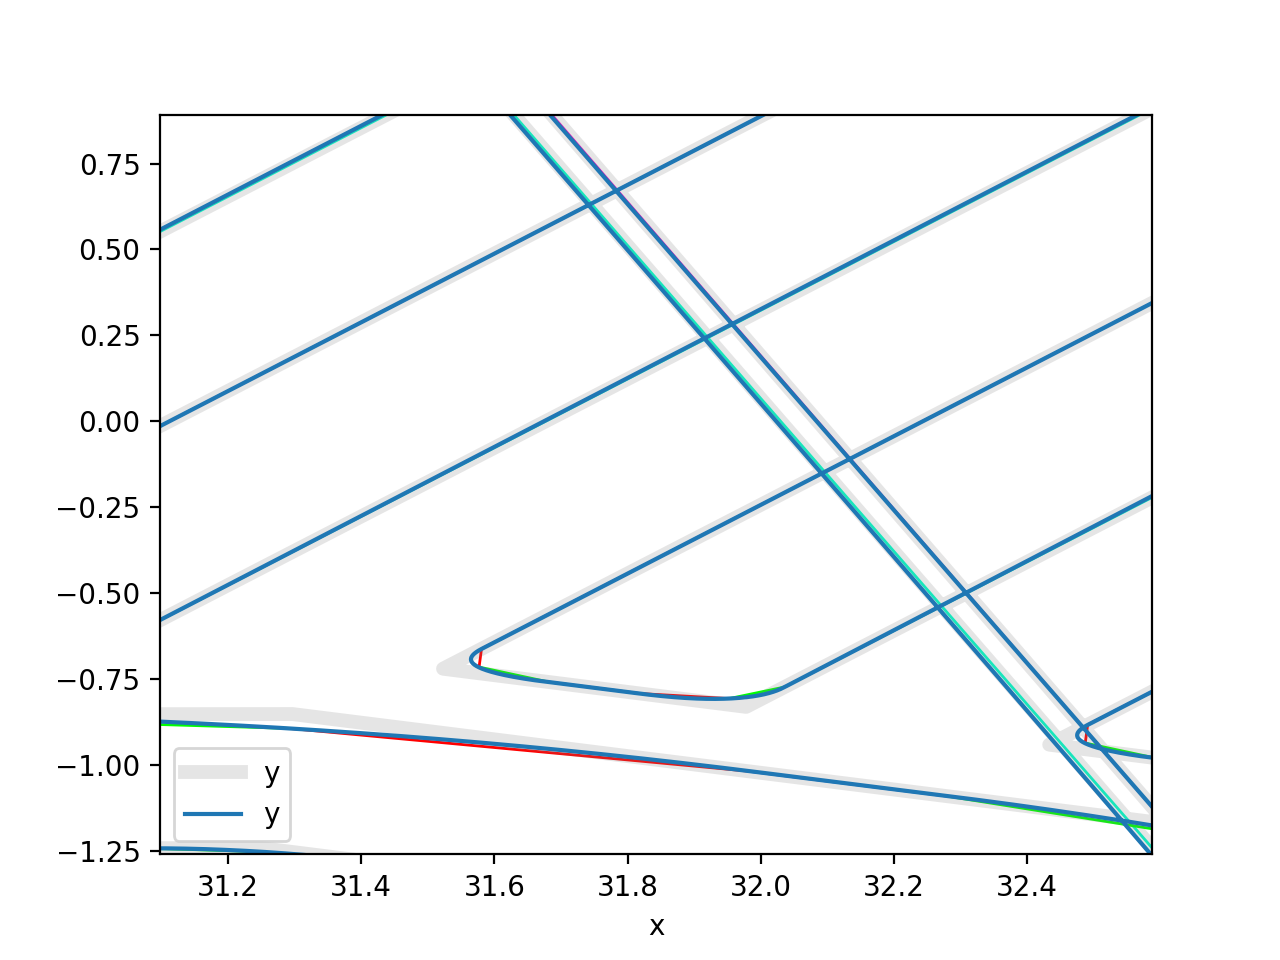

In [106]:
spm = 80
res["x"] = res["X_x"] / spm
res["y"] = res["Y_x"] / spm
res["xv"] = res["X_v"] * 65536 / 2**32 / spm * 50000000
res["yv"] = res["Y_v"] * 65536 / 2**32 / spm * 50000000
res[["x", "y", "xv", "yv", "ts"]]

lines = []
colors = []

i = 0
for index, row in all_segments.iterrows():
    i += 1
    lines.append(((row['x0'], row['y0']), (row['x1'], row['y1'])))
    st = row["seg_type"]
    if st == "start":
        colors.append((1,0,0,1))
    elif st == "end":
        colors.append((0,1,0,1))
    elif st == "short_plato":
        colors.append((0,0.3,1,1))
    elif st == "middle_plato":
        colors.append((0.8,0,0.8,1))
    elif st == "long_plato_main":
        colors.append((0.2,0.2,0.2,1))
    elif st == "long_plato_in":
        colors.append((1,0,0.8,1))
    elif st == "long_plato_out":
        colors.append((0,1,0.8,1))
    else:
        colors.append((1,1,0,1))
    
lc = LineCollection(lines, colors=colors, linewidths=1)
fig, ax = plt.subplots()

ax.add_collection(lc)

#path.iloc[limit:].plot(x="px", y="py", linewidth=3, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
full_path = pd.DataFrame()
full_path["x"] = path["px"]
full_path["y"] = path["py"]
last_x = path["x"].iloc[-1]
last_y = path["y"].iloc[-1]
full_path = full_path.append({"x": last_x, "y": last_y}, ignore_index=True)
full_path.plot(x="x", y="y", linewidth=5, color=(0.5, 0.5, 0.5, 0.2), ax=ax)
res.plot(x="x", y="y", style="-", ax=ax)
    
ax.autoscale()
ax.margins(0.1)

<IPython.core.display.Javascript object>


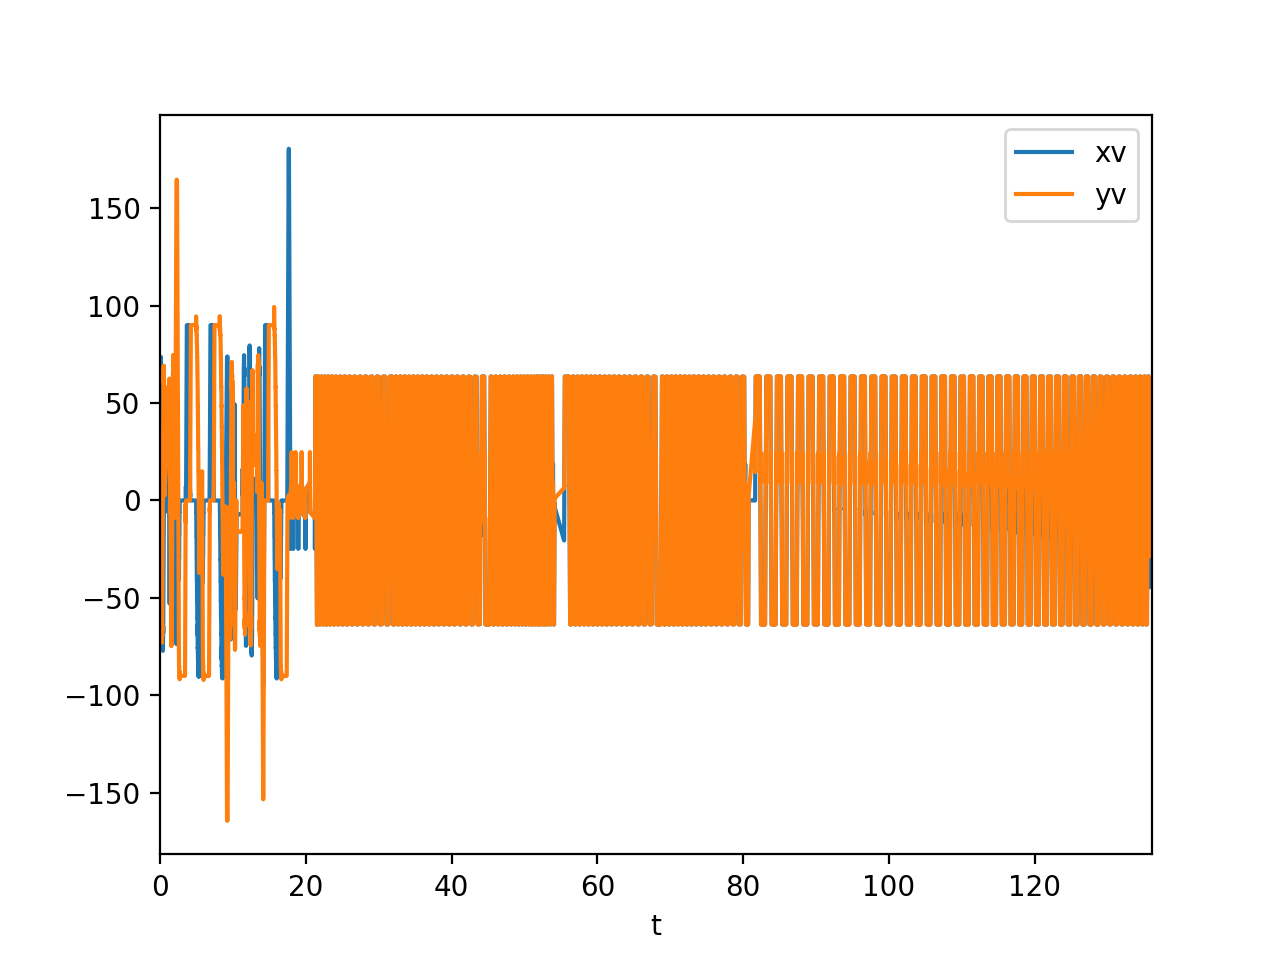

In [58]:
res.plot(x="t", y=["xv", "yv"])

In [83]:
int_dt = 80.0
int_dx = -91527257967.38159
int_dy = -25116203791.99707

print("expected dx:", int_dx / 2**32 / spm)

int_vx0 = -115446.0 
int_vx1 = -170602.0

int_vy0 = -30079.0
int_vy1 = 0.0

int_ax = -45183795.0
int_ay = 24640717.0

v_step = 50000000
v_mult = v_step / acc_step
spm = 80
    
real_dx = path_planning.int_x(int_dt, int_vx0 * 65536, int_ax, 0, 0) / 65536 * v_mult
print("real_dx:", real_dx, (real_dx - int_dx) / 2**32/spm)
x_error = int_dx - real_dx

apg = path_planning.FakeApg("X")

old_segs = [
    ProfileSegment(
        apg=apg, x=0, v=int(int_vx0), a=int(int_ax), j=0
    ),
]

old_profile = [[int(int_dt), old_segs]]

if 1:
    int_jx = np.around(-12 * x_error / int_dt / int_dt / int_dt * 65536 / v_mult)
    int_ax_new = np.around(int_ax - int_jx * int_dt / 2)
    
print("int_jx:", int_jx, "int_ax:", int_ax, "int_ax_new:", int_ax_new)



new_segs = [
    ProfileSegment(
        apg=apg, x=0, v=int(int_vx0), a=int(int_ax_new), j=int(int_jx)
    ),
]

new_profile = [[int(int_dt), new_segs]]

old_res = path_planning.emulate(old_profile, accel_step=50000000 / acc_step)
new_res = path_planning.emulate(new_profile, accel_step=50000000 / acc_step)


real_dx_new = path_planning.int_x(int_dt, int_vx0 * 65536, int_ax_new, int_jx, 0) / 65536 * v_mult
print("real dx new:", real_dx_new, (real_dx_new - int_dx) / 2**32/spm)

display(old_res)
display(new_res)

expected dx: -0.2663793798052403
real_dx: -57071709951.78223 0.10027884277398513
int_jx: 10584744.0 int_ax: -45183795.0 int_ax_new: -468573555.0
real dx new: -92797805117.79785 -0.003697778885300096


X_a  X_j  X_jj       X_v        X_x  ts       t
0  -45183795    0     0 -1.761566   0.000000   0  0.0000
1  -45183795    0     0 -1.772079  -0.134397   1  0.0001
2  -45183795    0     0 -1.782593  -0.269596   2  0.0002
3  -45183795    0     0 -1.793106  -0.405597   3  0.0003
4  -45183795    0     0 -1.803619  -0.542400   4  0.0004
5  -45183795    0     0 -1.814133  -0.680005   5  0.0005
6  -45183795    0     0 -1.824646  -0.818413   6  0.0006
7  -45183795    0     0 -1.835159  -0.957622   7  0.0007
8  -45183795    0     0 -1.845673  -1.097634   8  0.0008
9  -45183795    0     0 -1.856186  -1.238447   9  0.0009
10 -45183795    0     0 -1.866699  -1.380063  10  0.0010
11 -45183795    0     0 -1.877213  -1.522481  11  0.0011
12 -45183795    0     0 -1.887726  -1.665701  12  0.0012
13 -45183795    0     0 -1.898239  -1.809723  13  0.0013
14 -45183795    0     0 -1.908752  -1.954547  14  0.0014
15 -45183795    0     0 -1.919266  -2.100173  15  0.0015
16 -45183795    0     0 -1.929779  -2.246602  16  0.0016
17 -45183795    0     0 -1.940292  -2.393832  17  0.0017
18 -45183795    0     0 -1.950806  -2.541865  18  0.0018
19 -45183795    0     0 -1.961319  -2.690699  19  0.0019
20 -45183795    0     0 -1.971832  -2.840336  20  0.0020
21 -45183795    0     0 -1.982346  -2.990775  21  0.0021
22 -45183795    0     0 -1.992859  -3.142016  22  0.0022
23 -45183795    0     0 -2.003372  -3.294059  23  0.0023
24 -45183795    0     0 -2.013885  -3.446904  24  0.0024
25 -45183795    0     0 -2.024399  -3.600551  25  0.0025
26 -45183795    0     0 -2.034912  -3.755001  26  0.0026
27 -45183795    0     0 -2.045425  -3.910252  27  0.0027
28 -45183795    0     0 -2.055939  -4.066306  28  0.0028
29 -45183795    0     0 -2.066452  -4.223161  29  0.0029
..       ...  ...   ...       ...        ...  ..     ...
50 -45183795    0     0 -2.287231  -7.702416  50  0.0050
51 -45183795    0     0 -2.297745  -7.876918  51  0.0051
52 -45183795    0     0 -2.308258  -8.052222  52  0.0052
53 -45183795    0     0 -2.318771  -8.228328  53  0.0053
54 -45183795    0     0 -2.329285  -8.405236  54  0.0054
55 -45183795    0     0 -2.339798  -8.582947  55  0.0055
56 -45183795    0     0 -2.350311  -8.761459  56  0.0056
57 -45183795    0     0 -2.360825  -8.940774  57  0.0057
58 -45183795    0     0 -2.371338  -9.120890  58  0.0058
59 -45183795    0     0 -2.381851  -9.301809  59  0.0059
60 -45183795    0     0 -2.392365  -9.483530  60  0.0060
61 -45183795    0     0 -2.402878  -9.666053  61  0.0061
62 -45183795    0     0 -2.413391  -9.849378  62  0.0062
63 -45183795    0     0 -2.423904 -10.033505  63  0.0063
64 -45183795    0     0 -2.434418 -10.218434  64  0.0064
65 -45183795    0     0 -2.444931 -10.404165  65  0.0065
66 -45183795    0     0 -2.455444 -10.590699  66  0.0066
67 -45183795    0     0 -2.465958 -10.778034  67  0.0067
68 -45183795    0     0 -2.476471 -10.966172  68  0.0068
69 -45183795    0     0 -2.486984 -11.155112  69  0.0069
70 -45183795    0     0 -2.497498 -11.344854  70  0.0070
71 -45183795    0     0 -2.508011 -11.535397  71  0.0071
72 -45183795    0     0 -2.518524 -11.726744  72  0.0072
73 -45183795    0     0 -2.529037 -11.918892  73  0.0073
74 -45183795    0     0 -2.539551 -12.111842  74  0.0074
75 -45183795    0     0 -2.550064 -12.305594  75  0.0075
76 -45183795    0     0 -2.560577 -12.500149  76  0.0076
77 -45183795    0     0 -2.571091 -12.695505  77  0.0077
78 -45183795    0     0 -2.581604 -12.891664  78  0.0078
79 -45183795    0     0 -2.592117 -13.088625  79  0.0079

[80 rows x 7 columns]

X_a       X_j  X_jj       X_v        X_x  ts       t
0  -468573555  10584744     0 -1.761566   0.000000   0  0.0000
1  -457988811  10584744     0 -1.870651  -0.134397   1  0.0001
2  -447404067  10584744     0 -1.977280  -0.277116   2  0.0002
3  -436819323  10584744     0 -2.081436  -0.427971   3  0.0003
4  -426234579  10584744     0 -2.183136  -0.586772   4  0.0004
5  -415649835  10584744     0 -2.282364  -0.753332   5  0.0005
6  -405065091  10584744     0 -2.379135  -0.927462   6  0.0006
7  -394480347  10584744     0 -2.473434  -1.108976   7  0.0007
8  -383895603  10584744     0 -2.565277  -1.297684   8  0.0008
9  -373310859  10584744     0 -2.654648  -1.493399   9  0.0009
10 -362726115  10584744     0 -2.741562  -1.695933  10  0.0010
11 -352141371  10584744     0 -2.826004  -1.905097  11  0.0011
12 -341556627  10584744     0 -2.907990  -2.120704  12  0.0012
13 -330971883  10584744     0 -2.987503  -2.342566  13  0.0013
14 -320387139  10584744     0 -3.064560  -2.570495  14  0.0014
15 -309802395  10584744     0 -3.139145  -2.804302  15  0.0015
16 -299217651  10584744     0 -3.211273  -3.043800  16  0.0016
17 -288632907  10584744     0 -3.280930  -3.288800  17  0.0017
18 -278048163  10584744     0 -3.348129  -3.539115  18  0.0018
19 -267463419  10584744     0 -3.412857  -3.794557  19  0.0019
20 -256878675  10584744     0 -3.475128  -4.054938  20  0.0020
21 -246293931  10584744     0 -3.534927  -4.320069  21  0.0021
22 -235709187  10584744     0 -3.592270  -4.589763  22  0.0022
23 -225124443  10584744     0 -3.647141  -4.863831  23  0.0023
24 -214539699  10584744     0 -3.699554  -5.142086  24  0.0024
25 -203954955  10584744     0 -3.749496  -5.424339  25  0.0025
26 -193370211  10584744     0 -3.796982  -5.710403  26  0.0026
27 -182785467  10584744     0 -3.841995  -6.000090  27  0.0027
28 -172200723  10584744     0 -3.884552  -6.293211  28  0.0028
29 -161615979  10584744     0 -3.924637  -6.589579  29  0.0029
..        ...       ...   ...       ...        ...  ..     ...
50   60663645  10584744     0 -4.197144 -13.230232  50  0.0050
51   71248389  10584744     0 -4.183014 -13.550449  51  0.0051
52   81833133  10584744     0 -4.166412 -13.869588  52  0.0052
53   92417877  10584744     0 -4.147354 -14.187460  53  0.0053
54  103002621  10584744     0 -4.125824 -14.503878  54  0.0054
55  113587365  10584744     0 -4.101837 -14.818653  55  0.0055
56  124172109  10584744     0 -4.075378 -15.131598  56  0.0056
57  134756853  10584744     0 -4.046463 -15.442525  57  0.0057
58  145341597  10584744     0 -4.015076 -15.751246  58  0.0058
59  155926341  10584744     0 -3.981232 -16.057572  59  0.0059
60  166511085  10584744     0 -3.944916 -16.361316  60  0.0060
61  177095829  10584744     0 -3.906143 -16.662289  61  0.0061
62  187680573  10584744     0 -3.864899 -16.960304  62  0.0062
63  198265317  10584744     0 -3.821198 -17.255172  63  0.0063
64  208850061  10584744     0 -3.775024 -17.546706  64  0.0064
65  219434805  10584744     0 -3.726395 -17.834718  65  0.0065
66  230019549  10584744     0 -3.675293 -18.119019  66  0.0066
67  240604293  10584744     0 -3.621735 -18.399422  67  0.0067
68  251189037  10584744     0 -3.565704 -18.675738  68  0.0068
69  261773781  10584744     0 -3.507217 -18.947780  69  0.0069
70  272358525  10584744     0 -3.446259 -19.215359  70  0.0070
71  282943269  10584744     0 -3.382843 -19.478288  71  0.0071
72  293528013  10584744     0 -3.316956 -19.736378  72  0.0072
73  304112757  10584744     0 -3.248611 -19.989442  73  0.0073
74  314697501  10584744     0 -3.177795 -20.237291  74  0.0074
75  325282245  10584744     0 -3.104523 -20.479738  75  0.0075
76  335866989  10584744     0 -3.028778 -20.716594  76  0.0076
77  346451733  10584744     0 -2.950577 -20.947672  77  0.0077
78  357036477  10584744     0 -2.869904 -21.172783  78  0.0078
79  367621221  10584744     0 -2.786774 -21.391739  79  0.0079

[80 rows x 7 columns]